In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype

In [2]:
!pip install tensorflow

  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached tensorflow_io_gcs_filesystem-0.33.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached Werkzeug-2.2.3-py3-none-any.whl (233 kB)


In [3]:
import tensorflow as tf

2023-08-15 21:46:42.461259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 21:46:44.029039: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:46:44.029216: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [4]:
!pip install keras

In [5]:
!pip install scikeras

  Using cached scikeras-0.10.0-py3-none-any.whl (27 kB)


In [6]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [7]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [8]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

  Using cached livelossplot-0.5.5-py3-none-any.whl (22 kB)
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)


In [9]:
!pip install shap
import shap

  Using cached shap-0.42.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (545 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [10]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [11]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [12]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [13]:
data_analysis_folder_path = 'master-thesis/data-analysis/'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [14]:
project_id = "master-thesis-2023-393813" # Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [15]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [16]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [17]:
SQL_QUERY = f"""SELECT * FROM {BQ_TABLE_USERS} LIMIT 10000"""
users_df1 = bqclient.query(SQL_QUERY).to_dataframe()

In [18]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [19]:
num_bots = 0 # bots iter.
num_humans = 0 # humans iter.

for index, record in users_df1.iterrows():
    if record['label']=='bot':
      num_bots += 1
    if record['label']=='human':
      num_humans += 1

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  7867
Number of bots:  2133


In [20]:
org_users_df = users_df1.copy()
users_df2 = org_users_df.copy()

In [21]:
users_df = pd.DataFrame()

i = 0 # bots iter.
j = 0 # humans iter.
k = 0
max_bots = num_bots
max_humans = num_bots
for index, record in users_df2.iterrows():
  if k < (max_bots+max_humans):
    if record['label']=='bot' and i < max_bots:
      users_df = users_df.append(record)
      # users_df = pd.concat([users_df, record], ignore_index=True)
      i += 1
      k += 1
    if record['label']=='human' and j < max_humans:
      users_df = users_df.append(record)
      # users_df = pd.concat([users_df, record], ignore_index=True)
      j += 1
      k += 1

## Data preparation

In [22]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [23]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

### Encoding of non-numeric information which will be used by model

In [24]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


In [25]:
users_df

id  label         username                    name  \
0     1484544053572419585      0  blessing_xettry        #Blessing xettry   
1     1447956502443069446      0      menametaken               winwinnie   
2     1487790036322033674      0    VShipExpress1          V Ship Express   
3      901531094507507715      0        dbamiloye  Damilola Mike-Bamiloye   
4     1329634133379665921      0  Languagegamesny        Languagegamesnyc   
...                   ...    ...              ...                     ...   
9977  1214029823984599040      1  againstempiric1                magee ��   
9978  1480060548410580995      1  MetawarOfficial                 Metawar   
9979  1338724314766585856      1    steinartgroup         stein art group   
9987   782641505089363968      1    kessentiniglp     Marouane Kessentini   
9988           1708464528      1       JSociology    Journal of Sociology   

        created_at  verified  protected  withheld  has_location    location  \
0     1.642778e+09         0          0         0             1       Nepal   
1     1.634055e+09         0          0         0             1  your walls   
2     1.643552e+09         0          0         0             1      Canada   
3     1.503777e+09         0          0         0             1     Nigeria   
4     1.605844e+09         0          0         0             1    New York   
...            ...       ...        ...       ...           ...         ...   
9977  1.578282e+09         0          0         0             0        None   
9978  1.641709e+09         0          0         0             0        None   
9979  1.608012e+09         0          0         0             0        None   
9987  1.475431e+09         0          0         0             0        None   
9988  1.377732e+09         0          0         0             0        None   

      has_profile_image_url  has_pinned_tweet                      url  \
0                         1                 0                            
1                         1                 0                            
2                         1                 0  https://t.co/HE80bmcMvk   
3                         1                 1                            
4                         1                 1  https://t.co/jN9HYPLgeV   
...                     ...               ...                      ...   
9977                      1                 0                            
9978                      1                 1                            
9979                      1                 0  https://t.co/WbtX3bST1a   
9987                      1                 0                            
9988                      1                 0   http://t.co/QbiSibtEmi   

      followers_count  following_count  tweet_count  listed_count  \
0                 0.0             24.0          1.0           0.0   
1                 0.0             20.0          1.0           0.0   
2                 0.0              0.0         26.0           0.0   
3             54528.0            190.0       5039.0          11.0   
4                 1.0            128.0         79.0           0.0   
...               ...              ...          ...           ...   
9977            172.0             81.0       2245.0           5.0   
9978         283820.0              2.0          7.0          54.0   
9979            174.0           1555.0         34.0           0.0   
9987            183.0            187.0        159.0           0.0   
9988           4791.0            515.0       1242.0         109.0   

      has_description  \
0                   1   
1                   1   
2                   1   
3                   1   
4                   1   
...               ...   
9977                1   
9978                1   
9979                1   
9987                0   
9988                1   

                                                                                                                                  

#### Null and NaN statistics

In [26]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
withheld: 0
has_location: 0
location: 1413
has_profile_image_url: 0
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0


In [27]:
users_reduced_df = users_df.copy()
columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
users_reduced_df

label  verified  protected  withheld  has_location  \
0         0         0          0         0             1   
1         0         0          0         0             1   
2         0         0          0         0             1   
3         0         0          0         0             1   
4         0         0          0         0             1   
...     ...       ...        ...       ...           ...   
9977      1         0          0         0             0   
9978      1         0          0         0             0   
9979      1         0          0         0             0   
9987      1         0          0         0             0   
9988      1         0          0         0             0   

      has_profile_image_url  has_pinned_tweet  followers_count  \
0                         1                 0              0.0   
1                         1                 0              0.0   
2                         1                 0              0.0   
3                         1                 1          54528.0   
4                         1                 1              1.0   
...                     ...               ...              ...   
9977                      1                 0            172.0   
9978                      1                 1         283820.0   
9979                      1                 0            174.0   
9987                      1                 0            183.0   
9988                      1                 0           4791.0   

      following_count  tweet_count  listed_count  has_description  \
0                24.0          1.0           0.0                1   
1                20.0          1.0           0.0                1   
2                 0.0         26.0           0.0                1   
3               190.0       5039.0          11.0                1   
4               128.0         79.0           0.0                1   
...               ...          ...           ...              ...   
9977             81.0       2245.0           5.0                1   
9978              2.0          7.0          54.0                1   
9979           1555.0         34.0           0.0                1   
9987            187.0        159.0           0.0                0   
9988            515.0       1242.0         109.0                1   

      descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
0                   0.0                0.0                0.0            0.0   
1                   1.0                0.0                0.0            0.0   
2                   0.0                0.0                0.0            0.0   
3                   0.0                0.0                0.0            0.0   
4                   0.0                0.0                0.0            0.0   
...                 ...                ...                ...            ...   
9977                0.0                0.0                0.0            0.0   
9978                0.0                0.0                0.0            2.0   
9979                0.0                0.0                0.0            0.0   
9987                0.0                0.0                0.0            0.0   
9988                0.0                0.0                3.0            0.0   

      url_no_urls  
0             0.0  
1             0.0  
2             1.0  
3             0.0  
4             1.0  
...           ...  
9977          0.0  
9978          0.0  
9979          1.0  
9987          0.0  
9988          1.0  

[4266 rows x 17 columns]

### Data type conversion (to float)

In [28]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [29]:
train_data, test_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=25, shuffle=True)

# Data analysis

In [30]:
sns.set(font_scale=2)

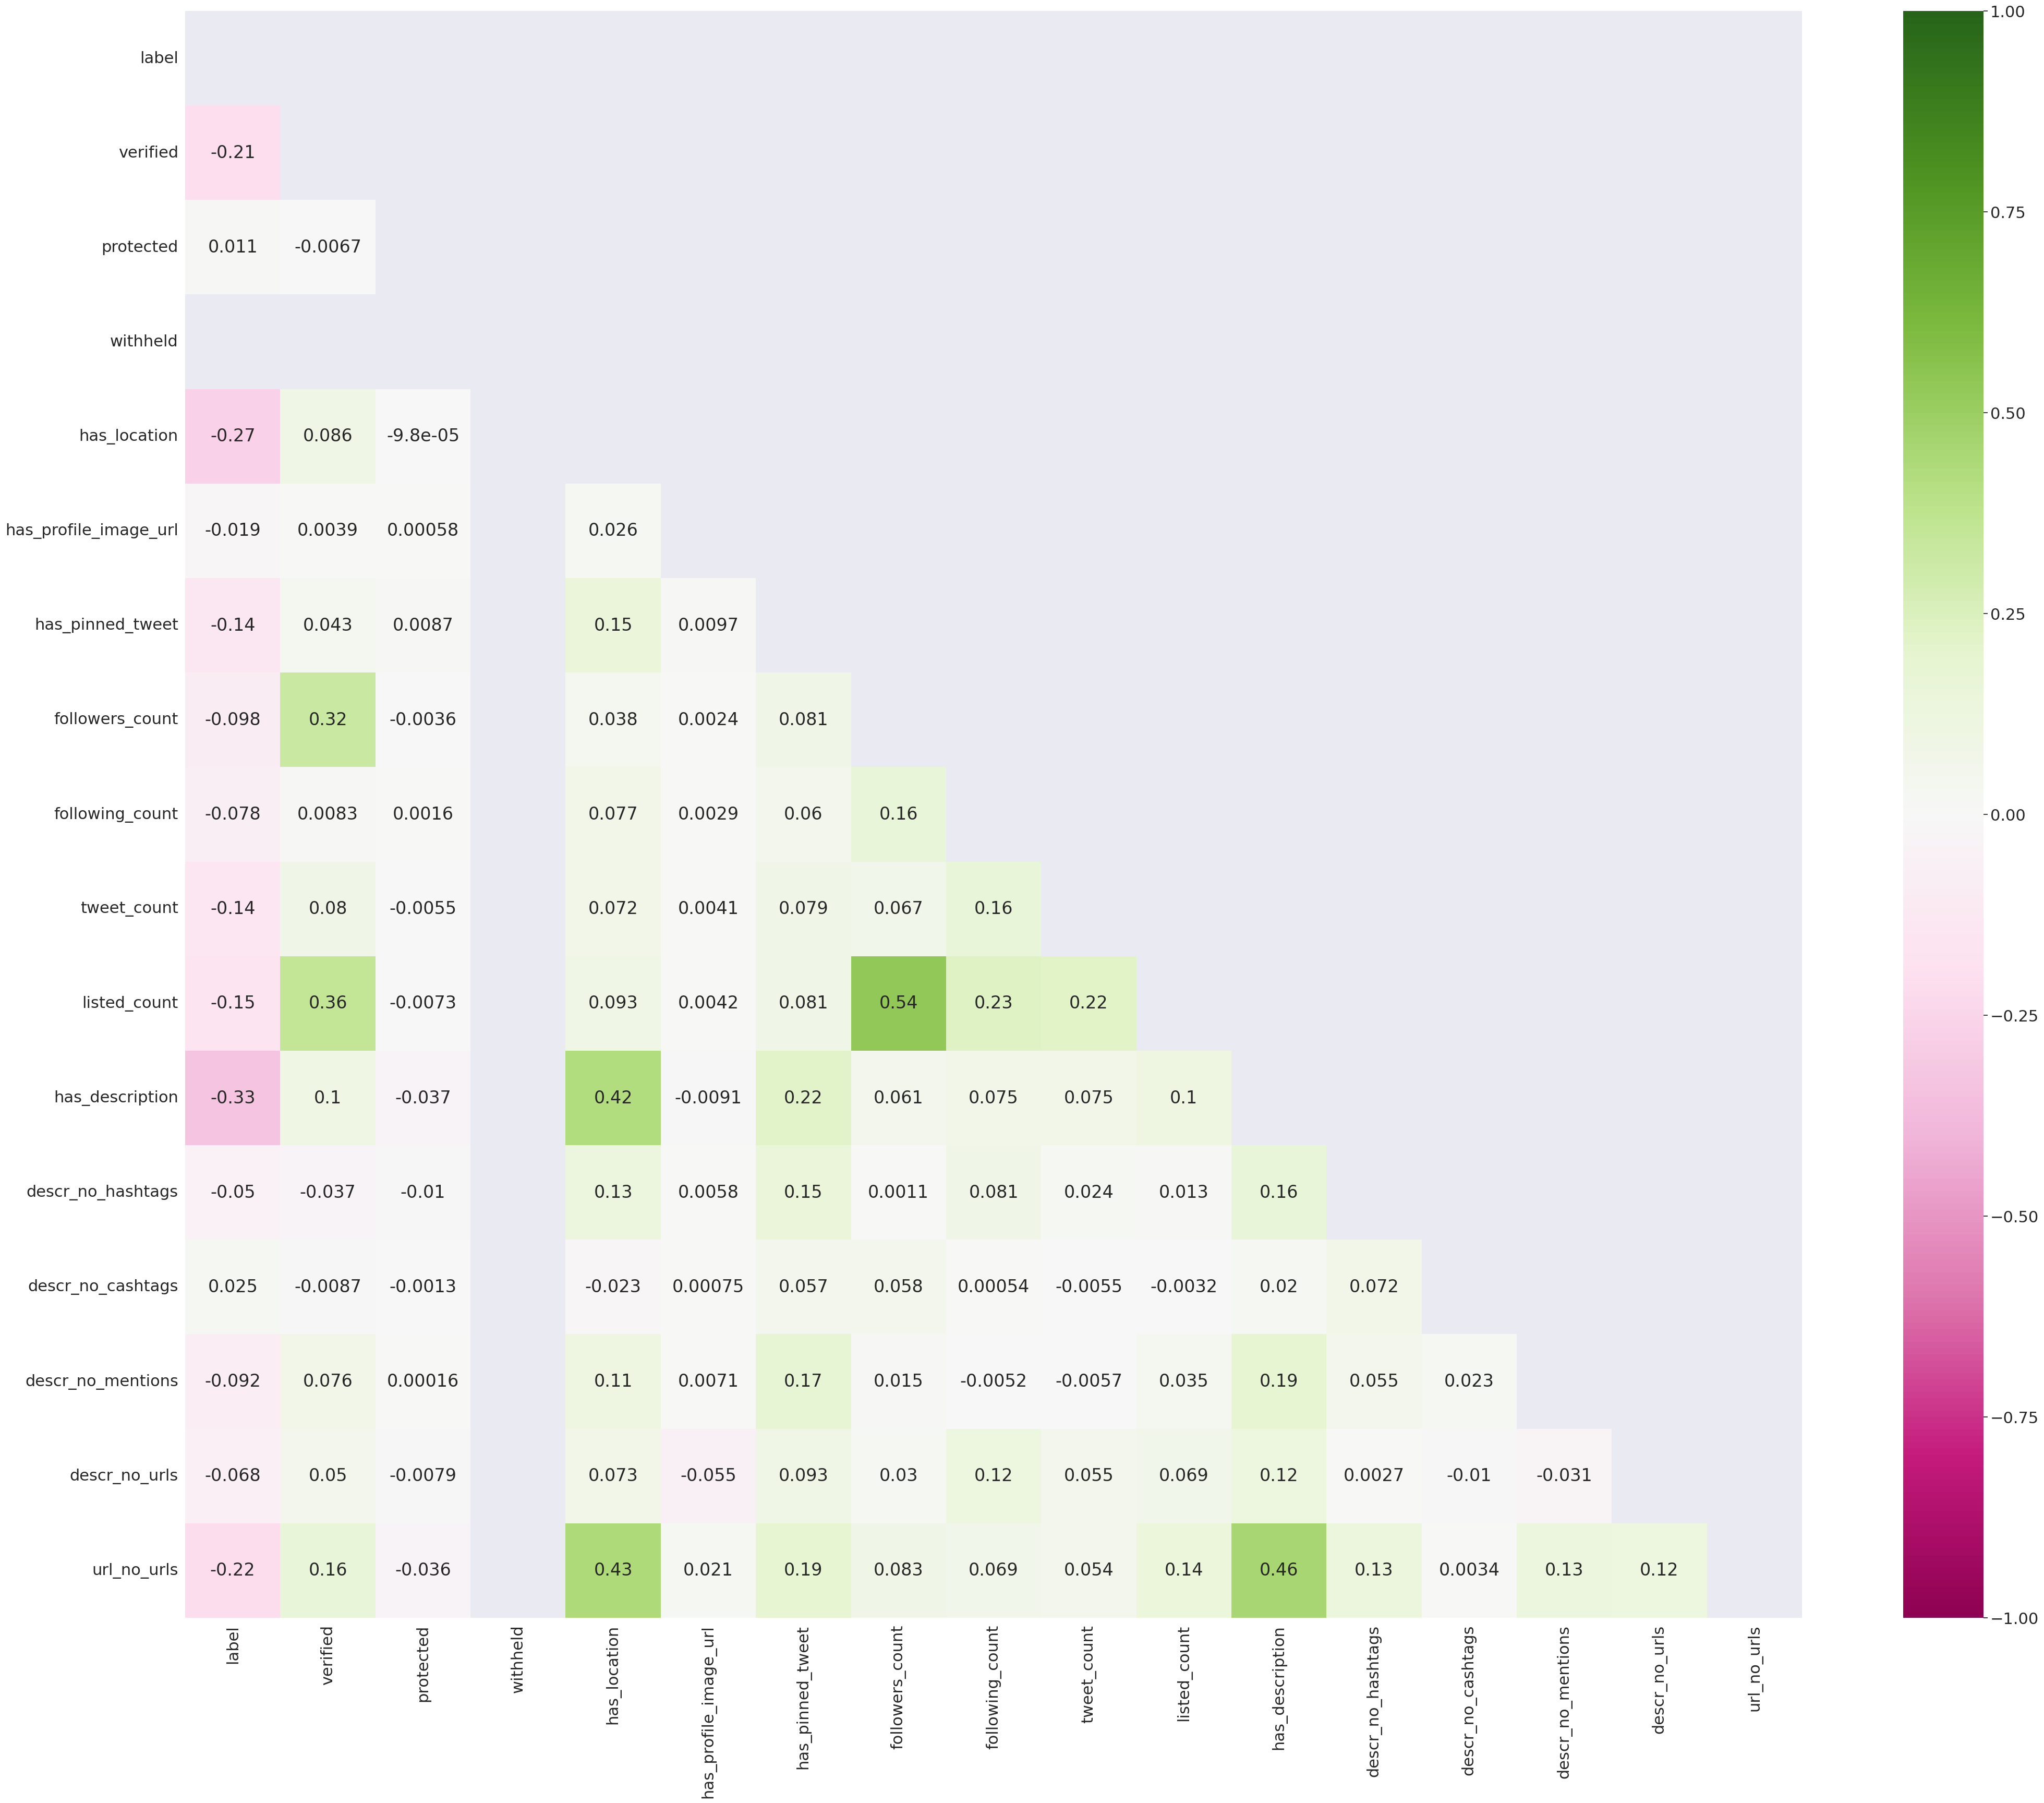

In [31]:
corr_threshold = 0.5
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [32]:
sns.set(font_scale=1)

In [33]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 1


[('followers_count', 'listed_count', 0.5387751426656634)]

In [34]:
train_data = train_data.drop(['listed_count'], axis=1)
val_data = val_data.drop(['listed_count'], axis=1)
test_data = test_data.drop(['listed_count'], axis=1)

#### Split data for input and output

In [35]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [36]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [37]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [38]:
def create_confusion_matrix(test_Y, out_Y):
  cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

  group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  plt.figure()
  fig = plt.figure(figsize=(7,7))
  ax = fig.add_subplot(111)

  sns.heatmap(
      cm,
      annot=labels,
      annot_kws={"size": 16},
      fmt='',
      cmap=plt.cm.Blues,
      cbar=False
  )
  ax.set_title("Confusion matrix", fontsize=20)
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
  ax.set_ylabel('True', fontsize=16)
  ax.set_xlabel('Predicted', fontsize=16)

  fig.show()

## Neural network models 

In [39]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=50,
                           restore_best_weights=True,
                           mode='max')
# PlotLosses
plot_losses = PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [40]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses,
                           early_stop,
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [41]:
def create_model_1(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

2023-08-15 21:47:55.685337: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:47:55.685390: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-15 21:47:55.685423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (01f4da9767e1): /proc/driver/nvidia/version does not exist
2023-08-15 21:47:55.687570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

In [42]:
model_name = 'model_users_only_1000_1_v1'
shape = (train_X.shape[1],)
model = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                512       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 6

### Train model

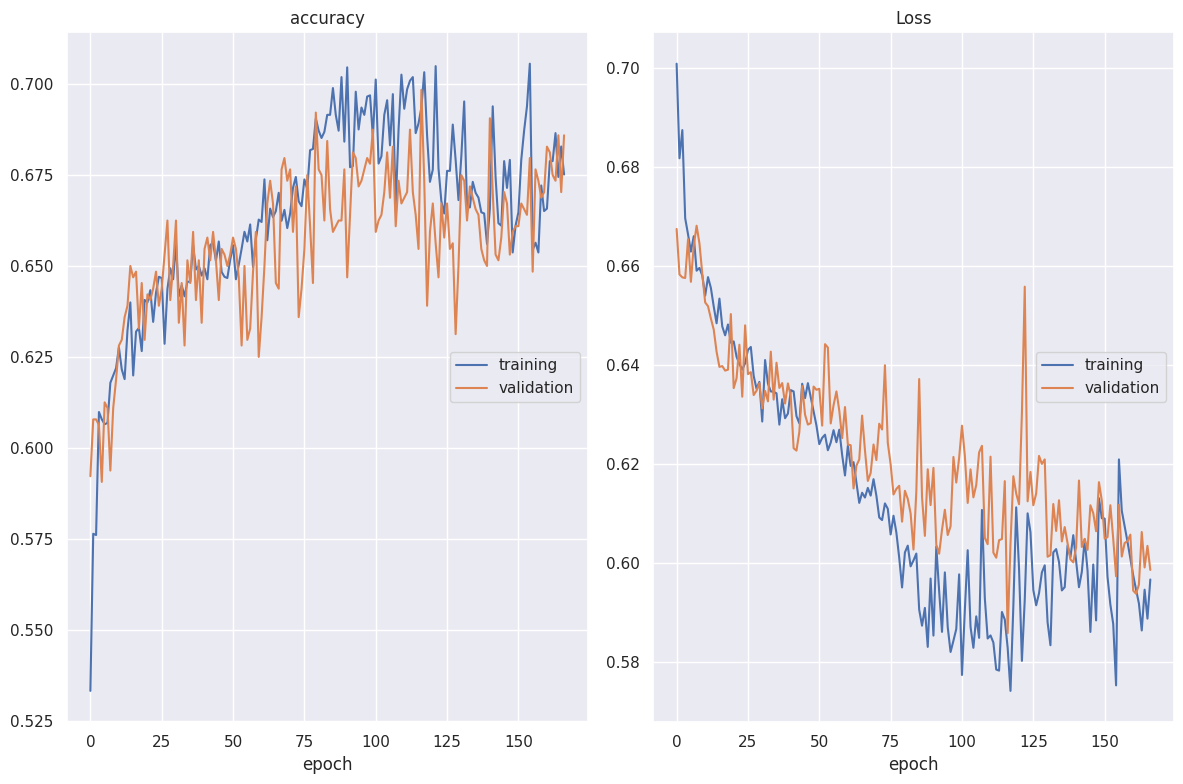

accuracy
	training         	 (min:    0.533, max:    0.706, cur:    0.675)
	validation       	 (min:    0.591, max:    0.698, cur:    0.686)
Loss
	training         	 (min:    0.574, max:    0.701, cur:    0.597)
	validation       	 (min:    0.586, max:    0.668, cur:    0.599)

Epoch 167: val_accuracy did not improve from 0.69844
60/60 [==============================] - 1s 14ms/step - loss: 0.5967 - accuracy: 0.6752 - val_loss: 0.5986 - val_accuracy: 0.6859


In [43]:
model = train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=200)

In [44]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

### Prediction

In [45]:
out_Y_org = model.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

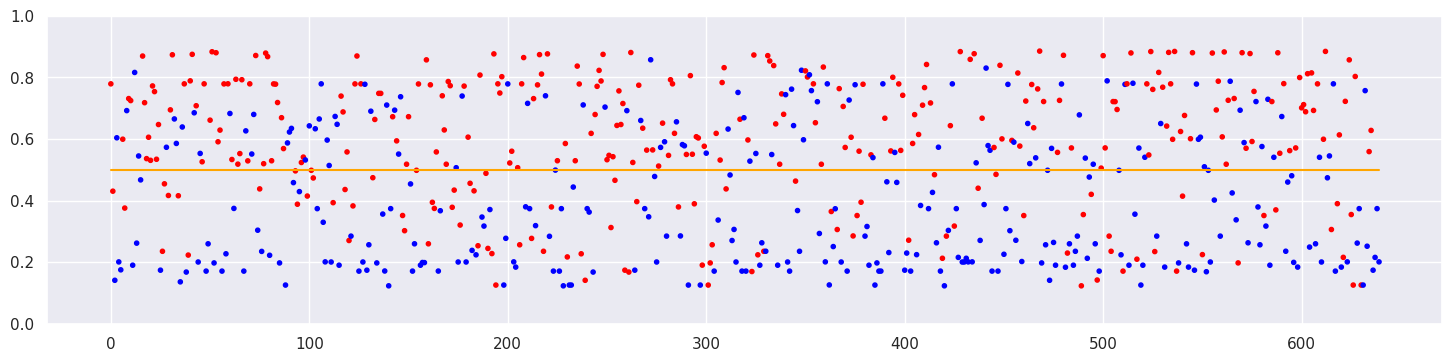

In [62]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

## Confusion matrix

Accuracy: 0.690625
Precision: [0.68600683 0.6945245 ]
Recall: 0.7237237237237237
F1 score: 0.708824
ROC AUC: 0.689223


(0.690625,
 array([0.68600683, 0.6945245 ]),
 0.7237237237237237,
 0.7088235294117646,
 0.6892234253797772)

<Figure size 640x480 with 0 Axes>

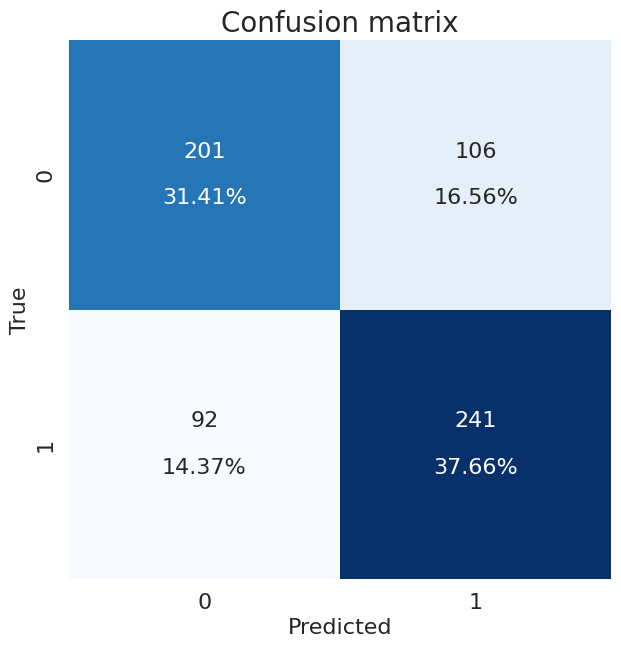

In [47]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

Accuracy: 0.725

Precision: [0.71061093 0.73860182]

Recall: 0.7297297297297297

F1 score: 0.734139

ROC AUC: 0.724800

## SHAP (SHapley Additive exPlanations) 

In [48]:
explainer = shap.DeepExplainer(model, np.asarray(train_X))
shap_values = explainer.shap_values(np.asarray(train_X))

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


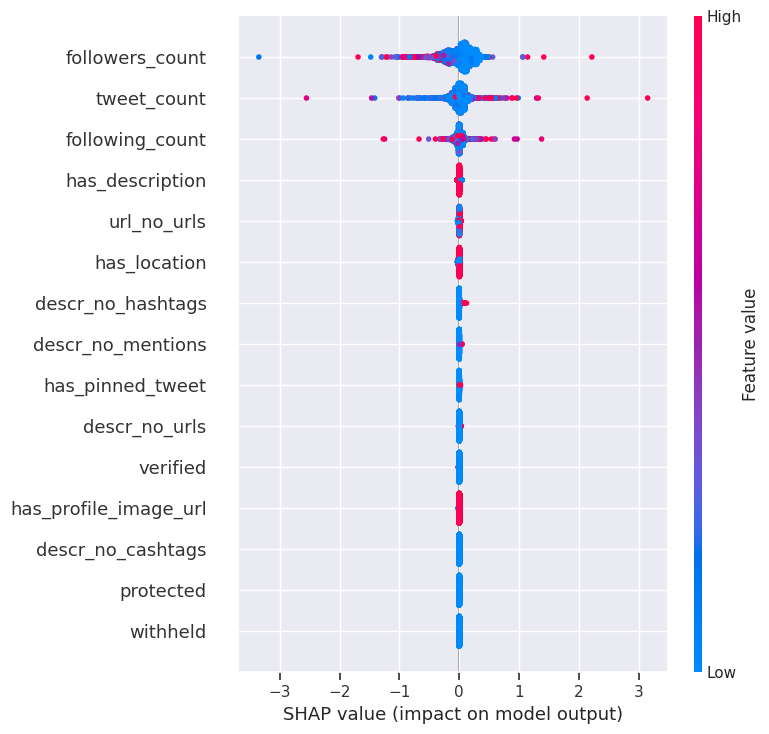

In [49]:
shap.summary_plot(shap_values[0], train_X, plot_type='dot')

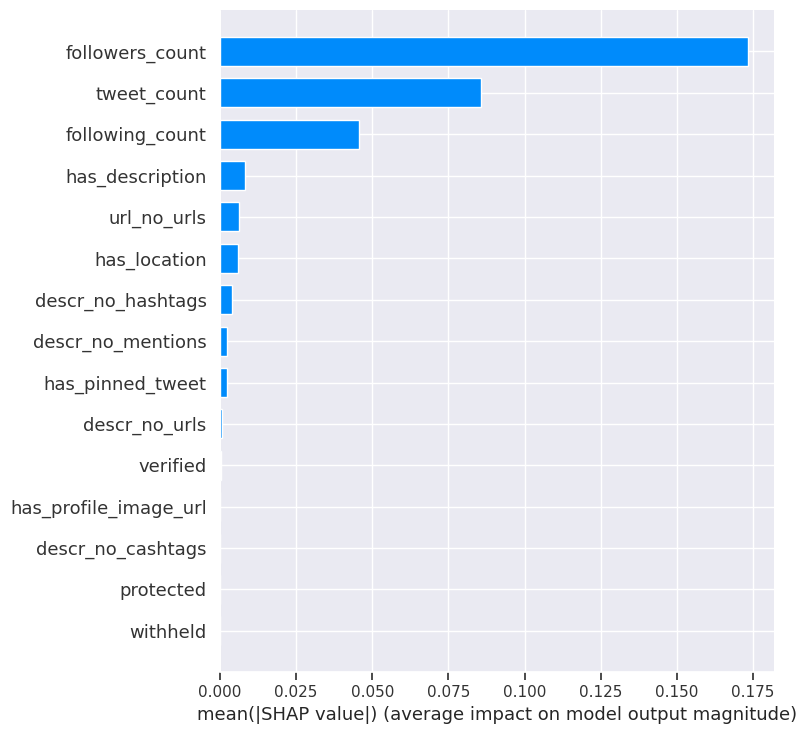

In [50]:
shap.summary_plot(shap_values[0], train_X, plot_type='bar')

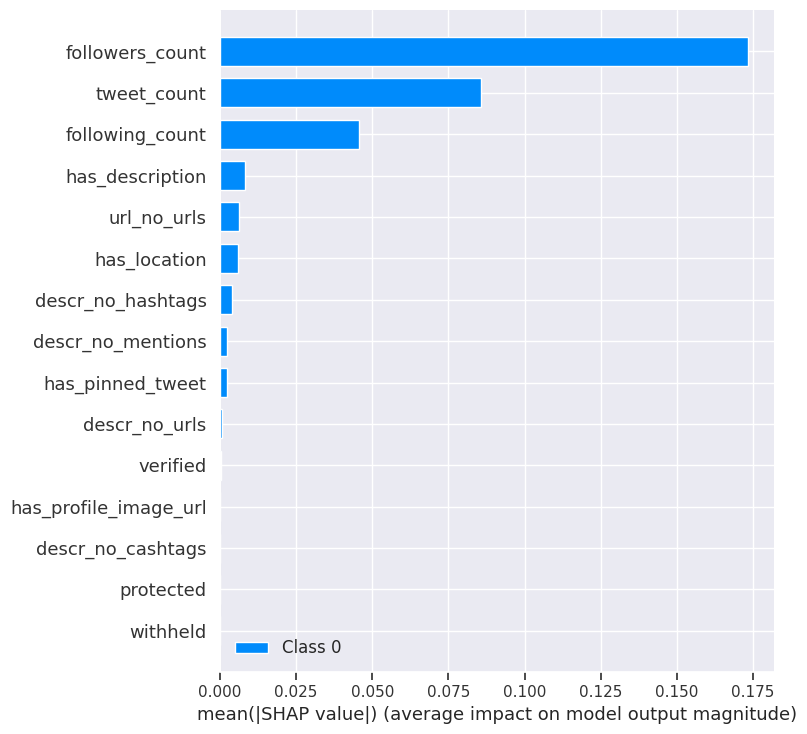

In [51]:
shap.summary_plot(shap_values, train_X, plot_type='bar')

In [52]:
# shap.dependence_plot("followers_count", shap_values[0],  train_X)

### Grid search for finding the most optimal set of parameters

In [53]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [54]:
def create_model_1_gs(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

model_wrapper = KerasClassifier(model=create_model_1_gs(shape=(train_X.shape[1],)))

In [55]:
def create_model_1_gs(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

model_wrapper = KerasClassifier(model=create_model_1_gs(shape=(train_X.shape[1],)))
# model_wrapper.get_params().keys()

early_stop_sg = EarlyStopping(monitor='accuracy',
                           patience=50,
                           restore_best_weights=True,
                           mode='max')

parameters = {
    'optimizer' : [tf.keras.optimizers.Adam(learning_rate=0.0001), tf.keras.optimizers.Adam(learning_rate=0.001), tf.keras.optimizers.Adam(learning_rate=0.01)],
    'batch_size' : [10, 20, 40, 60, 80, 100, 150, 200, 250],
    'epochs' : [10, 50, 100],
    'callbacks' : [early_stop_sg]}
# parameters = {
#     'batch_size' : [10, 20, 60, 100, 150, 200],
#     'epochs' : [10, 50]}


dnn_model_grid = GridSearchCV(estimator=model_wrapper,
                        param_grid=parameters,
                        scoring='accuracy',
                        cv=5,
                        n_jobs=10,
                        verbose=0)


dnn_model_grid.fit(train_X, train_Y)

INFO:tensorflow:Assets written to: ram://89543a81c9d44fba95d65409d33d450c/assets


INFO:tensorflow:Assets written to: ram://89543a81c9d44fba95d65409d33d450c/assets
2023-08-15 21:50:48.651402: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://79711579b0644ed2a3e77ffc1f2b3aed: INVALID_ARGUMENT: ram://79711579b0644ed2a3e77ffc1f2b3aed is a directory.


INFO:tensorflow:Assets written to: ram://a85e84e6bd47480980b19df5a5e708e2/assets


INFO:tensorflow:Assets written to: ram://a85e84e6bd47480980b19df5a5e708e2/assets
2023-08-15 21:50:50.569203: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9e883542890c4d25b489bc77837d5abf: INVALID_ARGUMENT: ram://9e883542890c4d25b489bc77837d5abf is a directory.


INFO:tensorflow:Assets written to: ram://324d6a59110b4bc7b112b7b04f47babb/assets


INFO:tensorflow:Assets written to: ram://324d6a59110b4bc7b112b7b04f47babb/assets
2023-08-15 21:50:52.748477: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c83f4608389540009b39138a0b32f96b: INVALID_ARGUMENT: ram://c83f4608389540009b39138a0b32f96b is a directory.


INFO:tensorflow:Assets written to: ram://a5412c34504346f08bd1b01cffa1402a/assets


INFO:tensorflow:Assets written to: ram://a5412c34504346f08bd1b01cffa1402a/assets
2023-08-15 21:50:54.565884: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ab2533fc59954c388bb68ea76c703c8d: INVALID_ARGUMENT: ram://ab2533fc59954c388bb68ea76c703c8d is a directory.


INFO:tensorflow:Assets written to: ram://76426091074a4bbd8f2a5a8eba999397/assets


INFO:tensorflow:Assets written to: ram://76426091074a4bbd8f2a5a8eba999397/assets
2023-08-15 21:50:56.368243: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ab5f77ccfcc148d49d6f8b65e808be05: INVALID_ARGUMENT: ram://ab5f77ccfcc148d49d6f8b65e808be05 is a directory.


INFO:tensorflow:Assets written to: ram://d898f367468b40cf816347360dfe0589/assets


INFO:tensorflow:Assets written to: ram://d898f367468b40cf816347360dfe0589/assets
2023-08-15 21:50:58.201171: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://05d5afd146004bd0b619f190dee0404b: INVALID_ARGUMENT: ram://05d5afd146004bd0b619f190dee0404b is a directory.


INFO:tensorflow:Assets written to: ram://0247c197a8184f75bb9f0261d669f0e9/assets


INFO:tensorflow:Assets written to: ram://0247c197a8184f75bb9f0261d669f0e9/assets
2023-08-15 21:51:00.366184: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d57ef01f65464642839a900a02834166: INVALID_ARGUMENT: ram://d57ef01f65464642839a900a02834166 is a directory.


INFO:tensorflow:Assets written to: ram://3e480d4440124bd6873d6ee0b5768ae4/assets


INFO:tensorflow:Assets written to: ram://3e480d4440124bd6873d6ee0b5768ae4/assets
2023-08-15 21:51:02.211311: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0a7460708088464db549b18581e48186: INVALID_ARGUMENT: ram://0a7460708088464db549b18581e48186 is a directory.


INFO:tensorflow:Assets written to: ram://7e97b1f9e1a94d88928549b138fe37b7/assets


INFO:tensorflow:Assets written to: ram://7e97b1f9e1a94d88928549b138fe37b7/assets
2023-08-15 21:51:04.084278: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5f88400ef9c74f71a2968a3e8b8f176c: INVALID_ARGUMENT: ram://5f88400ef9c74f71a2968a3e8b8f176c is a directory.


INFO:tensorflow:Assets written to: ram://065a7f2d8d4a46468227efa06772c79d/assets


INFO:tensorflow:Assets written to: ram://065a7f2d8d4a46468227efa06772c79d/assets
2023-08-15 21:51:06.055866: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3b3bba3ef90a4ea3a428b455e545dcfa: INVALID_ARGUMENT: ram://3b3bba3ef90a4ea3a428b455e545dcfa is a directory.


INFO:tensorflow:Assets written to: ram://a974eb43d9fc4e978c7d9002a4a6e3ba/assets


INFO:tensorflow:Assets written to: ram://a974eb43d9fc4e978c7d9002a4a6e3ba/assets
2023-08-15 21:51:07.898150: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1bb7be46c14a442b87a6e077f35bd693: INVALID_ARGUMENT: ram://1bb7be46c14a442b87a6e077f35bd693 is a directory.


INFO:tensorflow:Assets written to: ram://4cdd6c27685a4d8485b6dafbccd2f1ef/assets


INFO:tensorflow:Assets written to: ram://4cdd6c27685a4d8485b6dafbccd2f1ef/assets


INFO:tensorflow:Assets written to: ram://1da086214a924136854d8dcab693bd07/assets


INFO:tensorflow:Assets written to: ram://1da086214a924136854d8dcab693bd07/assets
2023-08-15 21:51:12.862419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 21:51:13.590903: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f51947d26caf4cb88ca23c7419082480: INVALID_ARGUMENT: ram://f51947d26caf4cb88ca23c7419082480 is a directory.


INFO:tensorflow:Assets written to: ram://6f58cf6e93ab46ccb6d3970f4e3c5640/assets


2023-08-15 21:51:14.407319: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:14.407468: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:14.407483: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

Epoch 1/10
INFO:tensorflow:Assets written to: ram://e0053f5f6d48467ab46bf6e03a4917c6/assets


INFO:tensorflow:Assets written to: ram://e0053f5f6d48467ab46bf6e03a4917c6/assets
2023-08-15 21:51:17.337718: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:17.337861: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:17.337877: W tensorflow/compiler/tf2tensor

 57/239 [======>.......................] - ETA: 0s - loss: 0.7418 - accuracy: 0.5018INFO:tensorflow:Assets written to: ram://fd244289df22484b8d9cbcccb69e8062/assets


INFO:tensorflow:Assets written to: ram://fd244289df22484b8d9cbcccb69e8062/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.7086 - accuracy: 0.5440
Epoch 2/10
110/239 [============>.................] - ETA: 0s - loss: 0.6866 - accuracy: 0.5727

2023-08-15 21:51:18.400425: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2d549a92f19041a3a851787252121d56: INVALID_ARGUMENT: ram://2d549a92f19041a3a851787252121d56 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6876 - accuracy: 0.5666
Epoch 3/10
 88/239 [==========>...................] - ETA: 0s - loss: 0.6587 - accuracy: 0.6295

2023-08-15 21:51:19.107086: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:19.107132: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-15 21:51:19.107159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (01f4da9767e1): /proc/driver/nvidia/version does not exist
2023-08-15 21:51:19.107478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

239/239 [==============================] - 1s 3ms/step - loss: 0.6776 - accuracy: 0.5829
Epoch 4/10
  1/239 [..............................] - ETA: 0s - loss: 0.6694 - accuracy: 0.6000

2023-08-15 21:51:19.368357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


239/239 [==============================] - 1s 3ms/step - loss: 0.6747 - accuracy: 0.5963
Epoch 5/10
  1/239 [..............................] - ETA: 0s - loss: 0.6413 - accuracy: 0.6000

2023-08-15 21:51:20.031096: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c0acb7eb11604b3e8fd2cb03355d7f6e: INVALID_ARGUMENT: ram://c0acb7eb11604b3e8fd2cb03355d7f6e is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6637 - accuracy: 0.6093
Epoch 6/10
115/239 [=============>................] - ETA: 0s - loss: 0.6516 - accuracy: 0.6252

209/239 [=========================>....] - ETA: 0s - loss: 0.6574 - accuracy: 0.6211

2023-08-15 21:51:21.330918: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:21.331158: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:21.331183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

239/239 [==============================] - 1s 3ms/step - loss: 0.6595 - accuracy: 0.6185
Epoch 7/10
 36/239 [===>..........................] - ETA: 0s - loss: 0.6421 - accuracy: 0.6417

239/239 [==============================] - 2s 3ms/step - loss: 0.7007 - accuracy: 0.5542
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6552 - accuracy: 0.6152
Epoch 8/10
163/239 [===================>..........] - ETA: 0s - loss: 0.6543 - accuracy: 0.6301INFO:tensorflow:Assets written to: ram://3fd9e739704e4791b451bcb29164abf5/assets


INFO:tensorflow:Assets written to: ram://3fd9e739704e4791b451bcb29164abf5/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6798 - accuracy: 0.5852
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6572 - accuracy: 0.6198
Epoch 9/10
168/239 [====================>.........] - ETA: 0s - loss: 0.6769 - accuracy: 0.5881INFO:tensorflow:Assets written to: ram://4b0e69395a564f0fa26986359b8e9f95/assets


INFO:tensorflow:Assets written to: ram://4b0e69395a564f0fa26986359b8e9f95/assets


222/239 [==========================>...] - ETA: 0s - loss: 0.6727 - accuracy: 0.5950

2023-08-15 21:51:23.270051: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:23.270108: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-15 21:51:23.270146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (01f4da9767e1): /proc/driver/nvidia/version does not exist
2023-08-15 21:51:23.270478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

239/239 [==============================] - 1s 3ms/step - loss: 0.6722 - accuracy: 0.5977
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6584 - accuracy: 0.6156
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6681 - accuracy: 0.6111
Epoch 5/10
111/239 [============>.................] - ETA: 0s - loss: 0.6684 - accuracy: 0.6018

2023-08-15 21:51:24.273830: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://96a18572162640afaa6f851dcdd1c645: INVALID_ARGUMENT: ram://96a18572162640afaa6f851dcdd1c645 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6665 - accuracy: 0.5977
Epoch 6/10
 43/239 [====>.........................] - ETA: 0s - loss: 0.6503 - accuracy: 0.6163

2023-08-15 21:51:24.799656: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6a0d17816ea04cf7889fe3af835c190f: INVALID_ARGUMENT: ram://6a0d17816ea04cf7889fe3af835c190f is a directory.
2023-08-15 21:51:24.951544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


239/239 [==============================] - 1s 3ms/step - loss: 0.6617 - accuracy: 0.6111
Epoch 7/10
 66/239 [=======>......................] - ETA: 0s - loss: 0.7485 - accuracy: 0.4864

239/239 [==============================] - 1s 3ms/step - loss: 0.6626 - accuracy: 0.6074
Epoch 8/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7119 - accuracy: 0.5408
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6543 - accuracy: 0.6111
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6827 - accuracy: 0.5835
Epoch 3/10
 38/239 [===>..........................] - ETA: 0s - loss: 0.6759 - accuracy: 0.5474

2023-08-15 21:51:27.047137: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:27.047357: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:27.047378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

 76/239 [========>.....................] - ETA: 0s - loss: 0.6745 - accuracy: 0.5816INFO:tensorflow:Assets written to: ram://6a3b4e96588c4e82bc97e0824c3d9ced/assets


INFO:tensorflow:Assets written to: ram://6a3b4e96588c4e82bc97e0824c3d9ced/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6526 - accuracy: 0.6249
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6726 - accuracy: 0.5885
Epoch 4/10
140/239 [================>.............] - ETA: 0s - loss: 0.6471 - accuracy: 0.6407

239/239 [==============================] - 1s 3ms/step - loss: 0.6655 - accuracy: 0.6111
Epoch 5/10
192/239 [=======================>......] - ETA: 0s - loss: 0.6631 - accuracy: 0.6146

2023-08-15 21:51:28.934639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:28.934699: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-15 21:51:28.934734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (01f4da9767e1): /proc/driver/nvidia/version does not exist
2023-08-15 21:51:28.935080: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

239/239 [==============================] - 1s 3ms/step - loss: 0.6615 - accuracy: 0.6157
Epoch 6/10
 20/239 [=>............................] - ETA: 0s - loss: 0.6702 - accuracy: 0.5850INFO:tensorflow:Assets written to: ram://e3cfb9ac8794477ea6a1336c22b96c60/assets


2023-08-15 21:51:29.067566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:tensorflow:Assets written to: ram://e3cfb9ac8794477ea6a1336c22b96c60/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6555 - accuracy: 0.6254
Epoch 7/10
110/239 [============>.................] - ETA: 0s - loss: 0.6621 - accuracy: 0.5982

2023-08-15 21:51:29.819858: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ec61c142e9a94317a3590c472843be53: INVALID_ARGUMENT: ram://ec61c142e9a94317a3590c472843be53 is a directory.


185/239 [======================>.......] - ETA: 0s - loss: 0.6597 - accuracy: 0.6000

239/239 [==============================] - 1s 3ms/step - loss: 0.6569 - accuracy: 0.6065
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6488 - accuracy: 0.6354
Epoch 9/10
  1/239 [..............................] - ETA: 4:26 - loss: 1.0783 - accuracy: 0.4000

2023-08-15 21:51:31.035362: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://089f618e72174cccad3ecce7a0519723: INVALID_ARGUMENT: ram://089f618e72174cccad3ecce7a0519723 is a directory.
2023-08-15 21:51:31.204817: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:31.205172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr

239/239 [==============================] - 1s 3ms/step - loss: 0.6545 - accuracy: 0.6233
Epoch 10/10
186/239 [======================>.......] - ETA: 0s - loss: 0.7101 - accuracy: 0.5258INFO:tensorflow:Assets written to: ram://a11b3681a8f540a3baaa0e399d0f96ba/assets


INFO:tensorflow:Assets written to: ram://a11b3681a8f540a3baaa0e399d0f96ba/assets


239/239 [==============================] - 2s 3ms/step - loss: 0.7064 - accuracy: 0.5303
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6828 - accuracy: 0.5852
Epoch 3/10
202/239 [========================>.....] - ETA: 0s - loss: 0.6762 - accuracy: 0.5876

2023-08-15 21:51:33.179208: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:33.179264: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-15 21:51:33.179299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (01f4da9767e1): /proc/driver/nvidia/version does not exist
2023-08-15 21:51:33.179624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

239/239 [==============================] - 1s 3ms/step - loss: 0.6766 - accuracy: 0.5885
Epoch 4/10
149/239 [=================>............] - ETA: 0s - loss: 0.6610 - accuracy: 0.6081

2023-08-15 21:51:33.570271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


239/239 [==============================] - 1s 2ms/step - loss: 0.6651 - accuracy: 0.6057
Epoch 5/10
 40/239 [====>.........................] - ETA: 0s - loss: 0.6736 - accuracy: 0.5700

141/239 [================>.............] - ETA: 0s - loss: 0.6702 - accuracy: 0.5823

2023-08-15 21:51:34.110385: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dfd163730f554414be6d350da71e3a79: INVALID_ARGUMENT: ram://dfd163730f554414be6d350da71e3a79 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6691 - accuracy: 0.5956
Epoch 6/10
 20/239 [=>............................] - ETA: 0s - loss: 0.6390 - accuracy: 0.6450

239/239 [==============================] - 1s 3ms/step - loss: 0.6627 - accuracy: 0.6128
Epoch 7/10
 35/239 [===>..........................] - ETA: 0s - loss: 0.7479 - accuracy: 0.5400INFO:tensorflow:Assets written to: ram://68d43f9ced80444ca156cd314c7b7999/assets


INFO:tensorflow:Assets written to: ram://68d43f9ced80444ca156cd314c7b7999/assets


 66/239 [=======>......................] - ETA: 0s - loss: 0.7223 - accuracy: 0.5530

2023-08-15 21:51:35.556448: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:35.556683: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:35.556741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

239/239 [==============================] - 1s 3ms/step - loss: 0.6622 - accuracy: 0.6120
Epoch 8/10
 73/239 [========>.....................] - ETA: 0s - loss: 0.6692 - accuracy: 0.6096INFO:tensorflow:Assets written to: ram://ec93fe256e3e4f999c038e2f06199a38/assets


INFO:tensorflow:Assets written to: ram://ec93fe256e3e4f999c038e2f06199a38/assets


239/239 [==============================] - 2s 3ms/step - loss: 0.7189 - accuracy: 0.5283
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6860 - accuracy: 0.5730
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6526 - accuracy: 0.6229
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6758 - accuracy: 0.5864
Epoch 4/10
132/239 [===============>..............] - ETA: 0s - loss: 0.6542 - accuracy: 0.6235

2023-08-15 21:51:37.527813: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:37.527857: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-15 21:51:37.527889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (01f4da9767e1): /proc/driver/nvidia/version does not exist
2023-08-15 21:51:37.528203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

155/239 [==================>...........] - ETA: 0s - loss: 0.6709 - accuracy: 0.6006

2023-08-15 21:51:37.893055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 21:51:37.893294: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3de07f06aac7463394df825ec9ea63c6: INVALID_ARGUMENT: ram://3de07f06aac7463394df825ec9ea63c6 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6710 - accuracy: 0.5956
Epoch 5/10
 81/239 [=========>....................] - ETA: 0s - loss: 0.6630 - accuracy: 0.5975

2023-08-15 21:51:38.442522: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dfd1b52e2ad540889a618216856bee65: INVALID_ARGUMENT: ram://dfd1b52e2ad540889a618216856bee65 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6674 - accuracy: 0.5956
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6629 - accuracy: 0.6145
Epoch 7/10
 51/239 [=====>........................] - ETA: 0s - loss: 0.7454 - accuracy: 0.5137

2023-08-15 21:51:39.883299: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:39.883523: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:39.883546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

239/239 [==============================] - 1s 3ms/step - loss: 0.6600 - accuracy: 0.6136
Epoch 8/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7051 - accuracy: 0.5494
Epoch 2/10
130/239 [===============>..............] - ETA: 0s - loss: 0.6578 - accuracy: 0.6146

239/239 [==============================] - 1s 3ms/step - loss: 0.6583 - accuracy: 0.6149
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6805 - accuracy: 0.5833
Epoch 3/10
 37/239 [===>..........................] - ETA: 0s - loss: 0.6445 - accuracy: 0.6405INFO:tensorflow:Assets written to: ram://d4dddc67e9e24d82b2762ecf3f85698d/assets


INFO:tensorflow:Assets written to: ram://d4dddc67e9e24d82b2762ecf3f85698d/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6546 - accuracy: 0.6199
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6729 - accuracy: 0.6005
Epoch 4/10
 29/239 [==>...........................] - ETA: 0s - loss: 0.6727 - accuracy: 0.5966

2023-08-15 21:51:41.839308: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:41.839362: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-15 21:51:41.839397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (01f4da9767e1): /proc/driver/nvidia/version does not exist
2023-08-15 21:51:41.839722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

167/239 [===================>..........] - ETA: 0s - loss: 0.6518 - accuracy: 0.6329

INFO:tensorflow:Assets written to: ram://4545643286b940138f17462e720674b8/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6703 - accuracy: 0.6085
Epoch 5/10
104/239 [============>.................] - ETA: 0s - loss: 0.6718 - accuracy: 0.6000

2023-08-15 21:51:42.866776: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d8b3bd35974a4080bc59b46d2288d192: INVALID_ARGUMENT: ram://d8b3bd35974a4080bc59b46d2288d192 is a directory.


197/239 [=======================>......] - ETA: 0s - loss: 0.6640 - accuracy: 0.6091

2023-08-15 21:51:43.103550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


239/239 [==============================] - 1s 3ms/step - loss: 0.6660 - accuracy: 0.6064
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6596 - accuracy: 0.6147
Epoch 7/10
 71/239 [=======>......................] - ETA: 0s - loss: 0.6622 - accuracy: 0.6000

2023-08-15 21:51:44.238846: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4987816fea544f24af2830b7380e3401: INVALID_ARGUMENT: ram://4987816fea544f24af2830b7380e3401 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6623 - accuracy: 0.6101
Epoch 8/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7019 - accuracy: 0.5408
Epoch 2/10
132/239 [===============>..............] - ETA: 0s - loss: 0.6585 - accuracy: 0.6053

2023-08-15 21:51:45.173416: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:45.173663: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:45.173689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

239/239 [==============================] - 1s 3ms/step - loss: 0.6601 - accuracy: 0.6139
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6823 - accuracy: 0.5747
Epoch 3/10
 95/239 [==========>...................] - ETA: 0s - loss: 0.6629 - accuracy: 0.6189INFO:tensorflow:Assets written to: ram://98b583d7d9d94f099e58b3e65a4edf13/assets


INFO:tensorflow:Assets written to: ram://98b583d7d9d94f099e58b3e65a4edf13/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6543 - accuracy: 0.6290
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6805 - accuracy: 0.5843
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6749 - accuracy: 0.5881
Epoch 5/10
27/60 [============>.................] - ETA: 0s s - loss: 0.6741 - accuracy: 0.5770

2023-08-15 21:51:47.103657: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:47.103716: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-15 21:51:47.103753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (01f4da9767e1): /proc/driver/nvidia/version does not exist
2023-08-15 21:51:47.104097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

129/239 [===============>..............] - ETA: 0s - loss: 0.6779 - accuracy: 0.5760

2023-08-15 21:51:47.548787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


239/239 [==============================] - 1s 3ms/step - loss: 0.6679 - accuracy: 0.6003
Epoch 6/10
159/239 [==================>...........] - ETA: 0s - loss: 0.6639 - accuracy: 0.6170

2023-08-15 21:51:48.009628: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ed4bd00c306249b1a87ff2a94b6a3d5e: INVALID_ARGUMENT: ram://ed4bd00c306249b1a87ff2a94b6a3d5e is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6623 - accuracy: 0.6208
Epoch 7/10
 82/239 [=========>....................] - ETA: 0s - loss: 0.6553 - accuracy: 0.6317INFO:tensorflow:Assets written to: ram://983d5878a4fa449185b897f64740007d/assets


INFO:tensorflow:Assets written to: ram://983d5878a4fa449185b897f64740007d/assets


182/239 [=====================>........] - ETA: 0s - loss: 0.6569 - accuracy: 0.6231

239/239 [==============================] - 1s 3ms/step - loss: 0.6574 - accuracy: 0.6203
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6536 - accuracy: 0.6296
Epoch 9/10
 57/239 [======>.......................] - ETA: 0s - loss: 0.6586 - accuracy: 0.6140

2023-08-15 21:51:49.539702: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:49.539921: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:49.539946: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. I

111/239 [============>.................] - ETA: 0s - loss: 0.6543 - accuracy: 0.6279INFO:tensorflow:Assets written to: ram://0042f05c289a4316b5bd31ca9b94adce/assets


INFO:tensorflow:Assets written to: ram://0042f05c289a4316b5bd31ca9b94adce/assets


239/239 [==============================] - 2s 3ms/step - loss: 0.6956 - accuracy: 0.5655
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6531 - accuracy: 0.6229
Epoch 10/10
216/239 [==========================>...] - ETA: 0s - loss: 0.6798 - accuracy: 0.5931

2023-08-15 21:51:50.450843: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f887bf069c7e4c8dacc508942afb721d: INVALID_ARGUMENT: ram://f887bf069c7e4c8dacc508942afb721d is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6783 - accuracy: 0.5927
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6780 - accuracy: 0.5948
Epoch 4/10
124/239 [==============>...............] - ETA: 0s - loss: 0.6750 - accuracy: 0.5887

2023-08-15 21:51:51.450050: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:51.450103: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-15 21:51:51.450137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (01f4da9767e1): /proc/driver/nvidia/version does not exist
2023-08-15 21:51:51.450476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

239/239 [==============================] - 1s 3ms/step - loss: 0.6694 - accuracy: 0.5986
Epoch 5/10
 62/239 [======>.......................] - ETA: 0s - loss: 0.6679 - accuracy: 0.5968

149/239 [=================>............] - ETA: 0s - loss: 0.6608 - accuracy: 0.6168

2023-08-15 21:51:52.292389: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://97d53043ea054109a111b24973c217d7: INVALID_ARGUMENT: ram://97d53043ea054109a111b24973c217d7 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6595 - accuracy: 0.6258
Epoch 6/10
123/239 [==============>...............] - ETA: 0s - loss: 0.6422 - accuracy: 0.6463INFO:tensorflow:Assets written to: ram://9c85455aeb1c4d87ab5ade854e2df14c/assets


INFO:tensorflow:Assets written to: ram://9c85455aeb1c4d87ab5ade854e2df14c/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6582 - accuracy: 0.6149
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6584 - accuracy: 0.6296
Epoch 8/10
  1/239 [..............................] - ETA: 0s - loss: 0.9133 - accuracy: 0.3000

2023-08-15 21:51:53.670132: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8ec8b0951f4543f29bbc52eb9be7a998: INVALID_ARGUMENT: ram://8ec8b0951f4543f29bbc52eb9be7a998 is a directory.
2023-08-15 21:51:53.691124: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:53.691280: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr

239/239 [==============================] - 2s 3ms/step - loss: 0.7098 - accuracy: 0.5366
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6539 - accuracy: 0.6266
Epoch 9/10
128/239 [===============>..............] - ETA: 0s - loss: 0.6491 - accuracy: 0.6430

142/239 [================>.............] - ETA: 0s - loss: 0.6490 - accuracy: 0.6408

239/239 [==============================] - 1s 3ms/step - loss: 0.6868 - accuracy: 0.5743
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6485 - accuracy: 0.6362
Epoch 10/10
110/239 [============>.................] - ETA: 0s - loss: 0.6534 - accuracy: 0.6300INFO:tensorflow:Assets written to: ram://dbcfc0059f3d4ca0bce38fb8c66a3fdf/assets


2023-08-15 21:51:55.630059: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-15 21:51:55.630124: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-15 21:51:55.630160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (01f4da9767e1): /proc/driver/nvidia/version does not exist
2023-08-15 21:51:55.630494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

239/239 [==============================] - 1s 3ms/step - loss: 0.6774 - accuracy: 0.6003
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6714 - accuracy: 0.5973
Epoch 5/10
 56/239 [======>.......................] - ETA: 0s - loss: 0.6541 - accuracy: 0.6232

2023-08-15 21:51:56.498589: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://63c39ffb501f406ba80fe4c203ae53dd: INVALID_ARGUMENT: ram://63c39ffb501f406ba80fe4c203ae53dd is a directory.
2023-08-15 21:51:56.554314: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://72e9eb430fb5407995a16aca62f4f7b1: INVALID_ARGUMENT: ram://72e9eb430fb5407995a16aca62f4f7b1 is a directory.


239/239 [==============================] - 1s 2ms/step - loss: 0.6667 - accuracy: 0.5994
Epoch 6/10
211/239 [=========================>....] - ETA: 0s - loss: 0.6647 - accuracy: 0.6009

239/239 [==============================] - 1s 2ms/step - loss: 0.6610 - accuracy: 0.6069
Epoch 7/10
166/239 [===================>..........] - ETA: 0s - loss: 0.7150 - accuracy: 0.5265INFO:tensorflow:Assets written to: ram://28d572573689407683ffb825c6342292/assets


INFO:tensorflow:Assets written to: ram://28d572573689407683ffb825c6342292/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6595 - accuracy: 0.6120
Epoch 8/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7088 - accuracy: 0.5337
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6540 - accuracy: 0.6229
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6884 - accuracy: 0.5672
Epoch 3/10
 57/239 [======>.......................] - ETA: 0s - loss: 0.6653 - accuracy: 0.6158

2023-08-15 21:51:59.020935: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://567adcf3bead42058c8468fd1e384bca: INVALID_ARGUMENT: ram://567adcf3bead42058c8468fd1e384bca is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6521 - accuracy: 0.6258
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6823 - accuracy: 0.5747
Epoch 4/10
180/239 [=====================>........] - ETA: 0s - loss: 0.6490 - accuracy: 0.6289

239/239 [==============================] - 1s 3ms/step - loss: 0.6680 - accuracy: 0.5973
Epoch 5/10
171/239 [====================>.........] - ETA: 0s - loss: 0.6648 - accuracy: 0.6175INFO:tensorflow:Assets written to: ram://c21ecb6bb8a5435b94e77999da8032e7/assets


INFO:tensorflow:Assets written to: ram://c21ecb6bb8a5435b94e77999da8032e7/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6700 - accuracy: 0.6028
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6582 - accuracy: 0.6132
Epoch 7/10
 40/239 [====>.........................] - ETA: 0s - loss: 0.6729 - accuracy: 0.6075

2023-08-15 21:52:01.636789: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7ace4af7c2b64d44a4e8756830d57f90: INVALID_ARGUMENT: ram://7ace4af7c2b64d44a4e8756830d57f90 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6687 - accuracy: 0.5986
Epoch 8/10
135/239 [===============>..............] - ETA: 0s - loss: 0.6577 - accuracy: 0.6215

239/239 [==============================] - 1s 3ms/step - loss: 0.6619 - accuracy: 0.6120
Epoch 9/10
139/239 [================>.............] - ETA: 0s - loss: 0.6658 - accuracy: 0.5964INFO:tensorflow:Assets written to: ram://452fa2594b394c8eaa83e72377147e0a/assets


INFO:tensorflow:Assets written to: ram://452fa2594b394c8eaa83e72377147e0a/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6639 - accuracy: 0.6036
Epoch 10/10
239/239 [==============================] - 1s 2ms/step - loss: 0.6588 - accuracy: 0.6178


2023-08-15 21:52:04.162694: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://aea645c89a914162bfe0e1135bd055a5: INVALID_ARGUMENT: ram://aea645c89a914162bfe0e1135bd055a5 is a directory.


60/60 [==============================] - 0s 1ms/step


INFO:tensorflow:Assets written to: ram://c6b697736c7c495eb4ad532f99ca8741/assets


INFO:tensorflow:Assets written to: ram://c6b697736c7c495eb4ad532f99ca8741/assets
2023-08-15 21:52:06.654615: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://23771677682442c3bdf68c539644dd28: INVALID_ARGUMENT: ram://23771677682442c3bdf68c539644dd28 is a directory.


INFO:tensorflow:Assets written to: ram://3024b8a52aef46b898b11dca7f3f8cb4/assets


INFO:tensorflow:Assets written to: ram://3024b8a52aef46b898b11dca7f3f8cb4/assets
2023-08-15 21:52:08.478616: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a2b570a946114ab29fa6e3baea831a48: INVALID_ARGUMENT: ram://a2b570a946114ab29fa6e3baea831a48 is a directory.


INFO:tensorflow:Assets written to: ram://c76fc6a30b6948dbba28c3c7f2630d8a/assets


INFO:tensorflow:Assets written to: ram://c76fc6a30b6948dbba28c3c7f2630d8a/assets
2023-08-15 21:52:10.329399: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9091715cf92a40d3a0bce4f05e17293e: INVALID_ARGUMENT: ram://9091715cf92a40d3a0bce4f05e17293e is a directory.


INFO:tensorflow:Assets written to: ram://653346b5f1834847bccb17a76eb4926f/assets


INFO:tensorflow:Assets written to: ram://653346b5f1834847bccb17a76eb4926f/assets
2023-08-15 21:52:12.193521: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ac7f6a6b296a4fde845e1eb9ab21cb2d: INVALID_ARGUMENT: ram://ac7f6a6b296a4fde845e1eb9ab21cb2d is a directory.


INFO:tensorflow:Assets written to: ram://2317f45eb3e14d6da03959b775942f84/assets


INFO:tensorflow:Assets written to: ram://2317f45eb3e14d6da03959b775942f84/assets
2023-08-15 21:52:14.057888: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://485f714b8e1b44b0a6cc2e4384d4e96d: INVALID_ARGUMENT: ram://485f714b8e1b44b0a6cc2e4384d4e96d is a directory.


INFO:tensorflow:Assets written to: ram://2e943b6b14db43b696af217aca3f3308/assets


INFO:tensorflow:Assets written to: ram://2e943b6b14db43b696af217aca3f3308/assets
2023-08-15 21:52:15.893115: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://022fd99a02ce4b568910b929a8146832: INVALID_ARGUMENT: ram://022fd99a02ce4b568910b929a8146832 is a directory.


INFO:tensorflow:Assets written to: ram://cd947fb2613a40729a509849746f1d53/assets


INFO:tensorflow:Assets written to: ram://cd947fb2613a40729a509849746f1d53/assets
2023-08-15 21:52:17.733649: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f2937dcdbf1a4231bd789114fc6df6e0: INVALID_ARGUMENT: ram://f2937dcdbf1a4231bd789114fc6df6e0 is a directory.


INFO:tensorflow:Assets written to: ram://edf7020f3db84b6aad429132e88d1d8d/assets


INFO:tensorflow:Assets written to: ram://edf7020f3db84b6aad429132e88d1d8d/assets
2023-08-15 21:52:20.170211: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://229684d17cff4973b17f193144a2fd9c: INVALID_ARGUMENT: ram://229684d17cff4973b17f193144a2fd9c is a directory.


INFO:tensorflow:Assets written to: ram://22d7f289c79f48599b4fd2bf4ecfa6ff/assets


INFO:tensorflow:Assets written to: ram://22d7f289c79f48599b4fd2bf4ecfa6ff/assets
2023-08-15 21:52:22.015323: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://237aa9a42f9c45ee84ce7c6730892cea: INVALID_ARGUMENT: ram://237aa9a42f9c45ee84ce7c6730892cea is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://46b611ccb8cd4051a47b7b5e50ac2de6/assets


INFO:tensorflow:Assets written to: ram://46b611ccb8cd4051a47b7b5e50ac2de6/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.7031 - accuracy: 0.5498
Epoch 2/10
 45/239 [====>.........................] - ETA: 0s - loss: 0.6707 - accuracy: 0.5867Epoch 1/10


2023-08-15 21:52:23.426467: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2239c5ac55774b2f82e0fe073f08bf1a: INVALID_ARGUMENT: ram://2239c5ac55774b2f82e0fe073f08bf1a is a directory.


108/239 [============>.................] - ETA: 0s - loss: 0.6866 - accuracy: 0.5657

239/239 [==============================] - 1s 2ms/step - loss: 0.6820 - accuracy: 0.5766
Epoch 3/10
 86/239 [=========>....................] - ETA: 0s - loss: 0.6672 - accuracy: 0.6000INFO:tensorflow:Assets written to: ram://2426a11e717b4b339a631231579a4e33/assets


INFO:tensorflow:Assets written to: ram://2426a11e717b4b339a631231579a4e33/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6694 - accuracy: 0.6005
Epoch 4/10
239/239 [==============================] - 2s 3ms/step - loss: 0.7017 - accuracy: 0.5567


2023-08-15 21:52:25.148820: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3f73626bd44b453197b9954138f5ae0d: INVALID_ARGUMENT: ram://3f73626bd44b453197b9954138f5ae0d is a directory.


Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6707 - accuracy: 0.6005
Epoch 5/10
 57/239 [======>.......................] - ETA: 0s - loss: 0.6853 - accuracy: 0.5860

239/239 [==============================] - 1s 3ms/step - loss: 0.6859 - accuracy: 0.5718
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6653 - accuracy: 0.6089
Epoch 6/10
 56/239 [======>.......................] - ETA: 0s - loss: 0.6679 - accuracy: 0.5964INFO:tensorflow:Assets written to: ram://b2db79dbb9f946e8881e985082b03c00/assets


INFO:tensorflow:Assets written to: ram://b2db79dbb9f946e8881e985082b03c00/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6726 - accuracy: 0.5977
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6620 - accuracy: 0.6080
Epoch 7/10
139/239 [================>.............] - ETA: 0s - loss: 0.6650 - accuracy: 0.6014

2023-08-15 21:52:27.115097: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://385f65b5e3dc46ed9278bb67ad3f9ad0: INVALID_ARGUMENT: ram://385f65b5e3dc46ed9278bb67ad3f9ad0 is a directory.


239/239 [==============================] - 2s 4ms/step - loss: 0.7013 - accuracy: 0.5555
Epoch 2/10
Epoch 1/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6688 - accuracy: 0.6057
Epoch 5/10
 18/239 [=>............................] - ETA: 0s - loss: 0.6843 - accuracy: 0.5944

239/239 [==============================] - 1s 3ms/step - loss: 0.6687 - accuracy: 0.6013
Epoch 8/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6824 - accuracy: 0.5806
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6598 - accuracy: 0.6199
Epoch 6/10
189/239 [======================>.......] - ETA: 0s - loss: 0.6621 - accuracy: 0.6148INFO:tensorflow:Assets written to: ram://981a04069bcf4801a01627a33c866e76/assets


INFO:tensorflow:Assets written to: ram://981a04069bcf4801a01627a33c866e76/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6608 - accuracy: 0.6173
Epoch 9/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6764 - accuracy: 0.5944
Epoch 4/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6602 - accuracy: 0.6128
Epoch 7/10
239/239 [==============================] - 2s 4ms/step - loss: 0.7031 - accuracy: 0.5559
Epoch 2/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6534 - accuracy: 0.6231
Epoch 10/10
 32/239 [===>..........................] - ETA: 0s - loss: 0.6765 - accuracy: 0.5969

2023-08-15 21:52:29.316804: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8015ec2c257a4de9af2d1e5401fe2097: INVALID_ARGUMENT: ram://8015ec2c257a4de9af2d1e5401fe2097 is a directory.


185/239 [======================>.......] - ETA: 0s - loss: 0.6545 - accuracy: 0.6168

239/239 [==============================] - 1s 4ms/step - loss: 0.6625 - accuracy: 0.6049
Epoch 5/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6601 - accuracy: 0.6099
Epoch 8/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6833 - accuracy: 0.5735
Epoch 3/10
42/60 [====================>.........] - ETA: 0sINFO:tensorflow:Assets written to: ram://9258d6bb2c5e48c791bbf209eca417ce/assets


INFO:tensorflow:Assets written to: ram://9258d6bb2c5e48c791bbf209eca417ce/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6617 - accuracy: 0.6141
Epoch 6/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6613 - accuracy: 0.5982
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6772 - accuracy: 0.5860
Epoch 4/10
190/239 [======================>.......] - ETA: 0s - loss: 0.6620 - accuracy: 0.6037

2023-08-15 21:52:31.627853: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bdb1db6cdeb9448a8249b3fb6e3f22b6: INVALID_ARGUMENT: ram://bdb1db6cdeb9448a8249b3fb6e3f22b6 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6596 - accuracy: 0.6178
Epoch 7/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6567 - accuracy: 0.6153
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6666 - accuracy: 0.6090
Epoch 5/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6785 - accuracy: 0.5906
Epoch 3/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6568 - accuracy: 0.6099
Epoch 8/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6711 - accuracy: 0.5990
Epoch 6/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6747 - accuracy: 0.5818
Epoch 4/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6526 - accuracy: 0.6254
Epoch 9/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6655 - accuracy: 0.6003
Epoch 7/10
 49/239 [=====>........................] - ETA: 0s - loss: 0.6426 - accuracy: 0.6429

239/239 [==============================] - 2s 4ms/step - loss: 0.7025 - accuracy: 0.5436
Epoch 2/50
175/239 [====================>.........] - ETA: 0s - loss: 0.6612 - accuracy: 0.6103

239/239 [==============================] - 1s 3ms/step - loss: 0.6637 - accuracy: 0.6107
Epoch 5/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6601 - accuracy: 0.6141
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6468 - accuracy: 0.6342
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6794 - accuracy: 0.5804
Epoch 3/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6661 - accuracy: 0.6011
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6636 - accuracy: 0.6120
Epoch 9/10
 96/239 [===========>..................] - ETA: 0s - loss: 0.6686 - accuracy: 0.5865

INFO:tensorflow:Assets written to: ram://8177037c317e4341a1be04238edd9c69/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6741 - accuracy: 0.5959
Epoch 4/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6728 - accuracy: 0.5902
Epoch 7/10
231/239 [===========================>..] - ETA: 0s - loss: 0.6602 - accuracy: 0.6074INFO:tensorflow:Assets written to: ram://7d555e5432e147e28e81100ad0d4a4f3/assets


INFO:tensorflow:Assets written to: ram://7d555e5432e147e28e81100ad0d4a4f3/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6599 - accuracy: 0.6078
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6707 - accuracy: 0.5984
Epoch 5/50
 68/239 [=======>......................] - ETA: 0s - loss: 0.6690 - accuracy: 0.5956

2023-08-15 21:52:36.411476: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://91329c926a1e450cbba7a05bceb57654: INVALID_ARGUMENT: ram://91329c926a1e450cbba7a05bceb57654 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6639 - accuracy: 0.6136
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6635 - accuracy: 0.5997
Epoch 6/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6616 - accuracy: 0.6107
Epoch 9/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6607 - accuracy: 0.6005
Epoch 7/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6648 - accuracy: 0.6061
Epoch 10/10
 56/239 [======>.......................] - ETA: 0s - loss: 0.6622 - accuracy: 0.5929

2023-08-15 21:52:38.168494: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://64600a9fa9b54c71b57eed1bc6a9d6e7: INVALID_ARGUMENT: ram://64600a9fa9b54c71b57eed1bc6a9d6e7 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6597 - accuracy: 0.6223
Epoch 8/50
239/239 [==============================] - 2s 3ms/step - loss: 0.7118 - accuracy: 0.5450
Epoch 2/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6551 - accuracy: 0.6214
Epoch 9/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6498 - accuracy: 0.6269
Epoch 10/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6713 - accuracy: 0.5994
Epoch 4/50
 54/239 [=====>........................] - ETA: 0s - loss: 0.6657 - accuracy: 0.5981

239/239 [==============================] - 1s 3ms/step - loss: 0.6511 - accuracy: 0.6319
Epoch 11/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6627 - accuracy: 0.6107
Epoch 5/50
207/239 [========================>.....] - ETA: 0s - loss: 0.6476 - accuracy: 0.6406

239/239 [==============================] - 1s 3ms/step - loss: 0.6452 - accuracy: 0.6441
Epoch 12/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6640 - accuracy: 0.6065
Epoch 6/50
 57/239 [======>.......................] - ETA: 0s - loss: 0.6562 - accuracy: 0.6070INFO:tensorflow:Assets written to: ram://4eb67457c16845dc983adf46a29d919a/assets


INFO:tensorflow:Assets written to: ram://4eb67457c16845dc983adf46a29d919a/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6472 - accuracy: 0.6420
Epoch 13/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6602 - accuracy: 0.6057
Epoch 7/50
238/239 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.6244INFO:tensorflow:Assets written to: ram://bd41d16e39f9468c83b6a0de02e1bd93/assets


2023-08-15 21:52:42.430871: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://30a64de7f13047a9a170e1b31e40edd8: INVALID_ARGUMENT: ram://30a64de7f13047a9a170e1b31e40edd8 is a directory.
INFO:tensorflow:Assets written to: ram://bd41d16e39f9468c83b6a0de02e1bd93/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6404 - accuracy: 0.6374
Epoch 8/50
Epoch 14/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6556 - accuracy: 0.6291
Epoch 9/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6623 - accuracy: 0.6055
Epoch 15/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6590 - accuracy: 0.6145
Epoch 10/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6532 - accuracy: 0.6277
Epoch 16/50
239/239 [==============================] - 2s 4ms/step - loss: 0.7054 - accuracy: 0.5555
Epoch 2/50
165/239 [===================>..........] - ETA: 0s - loss: 0.6492 - accuracy: 0.6218

225/239 [===========================>..] - ETA: 0s - loss: 0.6540 - accuracy: 0.6133

2023-08-15 21:52:44.769644: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ab4817d74a114f9f826bde0c11f18ae1: INVALID_ARGUMENT: ram://ab4817d74a114f9f826bde0c11f18ae1 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6544 - accuracy: 0.6141
Epoch 17/50
Epoch 11/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6803 - accuracy: 0.5936
Epoch 3/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6578 - accuracy: 0.6111
Epoch 12/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6525 - accuracy: 0.6210
Epoch 18/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6723 - accuracy: 0.5881
Epoch 4/50
  1/239 [..............................] - ETA: 0s - loss: 0.6993 - accuracy: 0.4000INFO:tensorflow:Assets written to: ram://815486f062e94ebfa85b33382bfbe757/assets


INFO:tensorflow:Assets written to: ram://815486f062e94ebfa85b33382bfbe757/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6545 - accuracy: 0.6227
Epoch 19/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6564 - accuracy: 0.6103
Epoch 13/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6620 - accuracy: 0.6116
Epoch 5/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6541 - accuracy: 0.6198
Epoch 20/50
 18/239 [=>............................] - ETA: 0s - loss: 0.6657 - accuracy: 0.6111

2023-08-15 21:52:47.053134: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f5dc72edb8b44e25a6daa0ac8c8afb3b: INVALID_ARGUMENT: ram://f5dc72edb8b44e25a6daa0ac8c8afb3b is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6523 - accuracy: 0.6254
Epoch 6/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6507 - accuracy: 0.6208
Epoch 15/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6484 - accuracy: 0.6252
Epoch 21/50
101/239 [===========>..................] - ETA: 0s - loss: 0.6578 - accuracy: 0.6168

239/239 [==============================] - 1s 3ms/step - loss: 0.6507 - accuracy: 0.6262
Epoch 7/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6544 - accuracy: 0.6287
Epoch 16/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6450 - accuracy: 0.6336
Epoch 22/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6575 - accuracy: 0.6208
Epoch 8/50
239/239 [==============================] - 2s 4ms/step - loss: 0.7000 - accuracy: 0.5555
Epoch 2/50
 65/239 [=======>......................] - ETA: 0s - loss: 0.6507 - accuracy: 0.6308

239/239 [==============================] - 1s 3ms/step - loss: 0.6438 - accuracy: 0.6332
Epoch 17/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6534 - accuracy: 0.6183
Epoch 9/50
231/239 [===========================>..] - ETA: 0s - loss: 0.6857 - accuracy: 0.5762

INFO:tensorflow:Assets written to: ram://7d46d13956264032b9a1f06c4996cf4a/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6839 - accuracy: 0.5781
Epoch 3/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6527 - accuracy: 0.6254
Epoch 18/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6502 - accuracy: 0.6302
Epoch 24/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6467 - accuracy: 0.6362
Epoch 10/50
239/239 [==============================] - 1s 3ms/step - loss: 0.6686 - accuracy: 0.6003
Epoch 4/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6525 - accuracy: 0.6223
Epoch 25/50
130/239 [===============>..............] - ETA: 0s - loss: 0.6455 - accuracy: 0.6438INFO:tensorflow:Assets written to: ram://85ed166962a74943870ace35b93eafa2/assets


INFO:tensorflow:Assets written to: ram://85ed166962a74943870ace35b93eafa2/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6521 - accuracy: 0.6316
Epoch 11/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6680 - accuracy: 0.6028
Epoch 5/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6486 - accuracy: 0.6254
Epoch 20/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6449 - accuracy: 0.6227
Epoch 26/50
190/239 [======================>.......] - ETA: 0s - loss: 0.6433 - accuracy: 0.6479

2023-08-15 21:52:52.274270: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0a889cadfc5a4cf68e545cc6c4a1dc29: INVALID_ARGUMENT: ram://0a889cadfc5a4cf68e545cc6c4a1dc29 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6456 - accuracy: 0.6421
Epoch 12/50
 60/239 [======>.......................] - ETA: 0s - loss: 0.6458 - accuracy: 0.6250

2023-08-15 21:52:52.697254: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c648ab13819c4402968b72d8909d75ec: INVALID_ARGUMENT: ram://c648ab13819c4402968b72d8909d75ec is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6493 - accuracy: 0.6266
Epoch 21/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6538 - accuracy: 0.6256
Epoch 27/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6413 - accuracy: 0.6476
Epoch 13/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6631 - accuracy: 0.6078
Epoch 7/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6477 - accuracy: 0.6198
Epoch 22/50
Epoch 28/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6505 - accuracy: 0.6287
Epoch 14/50
239/239 [==============================] - 2s 4ms/step - loss: 0.7111 - accuracy: 0.5475
Epoch 2/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6527 - accuracy: 0.6279
Epoch 23/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6536 - accuracy: 0.6164
Epoch 29/50
 54/239 [=====>........................] - ETA: 0s - loss: 0.6307 - accuracy: 0.6

239/239 [==============================] - 1s 4ms/step - loss: 0.6461 - accuracy: 0.6455
Epoch 15/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6594 - accuracy: 0.6162
Epoch 9/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6455 - accuracy: 0.6281
Epoch 30/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6483 - accuracy: 0.6283
Epoch 24/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6481 - accuracy: 0.6358
Epoch 16/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6530 - accuracy: 0.6304
Epoch 10/50
 31/239 [==>...........................] - ETA: 0s - loss: 0.6532 - accuracy: 0.6323

239/239 [==============================] - 1s 4ms/step - loss: 0.6768 - accuracy: 0.5797
Epoch 4/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6464 - accuracy: 0.6294
Epoch 31/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6451 - accuracy: 0.6312
Epoch 25/50
156/239 [==================>...........] - ETA: 0s - loss: 0.6434 - accuracy: 0.6423INFO:tensorflow:Assets written to: ram://6f36415d4b5c405688b7f4aaa0c95993/assets


INFO:tensorflow:Assets written to: ram://6f36415d4b5c405688b7f4aaa0c95993/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6458 - accuracy: 0.6421
Epoch 17/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6525 - accuracy: 0.6316
Epoch 11/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6677 - accuracy: 0.5931
Epoch 5/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6437 - accuracy: 0.6365
Epoch 32/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6471 - accuracy: 0.6308
Epoch 26/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6409 - accuracy: 0.6563
Epoch 18/50
 84/239 [=========>....................] - ETA: 0s - loss: 0.6558 - accuracy: 0.6333

2023-08-15 21:52:57.900326: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://407c2e4aa7f2446da7715597349a4787: INVALID_ARGUMENT: ram://407c2e4aa7f2446da7715597349a4787 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6551 - accuracy: 0.6291
Epoch 12/50
 28/239 [==>...........................] - ETA: 0s - loss: 0.6328 - accuracy: 0.6750INFO:tensorflow:Assets written to: ram://f5b4e96472c24d358a7a04923690486b/assets


INFO:tensorflow:Assets written to: ram://f5b4e96472c24d358a7a04923690486b/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6501 - accuracy: 0.6235
Epoch 33/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6487 - accuracy: 0.6312
Epoch 27/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6402 - accuracy: 0.6429
Epoch 19/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6538 - accuracy: 0.6291
Epoch 13/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6623 - accuracy: 0.6078
Epoch 7/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6469 - accuracy: 0.6361
Epoch 34/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6523 - accuracy: 0.6270
Epoch 28/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6485 - accuracy: 0.6266
Epoch 20/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6485 - accuracy: 0.6362
Epoch 14/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6611 - accuracy: 0.6069
Epo

239/239 [==============================] - 1s 5ms/step - loss: 0.6485 - accuracy: 0.6321
Epoch 30/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6460 - accuracy: 0.6383
Epoch 22/50
217/239 [==========================>...] - ETA: 0s - loss: 0.6420 - accuracy: 0.6401

2023-08-15 21:53:02.208022: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://af4bb3358fc64082a425b3b457d6c496: INVALID_ARGUMENT: ram://af4bb3358fc64082a425b3b457d6c496 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6442 - accuracy: 0.6367
Epoch 16/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6776 - accuracy: 0.5850
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6409 - accuracy: 0.6346
Epoch 23/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6460 - accuracy: 0.6362
Epoch 17/50
220/239 [==========================>...] - ETA: 0s - loss: 0.6559 - accuracy: 0.6232INFO:tensorflow:Assets written to: ram://4dfa64acab5449ac8765d84a213d468e/assets


INFO:tensorflow:Assets written to: ram://4dfa64acab5449ac8765d84a213d468e/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6417 - accuracy: 0.6424
Epoch 38/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6545 - accuracy: 0.6254
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6791 - accuracy: 0.5925
Epoch 5/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6406 - accuracy: 0.6421
Epoch 24/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6387 - accuracy: 0.6436
Epoch 39/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6428 - accuracy: 0.6346
Epoch 18/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6688 - accuracy: 0.6018
Epoch 6/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6363 - accuracy: 0.6605
Epoch 25/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6486 - accuracy: 0.6350
Epoch 12/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6573 - accuracy: 0.6082
Epoc

2023-08-15 21:53:05.945532: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5a97973c1c0c40ed83ea7be13c36e966: INVALID_ARGUMENT: ram://5a97973c1c0c40ed83ea7be13c36e966 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6390 - accuracy: 0.6530
Epoch 40/50
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6686 - accuracy: 0.6101
Epoch 7/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6518 - accuracy: 0.6237
Epoch 13/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6522 - accuracy: 0.6245
Epoch 34/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6479 - accuracy: 0.6203
Epoch 20/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6348 - accuracy: 0.6580
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6605 - accuracy: 0.6085
Epoch 8/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6524 - accuracy: 0.6258
Epoch 14/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6499 - accuracy: 0.6191
Epoch 35/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6462 - accuracy:

232/239 [============================>.] - ETA: 0s - loss: 0.6658 - accuracy: 0.6172INFO:tensorflow:Assets written to: ram://9fad70f0a7f440c7b73f5519096769ca/assets


INFO:tensorflow:Assets written to: ram://9fad70f0a7f440c7b73f5519096769ca/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6638 - accuracy: 0.6202
Epoch 9/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6475 - accuracy: 0.6254
Epoch 15/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6536 - accuracy: 0.6270
Epoch 36/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6465 - accuracy: 0.6262
Epoch 22/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6899 - accuracy: 0.5705
Epoch 3/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6379 - accuracy: 0.6442
Epoch 29/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6444 - accuracy: 0.6307
Epoch 43/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6491 - accuracy: 0.6275
Epoch 37/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6448 - accuracy: 0.6312
Epoch 23/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6813 - accuracy: 0.5785
Epoc

INFO:tensorflow:Assets written to: ram://654540e40e1c4763824d5fa08c64484a/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6607 - accuracy: 0.6122
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6665 - accuracy: 0.6082
Epoch 5/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6328 - accuracy: 0.6584
Epoch 31/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6514 - accuracy: 0.6156
Epoch 12/50
238/239 [============================>.] - ETA: 0s - loss: 0.6468 - accuracy: 0.6290

2023-08-15 21:53:12.224357: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://95cac50cda9e43f5ae12fbee11c48c79: INVALID_ARGUMENT: ram://95cac50cda9e43f5ae12fbee11c48c79 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6472 - accuracy: 0.6286
Epoch 45/50
 49/239 [=====>........................] - ETA: 1s - loss: 0.6470 - accuracy: 0.6163

2023-08-15 21:53:12.541845: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0a0c41ef1a19481a861036c5d7ff4964: INVALID_ARGUMENT: ram://0a0c41ef1a19481a861036c5d7ff4964 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6446 - accuracy: 0.6329
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6675 - accuracy: 0.5982
Epoch 6/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6286 - accuracy: 0.6681
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6447 - accuracy: 0.6319
Epoch 46/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6493 - accuracy: 0.6294
Epoch 13/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6468 - accuracy: 0.6262
Epoch 19/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6404 - accuracy: 0.6459
Epoch 26/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6604 - accuracy: 0.6149
Epoch 7/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6269 - accuracy: 0.6643
Epoch 33/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6468 - accuracy: 0.6362
Epoc

239/239 [==============================] - 2s 7ms/step - loss: 0.6507 - accuracy: 0.6294
Epoch 15/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6462 - accuracy: 0.6333
Epoch 42/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6527 - accuracy: 0.6220
Epoch 9/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6390 - accuracy: 0.6362
Epoch 28/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6318 - accuracy: 0.6517
Epoch 35/50
 71/239 [=======>......................] - ETA: 0s - loss: 0.6751 - accuracy: 0.5831

239/239 [==============================] - 1s 6ms/step - loss: 0.6473 - accuracy: 0.6260
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6457 - accuracy: 0.6390
Epoch 16/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6728 - accuracy: 0.5952
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6421 - accuracy: 0.6308
Epoch 29/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6571 - accuracy: 0.6224
Epoch 10/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6293 - accuracy: 0.6522
Epoch 36/50
 79/239 [========>.....................] - ETA: 0s - loss: 0.6788 - accuracy: 0.5987INFO:tensorflow:Assets written to: ram://0e6d9812b0ea4dd28d17673ab6806316/assets


INFO:tensorflow:Assets written to: ram://0e6d9812b0ea4dd28d17673ab6806316/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6453 - accuracy: 0.6256
Epoch 50/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6452 - accuracy: 0.6442
Epoch 44/50
 63/239 [======>.......................] - ETA: 1s - loss: 0.6486 - accuracy: 0.6222

INFO:tensorflow:Assets written to: ram://472f261fff3445b393e42f473e563feb/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6525 - accuracy: 0.6199
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6441 - accuracy: 0.6307
Epoch 18/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6706 - accuracy: 0.6015
Epoch 6/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6308 - accuracy: 0.6572
Epoch 38/50
 42/239 [====>.........................] - ETA: 0s - loss: 0.6471 - accuracy: 0.6310

2023-08-15 21:53:20.653567: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a5ae5aff6a62458aa9da0c521c6b487d: INVALID_ARGUMENT: ram://a5ae5aff6a62458aa9da0c521c6b487d is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6439 - accuracy: 0.6316
Epoch 24/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6448 - accuracy: 0.6358
Epoch 45/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6362 - accuracy: 0.6425
Epoch 1/50
Epoch 31/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6532 - accuracy: 0.6254
Epoch 12/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6408 - accuracy: 0.6415
Epoch 19/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6296 - accuracy: 0.6530
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6338 - accuracy: 0.6505
Epoch 32/50
172/239 [====================>.........] - ETA: 0s - loss: 0.6394 - accuracy: 0.6529

2023-08-15 21:53:22.695138: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cb8d1e124539450099951da2069d1fc1: INVALID_ARGUMENT: ram://cb8d1e124539450099951da2069d1fc1 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6366 - accuracy: 0.6513
Epoch 40/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6455 - accuracy: 0.6424
Epoch 20/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6597 - accuracy: 0.6157
Epoch 8/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6336 - accuracy: 0.6371
Epoch 33/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6451 - accuracy: 0.6400
Epoch 47/50
 13/239 [>.............................] - ETA: 0s - loss: 0.6333 - accuracy: 0.6231

239/239 [==============================] - 1s 5ms/step - loss: 0.6441 - accuracy: 0.6333
Epoch 26/50
239/239 [==============================] - 3s 5ms/step - loss: 0.7082 - accuracy: 0.5483
Epoch 2/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6364 - accuracy: 0.6425
Epoch 34/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6553 - accuracy: 0.6241
Epoch 9/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6817 - accuracy: 0.5676
Epoch 3/50
131/239 [===============>..............] - ETA: 0s - loss: 0.6540 - accuracy: 0.6183INFO:tensorflow:Assets written to: ram://386eca68666f4e6588d18045c21ec4bd/assets


INFO:tensorflow:Assets written to: ram://386eca68666f4e6588d18045c21ec4bd/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6474 - accuracy: 0.6353
Epoch 22/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6426 - accuracy: 0.6396
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6529 - accuracy: 0.6178
Epoch 10/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6508 - accuracy: 0.6245
Epoch 16/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6366 - accuracy: 0.6413
Epoch 50/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6410 - accuracy: 0.6353
Epoch 23/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6580 - accuracy: 0.6208
Epoch 36/50
Epoch 11/50
  1/239 [..............................] - ETA: 1s - loss: 0.7914 - accuracy: 0.5000

 93/239 [==========>...................] - ETA: 0s - loss: 0.6241 - accuracy: 0.6538

2023-08-15 21:53:27.328945: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://06fb904aa70f41af9121478f990d6a34: INVALID_ARGUMENT: ram://06fb904aa70f41af9121478f990d6a34 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6569 - accuracy: 0.6287
Epoch 12/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6261 - accuracy: 0.6547
Epoch 37/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6412 - accuracy: 0.6404
Epoch 30/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6476 - accuracy: 0.6400
Epoch 18/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6619 - accuracy: 0.6136
Epoch 6/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6507 - accuracy: 0.6241
Epoch 13/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6375 - accuracy: 0.6421
Epoch 38/50
 84/239 [=========>....................] - ETA: 0s - loss: 0.6612 - accuracy: 0.6095INFO:tensorflow:Assets written to: ram://62cc2aab071449b9955015eb8d6db0e2/assets


INFO:tensorflow:Assets written to: ram://62cc2aab071449b9955015eb8d6db0e2/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6276 - accuracy: 0.6635
Epoch 45/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6408 - accuracy: 0.6392
Epoch 31/50
139/239 [================>.............] - ETA: 0s - loss: 0.6518 - accuracy: 0.6252

239/239 [==============================] - 1s 6ms/step - loss: 0.6484 - accuracy: 0.6342
Epoch 19/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6606 - accuracy: 0.6178
Epoch 7/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6330 - accuracy: 0.6400
Epoch 39/50
239/239 [==============================] - 3s 5ms/step - loss: 0.7089 - accuracy: 0.5454
Epoch 2/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6467 - accuracy: 0.6329
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6288 - accuracy: 0.6583
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6244 - accuracy: 0.6647
Epoch 40/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6568 - accuracy: 0.6141
Epoch 8/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6439 - accuracy: 0.6459
Epoch 20/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6506 - accuracy: 0.6183
Epoch

INFO:tensorflow:Assets written to: ram://8d108b3a2bb745678e101e75e4ad6dcc/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6328 - accuracy: 0.6470
Epoch 28/50
197/239 [=======================>......] - ETA: 0s - loss: 0.6578 - accuracy: 0.6152

2023-08-15 21:53:33.054844: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7825fcd14b5a4399b132bdacbdf1d0b0: INVALID_ARGUMENT: ram://7825fcd14b5a4399b132bdacbdf1d0b0 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6565 - accuracy: 0.6183
Epoch 9/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6192 - accuracy: 0.6656
Epoch 41/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6461 - accuracy: 0.6379
Epoch 21/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6593 - accuracy: 0.6174
Epoch 10/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6520 - accuracy: 0.6287
Epoch 42/50
Epoch 17/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6344 - accuracy: 0.6538
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6464 - accuracy: 0.6371
Epoch 22/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6488 - accuracy: 0.6467
Epoch 35/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6708 - accuracy: 0.5919
Epoch 5/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6240 - accuracy:

239/239 [==============================] - 1s 4ms/step - loss: 0.6381 - accuracy: 0.6396
Epoch 20/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6195 - accuracy: 0.6676
Epoch 45/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6426 - accuracy: 0.6409
Epoch 25/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6443 - accuracy: 0.6321
Epoch 38/50
 24/239 [==>...........................] - ETA: 0s - loss: 0.6129 - accuracy: 0.7000

INFO:tensorflow:Assets written to: ram://0a5fc98f567744a093b871066cdca63f/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6595 - accuracy: 0.6170
Epoch 8/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6387 - accuracy: 0.6484
Epoch 21/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6223 - accuracy: 0.6639
Epoch 46/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6386 - accuracy: 0.6471
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6411 - accuracy: 0.6413
Epoch 22/50
176/239 [=====================>........] - ETA: 0s - loss: 0.6320 - accuracy: 0.6506

2023-08-15 21:53:40.100318: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://512dacbb278144359bc5b44b2dc45753: INVALID_ARGUMENT: ram://512dacbb278144359bc5b44b2dc45753 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6257 - accuracy: 0.6555
Epoch 47/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6587 - accuracy: 0.6007
Epoch 10/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6433 - accuracy: 0.6304
Epoch 40/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6458 - accuracy: 0.6400
Epoch 16/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6409 - accuracy: 0.6409
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6268 - accuracy: 0.6413
Epoch 48/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6477 - accuracy: 0.6383
Epoch 41/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6264 - accuracy: 0.6533
Epoch 36/50
156/239 [==================>...........] - ETA: 0s - loss: 0.6643 - accuracy: 0.6006

239/239 [==============================] - 1s 5ms/step - loss: 0.6479 - accuracy: 0.6254
Epoch 17/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6338 - accuracy: 0.6505
Epoch 24/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6531 - accuracy: 0.6178
Epoch 12/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6185 - accuracy: 0.6572
Epoch 42/50
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6419 - accuracy: 0.6346
Epoch 18/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6389 - accuracy: 0.6369
Epoch 37/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6436 - accuracy: 0.6409
Epoch 25/50
 54/239 [=====>........................] - ETA: 0s - loss: 0.6396 - accuracy: 0.6407INFO:tensorflow:Assets written to: ram://4360a095f5da43229a67b849707f585d/assets


INFO:tensorflow:Assets written to: ram://4360a095f5da43229a67b849707f585d/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6385 - accuracy: 0.6350
Epoch 30/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6464 - accuracy: 0.6275
Epoch 13/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6222 - accuracy: 0.6584
Epoch 50/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6309 - accuracy: 0.6508
Epoch 38/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6433 - accuracy: 0.6362
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6520 - accuracy: 0.6346
Epoch 14/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6471 - accuracy: 0.6358
Epoch 44/50


2023-08-15 21:53:45.066713: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6dbb2c6130c445a2ac5d7c57b2acee2b: INVALID_ARGUMENT: ram://6dbb2c6130c445a2ac5d7c57b2acee2b is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6403 - accuracy: 0.6496
Epoch 20/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6301 - accuracy: 0.6436
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6314 - accuracy: 0.6496
Epoch 32/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6525 - accuracy: 0.6241
Epoch 15/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6452 - accuracy: 0.6375
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6457 - accuracy: 0.6438
Epoch 45/50
167/239 [===================>..........] - ETA: 0s - loss: 0.6372 - accuracy: 0.6521

2023-08-15 21:53:46.807862: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f0a283c22eb6491796fcac6a1b45c1da: INVALID_ARGUMENT: ram://f0a283c22eb6491796fcac6a1b45c1da is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6401 - accuracy: 0.6362
Epoch 21/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6419 - accuracy: 0.6354
Epoch 33/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6308 - accuracy: 0.6516
Epoch 40/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6441 - accuracy: 0.6375
Epoch 16/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6414 - accuracy: 0.6480
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6446 - accuracy: 0.6304
Epoch 46/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6481 - accuracy: 0.6283
Epoch 34/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6509 - accuracy: 0.6283
Epoch 17/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6356 - accuracy: 0.6374
Epoch 41/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6422 - accuracy: 0.6438


Epoch 29/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6455 - accuracy: 0.6425
Epoch 47/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6472 - accuracy: 0.6383
Epoch 35/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6496 - accuracy: 0.6270
Epoch 18/50
239/239 [==============================] - 3s 4ms/step - loss: 0.7049 - accuracy: 0.5436
Epoch 2/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6311 - accuracy: 0.6399
Epoch 42/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6418 - accuracy: 0.6388
Epoch 30/50
 60/239 [======>.......................] - ETA: 0s - loss: 0.6459 - accuracy: 0.6167

239/239 [==============================] - 1s 5ms/step - loss: 0.6484 - accuracy: 0.6241
Epoch 36/50
201/239 [========================>.....] - ETA: 0s - loss: 0.6475 - accuracy: 0.6294INFO:tensorflow:Assets written to: ram://f96766d4ac4a4b13bb444a818e96d045/assets


INFO:tensorflow:Assets written to: ram://f96766d4ac4a4b13bb444a818e96d045/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6804 - accuracy: 0.5775
Epoch 3/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6421 - accuracy: 0.6442
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6408 - accuracy: 0.6375
Epoch 25/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6537 - accuracy: 0.6224
Epoch 20/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6741 - accuracy: 0.5946
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6271 - accuracy: 0.6449
Epoch 44/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6460 - accuracy: 0.6262
Epoch 37/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6466 - accuracy: 0.6383
Epoch 32/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6434 - accuracy: 0.6388
Epoch 50/50
216/239 [==========================>...] - ETA: 0s - loss: 0.6327 - accuracy: 0.6537INFO:tens

INFO:tensorflow:Assets written to: ram://24b19b5ea1a142f5993774dd84653289/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6332 - accuracy: 0.6509
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6469 - accuracy: 0.6304
Epoch 21/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6248 - accuracy: 0.6579
Epoch 45/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6420 - accuracy: 0.6421
Epoch 33/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6729 - accuracy: 0.5850
Epoch 5/50
 64/239 [=======>......................] - ETA: 0s - loss: 0.6719 - accuracy: 0.6078

2023-08-15 21:53:53.428819: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b367ff63c6f348de8f7a15090ca4eeb5: INVALID_ARGUMENT: ram://b367ff63c6f348de8f7a15090ca4eeb5 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6357 - accuracy: 0.6522
Epoch 27/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6446 - accuracy: 0.6392
Epoch 22/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6442 - accuracy: 0.6337
Epoch 34/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6282 - accuracy: 0.6604
Epoch 46/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6433 - accuracy: 0.6371
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6305 - accuracy: 0.6664
Epoch 28/50
116/239 [=============>................] - ETA: 0s - loss: 0.6309 - accuracy: 0.6517

2023-08-15 21:53:54.948162: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://446774116fb84d99a68a3164f78c1edf: INVALID_ARGUMENT: ram://446774116fb84d99a68a3164f78c1edf is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6263 - accuracy: 0.6524
Epoch 47/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6450 - accuracy: 0.6316
Epoch 23/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6674 - accuracy: 0.6189
Epoch 7/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6421 - accuracy: 0.6450
Epoch 40/50
123/239 [==============>...............] - ETA: 0s - loss: 0.6625 - accuracy: 0.6138

239/239 [==============================] - 1s 5ms/step - loss: 0.6250 - accuracy: 0.6675
Epoch 48/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6625 - accuracy: 0.6156
Epoch 8/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6421 - accuracy: 0.6400
Epoch 41/50
199/239 [=======================>......] - ETA: 0s - loss: 0.6286 - accuracy: 0.6533INFO:tensorflow:Assets written to: ram://11620903eff1406da1f51f50acd24833/assets


INFO:tensorflow:Assets written to: ram://11620903eff1406da1f51f50acd24833/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6278 - accuracy: 0.6538
Epoch 30/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6266 - accuracy: 0.6541
Epoch 49/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6425 - accuracy: 0.6287
Epoch 37/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6414 - accuracy: 0.6409
Epoch 42/50
239/239 [==============================] - 3s 5ms/step - loss: 0.7013 - accuracy: 0.5425
Epoch 2/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6371 - accuracy: 0.6538
Epoch 31/50
118/239 [=============>................] - ETA: 0s - loss: 0.6439 - accuracy: 0.6364

2023-08-15 21:53:58.280410: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://383c30036cc344c0ae893d10c3824f66: INVALID_ARGUMENT: ram://383c30036cc344c0ae893d10c3824f66 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6261 - accuracy: 0.6625
Epoch 50/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6450 - accuracy: 0.6383
Epoch 43/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6822 - accuracy: 0.5835
Epoch 3/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6302 - accuracy: 0.6530
Epoch 32/50
 81/239 [=========>....................] - ETA: 0s - loss: 0.6758 - accuracy: 0.5840

239/239 [==============================] - 1s 5ms/step - loss: 0.6397 - accuracy: 0.6425
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6396 - accuracy: 0.6467
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6411 - accuracy: 0.6383
Epoch 44/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6741 - accuracy: 0.5860
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6552 - accuracy: 0.6135
Epoch 12/50
147/239 [=================>............] - ETA: 0s - loss: 0.6487 - accuracy: 0.6347INFO:tensorflow:Assets written to: ram://f7138e7dc1964e3f91a0f0c537cbd817/assets


INFO:tensorflow:Assets written to: ram://f7138e7dc1964e3f91a0f0c537cbd817/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6395 - accuracy: 0.6463
Epoch 40/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6434 - accuracy: 0.6413
Epoch 45/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6661 - accuracy: 0.5982
Epoch 5/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6459 - accuracy: 0.6354
Epoch 29/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6338 - accuracy: 0.6534
Epoch 41/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6368 - accuracy: 0.6480
Epoch 46/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6803 - accuracy: 0.5898
Epoch 3/50
 82/239 [=========>....................] - ETA: 1s - loss: 0.6443 - accuracy: 0.6378

2023-08-15 21:54:02.993757: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6712ac86ab9d4dfdaeeddba852a406c8: INVALID_ARGUMENT: ram://6712ac86ab9d4dfdaeeddba852a406c8 is a directory.


239/239 [==============================] - 2s 6ms/step - loss: 0.6529 - accuracy: 0.6162
Epoch 30/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6386 - accuracy: 0.6409
Epoch 47/50
239/239 [==============================] - 2s 8ms/step - loss: 0.6512 - accuracy: 0.6369
Epoch 14/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6625 - accuracy: 0.6049
Epoch 7/50
236/239 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.5966

239/239 [==============================] - 2s 7ms/step - loss: 0.6698 - accuracy: 0.5986
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6357 - accuracy: 0.6459
Epoch 43/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6501 - accuracy: 0.6248
Epoch 15/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6656 - accuracy: 0.6061
Epoch 8/50
118/239 [=============>................] - ETA: 0s - loss: 0.6405 - accuracy: 0.6297INFO:tensorflow:Assets written to: ram://1330e166f2f94233aaa077c044e19b93/assets


INFO:tensorflow:Assets written to: ram://1330e166f2f94233aaa077c044e19b93/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6370 - accuracy: 0.6400
Epoch 37/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6736 - accuracy: 0.6049
Epoch 5/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6512 - accuracy: 0.6281
Epoch 16/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6557 - accuracy: 0.6195
Epoch 9/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6381 - accuracy: 0.6367
Epoch 49/50
239/239 [==============================] - 4s 5ms/step - loss: 0.7013 - accuracy: 0.5504
Epoch 2/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6318 - accuracy: 0.6538
Epoch 45/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6401 - accuracy: 0.6442
Epoch 38/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6447 - accuracy: 0.6415
Epoch 17/50
 59/239 [======>.......................] - ETA: 0s - loss: 0.6609 - accuracy: 0.6254

2023-08-15 21:54:08.462930: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cf67ab3c0d19402a88ebec185ba7209e: INVALID_ARGUMENT: ram://cf67ab3c0d19402a88ebec185ba7209e is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6857 - accuracy: 0.5684
Epoch 3/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6391 - accuracy: 0.6455
Epoch 39/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6419 - accuracy: 0.6390
Epoch 18/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6737 - accuracy: 0.5915
Epoch 4/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6560 - accuracy: 0.6233
Epoch 11/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6416 - accuracy: 0.6308
Epoch 34/50
223/239 [==========================>...] - ETA: 0s - loss: 0.6374 - accuracy: 0.6444

239/239 [==============================] - 1s 5ms/step - loss: 0.6389 - accuracy: 0.6421
Epoch 40/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6548 - accuracy: 0.6203
Epoch 8/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6498 - accuracy: 0.6298
Epoch 19/50
239/239 [==============================] - 1s 4ms/step - loss: 0.6361 - accuracy: 0.6396
Epoch 35/50
 69/239 [=======>......................] - ETA: 0s - loss: 0.6502 - accuracy: 0.6246

239/239 [==============================] - 1s 6ms/step - loss: 0.6520 - accuracy: 0.6191
Epoch 12/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6363 - accuracy: 0.6455
Epoch 41/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6661 - accuracy: 0.6011
Epoch 6/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6507 - accuracy: 0.6244
Epoch 20/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6459 - accuracy: 0.6321
Epoch 9/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6425 - accuracy: 0.6291
Epoch 36/50
239/239 [==============================] - 4s 6ms/step - loss: 0.7110 - accuracy: 0.5358
Epoch 2/50
146/239 [=================>............] - ETA: 0s - loss: 0.6492 - accuracy: 0.6164

INFO:tensorflow:Assets written to: ram://25f4f2df78dd476997b5a3de645c8226/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6433 - accuracy: 0.6245
Epoch 37/50
 12/239 [>.............................] - ETA: 1s - loss: 0.6468 - accuracy: 0.6333INFO:tensorflow:Assets written to: ram://ec3f36ec79474b779781175bbc472742/assets


INFO:tensorflow:Assets written to: ram://ec3f36ec79474b779781175bbc472742/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6470 - accuracy: 0.6336
Epoch 21/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6520 - accuracy: 0.6245
Epoch 14/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6877 - accuracy: 0.5718
Epoch 3/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6266 - accuracy: 0.6547
Epoch 50/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6564 - accuracy: 0.6187
Epoch 8/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6352 - accuracy: 0.6517
Epoch 43/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6495 - accuracy: 0.6300
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6480 - accuracy: 0.6177
Epoch 22/50
129/239 [===============>..............] - ETA: 0s - loss: 0.6187 - accuracy: 0.6566

2023-08-15 21:54:15.095327: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eb008acf0ab14668885201d6347934ab: INVALID_ARGUMENT: ram://eb008acf0ab14668885201d6347934ab is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6305 - accuracy: 0.6434
Epoch 44/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6481 - accuracy: 0.6337
Epoch 12/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6472 - accuracy: 0.6302
Epoch 23/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6379 - accuracy: 0.6362
Epoch 39/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6519 - accuracy: 0.6308
Epoch 16/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6726 - accuracy: 0.5852
Epoch 5/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6569 - accuracy: 0.6220
Epoch 10/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6317 - accuracy: 0.6434
Epoch 45/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6523 - accuracy: 0.6300
Epoch 13/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6466 - accuracy: 0.6413
Epo

 12/239 [>.............................] - ETA: 1s - loss: 0.5931 - accuracy: 0.7333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


123/239 [==============>...............] - ETA: 0s - loss: 0.6456 - accuracy: 0.6317WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


126/239 [==============>...............] - ETA: 0s - loss: 0.6418 - accuracy: 0.6365WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 26/239 [==>...........................] - ETA: 0s - loss: 0.6054 - accuracy: 0.6923

 92/239 [==========>...................] - ETA: 1s - loss: 0.6396 - accuracy: 0.6565WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


173/239 [====================>.........] - ETA: 0s - loss: 0.6600 - accuracy: 0.6098WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


148/239 [=================>............] - ETA: 0s - loss: 0.6379 - accuracy: 0.6405

141/239 [================>.............] - ETA: 0s - loss: 0.6469 - accuracy: 0.6248WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


  1/239 [..............................] - ETA: 9:26 - loss: 0.9789 - accuracy: 0.4000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


147/239 [=================>............] - ETA: 0s - loss: 0.6353 - accuracy: 0.6456WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


159/239 [==================>...........] - ETA: 0s - loss: 0.6362 - accuracy: 0.6428

 40/239 [====>.........................] - ETA: 1s - loss: 0.6232 - accuracy: 0.6625

109/239 [============>.................] - ETA: 0s - loss: 0.6410 - accuracy: 0.6532

187/239 [======================>.......] - ETA: 0s - loss: 0.6594 - accuracy: 0.6123WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


170/239 [====================>.........] - ETA: 0s - loss: 0.6371 - accuracy: 0.6435

 46/239 [====>.........................] - ETA: 1s - loss: 0.6306 - accuracy: 0.6630WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 24/239 [==>...........................] - ETA: 0s - loss: 0.7728 - accuracy: 0.4875

116/239 [=============>................] - ETA: 0s - loss: 0.6412 - accuracy: 0.6526

168/239 [====================>.........] - ETA: 0s - loss: 0.6327 - accuracy: 0.6506WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


194/239 [=======================>......] - ETA: 0s - loss: 0.6609 - accuracy: 0.6103WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 51/239 [=====>........................] - ETA: 1s - loss: 0.6366 - accuracy: 0.6569WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 75/239 [========>.....................] - ETA: 0s - loss: 0.6161 - accuracy: 0.6827WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 37/239 [===>..........................] - ETA: 0s - loss: 0.7446 - accuracy: 0.5162

 59/239 [======>.......................] - ETA: 1s - loss: 0.6349 - accuracy: 0.6542

 47/239 [====>.........................] - ETA: 0s - loss: 0.7362 - accuracy: 0.5106

208/239 [=========================>....] - ETA: 0s - loss: 0.6326 - accuracy: 0.6466

 66/239 [=======>......................] - ETA: 1s - loss: 0.6404 - accuracy: 0.6439WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


139/239 [================>.............] - ETA: 0s - loss: 0.6401 - accuracy: 0.6547

198/239 [=======================>......] - ETA: 0s - loss: 0.6413 - accuracy: 0.6434WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 73/239 [========>.....................] - ETA: 1s - loss: 0.6304 - accuracy: 0.6575

102/239 [===========>..................] - ETA: 0s - loss: 0.6213 - accuracy: 0.6706

182/239 [=====================>........] - ETA: 0s - loss: 0.6519 - accuracy: 0.6209WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


239/239 [==============================] - 1s 6ms/step - loss: 0.6649 - accuracy: 0.6032
Epoch 6/50
 90/239 [==========>...................] - ETA: 0s - loss: 0.7243 - accuracy: 0.5200

2023-08-15 21:54:18.468298: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://586c3e9030444e9195c27e7ba9d43f1f: INVALID_ARGUMENT: ram://586c3e9030444e9195c27e7ba9d43f1f is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6419 - accuracy: 0.6432
Epoch 25/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6550 - accuracy: 0.6216
Epoch 11/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6431 - accuracy: 0.6421
Epoch 14/50
 66/239 [=======>......................] - ETA: 0s - loss: 0.6429 - accuracy: 0.6530

 80/239 [=========>....................] - ETA: 0s - loss: 0.6164 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 22/239 [=>............................] - ETA: 1s - loss: 0.6785 - accuracy: 0.5409WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


211/239 [=========================>....] - ETA: 0s - loss: 0.6266 - accuracy: 0.6573WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


239/239 [==============================] - 1s 6ms/step - loss: 0.6299 - accuracy: 0.6517
Epoch 41/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6484 - accuracy: 0.6287
Epoch 18/50
239/239 [==============================] - 4s 5ms/step - loss: 0.7061 - accuracy: 0.5448
Epoch 2/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6274 - accuracy: 0.6388
Epoch 47/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6679 - accuracy: 0.6103
Epoch 7/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6465 - accuracy: 0.6390
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6471 - accuracy: 0.6283
Epoch 12/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6433 - accuracy: 0.6337
Epoch 15/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6483 - accuracy: 0.6216
Epoch 19/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6889 - accuracy: 0.5657
Epo

239/239 [==============================] - 1s 6ms/step - loss: 0.6758 - accuracy: 0.5888
Epoch 4/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6367 - accuracy: 0.6501
Epoch 17/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6457 - accuracy: 0.6296
Epoch 14/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6568 - accuracy: 0.6241
Epoch 9/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6454 - accuracy: 0.6281
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6460 - accuracy: 0.6199
Epoch 21/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6230 - accuracy: 0.6660
Epoch 50/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6591 - accuracy: 0.6040
Epoch 15/50
210/239 [=========================>....] - ETA: 0s - loss: 0.6293 - accuracy: 0.6576

239/239 [==============================] - 1s 5ms/step - loss: 0.6352 - accuracy: 0.6471
Epoch 45/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6333 - accuracy: 0.6509
Epoch 18/50
174/239 [====================>.........] - ETA: 0s - loss: 0.6159 - accuracy: 0.6667

INFO:tensorflow:Assets written to: ram://1c5def8868d54eada72ed1f92c083f9d/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6684 - accuracy: 0.6026
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6555 - accuracy: 0.6162
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6388 - accuracy: 0.6457
Epoch 30/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6329 - accuracy: 0.6522
Epoch 46/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6485 - accuracy: 0.6304
Epoch 23/50
 85/239 [=========>....................] - ETA: 0s - loss: 0.6494 - accuracy: 0.6365

2023-08-15 21:54:25.721579: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://81441d8ea870468d9f3e84b4c8033fb5: INVALID_ARGUMENT: ram://81441d8ea870468d9f3e84b4c8033fb5 is a directory.


202/239 [========================>.....] - ETA: 0s - loss: 0.6469 - accuracy: 0.6312INFO:tensorflow:Assets written to: ram://b5c0c3a567da49c2ba2b028f6ddb00aa/assets


INFO:tensorflow:Assets written to: ram://b5c0c3a567da49c2ba2b028f6ddb00aa/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6404 - accuracy: 0.6394
Epoch 31/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6342 - accuracy: 0.6434
Epoch 47/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6511 - accuracy: 0.6183
Epoch 17/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6501 - accuracy: 0.6329
Epoch 18/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6585 - accuracy: 0.6157
Epoch 13/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6329 - accuracy: 0.6580
Epoch 48/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6425 - accuracy: 0.6367
Epoch 25/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6408 - accuracy: 0.6399
Epoch 33/50
239/239 [==============================] - 3s 6ms/step - loss: 0.7090 - accuracy: 0.5437
Epoch 2/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6331 - accuracy: 0.6522
Ep

194/239 [=======================>......] - ETA: 0s - loss: 0.6605 - accuracy: 0.6247

2023-08-15 21:54:29.537483: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e935749a5749494eb28fbed00c1abb49: INVALID_ARGUMENT: ram://e935749a5749494eb28fbed00c1abb49 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6396 - accuracy: 0.6432
Epoch 34/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6574 - accuracy: 0.6298
Epoch 10/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6478 - accuracy: 0.6333
Epoch 20/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6895 - accuracy: 0.5701
Epoch 3/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6424 - accuracy: 0.6354
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6557 - accuracy: 0.6266
Epoch 15/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 0.6329
Epoch 23/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6432 - accuracy: 0.6344
Epoch 35/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6565 - accuracy: 0.6344
Epoch 11/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6490 - accuracy: 0.6187


INFO:tensorflow:Assets written to: ram://8a5f948a3e1e43cfb55530ea304ff0ed/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6432 - accuracy: 0.6308: 0.63
Epoch 24/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6734 - accuracy: 0.5915
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6555 - accuracy: 0.6141
Epoch 16/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6411 - accuracy: 0.6470
Epoch 36/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6516 - accuracy: 0.6266
Epoch 22/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6352 - accuracy: 0.6505
Epoch 29/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6470 - accuracy: 0.6358
Epoch 25/50
 89/239 [==========>...................] - ETA: 0s - loss: 0.6323 - accuracy: 0.6629

2023-08-15 21:54:33.071261: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5f19209bb6e64503b7c0d875079fd7a8: INVALID_ARGUMENT: ram://5f19209bb6e64503b7c0d875079fd7a8 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6450 - accuracy: 0.6399
Epoch 37/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6511 - accuracy: 0.6302
Epoch 13/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6418 - accuracy: 0.6350
Epoch 30/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6456 - accuracy: 0.6304
Epoch 23/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6586 - accuracy: 0.6178
Epoch 6/100
  1/239 [..............................] - ETA: 1s - loss: 0.4283 - accuracy: 0.9000

239/239 [==============================] - 1s 4ms/step - loss: 0.6475 - accuracy: 0.6312
Epoch 24/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6380 - accuracy: 0.6522
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6634 - accuracy: 0.6095
Epoch 7/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6495 - accuracy: 0.6296
Epoch 19/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6496 - accuracy: 0.6269
Epoch 15/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6513 - accuracy: 0.6270
Epoch 25/50
239/239 [==============================] - 3s 5ms/step - loss: 0.7020 - accuracy: 0.5622
Epoch 2/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6362 - accuracy: 0.6388
Epoch 32/50
105/239 [============>.................] - ETA: 0s - loss: 0.6293 - accuracy: 0.6448

239/239 [==============================] - 1s 5ms/step - loss: 0.6511 - accuracy: 0.6350
Epoch 20/50
Epoch 28/50
228/239 [===========================>..] - ETA: 0s - loss: 0.6557 - accuracy: 0.6206

INFO:tensorflow:Assets written to: ram://24850bdb710d4970ab7169980bb5c693/assets


239/239 [==============================] - 2s 7ms/step - loss: 0.6570 - accuracy: 0.6183
Epoch 8/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6361 - accuracy: 0.6374
Epoch 40/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6506 - accuracy: 0.6216
Epoch 26/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6541 - accuracy: 0.6353
Epoch 16/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6436 - accuracy: 0.6241
Epoch 33/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6833 - accuracy: 0.5705
Epoch 3/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6434 - accuracy: 0.6388
Epoch 29/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6504 - accuracy: 0.6256
Epoch 17/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6512 - accuracy: 0.6095
Epoch 34/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6476 - accuracy: 0.6249


INFO:tensorflow:Assets written to: ram://d66c9c5267204513b7b587f2d44f7d9d/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6483 - accuracy: 0.6383
Epoch 22/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6390 - accuracy: 0.6396
Epoch 30/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6600 - accuracy: 0.6065
Epoch 10/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6304 - accuracy: 0.6591
Epoch 42/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6482 - accuracy: 0.6283
Epoch 35/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6507 - accuracy: 0.6319
Epoch 18/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6494 - accuracy: 0.6233
Epoch 28/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6675 - accuracy: 0.6049
Epoch 5/100
 69/239 [=======>......................] - ETA: 1s - loss: 0.6521 - accuracy: 0.6348

2023-08-15 21:54:40.262284: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7329625cb8de4bd6aee167dd0321b016: INVALID_ARGUMENT: ram://7329625cb8de4bd6aee167dd0321b016 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6410 - accuracy: 0.6382
Epoch 43/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6551 - accuracy: 0.6249
Epoch 11/100
191/239 [======================>.......] - ETA: 0s - loss: 0.6643 - accuracy: 0.6136

2023-08-15 21:54:41.313387: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d8a09895e2484dd68cde3321497e94d2: INVALID_ARGUMENT: ram://d8a09895e2484dd68cde3321497e94d2 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6660 - accuracy: 0.6049
Epoch 6/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6427 - accuracy: 0.6463
Epoch 29/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6442 - accuracy: 0.6470
Epoch 1/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6394 - accuracy: 0.6501
Epoch 24/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6396 - accuracy: 0.6471
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6368 - accuracy: 0.6449
Epoch 44/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6418 - accuracy: 0.6513
Epoch 30/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6501 - accuracy: 0.6252
Epoch 20/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6393 - accuracy: 0.6488
Epoch 25/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6369 - accuracy: 0.6516
E

239/239 [==============================] - 1s 5ms/step - loss: 0.6547 - accuracy: 0.6191
Epoch 8/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6349 - accuracy: 0.6513
Epoch 38/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6489 - accuracy: 0.6183
Epoch 26/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6405 - accuracy: 0.6270
Epoch 34/50
  6/239 [..............................] - ETA: 2s - loss: 0.6039 - accuracy: 0.7167

239/239 [==============================] - 1s 5ms/step - loss: 0.6399 - accuracy: 0.6392
Epoch 32/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6593 - accuracy: 0.6069
Epoch 14/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6531 - accuracy: 0.6308
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6365 - accuracy: 0.6534
Epoch 35/50
101/239 [===========>..................] - ETA: 0s - loss: 0.6207 - accuracy: 0.6802

INFO:tensorflow:Assets written to: ram://6d0de9b3e20943778b3d7e1e2a38e3aa/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6505 - accuracy: 0.6291
Epoch 15/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6521 - accuracy: 0.6312
Epoch 10/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6489 - accuracy: 0.6417
Epoch 28/50
 59/239 [======>.......................] - ETA: 1s - loss: 0.6510 - accuracy: 0.6220INFO:tensorflow:Assets written to: ram://15ab1fd3c0844216a9b26584fa2b6d4f/assets


INFO:tensorflow:Assets written to: ram://15ab1fd3c0844216a9b26584fa2b6d4f/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6412 - accuracy: 0.6466
Epoch 23/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6385 - accuracy: 0.6367
Epoch 34/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6387 - accuracy: 0.6362
Epoch 36/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6255 - accuracy: 0.6461
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6440 - accuracy: 0.6438
Epoch 35/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6489 - accuracy: 0.6300
Epoch 17/100
 35/239 [===>..........................] - ETA: 1s - loss: 0.6205 - accuracy: 0.6657

2023-08-15 21:54:49.991360: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://147b7c23f6344df4b7de84c924359099: INVALID_ARGUMENT: ram://147b7c23f6344df4b7de84c924359099 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6703 - accuracy: 0.5973
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6340 - accuracy: 0.6522
Epoch 38/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6473 - accuracy: 0.6296
Epoch 18/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6420 - accuracy: 0.6421
Epoch 36/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6419 - accuracy: 0.6404
Epoch 43/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6420 - accuracy: 0.6438
Epoch 13/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6381 - accuracy: 0.6442
Epoch 39/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6357 - accuracy: 0.6482
Epoch 26/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 0.6350
Epoch 37/50
 61/239 [======>.......................] - ETA: 1s - loss: 0.6412 - accuracy: 0.6475Epoc

239/239 [==============================] - 1s 6ms/step - loss: 0.6439 - accuracy: 0.6371
Epoch 38/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6383 - accuracy: 0.6545
Epoch 27/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6478 - accuracy: 0.6287
Epoch 20/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6406 - accuracy: 0.6367
Epoch 45/50
239/239 [==============================] - 2s 7ms/step - loss: 0.6376 - accuracy: 0.6409
Epoch 33/50
199/239 [=======================>......] - ETA: 0s - loss: 0.6432 - accuracy: 0.6422

2023-08-15 21:54:54.740715: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://aa5ce58719f94c1bbe1603e86e7b1c10: INVALID_ARGUMENT: ram://aa5ce58719f94c1bbe1603e86e7b1c10 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6455 - accuracy: 0.6354
Epoch 15/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6398 - accuracy: 0.6480
Epoch 28/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6366 - accuracy: 0.6388
Epoch 46/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6571 - accuracy: 0.6166
Epoch 9/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6450 - accuracy: 0.6346
Epoch 21/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6402 - accuracy: 0.6358
Epoch 34/50
239/239 [==============================] - 2s 6ms/step - loss: 0.6343 - accuracy: 0.6471
Epoch 42/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6362 - accuracy: 0.6583
INFO:tensorflow:Assets written to: ram://52f93421cf8d4fba8bef065103b56879/assets


INFO:tensorflow:Assets written to: ram://52f93421cf8d4fba8bef065103b56879/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6305 - accuracy: 0.6513
Epoch 40/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6344 - accuracy: 0.6367
Epoch 47/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6387 - accuracy: 0.6446
Epoch 17/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6273 - accuracy: 0.6629
Epoch 30/100
140/239 [================>.............] - ETA: 0s - loss: 0.6593 - accuracy: 0.6279

239/239 [==============================] - 1s 6ms/step - loss: 0.6330 - accuracy: 0.6438
Epoch 41/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6381 - accuracy: 0.6371
Epoch 48/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6438 - accuracy: 0.6283: 0.63
Epoch 23/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6529 - accuracy: 0.6321
Epoch 11/100
239/239 [==============================] - 3s 6ms/step - loss: 0.7050 - accuracy: 0.5617
Epoch 2/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6323 - accuracy: 0.6463
Epoch 44/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6280 - accuracy: 0.6593
Epoch 18/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6347 - accuracy: 0.6466
Epoch 31/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6377 - accuracy: 0.6434
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6384 - accuracy:

2023-08-15 21:55:01.336674: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fe409c27e2b84ced8bdbfbdd6b777f90: INVALID_ARGUMENT: ram://fe409c27e2b84ced8bdbfbdd6b777f90 is a directory.
INFO:tensorflow:Assets written to: ram://2c7ab750bc78464486689665f89aa8b0/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6347 - accuracy: 0.6463
Epoch 44/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6461 - accuracy: 0.6480
Epoch 14/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6409 - accuracy: 0.6417
Epoch 39/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6457 - accuracy: 0.6300
Epoch 27/100
 38/239 [===>..........................] - ETA: 1s - loss: 0.6013 - accuracy: 0.6632

2023-08-15 21:55:03.766892: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b390f6e68c5646868f402bc185d4e8c8: INVALID_ARGUMENT: ram://b390f6e68c5646868f402bc185d4e8c8 is a directory.


239/239 [==============================] - 2s 8ms/step - loss: 0.6634 - accuracy: 0.6086
Epoch 6/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6433 - accuracy: 0.6329: 0.
Epoch 22/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6328 - accuracy: 0.6459
Epoch 46/50
239/239 [==============================] - 2s 8ms/step - loss: 0.6455 - accuracy: 0.6290
Epoch 35/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6379 - accuracy: 0.6455
Epoch 28/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6641 - accuracy: 0.6191
Epoch 7/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6375 - accuracy: 0.6467
Epoch 47/50
239/239 [==============================] - 1s 6ms/step - loss: 0.6393 - accuracy: 0.6404
Epoch 29/100
Epoch 17/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6603 - accuracy: 0.6178
Epoch 8/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6452 

INFO:tensorflow:Assets written to: ram://76c4a943bf534ac0883beedb1378b2d2/assets


INFO:tensorflow:Assets written to: ram://f6c866f9b1324b67acf4a30f520d69cd/assets


INFO:tensorflow:Assets written to: ram://f6c866f9b1324b67acf4a30f520d69cd/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6487 - accuracy: 0.6312
Epoch 19/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6777 - accuracy: 0.5858
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6382 - accuracy: 0.6383
Epoch 26/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6534 - accuracy: 0.6254
Epoch 10/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6445 - accuracy: 0.6240
Epoch 39/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6324 - accuracy: 0.6509
Epoch 45/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6323 - accuracy: 0.6417
Epoch 50/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6523 - accuracy: 0.6191
Epoch 20/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6371 - accuracy: 0.6417
Epoch 32/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6707 - accuracy: 0.5

2023-08-15 21:55:12.102851: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5e86782dff9e4cb79c2442ee4ae55c01: INVALID_ARGUMENT: ram://5e86782dff9e4cb79c2442ee4ae55c01 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6277 - accuracy: 0.6664
Epoch 46/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6375 - accuracy: 0.6526
Epoch 33/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6467 - accuracy: 0.6279
Epoch 28/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6372 - accuracy: 0.6411
Epoch 41/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6464 - accuracy: 0.6346
Epoch 34/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6484 - accuracy: 0.6325
Epoch 29/100
185/239 [======================>.......] - ETA: 0s - loss: 0.6299 - accuracy: 0.6584

2023-08-15 21:55:14.339979: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://68b43ab3b48e4a35baf94d5de254bf98: INVALID_ARGUMENT: ram://68b43ab3b48e4a35baf94d5de254bf98 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6502 - accuracy: 0.6312
Epoch 13/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6386 - accuracy: 0.6407
Epoch 42/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6301 - accuracy: 0.6572
Epoch 48/50
239/239 [==============================] - 1s 5ms/step - loss: 0.6401 - accuracy: 0.6354
Epoch 23/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6388 - accuracy: 0.6425
Epoch 35/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6502 - accuracy: 0.6220
Epoch 30/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6619 - accuracy: 0.6080
Epoch 8/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6524 - accuracy: 0.6312
Epoch 14/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6407 - accuracy: 0.6420
Epoch 43/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6415 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://9267d39cafc3448bb64facc526eca5cd/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6398 - accuracy: 0.6459
Epoch 37/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6426 - accuracy: 0.6425
Epoch 32/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6533 - accuracy: 0.6296
Epoch 16/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6840 - accuracy: 0.5710
Epoch 3/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6357 - accuracy: 0.6545
Epoch 45/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6348 - accuracy: 0.6434
Epoch 38/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6566 - accuracy: 0.6168
Epoch 11/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6467 - accuracy: 0.6337
Epoch 17/100
126/239 [==============>...............] - ETA: 0s - loss: 0.6466 - accuracy: 0.6246INFO:tensorflow:Assets written to: ram://165f63079a22441cb1714f20e2bf38bf/assets


INFO:tensorflow:Assets written to: ram://165f63079a22441cb1714f20e2bf38bf/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6302 - accuracy: 0.6568
Epoch 27/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6806 - accuracy: 0.5764
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6345 - accuracy: 0.6524
Epoch 46/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6399 - accuracy: 0.6254
Epoch 34/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6342 - accuracy: 0.6442
Epoch 39/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6543 - accuracy: 0.6177
Epoch 12/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6398 - accuracy: 0.6421
Epoch 28/100
148/239 [=================>............] - ETA: 0s - loss: 0.6304 - accuracy: 0.6459

2023-08-15 21:55:21.274863: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8886521df61c4f02ad8d9aa61704c9c3: INVALID_ARGUMENT: ram://8886521df61c4f02ad8d9aa61704c9c3 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6714 - accuracy: 0.5952
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6346 - accuracy: 0.6428
Epoch 47/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6370 - accuracy: 0.6476
Epoch 40/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6374 - accuracy: 0.6358
Epoch 35/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6529 - accuracy: 0.6235
Epoch 13/100
132/239 [===============>..............] - ETA: 0s - loss: 0.6575 - accuracy: 0.6030

2023-08-15 21:55:21.897488: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://19fa4444d5ad40f7ae6f07f82d75c5a1: INVALID_ARGUMENT: ram://19fa4444d5ad40f7ae6f07f82d75c5a1 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6468 - accuracy: 0.6333
Epoch 19/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6715 - accuracy: 0.5982
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6375 - accuracy: 0.6388
Epoch 41/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6397 - accuracy: 0.6365
Epoch 48/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6579 - accuracy: 0.6051
Epoch 14/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6375 - accuracy: 0.6417
Epoch 36/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6600 - accuracy: 0.6183
Epoch 7/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6314 - accuracy: 0.6554
Epoch 49/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6415 - accuracy: 0.6375
Epoch 30/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6579 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://7eed615be02e4bd4aa9eb912e2535d5b/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6332 - accuracy: 0.6496
Epoch 33/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6289 - accuracy: 0.6595
Epoch 52/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6251 - accuracy: 0.6568
Epoch 45/100
137/239 [================>.............] - ETA: 0s - loss: 0.6676 - accuracy: 0.6146

INFO:tensorflow:Assets written to: ram://a93d7bb163844d90883fa5f8dd395dec/assets


239/239 [==============================] - 2s 7ms/step - loss: 0.6256 - accuracy: 0.6635
Epoch 40/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6475 - accuracy: 0.6400
Epoch 24/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6387 - accuracy: 0.6371
Epoch 34/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6479 - accuracy: 0.6327
Epoch 19/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6268 - accuracy: 0.6545
Epoch 53/100
231/239 [===========================>..] - ETA: 0s - loss: 0.6581 - accuracy: 0.6095

239/239 [==============================] - 2s 7ms/step - loss: 0.6576 - accuracy: 0.6120
Epoch 11/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6616 - accuracy: 0.6212
Epoch 5/100
 43/239 [====>.........................] - ETA: 1s - loss: 0.6665 - accuracy: 0.5791

2023-08-15 21:55:29.847109: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://967a802ae46142d2bde5b8d35fdb18cd: INVALID_ARGUMENT: ram://967a802ae46142d2bde5b8d35fdb18cd is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6336 - accuracy: 0.6476
Epoch 35/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6233 - accuracy: 0.6656
Epoch 41/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6291 - accuracy: 0.6496
Epoch 47/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6466 - accuracy: 0.6409
Epoch 25/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6490 - accuracy: 0.6294
Epoch 20/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6633 - accuracy: 0.6111
Epoch 6/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6290 - accuracy: 0.6508
Epoch 54/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6569 - accuracy: 0.6132
Epoch 12/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6347 - accuracy: 0.6459
Epoch 48/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6296 - accuracy: 0

2023-08-15 21:55:32.328154: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6c9c9359f256446aa627699c0475bdba: INVALID_ARGUMENT: ram://6c9c9359f256446aa627699c0475bdba is a directory.


Epoch 21/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6360 - accuracy: 0.6342
Epoch 37/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6531 - accuracy: 0.6304
Epoch 8/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6275 - accuracy: 0.6558
Epoch 56/100
239/239 [==============================] - 4s 6ms/step - loss: 0.6997 - accuracy: 0.5458
Epoch 2/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6408 - accuracy: 0.6312
Epoch 38/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6444 - accuracy: 0.6413
Epoch 28/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6493 - accuracy: 0.6337
Epoch 9/100
 62/239 [======>.......................] - ETA: 0s - loss: 0.6364 - accuracy: 0.6548INFO:tensorflow:Assets written to: ram://17322cf6c0f74e8a8ed49a1fc95d06e3/assets


INFO:tensorflow:Assets written to: ram://17322cf6c0f74e8a8ed49a1fc95d06e3/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6572 - accuracy: 0.6086
Epoch 15/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6377 - accuracy: 0.6463
Epoch 39/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6413 - accuracy: 0.6476
Epoch 29/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6259 - accuracy: 0.6495
Epoch 58/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6251 - accuracy: 0.6597
Epoch 51/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6798 - accuracy: 0.5856
Epoch 4/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6523 - accuracy: 0.6229
Epoch 10/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6412 - accuracy: 0.6378
Epoch 24/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6289 - accuracy: 0.6526
Epoch 40/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6375 - accuracy: 0

2023-08-15 21:55:37.966177: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f042a2890c7242618fcf383c747c18af: INVALID_ARGUMENT: ram://f042a2890c7242618fcf383c747c18af is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6462 - accuracy: 0.6348
Epoch 25/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6199 - accuracy: 0.6538
Epoch 41/100
215/239 [=========================>....] - ETA: 0s - loss: 0.6656 - accuracy: 0.6060INFO:tensorflow:Assets written to: ram://2b226dc6e49b40f4bd42e2237748af9f/assets


INFO:tensorflow:Assets written to: ram://2b226dc6e49b40f4bd42e2237748af9f/assets


239/239 [==============================] - 2s 7ms/step - loss: 0.6418 - accuracy: 0.6463
Epoch 31/100
 14/239 [>.............................] - ETA: 0s - loss: 0.6317 - accuracy: 0.6571Epoch 6/100
Epoch 53/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6379 - accuracy: 0.6534
Epoch 13/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6273 - accuracy: 0.6487
Epoch 61/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6409 - accuracy: 0.6467
Epoch 48/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6194 - accuracy: 0.6752
Epoch 54/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6587 - accuracy: 0.6304
Epoch 7/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6432 - accuracy: 0.6421
Epoch 14/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6330 - accuracy: 0.6526
Epoch 43/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6459 - accu

2023-08-15 21:55:44.368826: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://05772ac3a995431fb585f6a9a6527b38: INVALID_ARGUMENT: ram://05772ac3a995431fb585f6a9a6527b38 is a directory.


239/239 [==============================] - 2s 7ms/step - loss: 0.6293 - accuracy: 0.6505
Epoch 56/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6384 - accuracy: 0.6534
Epoch 35/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6459 - accuracy: 0.6492
Epoch 10/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6203 - accuracy: 0.6635
Epoch 46/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6369 - accuracy: 0.6517
Epoch 17/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6151 - accuracy: 0.6658
Epoch 65/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6740 - accuracy: 0.5990
Epoch 5/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6407 - accuracy: 0.6400
Epoch 36/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6390 - accuracy: 0.6496
Epoch 52/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6417 - accuracy: 0

INFO:tensorflow:Assets written to: ram://ea6ee116f3af4af19dc55730f5d559ee/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6340 - accuracy: 0.6508
Epoch 33/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6356 - accuracy: 0.6589
Epoch 38/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6169 - accuracy: 0.6597
Epoch 49/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6633 - accuracy: 0.6107
Epoch 8/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6399 - accuracy: 0.6413
Epoch 25/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6402 - accuracy: 0.6388
Epoch 14/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6308 - accuracy: 0.6517
Epoch 55/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6237 - accuracy: 0.6488
Epoch 61/100
 97/239 [===========>..................] - ETA: 1s - loss: 0.6457 - accuracy: 0.6299

2023-08-15 21:55:52.036777: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://08758b4df43c467999a1686e2742cc7f: INVALID_ARGUMENT: ram://08758b4df43c467999a1686e2742cc7f is a directory.


239/239 [==============================] - 2s 6ms/step - loss: 0.6344 - accuracy: 0.6520
Epoch 35/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6596 - accuracy: 0.6224
Epoch 9/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6121 - accuracy: 0.6675
Epoch 69/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6352 - accuracy: 0.6563
Epoch 40/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6301 - accuracy: 0.6572
Epoch 56/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6292 - accuracy: 0.6589
Epoch 22/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6252 - accuracy: 0.6614
Epoch 62/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6216 - accuracy: 0.6533
Epoch 70/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6589 - accuracy: 0.6099
Epoch 10/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6377 - accuracy: 0

INFO:tensorflow:Assets written to: ram://a74ba288ca584a6f985c5e702bca095d/assets


239/239 [==============================] - 2s 6ms/step - loss: 0.6474 - accuracy: 0.6296
Epoch 25/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6385 - accuracy: 0.6492
Epoch 30/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6222 - accuracy: 0.6614
Epoch 65/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6292 - accuracy: 0.6622
Epoch 43/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6232 - accuracy: 0.6513
Epoch 54/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6323 - accuracy: 0.6508
Epoch 39/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6610 - accuracy: 0.6082
Epoch 13/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6293 - accuracy: 0.6626
Epoch 44/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6373 - accuracy: 0.6428
Epoch 40/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6226 - accuracy: 

Epoch 83/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6260 - accuracy: 0.6559
Epoch 64/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6322 - accuracy: 0.6530
Epoch 68/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6397 - accuracy: 0.6425
Epoch 52/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6433 - accuracy: 0.6379
Epoch 57/100
170/239 [====================>.........] - ETA: 0s - loss: 0.6247 - accuracy: 0.6518

2023-08-15 21:56:54.309779: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://68a31f2c678b4d1ea7b7fd5f50581c73: INVALID_ARGUMENT: ram://68a31f2c678b4d1ea7b7fd5f50581c73 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6360 - accuracy: 0.6333
Epoch 84/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6211 - accuracy: 0.6413
Epoch 92/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6386 - accuracy: 0.6413
Epoch 69/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6102 - accuracy: 0.6700
Epoch 79/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6410 - accuracy: 0.6350
Epoch 58/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6353 - accuracy: 0.6471
Epoch 85/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6119 - accuracy: 0.6563
Epoch 93/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6305 - accuracy: 0.6371
Epoch 70/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6361 - accuracy: 0.6496
Epoch 59/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6402 - accuracy: 

INFO:tensorflow:Assets written to: ram://64ada1ae1f3f43f3914dd041b0878b76/assets


 85/239 [=========>....................] - ETA: 0s - loss: 0.6247 - accuracy: 0.6424INFO:tensorflow:Assets written to: ram://eceb8b89743544458fa4737eee9c6bd0/assets


INFO:tensorflow:Assets written to: ram://eceb8b89743544458fa4737eee9c6bd0/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6347 - accuracy: 0.6325
Epoch 72/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6295 - accuracy: 0.6513
Epoch 95/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6182 - accuracy: 0.6579
Epoch 82/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6349 - accuracy: 0.6542
Epoch 61/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6371 - accuracy: 0.6404
Epoch 56/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6357 - accuracy: 0.6409
Epoch 69/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6867 - accuracy: 0.5595
Epoch 3/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6277 - accuracy: 0.6396
Epoch 96/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6315 - accuracy: 0.6526
Epoch 73/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6055 - accuracy: 0

2023-08-15 21:57:01.302494: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://095009e9180c40aca0ac38de99ca5d12: INVALID_ARGUMENT: ram://095009e9180c40aca0ac38de99ca5d12 is a directory.


239/239 [==============================] - 2s 6ms/step - loss: 0.6797 - accuracy: 0.5745
Epoch 4/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6264 - accuracy: 0.6584
Epoch 74/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6107 - accuracy: 0.6654
Epoch 84/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6353 - accuracy: 0.6455
Epoch 63/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6323 - accuracy: 0.6438
Epoch 71/100
239/239 [==============================] - 2s 8ms/step - loss: 0.6706 - accuracy: 0.5959
Epoch 5/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6110 - accuracy: 0.6759
Epoch 85/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6352 - accuracy: 0.6379
Epoch 59/100
239/239 [==============================] - 2s 7ms/step - loss: 0.6418 - accuracy: 0.6325
Epoch 91/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6301 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://3f592523d0e44e6391647edaa11ce675/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6429 - accuracy: 0.6429
Epoch 93/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6428 - accuracy: 0.6333
Epoch 74/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6151 - accuracy: 0.6667
Epoch 88/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6573 - accuracy: 0.6177
Epoch 8/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6338 - accuracy: 0.6421
Epoch 67/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6399 - accuracy: 0.6526
Epoch 62/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6349 - accuracy: 0.6434
Epoch 75/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6226 - accuracy: 0.6530
Epoch 79/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6188 - accuracy: 0.6683
Epoch 89/100
 29/239 [==>...........................] - ETA: 1s - loss: 0.6480 - accuracy: 0.644

2023-08-15 21:57:09.187880: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://61ca7b9c31a543c3baae8fd50e73bbc4: INVALID_ARGUMENT: ram://61ca7b9c31a543c3baae8fd50e73bbc4 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6274 - accuracy: 0.6438
Epoch 68/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6421 - accuracy: 0.6438
Epoch 95/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6363 - accuracy: 0.6542
Epoch 63/100
 33/239 [===>..........................] - ETA: 1s - loss: 0.6338 - accuracy: 0.6606

239/239 [==============================] - 1s 5ms/step - loss: 0.6177 - accuracy: 0.6604
Epoch 90/100
200/239 [========================>.....] - ETA: 0s - loss: 0.6404 - accuracy: 0.6385

2023-08-15 21:57:10.407281: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://43494ff1270847319c3cf427fb17d92c: INVALID_ARGUMENT: ram://43494ff1270847319c3cf427fb17d92c is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6358 - accuracy: 0.6538
Epoch 64/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6262 - accuracy: 0.6446
Epoch 77/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6102 - accuracy: 0.6621
Epoch 91/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6595 - accuracy: 0.6114
Epoch 11/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6376 - accuracy: 0.6476
Epoch 97/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6229 - accuracy: 0.6496
Epoch 82/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6135 - accuracy: 0.6533
Epoch 92/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6410 - accuracy: 0.6417
Epoch 98/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6589 - accuracy: 0.6231
Epoch 12/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6339 - accuracy: 

INFO:tensorflow:Assets written to: ram://18c1008c517d4f77abc383b9daa5f8df/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6221 - accuracy: 0.6593: 0.63
Epoch 84/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6158 - accuracy: 0.6729
Epoch 94/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6351 - accuracy: 0.6358
Epoch 73/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6494 - accuracy: 0.6315
Epoch 14/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6310 - accuracy: 0.6534
Epoch 81/100
228/239 [===========================>..] - ETA: 0s - loss: 0.6357 - accuracy: 0.6439INFO:tensorflow:Assets written to: ram://9c636677a0ed4298b51138077b1bf842/assets


INFO:tensorflow:Assets written to: ram://9c636677a0ed4298b51138077b1bf842/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6309 - accuracy: 0.6441
Epoch 95/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6350 - accuracy: 0.6362
Epoch 74/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6184 - accuracy: 0.6572
Epoch 85/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6530 - accuracy: 0.6214
Epoch 15/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6285 - accuracy: 0.6455
Epoch 82/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6796 - accuracy: 0.5768
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6264 - accuracy: 0.6453
Epoch 96/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6156 - accuracy: 0.6697
Epoch 86/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6338 - accuracy: 0.6409
Epoch 75/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6189 - accuracy: 0

2023-08-15 21:57:18.228854: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://122145a6f7c7419293677a578569ae69: INVALID_ARGUMENT: ram://122145a6f7c7419293677a578569ae69 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6756 - accuracy: 0.5881
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6308 - accuracy: 0.6461
Epoch 97/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6499 - accuracy: 0.6164
Epoch 17/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6195 - accuracy: 0.6660
Epoch 87/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6253 - accuracy: 0.6584
Epoch 84/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6629 - accuracy: 0.6057
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6364 - accuracy: 0.6354
Epoch 71/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6542 - accuracy: 0.6168
Epoch 18/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6110 - accuracy: 0.6676
Epoch 88/100
 65/239 [=======>......................] - ETA: 0s - loss: 0.6244 - accuracy: 0.6554

239/239 [==============================] - 1s 5ms/step - loss: 0.6608 - accuracy: 0.6095
Epoch 7/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6338 - accuracy: 0.6417
Epoch 72/100
179/239 [=====================>........] - ETA: 0s - loss: 0.6212 - accuracy: 0.6564

2023-08-15 21:57:21.378115: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c3136ced61904a1db38c313c91a8faca: INVALID_ARGUMENT: ram://c3136ced61904a1db38c313c91a8faca is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6383 - accuracy: 0.6316
Epoch 78/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6239 - accuracy: 0.6542
Epoch 89/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6226 - accuracy: 0.6551
Epoch 86/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6591 - accuracy: 0.6074
Epoch 8/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6396 - accuracy: 0.6354
Epoch 90/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6625 - accuracy: 0.6103
Epoch 9/100
 38/239 [===>..........................] - ETA: 0s - loss: 0.6509 - accuracy: 0.6237INFO:tensorflow:Assets written to: ram://48ee20911fe44032972368813585cc70/assets


INFO:tensorflow:Assets written to: ram://48ee20911fe44032972368813585cc70/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6316 - accuracy: 0.6459
Epoch 74/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 0.6256
Epoch 21/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6307 - accuracy: 0.6488
Epoch 80/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6291 - accuracy: 0.6367
Epoch 91/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6571 - accuracy: 0.6203
Epoch 10/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6232 - accuracy: 0.6589
Epoch 88/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6515 - accuracy: 0.6240
Epoch 22/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6292 - accuracy: 0.6450
Epoch 92/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6556 - accuracy: 0.6195
Epoch 11/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6705 - accuracy: 

239/239 [==============================] - 1s 5ms/step - loss: 0.6504 - accuracy: 0.6214
Epoch 23/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6328 - accuracy: 0.6417
Epoch 93/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6533 - accuracy: 0.6086
Epoch 12/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6690 - accuracy: 0.6040
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6240 - accuracy: 0.6609
Epoch 90/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6317 - accuracy: 0.6509
Epoch 77/100
139/239 [================>.............] - ETA: 0s - loss: 0.6268 - accuracy: 0.6525WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 52/239 [=====>........................] - ETA: 0s - loss: 0.6749 - accuracy: 0.5769

 68/239 [=======>......................] - ETA: 0s - loss: 0.6540 - accuracy: 0.6235WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


INFO:tensorflow:Assets written to: ram://d8e0f2eb7fbd4491ac2416bd3864037d/assets


INFO:tensorflow:Assets written to: ram://d8e0f2eb7fbd4491ac2416bd3864037d/assets


 64/239 [=======>......................] - ETA: 0s - loss: 0.6760 - accuracy: 0.5641

200/239 [========================>.....] - ETA: 0s - loss: 0.6235 - accuracy: 0.6575

 74/239 [========>.....................] - ETA: 0s - loss: 0.6759 - accuracy: 0.5635WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 66/239 [=======>......................] - ETA: 0s - loss: 0.6210 - accuracy: 0.6591WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


171/239 [====================>.........] - ETA: 0s - loss: 0.6483 - accuracy: 0.6287

190/239 [======================>.......] - ETA: 0s - loss: 0.6285 - accuracy: 0.6453

 93/239 [==========>...................] - ETA: 0s - loss: 0.6526 - accuracy: 0.6226

 76/239 [========>.....................] - ETA: 0s - loss: 0.6257 - accuracy: 0.6526WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


101/239 [===========>..................] - ETA: 0s - loss: 0.6518 - accuracy: 0.6228WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 88/239 [==========>...................] - ETA: 0s - loss: 0.6180 - accuracy: 0.6591WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


102/239 [===========>..................] - ETA: 0s - loss: 0.6671 - accuracy: 0.5814WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


212/239 [=========================>....] - ETA: 0s - loss: 0.6281 - accuracy: 0.6467WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


110/239 [============>.................] - ETA: 0s - loss: 0.6536 - accuracy: 0.6227

239/239 [==============================] - 1s 5ms/step - loss: 0.6237 - accuracy: 0.6584


200/239 [========================>.....] - ETA: 0s - loss: 0.6493 - accuracy: 0.6250WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count
Epoch 83/100


219/239 [==========================>...] - ETA: 0s - loss: 0.6279 - accuracy: 0.6475WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


120/239 [==============>...............] - ETA: 0s - loss: 0.6556 - accuracy: 0.6183

210/239 [=========================>....] - ETA: 0s - loss: 0.6496 - accuracy: 0.6248

 11/239 [>.............................] - ETA: 1s - loss: 0.6524 - accuracy: 0.6182

119/239 [=============>................] - ETA: 0s - loss: 0.6694 - accuracy: 0.5840WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


128/239 [===============>..............] - ETA: 0s - loss: 0.6538 - accuracy: 0.6195WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


239/239 [==============================] - 1s 5ms/step - loss: 0.6296 - accuracy: 0.6450
Epoch 94/100


  1/239 [..............................] - ETA: 1s - loss: 0.5816 - accuracy: 0.8000

123/239 [==============>...............] - ETA: 0s - loss: 0.6094 - accuracy: 0.6691

232/239 [============================>.] - ETA: 0s - loss: 0.6491 - accuracy: 0.6241WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 92/239 [==========>...................] - ETA: 0s - loss: 0.6363 - accuracy: 0.6424

149/239 [=================>............] - ETA: 0s - loss: 0.6488 - accuracy: 0.6309

132/239 [===============>..............] - ETA: 0s - loss: 0.6700 - accuracy: 0.5811WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


136/239 [================>.............] - ETA: 0s - loss: 0.6125 - accuracy: 0.6669Epoch 24/100


 25/239 [==>...........................] - ETA: 0s - loss: 0.6119 - accuracy: 0.6520

239/239 [==============================] - 1s 6ms/step - loss: 0.6490 - accuracy: 0.6296
Epoch 13/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6642 - accuracy: 0.5927
Epoch 5/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6249 - accuracy: 0.6547
Epoch 78/100
 60/239 [======>.......................] - ETA: 0s - loss: 0.6143 - accuracy: 0.6767

239/239 [==============================] - 1s 5ms/step - loss: 0.6460 - accuracy: 0.6260
Epoch 25/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6337 - accuracy: 0.6404
Epoch 84/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6676 - accuracy: 0.6019
Epoch 6/100
183/239 [=====================>........] - ETA: 0s - loss: 0.6495 - accuracy: 0.6109

2023-08-15 21:57:29.661460: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c9b899836a0e4eafb0c3fe173196abae: INVALID_ARGUMENT: ram://c9b899836a0e4eafb0c3fe173196abae is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6473 - accuracy: 0.6114
Epoch 26/100
  1/239 [..............................] - ETA: 1s - loss: 0.6607 - accuracy: 0.6000

2023-08-15 21:57:30.025618: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dbca80a1951f4575879665b6abfa44d5: INVALID_ARGUMENT: ram://dbca80a1951f4575879665b6abfa44d5 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6395 - accuracy: 0.6262
Epoch 85/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6243 - accuracy: 0.6593
Epoch 93/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6580 - accuracy: 0.6111
Epoch 7/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6498 - accuracy: 0.6300
Epoch 15/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6359 - accuracy: 0.6325
Epoch 97/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6456 - accuracy: 0.6198
Epoch 27/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6309 - accuracy: 0.6425
Epoch 86/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6262 - accuracy: 0.6538
Epoch 94/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6523 - accuracy: 0.6266
Epoch 16/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6271 - accuracy: 0

INFO:tensorflow:Assets written to: ram://69dc12e5fc1d4f2d894840d0cb55ccb2/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6451 - accuracy: 0.6323
Epoch 30/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6567 - accuracy: 0.6116
Epoch 11/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6186 - accuracy: 0.6584
Epoch 90/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6185 - accuracy: 0.6593
Epoch 97/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6444 - accuracy: 0.6300
Epoch 19/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6225 - accuracy: 0.6580
Epoch 84/100
106/239 [============>.................] - ETA: 0s - loss: 0.6429 - accuracy: 0.6189INFO:tensorflow:Assets written to: ram://dfc318015ac543db87e0c196516811fb/assets


INFO:tensorflow:Assets written to: ram://dfc318015ac543db87e0c196516811fb/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6456 - accuracy: 0.6332
Epoch 31/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6481 - accuracy: 0.6162
Epoch 12/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6207 - accuracy: 0.6522
Epoch 98/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6408 - accuracy: 0.6354
Epoch 20/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6398 - accuracy: 0.6390
Epoch 32/100
 38/239 [===>..........................] - ETA: 0s - loss: 0.6431 - accuracy: 0.6447

2023-08-15 21:57:38.366433: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c459e7cfeb0d4c988f1c01d566b592e1: INVALID_ARGUMENT: ram://c459e7cfeb0d4c988f1c01d566b592e1 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6250 - accuracy: 0.6568
Epoch 99/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6257 - accuracy: 0.6513
Epoch 92/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6717 - accuracy: 0.6015
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6192 - accuracy: 0.6551
Epoch 86/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6197 - accuracy: 0.6568
Epoch 100/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6414 - accuracy: 0.6413
Epoch 22/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6495 - accuracy: 0.6224
Epoch 14/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6235 - accuracy: 0.6484
Epoch 93/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6588 - accuracy: 0.6124
Epoch 8/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6229 - accuracy: 0

239/239 [==============================] - 1s 6ms/step - loss: 0.6471 - accuracy: 0.6362
Epoch 15/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6201 - accuracy: 0.6664
Epoch 88/100
 39/239 [===>..........................] - ETA: 0s - loss: 0.6289 - accuracy: 0.6744

127/239 [==============>...............] - ETA: 0s - loss: 0.6430 - accuracy: 0.6394

2023-08-15 21:57:41.855347: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://578a6f137e6f41b9be9a1b774676a475: INVALID_ARGUMENT: ram://578a6f137e6f41b9be9a1b774676a475 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6501 - accuracy: 0.6270
Epoch 9/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6193 - accuracy: 0.6555
Epoch 89/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6413 - accuracy: 0.6369
Epoch 36/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6529 - accuracy: 0.6199
Epoch 10/100
149/239 [=================>............] - ETA: 0s - loss: 0.6251 - accuracy: 0.6477

INFO:tensorflow:Assets written to: ram://f058fc5acdb74b3a97fd86adceca8e55/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6392 - accuracy: 0.6476
Epoch 17/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6274 - accuracy: 0.6559
Epoch 90/100
239/239 [==============================] - 2s 4ms/step - loss: 0.7060 - accuracy: 0.5366
Epoch 2/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6550 - accuracy: 0.6157
Epoch 11/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6377 - accuracy: 0.6429
Epoch 26/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6233 - accuracy: 0.6526
Epoch 91/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6376 - accuracy: 0.6538
Epoch 18/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6365 - accuracy: 0.6403
Epoch 38/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6903 - accuracy: 0.5563
Epoch 3/100
197/239 [=======================>......] - ETA: 0s - loss: 0.6228 - accuracy: 0.6589

INFO:tensorflow:Assets written to: ram://fa1f5952842d4d28acc0fcc3f3db59fb/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6527 - accuracy: 0.6220
Epoch 12/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6254 - accuracy: 0.6538
Epoch 92/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6386 - accuracy: 0.6353
Epoch 39/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6754 - accuracy: 0.5793
Epoch 4/100
186/239 [======================>.......] - ETA: 0s - loss: 0.6461 - accuracy: 0.6409

2023-08-15 21:57:46.402673: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://38433f8123da4ab79084f36802e653e9: INVALID_ARGUMENT: ram://38433f8123da4ab79084f36802e653e9 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6455 - accuracy: 0.6312
Epoch 28/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6258 - accuracy: 0.6496
Epoch 93/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6518 - accuracy: 0.6329
Epoch 13/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6326 - accuracy: 0.6589
Epoch 20/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6482 - accuracy: 0.6173
Epoch 40/100
 93/239 [==========>...................] - ETA: 0s - loss: 0.6140 - accuracy: 0.6667

2023-08-15 21:57:47.084556: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6e05431767e4408a9903c9efe8c80f86: INVALID_ARGUMENT: ram://6e05431767e4408a9903c9efe8c80f86 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6414 - accuracy: 0.6421
Epoch 29/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6237 - accuracy: 0.6526
Epoch 94/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6496 - accuracy: 0.6199
Epoch 14/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6414 - accuracy: 0.6256
Epoch 41/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6753 - accuracy: 0.5873
Epoch 6/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6556 - accuracy: 0.6153
Epoch 15/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6162 - accuracy: 0.6601
Epoch 95/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6428 - accuracy: 0.6294
Epoch 42/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6408 - accuracy: 0.6480
Epoch 22/100
120/120 [==============================] - 2s 5ms/step - loss: 0.7181 - accuracy: 0

INFO:tensorflow:Assets written to: ram://f0dee510daa14b229d6d7c0b9243ea63/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6731 - accuracy: 0.5829
Epoch 6/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6402 - accuracy: 0.6425
Epoch 33/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6475 - accuracy: 0.6358
Epoch 25/100
116/239 [=============>................] - ETA: 0s - loss: 0.6378 - accuracy: 0.6379INFO:tensorflow:Assets written to: ram://8139f6d3b0494374b841f56e866c99b2/assets


INFO:tensorflow:Assets written to: ram://8139f6d3b0494374b841f56e866c99b2/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6245 - accuracy: 0.6484
Epoch 98/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6319 - accuracy: 0.6495
Epoch 45/100
101/120 [========================>.....] - ETA: 0s - loss: 0.6606 - accuracy: 0.6099

120/120 [==============================] - 1s 7ms/step - loss: 0.6609 - accuracy: 0.6101
Epoch 8/10
239/239 [==============================] - 2s 6ms/step - loss: 0.6417 - accuracy: 0.6312
Epoch 34/100
236/239 [============================>.] - ETA: 0s - loss: 0.6571 - accuracy: 0.6119

2023-08-15 21:57:53.702338: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://340fda51b0ae4d8eb3d13948d7b636ee: INVALID_ARGUMENT: ram://340fda51b0ae4d8eb3d13948d7b636ee is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6573 - accuracy: 0.6116
Epoch 10/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6205 - accuracy: 0.6492
Epoch 99/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6330 - accuracy: 0.6441
Epoch 46/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6587 - accuracy: 0.6240
Epoch 10/10
239/239 [==============================] - 1s 6ms/step - loss: 0.6378 - accuracy: 0.6421
Epoch 35/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6416 - accuracy: 0.6463
Epoch 27/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6370 - accuracy: 0.6457
Epoch 47/100
140/239 [================>.............] - ETA: 0s - loss: 0.6334 - accuracy: 0.6336

2023-08-15 21:57:55.645460: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bb7ead3d6d8141419b2ac2c3f07cda9c: INVALID_ARGUMENT: ram://bb7ead3d6d8141419b2ac2c3f07cda9c is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6399 - accuracy: 0.6296
Epoch 36/100
120/120 [==============================] - 3s 5ms/step - loss: 0.7022 - accuracy: 0.5588
Epoch 2/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6289 - accuracy: 0.6449
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6855 - accuracy: 0.5622
Epoch 3/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6446 - accuracy: 0.6354
Epoch 29/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6365 - accuracy: 0.6463
Epoch 22/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6818 - accuracy: 0.5776
Epoch 4/10
101/239 [===========>..................] - ETA: 0s - loss: 0.6256 - accuracy: 0.6713INFO:tensorflow:Assets written to: ram://35e893dd8e8442eb9bb20544ddbde3cb/assets


INFO:tensorflow:Assets written to: ram://35e893dd8e8442eb9bb20544ddbde3cb/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6745 - accuracy: 0.6023
Epoch 5/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6574 - accuracy: 0.6099
Epoch 14/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6296 - accuracy: 0.6453
Epoch 50/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6687 - accuracy: 0.6015
Epoch 6/10
120/120 [==============================] - 1s 5ms/step - loss: 0.6641 - accuracy: 0.6111
Epoch 7/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6349 - accuracy: 0.6425


2023-08-15 21:57:59.516570: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9bb449420a8f4a16b810b7d0083b6bd1: INVALID_ARGUMENT: ram://9bb449420a8f4a16b810b7d0083b6bd1 is a directory.


Epoch 39/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6311 - accuracy: 0.6495
Epoch 51/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6420 - accuracy: 0.6388
Epoch 24/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6637 - accuracy: 0.6107
Epoch 8/10
239/239 [==============================] - 1s 6ms/step - loss: 0.6503 - accuracy: 0.6321
Epoch 16/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6441 - accuracy: 0.6342
Epoch 32/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6304 - accuracy: 0.6428
Epoch 52/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6406 - accuracy: 0.6413
Epoch 25/100
173/239 [====================>.........] - ETA: 0s - loss: 0.6404 - accuracy: 0.6382INFO:tensorflow:Assets written to: ram://dc160a0fb7a8415eae33c1cf766d669d/assets


INFO:tensorflow:Assets written to: ram://dc160a0fb7a8415eae33c1cf766d669d/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6551 - accuracy: 0.6090
Epoch 17/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6411 - accuracy: 0.6383
Epoch 26/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6338 - accuracy: 0.6390
Epoch 53/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6313 - accuracy: 0.6534
Epoch 34/100
239/239 [==============================] - 2s 6ms/step - loss: 0.6543 - accuracy: 0.6149
Epoch 4/10
Epoch 18/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6342 - accuracy: 0.6323
Epoch 54/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6351 - accuracy: 0.6542
Epoch 27/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6787 - accuracy: 0.5948
Epoch 5/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6333 - accuracy: 0.6530
Epoch 35/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6554 - a

INFO:tensorflow:Assets written to: ram://5a5833949db44d108a50bdbc8d6b956f/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6589 - accuracy: 0.6145
Epoch 9/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6501 - accuracy: 0.6333
Epoch 21/100
 53/239 [=====>........................] - ETA: 0s - loss: 0.6480 - accuracy: 0.6264

2023-08-15 21:58:07.479431: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2da71072993341428dfcde030ec9f81a: INVALID_ARGUMENT: ram://2da71072993341428dfcde030ec9f81a is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6333 - accuracy: 0.6484
Epoch 38/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6404 - accuracy: 0.6442
Epoch 31/100
236/239 [============================>.] - ETA: 0s - loss: 0.6319 - accuracy: 0.6407

239/239 [==============================] - 1s 4ms/step - loss: 0.6319 - accuracy: 0.6413
Epoch 46/100
 81/239 [=========>....................] - ETA: 0s - loss: 0.6335 - accuracy: 0.6444

2023-08-15 21:58:08.697432: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://014f7ad06f9440b39c5e4170b3cef049: INVALID_ARGUMENT: ram://014f7ad06f9440b39c5e4170b3cef049 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6326 - accuracy: 0.6455
Epoch 39/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6276 - accuracy: 0.6622
Epoch 47/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6237 - accuracy: 0.6537
Epoch 59/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6526 - accuracy: 0.6107
Epoch 24/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6243 - accuracy: 0.6668
Epoch 48/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6268 - accuracy: 0.6576
Epoch 40/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6353 - accuracy: 0.6542
Epoch 33/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6216 - accuracy: 0.6482
Epoch 60/100
120/120 [==============================] - 2s 5ms/step - loss: 0.7184 - accuracy: 0.5270
Epoch 2/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6205 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://16f1afda8d8140488beeb68b5dd29daf/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6252 - accuracy: 0.6482
Epoch 62/100
155/239 [==================>...........] - ETA: 0s - loss: 0.6368 - accuracy: 0.6400INFO:tensorflow:Assets written to: ram://c28dd6cf21f94297b9871dca94f14749/assets


INFO:tensorflow:Assets written to: ram://c28dd6cf21f94297b9871dca94f14749/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6665 - accuracy: 0.5994
Epoch 7/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6392 - accuracy: 0.6350
Epoch 51/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6242 - accuracy: 0.6639
Epoch 43/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6447 - accuracy: 0.6333
Epoch 36/100
 12/120 [==>...........................] - ETA: 0s - loss: 0.6859 - accuracy: 0.5750

 95/239 [==========>...................] - ETA: 0s - loss: 0.6385 - accuracy: 0.6505

2023-08-15 21:58:14.281347: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5c1cb0ace4f746768ebaab29b949c57f: INVALID_ARGUMENT: ram://5c1cb0ace4f746768ebaab29b949c57f is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6667 - accuracy: 0.6061
Epoch 9/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6341 - accuracy: 0.6438
Epoch 44/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6444 - accuracy: 0.6325
Epoch 28/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6354 - accuracy: 0.6371
Epoch 52/100
 80/120 [===================>..........] - ETA: 0s - loss: 0.6603 - accuracy: 0.6194

2023-08-15 21:58:14.727726: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f54982ffd85a436b8f5804ae7f63e6a0: INVALID_ARGUMENT: ram://f54982ffd85a436b8f5804ae7f63e6a0 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6241 - accuracy: 0.6508
Epoch 64/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6591 - accuracy: 0.6233
Epoch 10/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6318 - accuracy: 0.6547
Epoch 37/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6428 - accuracy: 0.6337
Epoch 29/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6376 - accuracy: 0.6396
Epoch 45/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6305 - accuracy: 0.6476
Epoch 38/100
120/120 [==============================] - 2s 6ms/step - loss: 0.7238 - accuracy: 0.5203
Epoch 2/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6455 - accuracy: 0.6362
Epoch 30/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6342 - accuracy: 0.6501
Epoch 46/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6267 - accuracy: 0.6

INFO:tensorflow:Assets written to: ram://b01b4340ea454a0eb6c4b0eca74c6d95/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6843 - accuracy: 0.5802
Epoch 4/10
120/120 [==============================] - 1s 5ms/step - loss: 0.6732 - accuracy: 0.5969
Epoch 5/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6292 - accuracy: 0.6513
Epoch 55/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6368 - accuracy: 0.6321
Epoch 40/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6642 - accuracy: 0.6095
Epoch 6/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6447 - accuracy: 0.6342
Epoch 32/100
 13/239 [>.............................] - ETA: 0s - loss: 0.6335 - accuracy: 0.6462

2023-08-15 21:58:18.901837: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a281bde669b54402a0b8c0989a589919: INVALID_ARGUMENT: ram://a281bde669b54402a0b8c0989a589919 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6301 - accuracy: 0.6517
Epoch 56/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6313 - accuracy: 0.6429
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6590 - accuracy: 0.6090
Epoch 7/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6261 - accuracy: 0.6566
Epoch 68/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6597 - accuracy: 0.6141
Epoch 8/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6356 - accuracy: 0.6467
Epoch 33/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6239 - accuracy: 0.6509
Epoch 57/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6556 - accuracy: 0.6216
Epoch 9/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6337 - accuracy: 0.6450
Epoch 49/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6328 - accuracy: 0.6450

INFO:tensorflow:Assets written to: ram://704a1279acc34193af4b0a3355007f29/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6439 - accuracy: 0.6337
Epoch 46/100
233/239 [============================>.] - ETA: 0s - loss: 0.6332 - accuracy: 0.6524INFO:tensorflow:Assets written to: ram://229a58fb33a14700b6f6df55390749cf/assets


INFO:tensorflow:Assets written to: ram://229a58fb33a14700b6f6df55390749cf/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6344 - accuracy: 0.6522
Epoch 38/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6259 - accuracy: 0.6455
Epoch 62/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6246 - accuracy: 0.6508
Epoch 74/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6395 - accuracy: 0.6434
Epoch 47/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6370 - accuracy: 0.6434
Epoch 39/100
152/239 [==================>...........] - ETA: 0s - loss: 0.6187 - accuracy: 0.6618

239/239 [==============================] - 1s 4ms/step - loss: 0.6252 - accuracy: 0.6608
Epoch 75/100
125/239 [==============>...............] - ETA: 0s - loss: 0.6359 - accuracy: 0.6424

2023-08-15 21:58:26.237616: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://20d6febb92bc4c5b92b4d513e708bcf8: INVALID_ARGUMENT: ram://20d6febb92bc4c5b92b4d513e708bcf8 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6361 - accuracy: 0.6522
Epoch 55/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6369 - accuracy: 0.6442
Epoch 48/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6360 - accuracy: 0.6446
Epoch 40/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6226 - accuracy: 0.6482
Epoch 76/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6235 - accuracy: 0.6488
Epoch 64/100


2023-08-15 21:58:27.346368: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1da7dd21e60a48c287784a9b90d95933: INVALID_ARGUMENT: ram://1da7dd21e60a48c287784a9b90d95933 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6290 - accuracy: 0.6559
Epoch 56/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6374 - accuracy: 0.6501
Epoch 41/100
120/120 [==============================] - 2s 6ms/step - loss: 0.7065 - accuracy: 0.5373
Epoch 2/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6197 - accuracy: 0.6516
Epoch 77/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6255 - accuracy: 0.6505
Epoch 65/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6351 - accuracy: 0.6367
Epoch 50/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6343 - accuracy: 0.6484
Epoch 42/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6848 - accuracy: 0.5519
Epoch 3/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6202 - accuracy: 0.6559
Epoch 66/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.58

INFO:tensorflow:Assets written to: ram://cac771d663714b99ac2d143551fb58e1/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6382 - accuracy: 0.6400
Epoch 52/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6351 - accuracy: 0.6513
Epoch 44/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6661 - accuracy: 0.6206
Epoch 7/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6220 - accuracy: 0.6570
Epoch 80/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6574 - accuracy: 0.6122
Epoch 8/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6315 - accuracy: 0.6400
Epoch 53/100
 74/120 [=================>............] - ETA: 0s - loss: 0.6644 - accuracy: 0.6034

2023-08-15 21:58:32.213368: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://85d1822e9b3d46c5beef0eab4f3905c0: INVALID_ARGUMENT: ram://85d1822e9b3d46c5beef0eab4f3905c0 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6306 - accuracy: 0.6488
Epoch 45/100
239/239 [==============================] - 1s 6ms/step - loss: 0.6296 - accuracy: 0.6555
Epoch 60/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6213 - accuracy: 0.6672
Epoch 69/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6203 - accuracy: 0.6591
Epoch 81/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6669 - accuracy: 0.6009
Epoch 10/10
107/239 [============>.................] - ETA: 0s - loss: 0.6275 - accuracy: 0.6523INFO:tensorflow:Assets written to: ram://4ab6f19ad3ea42198c6a1377c4b5fc36/assets


INFO:tensorflow:Assets written to: ram://4ab6f19ad3ea42198c6a1377c4b5fc36/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6316 - accuracy: 0.6501
Epoch 54/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6234 - accuracy: 0.6605
Epoch 46/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6184 - accuracy: 0.6664
Epoch 70/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6185 - accuracy: 0.6612
Epoch 82/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6290 - accuracy: 0.6534
Epoch 62/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6334 - accuracy: 0.6476
Epoch 47/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7143 - accuracy: 0.5241
Epoch 2/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6181 - accuracy: 0.6630
Epoch 71/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6211 - accuracy: 0.6646
Epoch 83/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6879 - accuracy: 0.

2023-08-15 21:58:36.135056: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1236d453b1ad4a3e9706afe18a171c06: INVALID_ARGUMENT: ram://1236d453b1ad4a3e9706afe18a171c06 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6720 - accuracy: 0.5965
Epoch 5/10
 84/120 [====================>.........] - ETA: 0s - loss: 0.6627 - accuracy: 0.6077Epoch 64/100
Epoch 49/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6252 - accuracy: 0.6492
Epoch 57/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6678 - accuracy: 0.5998
Epoch 6/10
 78/239 [========>.....................] - ETA: 0s - loss: 0.6413 - accuracy: 0.6513INFO:tensorflow:Assets written to: ram://ea63406dd36a496c95dababd16986ff7/assets


INFO:tensorflow:Assets written to: ram://ea63406dd36a496c95dababd16986ff7/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6315 - accuracy: 0.6445
Epoch 85/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6303 - accuracy: 0.6572
Epoch 50/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6344 - accuracy: 0.6467
Epoch 65/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6336 - accuracy: 0.6459
Epoch 58/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6667 - accuracy: 0.5990
Epoch 8/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6182 - accuracy: 0.6605
Epoch 74/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6277 - accuracy: 0.6516
Epoch 86/100
173/239 [====================>.........] - ETA: 0s - loss: 0.6273 - accuracy: 0.6474WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, 

 13/239 [>.............................] - ETA: 0s - loss: 0.6353 - accuracy: 0.6462WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


165/239 [===================>..........] - ETA: 0s - loss: 0.6300 - accuracy: 0.6521WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


168/239 [====================>.........] - ETA: 0s - loss: 0.6239 - accuracy: 0.6429WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


184/239 [======================>.......] - ETA: 0s - loss: 0.6288 - accuracy: 0.6489

115/120 [===========================>..] - ETA: 0s - loss: 0.6616 - accuracy: 0.6017WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 25/239 [==>...........................] - ETA: 0s - loss: 0.6228 - accuracy: 0.6720WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


175/239 [====================>.........] - ETA: 0s - loss: 0.6316 - accuracy: 0.6486WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


120/120 [==============================] - 1s 4ms/step - loss: 0.6605 - accuracy: 0.6044


 38/239 [===>..........................] - ETA: 1s - loss: 0.6485 - accuracy: 0.6158

  1/120 [..............................] - ETA: 0s - loss: 0.6714 - accuracy: 0.5000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 34/239 [===>..........................] - ETA: 0s - loss: 0.6227 - accuracy: 0.6676WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


183/239 [=====================>........] - ETA: 0s - loss: 0.6315 - accuracy: 0.6497WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 48/239 [=====>........................] - ETA: 1s - loss: 0.6427 - accuracy: 0.6292

203/239 [========================>.....] - ETA: 0s - loss: 0.6277 - accuracy: 0.6527

 44/239 [====>.........................] - ETA: 0s - loss: 0.6155 - accuracy: 0.6750

194/239 [=======================>......] - ETA: 0s - loss: 0.6327 - accuracy: 0.6356WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


213/239 [=========================>....] - ETA: 0s - loss: 0.6278 - accuracy: 0.6535WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 51/239 [=====>........................] - ETA: 0s - loss: 0.6161 - accuracy: 0.6765WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


225/239 [===========================>..] - ETA: 0s - loss: 0.6283 - accuracy: 0.6538

 58/239 [======>.......................] - ETA: 0s - loss: 0.6185 - accuracy: 0.6741

212/239 [=========================>....] - ETA: 0s - loss: 0.6312 - accuracy: 0.6373WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 66/239 [=======>......................] - ETA: 0s - loss: 0.6215 - accuracy: 0.6697WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


239/239 [==============================] - 1s 5ms/step - loss: 0.6276 - accuracy: 0.6551
Epoch 51/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6332 - accuracy: 0.6434
Epoch 59/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6315 - accuracy: 0.6388
Epoch 66/100


  1/239 [..............................] - ETA: 1s - loss: 0.6557 - accuracy: 0.7000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


108/239 [============>.................] - ETA: 0s - loss: 0.6363 - accuracy: 0.6435WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 97/239 [===========>..................] - ETA: 0s - loss: 0.6243 - accuracy: 0.6639

 10/239 [>.............................] - ETA: 1s - loss: 0.5854 - accuracy: 0.6200WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 13/239 [>.............................] - ETA: 1s - loss: 0.6197 - accuracy: 0.6846

120/120 [==============================] - 1s 5ms/step - loss: 0.6574 - accuracy: 0.6166
Epoch 10/10
157/239 [==================>...........] - ETA: 0s - loss: 0.6326 - accuracy: 0.6471

 68/239 [=======>......................] - ETA: 0s - loss: 0.6256 - accuracy: 0.6441WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 66/239 [=======>......................] - ETA: 0s - loss: 0.6118 - accuracy: 0.6591WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 11/120 [=>............................] - ETA: 0s - loss: 0.6399 - accuracy: 0.6727WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 87/239 [=========>....................] - ETA: 0s - loss: 0.6215 - accuracy: 0.6713WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 19/120 [===>..........................] - ETA: 0s - loss: 0.6609 - accuracy: 0.6368

 87/239 [=========>....................] - ETA: 0s - loss: 0.6304 - accuracy: 0.6425

 90/239 [==========>...................] - ETA: 0s - loss: 0.6164 - accuracy: 0.6644

193/239 [=======================>......] - ETA: 0s - loss: 0.6237 - accuracy: 0.6565WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


239/239 [==============================] - 1s 5ms/step - loss: 0.6173 - accuracy: 0.6651
Epoch 75/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6228 - accuracy: 0.6675
Epoch 87/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6334 - accuracy: 0.6513
Epoch 52/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6287 - accuracy: 0.6559
Epoch 67/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6286 - accuracy: 0.6438
Epoch 60/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6228 - accuracy: 0.6593
Epoch 76/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6156 - accuracy: 0.6671
Epoch 88/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6271 - accuracy: 0.6438
Epoch 68/100
 55/239 [=====>........................] - ETA: 0s - loss: 0.6263 - accuracy: 0.6527

2023-08-15 21:58:41.164136: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dd8435a6c1224d6481a459ef458acca4: INVALID_ARGUMENT: ram://dd8435a6c1224d6481a459ef458acca4 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6106 - accuracy: 0.6731
Epoch 77/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6250 - accuracy: 0.6508
Epoch 89/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6325 - accuracy: 0.6501
Epoch 54/100
Epoch 69/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6328 - accuracy: 0.6413
Epoch 62/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6094 - accuracy: 0.6697
Epoch 78/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6221 - accuracy: 0.6579
Epoch 90/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6302 - accuracy: 0.6517
Epoch 55/100
120/120 [==============================] - 2s 5ms/step - loss: 0.7017 - accuracy: 0.5488
Epoch 63/100
Epoch 2/10
120/120 [==============================] - 1s 4ms/step - loss: 0.6864 - accuracy: 0.5889
Epoch 3/10
101/239 [===========>..................] - ETA: 0s - loss: 0

INFO:tensorflow:Assets written to: ram://454680e64a8543d7a5dfe901a576ecc6/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6347 - accuracy: 0.6417
Epoch 64/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6120 - accuracy: 0.6693
Epoch 80/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6664 - accuracy: 0.6011
Epoch 5/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6221 - accuracy: 0.6608
Epoch 92/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6236 - accuracy: 0.6522
Epoch 72/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6638 - accuracy: 0.6044
Epoch 6/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6319 - accuracy: 0.6434
Epoch 57/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6097 - accuracy: 0.6731
Epoch 81/100
 97/120 [=======================>......] - ETA: 0s - loss: 0.6598 - accuracy: 0.6216INFO:tensorflow:Assets written to: ram://a6a38ef9295d4f6b806e9e82c7fcde47/assets


INFO:tensorflow:Assets written to: ram://a6a38ef9295d4f6b806e9e82c7fcde47/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6596 - accuracy: 0.6237
Epoch 7/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6213 - accuracy: 0.6508
Epoch 93/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6218 - accuracy: 0.6589
Epoch 66/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6644 - accuracy: 0.6170
Epoch 8/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6402 - accuracy: 0.6354
Epoch 58/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6649 - accuracy: 0.5940
Epoch 9/10
112/239 [=============>................] - ETA: 0s - loss: 0.6367 - accuracy: 0.6268

2023-08-15 21:58:46.906165: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9b99579919164b00beadd491b15e4f50: INVALID_ARGUMENT: ram://9b99579919164b00beadd491b15e4f50 is a directory.
2023-08-15 21:58:47.093040: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://43bf5fd3f2c144d4b71d28f8cb52e77d: INVALID_ARGUMENT: ram://43bf5fd3f2c144d4b71d28f8cb52e77d is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6229 - accuracy: 0.6583
Epoch 94/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6250 - accuracy: 0.6614
Epoch 67/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6370 - accuracy: 0.6346
Epoch 59/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6181 - accuracy: 0.6637
Epoch 95/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6196 - accuracy: 0.6643
Epoch 68/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6260 - accuracy: 0.6609
Epoch 75/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6416 - accuracy: 0.6270
Epoch 60/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6236 - accuracy: 0.6505
Epoch 84/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6177 - accuracy: 0.6646
Epoch 96/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6201 - accuracy: 

INFO:tensorflow:Assets written to: ram://0ecbfa2e256542d8a9fdee7b8c774a7a/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6150 - accuracy: 0.6597
Epoch 71/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6215 - accuracy: 0.6563
Epoch 78/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6392 - accuracy: 0.6375
Epoch 87/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6183 - accuracy: 0.6625
Epoch 99/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6291 - accuracy: 0.6492
Epoch 64/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6267 - accuracy: 0.6476
Epoch 72/100
238/239 [============================>.] - ETA: 0s - loss: 0.6229 - accuracy: 0.6597INFO:tensorflow:Assets written to: ram://e80f073ddaeb4797bd4f03b05ac072e6/assets


INFO:tensorflow:Assets written to: ram://e80f073ddaeb4797bd4f03b05ac072e6/assets


239/239 [==============================] - 1s 6ms/step - loss: 0.6227 - accuracy: 0.6601
Epoch 79/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6353 - accuracy: 0.6333
Epoch 88/100
143/239 [================>.............] - ETA: 0s - loss: 0.6319 - accuracy: 0.6364

2023-08-15 21:58:53.408015: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8d2e36df401b408786236de83286b3df: INVALID_ARGUMENT: ram://8d2e36df401b408786236de83286b3df is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6558 - accuracy: 0.6300
Epoch 10/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6149 - accuracy: 0.6662
Epoch 100/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6297 - accuracy: 0.6429
Epoch 65/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6213 - accuracy: 0.6547
Epoch 80/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6353 - accuracy: 0.6429
Epoch 89/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6326 - accuracy: 0.6480
Epoch 66/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6208 - accuracy: 0.6593
Epoch 74/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6220 - accuracy: 0.6501
Epoch 81/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6313 - accuracy: 0.6513
Epoch 90/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7204 - accuracy: 

2023-08-15 21:58:55.751170: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://26ae87c7e2d449d88a38864f519ee964: INVALID_ARGUMENT: ram://26ae87c7e2d449d88a38864f519ee964 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6213 - accuracy: 0.6501
Epoch 75/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6187 - accuracy: 0.6622
Epoch 82/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6345 - accuracy: 0.6367
Epoch 91/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.5839
Epoch 4/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6247 - accuracy: 0.6476
Epoch 68/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6704 - accuracy: 0.5923
Epoch 5/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6173 - accuracy: 0.6660
Epoch 83/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6711 - accuracy: 0.6019
Epoch 6/10
120/120 [==============================] - 0s 4ms/step - loss: 0.6626 - accuracy: 0.6132
Epoch 7/10
 48/239 [=====>........................] - ETA: 0s - loss: 0.6114 - accuracy: 0.6708INFO:t

INFO:tensorflow:Assets written to: ram://c73527c0c6a0490db8e2903aa75630cb/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6660 - accuracy: 0.5931
Epoch 8/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6305 - accuracy: 0.6501
Epoch 70/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6571 - accuracy: 0.6162
Epoch 9/10
103/239 [===========>..................] - ETA: 0s - loss: 0.6195 - accuracy: 0.6573

2023-08-15 21:58:58.874983: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://76ffb9100198422a97d1b4dfe5d4af16: INVALID_ARGUMENT: ram://76ffb9100198422a97d1b4dfe5d4af16 is a directory.


239/239 [==============================] - 1s 4ms/step - loss: 0.6290 - accuracy: 0.6388
Epoch 94/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6526 - accuracy: 0.6258
Epoch 10/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6264 - accuracy: 0.6425
Epoch 71/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6197 - accuracy: 0.6580
Epoch 79/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6205 - accuracy: 0.6584
Epoch 86/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6283 - accuracy: 0.6421
Epoch 95/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6367 - accuracy: 0.6450
Epoch 72/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6216 - accuracy: 0.6501
Epoch 80/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6367 - accuracy: 0.6404
Epoch 96/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0

INFO:tensorflow:Assets written to: ram://1246674b14b941f9a82639ae119fd6a5/assets


239/239 [==============================] - 1s 4ms/step - loss: 0.6140 - accuracy: 0.6601
Epoch 81/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.5905
Epoch 4/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6371 - accuracy: 0.6304
Epoch 97/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6664 - accuracy: 0.6030
Epoch 5/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6277 - accuracy: 0.6467
Epoch 74/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6692 - accuracy: 0.6026
Epoch 6/10
120/120 [==============================] - 1s 5ms/step - loss: 0.6704 - accuracy: 0.5997
Epoch 7/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6361 - accuracy: 0.6321
Epoch 75/100
 92/120 [======================>.......] - ETA: 0s - loss: 0.6600 - accuracy: 0.6217

INFO:tensorflow:Assets written to: ram://b4b3391a40d24706ab9a59ce4c2edcbb/assets


239/239 [==============================] - 1s 5ms/step - loss: 0.6156 - accuracy: 0.6601
Epoch 83/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6606 - accuracy: 0.6177
Epoch 8/10
239/239 [==============================] - 1s 5ms/step - loss: 0.6342 - accuracy: 0.6425
Epoch 99/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6226 - accuracy: 0.6421
Epoch 90/100
202/239 [========================>.....] - ETA: 0s - loss: 0.6391 - accuracy: 0.6391

2023-08-15 21:59:04.689637: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e65feffcea8a4c00ad8589af1aea9c02: INVALID_ARGUMENT: ram://e65feffcea8a4c00ad8589af1aea9c02 is a directory.


239/239 [==============================] - 1s 6ms/step - loss: 0.6369 - accuracy: 0.6438
Epoch 76/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6596 - accuracy: 0.6185
Epoch 10/10
239/239 [==============================] - 1s 6ms/step - loss: 0.6330 - accuracy: 0.6367
Epoch 100/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6317 - accuracy: 0.6459
Epoch 91/100
  9/239 [>.............................] - ETA: 1s - loss: 0.6720 - accuracy: 0.5333

2023-08-15 21:59:05.578581: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2156c075d37c4ed3bd0ad3df5a3c1a15: INVALID_ARGUMENT: ram://2156c075d37c4ed3bd0ad3df5a3c1a15 is a directory.


239/239 [==============================] - 1s 5ms/step - loss: 0.6336 - accuracy: 0.6446
Epoch 77/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6161 - accuracy: 0.6664
Epoch 85/100
239/239 [==============================] - 1s 5ms/step - loss: 0.6379 - accuracy: 0.6471
Epoch 92/100
239/239 [==============================] - 1s 4ms/step - loss: 0.6342 - accuracy: 0.6413
Epoch 78/100
166/239 [===================>..........] - ETA: 0s - loss: 0.6314 - accuracy: 0.6560Epoch 86/100
Epoch 2/10
239/239 [==============================] - 1s 4ms/step - loss: 0.6367 - accuracy: 0.6429
Epoch 93/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6302 - accuracy: 0.6459
Epoch 79/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6157 - accuracy: 0.6597
Epoch 4/10
Epoch 87/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6286 - accuracy: 0.6555
Epoch 94/100
120/120 [==============================] - 0s 4ms/step - loss: 0.

INFO:tensorflow:Assets written to: ram://afd2733d59ea445f85ad327825e90184/assets


108/239 [============>.................] - ETA: 0s - loss: 0.6341 - accuracy: 0.6389

INFO:tensorflow:Assets written to: ram://95294cfe29ce4e6e986432d603bfa70c/assets


239/239 [==============================] - 1s 3ms/step - loss: 0.6302 - accuracy: 0.6488
Epoch 83/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6105 - accuracy: 0.6710
Epoch 91/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6236 - accuracy: 0.6438
Epoch 98/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6299 - accuracy: 0.6496
Epoch 84/100
127/239 [==============>...............] - ETA: 0s - loss: 0.6362 - accuracy: 0.6433

2023-08-15 21:59:12.224215: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c8f2c40bf3e44d74ba68040228dc24ae: INVALID_ARGUMENT: ram://c8f2c40bf3e44d74ba68040228dc24ae is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6089 - accuracy: 0.6639
Epoch 92/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6216 - accuracy: 0.6542
Epoch 99/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6247 - accuracy: 0.6496
Epoch 85/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6045 - accuracy: 0.6697
Epoch 93/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6198 - accuracy: 0.6538
Epoch 100/100
 72/120 [=================>............] - ETA: 0s - loss: 0.7017 - accuracy: 0.5625

2023-08-15 21:59:13.695679: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://803a354952ad466ba497ee4e46978a86: INVALID_ARGUMENT: ram://803a354952ad466ba497ee4e46978a86 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6272 - accuracy: 0.6459
Epoch 86/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7015 - accuracy: 0.5584
Epoch 2/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5772
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6252 - accuracy: 0.6589
Epoch 87/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.5827
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6119 - accuracy: 0.6551
Epoch 95/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.5973
Epoch 5/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6234 - accuracy: 0.6609
Epoch 88/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6093 - accuracy: 0.6614
Epoch 96/100
 18/120 [===>..........................] - ETA: 0s - loss: 0.6527 - accuracy: 0.6083INFO:t

INFO:tensorflow:Assets written to: ram://3f38a97b3cf544ca87bdcbdd383299fa/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6023
Epoch 7/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6207 - accuracy: 0.6635
Epoch 89/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6074 - accuracy: 0.6618
Epoch 97/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6316
Epoch 9/10
128/239 [===============>..............] - ETA: 0s - loss: 0.6132 - accuracy: 0.6750

2023-08-15 21:59:16.689600: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b664686829824e789fd1a1492bfb9b41: INVALID_ARGUMENT: ram://b664686829824e789fd1a1492bfb9b41 is a directory.


239/239 [==============================] - 1s 3ms/step - loss: 0.6227 - accuracy: 0.6635
Epoch 90/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6528 - accuracy: 0.6208
Epoch 10/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6224 - accuracy: 0.6513
Epoch 91/100
239/239 [==============================] - 1s 3ms/step - loss: 0.6010 - accuracy: 0.6710
Epoch 99/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7116 - accuracy: 0.5303
Epoch 2/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6201 - accuracy: 0.6492
Epoch 92/100
224/239 [===========================>..] - ETA: 0s - loss: 0.6117 - accuracy: 0.6692INFO:tensorflow:Assets written to: ram://300b47a2a95944bca082613c1945a443/assets


INFO:tensorflow:Assets written to: ram://300b47a2a95944bca082613c1945a443/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5739
Epoch 3/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6112 - accuracy: 0.6702
Epoch 100/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.5944
Epoch 4/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6192 - accuracy: 0.6601
Epoch 93/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6649 - accuracy: 0.6040
Epoch 5/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6655 - accuracy: 0.5982
Epoch 6/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6171 - accuracy: 0.6547
Epoch 94/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.5998
Epoch 7/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6645 - accuracy: 0.6019
Epoch 8/10
239/239 [==============================] - 1s 3ms/step - loss: 0.6214 - accuracy: 0.6538
Epoc

INFO:tensorflow:Assets written to: ram://82e69f6906c046ff81816fa10ac31b2f/assets


 73/239 [========>.....................] - ETA: 0s - loss: 0.6276 - accuracy: 0.6329

2023-08-15 21:59:20.962311: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://12884289d2c34bcca5f549fe285bf0c9: INVALID_ARGUMENT: ram://12884289d2c34bcca5f549fe285bf0c9 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6627 - accuracy: 0.6107
Epoch 9/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6040
Epoch 10/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6270
Epoch 1/10
 1/30 [>.............................] - ETA: 2s

2023-08-15 21:59:21.678340: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e37b067013bf45f89493956b5f05a6da: INVALID_ARGUMENT: ram://e37b067013bf45f89493956b5f05a6da is a directory.


30/30 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b19399d11faf4de182a81775c44af166/assets


INFO:tensorflow:Assets written to: ram://b19399d11faf4de182a81775c44af166/assets


120/120 [==============================] - 1s 3ms/step - loss: 0.7180 - accuracy: 0.5291
Epoch 2/10
120/120 [==============================] - 0s 2ms/step - loss: 0.6836 - accuracy: 0.5781
Epoch 3/10
 69/120 [================>.............] - ETA: 0s - loss: 0.6809 - accuracy: 0.5783

2023-08-15 21:59:23.202560: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3e62af74ed7f4e8fb109a2469108ebd0: INVALID_ARGUMENT: ram://3e62af74ed7f4e8fb109a2469108ebd0 is a directory.


120/120 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.5814
Epoch 4/10
120/120 [==============================] - 0s 2ms/step - loss: 0.6731 - accuracy: 0.5856
Epoch 5/10
120/120 [==============================] - 0s 2ms/step - loss: 0.6712 - accuracy: 0.6015
Epoch 6/10
120/120 [==============================] - 0s 2ms/step - loss: 0.6622 - accuracy: 0.6049
Epoch 7/10
120/120 [==============================] - 0s 2ms/step - loss: 0.6613 - accuracy: 0.6078
Epoch 8/10
 69/120 [================>.............] - ETA: 0s - loss: 0.6588 - accuracy: 0.6188INFO:tensorflow:Assets written to: ram://ec2e1f7561514357a7128c8f5a374c40/assets


INFO:tensorflow:Assets written to: ram://ec2e1f7561514357a7128c8f5a374c40/assets


120/120 [==============================] - 0s 2ms/step - loss: 0.6605 - accuracy: 0.6216
Epoch 9/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6224
Epoch 10/10
 1/30 [>.............................] - ETA: 2s

2023-08-15 21:59:25.468769: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fae431ba54ec4ec58ccfcf79265cfd6f: INVALID_ARGUMENT: ram://fae431ba54ec4ec58ccfcf79265cfd6f is a directory.


30/30 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: ram://6546aadd386841a498bb607a68c1ad51/assets


INFO:tensorflow:Assets written to: ram://6546aadd386841a498bb607a68c1ad51/assets
2023-08-15 21:59:27.258820: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2ffd9ce628ca4d18a00d0dc3c5911d6c: INVALID_ARGUMENT: ram://2ffd9ce628ca4d18a00d0dc3c5911d6c is a directory.


INFO:tensorflow:Assets written to: ram://dd0879e5130e45808fcbd808419625fd/assets


INFO:tensorflow:Assets written to: ram://dd0879e5130e45808fcbd808419625fd/assets


INFO:tensorflow:Assets written to: ram://782bec37c7f042349188639288252b66/assets


INFO:tensorflow:Assets written to: ram://782bec37c7f042349188639288252b66/assets
2023-08-15 21:59:30.724924: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d0dfa136177f478a9f19b42cd8367f5f: INVALID_ARGUMENT: ram://d0dfa136177f478a9f19b42cd8367f5f is a directory.


Epoch 1/50


2023-08-15 21:59:31.495272: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9b4270c2cc204137acd9622dc6e7e03e: INVALID_ARGUMENT: ram://9b4270c2cc204137acd9622dc6e7e03e is a directory.


 98/120 [=======================>......] - ETA: 0s - loss: 0.7194 - accuracy: 0.5255WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


120/120 [==============================] - 1s 3ms/step - loss: 0.7161 - accuracy: 0.5306
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.5641
Epoch 3/50
 65/120 [==============................] - ETA: 0s - loss: 0.6902 - accuracy: 0.57

120/120 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5913
Epoch 4/50
 20/120 [====>.........................] - ETA: 0s - loss: 0.6756 - accuracy: 0.5950WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 38/120 [========>.....................] - ETA: 0s - loss: 0.6910 - accuracy: 0.5671WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 57/120 [=============>................] - ETA: 0s - loss: 0.6848 - accuracy: 0.5684WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 76/120 [==================>...........] - ETA: 0s - loss: 0.6844 - accuracy: 0.5704

 94/120 [======================>.......] - ETA: 0s - loss: 0.6834 - accuracy: 0.5707WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


120/120 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5787
Epoch 5/50
 98/120 [=======================>......] - ETA: 0s - loss: 0.6662 - accuracy: 0.6015

118/120 [============================>.] - ETA: 0s - loss: 0.6719 - accuracy: 0.5915WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


120/120 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.5934
Epoch 6/50


  1/120 [..............................] - ETA: 0s - loss: 0.6890 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 20/120 [====>.........................] - ETA: 0s - loss: 0.6729 - accuracy: 0.5950WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 41/120 [=========>....................] - ETA: 0s - loss: 0.6745 - accuracy: 0.5951WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


120/120 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.6047
Epoch 7/50
 67/120 [===============>..............] - ETA: 0s - loss: 0.6610 - accuracy: 0.6097WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 89/120 [=====================>........] - ETA: 0s - loss: 0.6582 - accuracy: 0.6157WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


INFO:tensorflow:Assets written to: ram://3e8c54b77c8d48098bab8fdacb822362/assets


INFO:tensorflow:Assets written to: ram://3e8c54b77c8d48098bab8fdacb822362/assets


120/120 [==============================] - 0s 2ms/step - loss: 0.6624 - accuracy: 0.6076
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6072
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6135
Epoch 10/50
 63/120 [==============>...............] - ETA: 0s - loss: 0.6588 - accuracy: 0.6079

2023-08-15 21:59:34.444327: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0402a6c50e3144218941d0e54021c7ed: INVALID_ARGUMENT: ram://0402a6c50e3144218941d0e54021c7ed is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6202
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6114
Epoch 12/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6189
Epoch 13/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6080
Epoch 14/50
120/120 [==============================] - 1s 3ms/step - loss: 0.7163 - accuracy: 0.5329
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6181
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5496
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6231
Epoch 16/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5764
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6181
Epoch

INFO:tensorflow:Assets written to: ram://4eae6b016ef845cea7c7ffa6f83f3217/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6298
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6057
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6319
Epoch 20/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6044
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6227
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.6078
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6336
Epoch 22/50
Epoch 1/50
  1/120 [..............................] - ETA: 0s - loss: 0.7234 - accuracy: 0.6000

2023-08-15 21:59:38.228222: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b54ae258e1974376b804646096b35a2a: INVALID_ARGUMENT: ram://b54ae258e1974376b804646096b35a2a is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6220
Epoch 10/50
 18/120 [===>..........................] - ETA: 0s - loss: 0.6644 - accuracy: 0.6278INFO:tensorflow:Assets written to: ram://94ec59d624a244d6b272e90164b60318/assets


INFO:tensorflow:Assets written to: ram://94ec59d624a244d6b272e90164b60318/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6181
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6613 - accuracy: 0.6162
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6311
Epoch 24/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6157
Epoch 12/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6281
Epoch 25/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6371
Epoch 13/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6290
Epoch 26/50
120/120 [==============================] - 2s 4ms/step - loss: 0.7103 - accuracy: 0.5555
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6283
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6332
Epo

2023-08-15 21:59:40.846399: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bdb28a1f6b11487b9e613a0d065b1619: INVALID_ARGUMENT: ram://bdb28a1f6b11487b9e613a0d065b1619 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.6019
Epoch 5/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6523 - accuracy: 0.6178
Epoch 17/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6252
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.6099
Epoch 6/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6266
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6136
Epoch 31/50
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6212
INFO:tensorflow:Assets written to: ram://243a0e4f870a4ff1b2cee100f965c085/assets


INFO:tensorflow:Assets written to: ram://243a0e4f870a4ff1b2cee100f965c085/assets


Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6181
Epoch 8/50
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6304
Epoch 20/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6407
Epoch 33/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6616 - accuracy: 0.6233
Epoch 9/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.6325
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6281
Epoch 34/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6095
Epoch 10/50
 17/120 [===>..........................] - ETA: 0s - loss: 0.6642 - accuracy: 0.6176

2023-08-15 21:59:43.152712: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e865f1a2ae624fe3b7df51e93bd86602: INVALID_ARGUMENT: ram://e865f1a2ae624fe3b7df51e93bd86602 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6413
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6432
Epoch 35/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.6128
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6383
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6348
Epoch 36/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6224
Epoch 12/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6362
Epoch 24/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6229
Epoch 13/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6321
Epoch 25/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6524
Ep

INFO:tensorflow:Assets written to: ram://f778b28d8ca6487ca43edc327eecc6a7/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6327
Epoch 41/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6212
Epoch 17/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.6333
Epoch 29/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6713 - accuracy: 0.5961
Epoch 5/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6445
Epoch 42/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6392
Epoch 18/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6517 - accuracy: 0.6249
Epoch 30/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6692 - accuracy: 0.5956
Epoch 6/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6321
Epoch 19/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6333
Epoc

INFO:tensorflow:Assets written to: ram://11f6ae6d909b4845a5504667cf301588/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6314 - accuracy: 0.6495
Epoch 44/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6400
Epoch 20/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.6400
Epoch 32/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6482
Epoch 45/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6379
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.6199
Epoch 9/50
 80/120 [===================>..........] - ETA: 0s - loss: 0.6354 - accuracy: 0.6400

120/120 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6446
Epoch 22/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6356 - accuracy: 0.6411
Epoch 46/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6329
Epoch 34/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6571 - accuracy: 0.6233
Epoch 10/50
 63/120 [==============>...............] - ETA: 0s - loss: 0.6492 - accuracy: 0.6310

2023-08-15 21:59:48.601292: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6115d79e73384d0ea94a922c1a82bd03: INVALID_ARGUMENT: ram://6115d79e73384d0ea94a922c1a82bd03 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6441 - accuracy: 0.6354
Epoch 47/50
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.6153
Epoch 11/50
 30/120 [======>.......................] - ETA: 0s - loss: 0.6608 - accuracy: 0.6150

2023-08-15 21:59:49.065778: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e98a46868dff4d11be7689d687015043: INVALID_ARGUMENT: ram://e98a46868dff4d11be7689d687015043 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6319 - accuracy: 0.6403
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6434
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6342
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6550 - accuracy: 0.6216
Epoch 12/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6492
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6539 - accuracy: 0.6258
Epoch 13/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6417
Epoch 26/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6232 - accuracy: 0.6508
Epoch 50/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6511 - accuracy: 0.6249
Epoch 14/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6308
Ep

INFO:tensorflow:Assets written to: ram://e1621c91969a4f93b277a79b8edb723c/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6467
Epoch 32/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6396
Epoch 44/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6417
Epoch 20/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6700 - accuracy: 0.5977
Epoch 7/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6371
Epoch 45/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6308
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6712 - accuracy: 0.5994
Epoch 8/50
 98/120 [=======================>......] - ETA: 0s - loss: 0.6340 - accuracy: 0.6536INFO:tensorflow:Assets written to: ram://94bdfc35595c4afda0d258aaed6da9d3/assets


INFO:tensorflow:Assets written to: ram://94bdfc35595c4afda0d258aaed6da9d3/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6434
Epoch 34/50
 86/120 [====================>.........] - ETA: 0s - loss: 0.6706 - accuracy: 0.5965

2023-08-15 21:59:54.089718: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6c55fa0122ea4c20a019e9c20c496d36: INVALID_ARGUMENT: ram://6c55fa0122ea4c20a019e9c20c496d36 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6325
Epoch 46/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6684 - accuracy: 0.5982
Epoch 9/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6459
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6434
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6484
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6614 - accuracy: 0.6074
Epoch 10/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6496
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6438
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6501
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.6476
Epo

2023-08-15 21:59:56.396711: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6fa0b1b63d1d4324a3d99d9bd6a100ff: INVALID_ARGUMENT: ram://6fa0b1b63d1d4324a3d99d9bd6a100ff is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.5884
Epoch 4/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6530
Epoch 40/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6353 - accuracy: 0.6538
Epoch 28/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6283
Epoch 15/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6787 - accuracy: 0.5783
Epoch 5/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6471
Epoch 41/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6522
Epoch 29/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.6047
Epoch 6/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6534
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6429
Epoch

INFO:tensorflow:Assets written to: ram://a6c5968af7e946c9990f85afe1678cad/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6663 - accuracy: 0.5984
Epoch 8/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.6526
Epoch 44/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6446
Epoch 32/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6312
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6030
Epoch 9/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6505
Epoch 45/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6450
Epoch 33/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6325
Epoch 20/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6619 - accuracy: 0.6114
Epoch 10/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6297 - accuracy: 0.6614
Epoc

2023-08-15 21:59:59.472827: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f5c2afb0acd348108c26fe4427186ce7: INVALID_ARGUMENT: ram://f5c2afb0acd348108c26fe4427186ce7 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6262
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6559
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6319 - accuracy: 0.6509
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6296
Epoch 22/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6555 - accuracy: 0.6126
Epoch 12/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.6618
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6480
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6279
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.6198
Epoch 13/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6618
Ep

INFO:tensorflow:Assets written to: ram://ffa92bd14ed041c193135a630bc61f1c/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6650 - accuracy: 0.6116
Epoch 6/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6511 - accuracy: 0.6304
Epoch 29/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6293 - accuracy: 0.6480
Epoch 43/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6375
Epoch 30/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6449 - accuracy: 0.6281
Epoch 20/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6202 - accuracy: 0.6534
Epoch 44/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6602 - accuracy: 0.6153
Epoch 8/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6503 - accuracy: 0.6235
Epoch 21/50
 78/120 [==================>...........] - ETA: 0s - loss: 0.6201 - accuracy: 0.6679INFO:tensorflow:Assets written to: ram://84d8273c07664aa58cb2a2b8d26e8995/assets


INFO:tensorflow:Assets written to: ram://84d8273c07664aa58cb2a2b8d26e8995/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6151 - accuracy: 0.6702
Epoch 45/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6624 - accuracy: 0.6116
Epoch 9/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6435 - accuracy: 0.6332
Epoch 22/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6236 - accuracy: 0.6618
Epoch 46/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6533 - accuracy: 0.6262
Epoch 10/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6476 - accuracy: 0.6241
Epoch 33/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6294 - accuracy: 0.6471
Epoch 47/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6592 - accuracy: 0.6183
Epoch 11/50
  1/120 [..............................] - ETA: 0s - loss: 0.6368 - accuracy: 0.6500

2023-08-15 22:00:06.195438: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://252c1bb921bf4e97b928e232fa40817d: INVALID_ARGUMENT: ram://252c1bb921bf4e97b928e232fa40817d is a directory.
2023-08-15 22:00:06.248293: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b2e445e9e9de47dd8f9ba471d3c7dbd3: INVALID_ARGUMENT: ram://b2e445e9e9de47dd8f9ba471d3c7dbd3 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6495 - accuracy: 0.6220
Epoch 34/50
Epoch 1/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6382
Epoch 24/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6310 - accuracy: 0.6551
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6552 - accuracy: 0.6191
Epoch 12/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6467 - accuracy: 0.6388
Epoch 35/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6436 - accuracy: 0.6286
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6271 - accuracy: 0.6563
Epoch 49/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6489 - accuracy: 0.6156
Epoch 26/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6433 - accuracy: 0.6367
Epoch 36/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6218 - accuracy

INFO:tensorflow:Assets written to: ram://e250e92970ea4dc387ab3b850195ee55/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6602 - accuracy: 0.6166
Epoch 8/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6518 - accuracy: 0.6187
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6542
Epoch 44/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6549 - accuracy: 0.6153
Epoch 9/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6254
Epoch 22/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6495
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6383
Epoch 10/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6296
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6302
Epoch 36/50
 14/120 [==>...........................] - ETA: 0s - loss: 0.6565 - accuracy: 0.6464Epoch 1/5

2023-08-15 22:00:11.750719: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7ae8d3df2ad74741bf63612569602170: INVALID_ARGUMENT: ram://7ae8d3df2ad74741bf63612569602170 is a directory.


 76/120 [==================>...........] - ETA: 0s - loss: 0.6415 - accuracy: 0.6355

INFO:tensorflow:Assets written to: ram://796440f0297e44cb90df7a534f35cdd8/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6404
Epoch 46/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6491
Epoch 37/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6429
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6488
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6518 - accuracy: 0.6249
Epoch 12/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6503
Epoch 38/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6510 - accuracy: 0.6237
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6463
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6346
Epoch 13/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6426 - accuracy: 0.6294
Ep

2023-08-15 22:00:14.480953: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://50ba72e7941144c4a07804a0bc19e4e4: INVALID_ARGUMENT: ram://50ba72e7941144c4a07804a0bc19e4e4 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6371
Epoch 16/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6786 - accuracy: 0.5860
Epoch 4/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6407
Epoch 42/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6342
Epoch 29/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6438
Epoch 17/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.6049
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6495
Epoch 43/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6484
Epoch 30/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6413
Epoch 18/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6675 - accuracy: 0.5973
Epoc

INFO:tensorflow:Assets written to: ram://979f95590d534c1fafc0ed6a54733418/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6304
Epoch 20/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6634 - accuracy: 0.6003
Epoch 8/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6262
Epoch 33/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6492 - accuracy: 0.6342
Epoch 21/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6595 - accuracy: 0.6170
Epoch 9/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.6291
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6383
Epoch 22/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 0.6128
Epoch 10/50
  1/120 [..............................] - ETA: 0s - loss: 0.6401 - accuracy: 0.6500

2023-08-15 22:00:17.469679: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://501e9de3b519447d9041114da171a031: INVALID_ARGUMENT: ram://501e9de3b519447d9041114da171a031 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.6428
Epoch 1/50
Epoch 48/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6492 - accuracy: 0.6329
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6392
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6584 - accuracy: 0.6183
Epoch 11/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6353 - accuracy: 0.6474
Epoch 49/50
 98/120 [=======================>......] - ETA: 0s - loss: 0.6502 - accuracy: 0.6362INFO:tensorflow:Assets written to: ram://1863a35b0e14434fbb05b69e41cd6ccc/assets


INFO:tensorflow:Assets written to: ram://1863a35b0e14434fbb05b69e41cd6ccc/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6358
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6580 - accuracy: 0.6187
Epoch 12/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6365
Epoch 50/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6249
Epoch 37/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6429
Epoch 25/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6564 - accuracy: 0.6229
Epoch 13/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6362
Epoch 38/50
120/120 [==============================] - 2s 4ms/step - loss: 0.7072 - accuracy: 0.5400
Epoch 2/50


2023-08-15 22:00:19.222508: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://171d6942957b45afa30b6a04aa2e1a24: INVALID_ARGUMENT: ram://171d6942957b45afa30b6a04aa2e1a24 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6467
Epoch 26/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6358
Epoch 14/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5634
Epoch 3/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6505
Epoch 27/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6491 - accuracy: 0.6224
Epoch 15/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.6438
Epoch 40/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.6036
Epoch 4/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6484
Epoch 28/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.6090
Epoch 16/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6195
Epoc

INFO:tensorflow:Assets written to: ram://c603c4cfa2b043d5ab1a7e54aff22a12/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6573 - accuracy: 0.6199
Epoch 7/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6538
Epoch 31/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6371
Epoch 44/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.6203
Epoch 8/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.6593
Epoch 32/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6486 - accuracy: 0.6346
Epoch 20/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6438
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.6065
Epoch 9/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6413
Epoch 33/50
 78/120 [==================>...........] - ETA: 0s - loss: 0.6464 - accuracy: 0.6276

2023-08-15 22:00:22.433941: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f832152c46554d15ad4632e5b1465935: INVALID_ARGUMENT: ram://f832152c46554d15ad4632e5b1465935 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6451 - accuracy: 0.6467
Epoch 21/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6620 - accuracy: 0.6074
Epoch 10/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6467
Epoch 34/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6312
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6367
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6543 - accuracy: 0.6103
Epoch 11/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6492
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6593 - accuracy: 0.6149
Epoch 12/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6471
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6555
Ep

INFO:tensorflow:Assets written to: ram://5bb939a659a94309a39647dbb707086c/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6563
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6383
Epoch 26/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6316
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6337
Epoch 16/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6450
Epoch 40/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6296
Epoch 28/50
 99/120 [=======================>......] - ETA: 0s - loss: 0.6464 - accuracy: 0.6192

2023-08-15 22:00:25.565244: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://76a5940ca12e496eb445c105d627b8e8: INVALID_ARGUMENT: ram://76a5940ca12e496eb445c105d627b8e8 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6212
Epoch 17/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6605
Epoch 41/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6275
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6496
Epoch 42/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6429
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6316
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6568
Epoch 43/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6375
Epoch 31/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6283
Epoch 20/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6413
Ep

INFO:tensorflow:Assets written to: ram://a12f2377dac046e396d8e58ee3fe2b2a/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6409
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6425
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6446
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6287
Epoch 34/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6362
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6375
Epoch 47/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6296
Epoch 35/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6488
Epoch 24/50
103/120 [========================>.....] - ETA: 0s - loss: 0.6460 - accuracy: 0.6272

2023-08-15 22:00:28.497832: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ebd07051e68941f5ac8e834e407a9203: INVALID_ARGUMENT: ram://ebd07051e68941f5ac8e834e407a9203 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6283
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6457 - accuracy: 0.6337
Epoch 25/50
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6337
Epoch 49/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6241
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6350
Epoch 37/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6421
Epoch 50/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6480
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6249
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6429
Epoch 39/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6464 - accurac

120/120 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6409
Epoch 41/50
 58/120 [=============>................] - ETA: 0s - loss: 0.6436 - accuracy: 0.6371WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 77/120 [==================>...........] - ETA: 0s - loss: 0.6453 - accuracy: 0.6299WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 75/120 [=================>............] - ETA: 0s - loss: 0.6371 - accuracy: 0.6453WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 93/120 [======================>.......] - ETA: 0s - loss: 0.6453 - accuracy: 0.6339WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


111/120 [==========================>...] - ETA: 0s - loss: 0.6411 - accuracy: 0.6383WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


108/120 [==========================>...] - ETA: 0s - loss: 0.6356 - accuracy: 0.6528WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


120/120 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6346
Epoch 31/50


  1/120 [..............................] - ETA: 0s - loss: 0.7423 - accuracy: 0.5000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6501
Epoch 42/50
 56/120 [=============>................] - ETA: 0s - loss: 0.6428 - accuracy: 0.6366

 75/120 [=================>............] - ETA: 0s - loss: 0.6381 - accuracy: 0.6400WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 92/120 [======================>.......] - ETA: 0s - loss: 0.6483 - accuracy: 0.6288WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 89/120 [=====================>........] - ETA: 0s - loss: 0.6390 - accuracy: 0.6449

110/120 [==========================>...] - ETA: 0s - loss: 0.6448 - accuracy: 0.6395

120/120 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6392
Epoch 32/50
  1/120 [..............................] - ETA: 0s - loss: 0.7812 - accuracy: 0.5000

120/120 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6392
Epoch 43/50
  1/120 [..............................] - ETA: 0s - loss: 0.5182 - accuracy: 0.7500

 17/120 [===>..........................] - ETA: 0s - loss: 0.6292 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 18/120 [===>..........................] - ETA: 0s - loss: 0.6425 - accuracy: 0.6556WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 29/120 [======>.......................] - ETA: 0s - loss: 0.6416 - accuracy: 0.6328

 34/120 [=======>......................] - ETA: 0s - loss: 0.6438 - accuracy: 0.6485WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


120/120 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6409
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6471
Epoch 44/50
 37/120 [========>.....................] - ETA: 0s - loss: 0.6378 - accuracy: 0.6446WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 55/120 [============>.................] - ETA: 0s - loss: 0.6476 - accuracy: 0.6200WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


120/120 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6270
Epoch 34/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6404
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6371
Epoch 35/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6459
Epoch 46/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6438
Epoch 36/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6480
Epoch 47/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6413
Epoch 37/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6396


INFO:tensorflow:Assets written to: ram://516ad9ce245942f89658f00b5e1f935b/assets


Epoch 48/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6383
Epoch 38/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6342
Epoch 49/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6413
Epoch 39/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6538
Epoch 50/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6425
Epoch 40/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6358
Epoch 41/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6397 - accuracy: 0.6446
Epoch 42/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6422 - accuracy: 0.6350
Epoch 43/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6419 - accuracy: 0.6417
Epoch 44/50
 87/120 [====================>.........] - ETA: 0s - loss: 0.6341 - accuracy: 0

2023-08-15 22:00:35.638838: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5ee3ce29b83c4f59989cf7b0ba7d94b4: INVALID_ARGUMENT: ram://5ee3ce29b83c4f59989cf7b0ba7d94b4 is a directory.
INFO:tensorflow:Assets written to: ram://f90cadf61a30455b863fbef7ee924709/assets


120/120 [==============================] - 0s 2ms/step - loss: 0.6406 - accuracy: 0.6392
Epoch 45/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6480
Epoch 46/50
100/120 [========================>.....] - ETA: 0s - loss: 0.6354 - accuracy: 0.6455

120/120 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6409
Epoch 47/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6450
Epoch 48/50
 88/120 [=====================>........] - ETA: 0s - loss: 0.6335 - accuracy: 0.6511

2023-08-15 22:00:36.899513: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://512711796a9c48669008b6af9af693f9: INVALID_ARGUMENT: ram://512711796a9c48669008b6af9af693f9 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6488
Epoch 49/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6522
Epoch 50/50
120/120 [==============================] - 1s 3ms/step - loss: 0.7155 - accuracy: 0.5369
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5632
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6870 - accuracy: 0.5737
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6734 - accuracy: 0.5934
Epoch 5/50
111/120 [==========================>...] - ETA: 0s - loss: 0.6681 - accuracy: 0.5982INFO:tensorflow:Assets written to: ram://7f200e5177724188801c551caa91c871/assets


INFO:tensorflow:Assets written to: ram://7f200e5177724188801c551caa91c871/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.6034
Epoch 6/50
 19/120 [===>..........................] - ETA: 0s - loss: 0.6431 - accuracy: 0.6289INFO:tensorflow:Assets written to: ram://bb0d03829b6842468a6219ca7865347a/assets


INFO:tensorflow:Assets written to: ram://bb0d03829b6842468a6219ca7865347a/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6030
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6160
Epoch 8/50
 94/120 [======================>.......] - ETA: 0s - loss: 0.6571 - accuracy: 0.6128

2023-08-15 22:00:40.359839: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://50992de273d54ec3921cc00ef05568c8: INVALID_ARGUMENT: ram://50992de273d54ec3921cc00ef05568c8 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6143
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6311
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6173
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6173
Epoch 12/50
 52/120 [============>.................] - ETA: 0s - loss: 0.6482 - accuracy: 0.6173

2023-08-15 22:00:41.513148: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://41ff9198174f44d4be113c509730454a: INVALID_ARGUMENT: ram://41ff9198174f44d4be113c509730454a is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6210
Epoch 13/50
120/120 [==============================] - 1s 3ms/step - loss: 0.7157 - accuracy: 0.5283
Epoch 2/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6327
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5835
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6336
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5927
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6340
Epoch 16/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.6078
Epoch 5/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6231
Epoch 17/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6178
Epoch 

INFO:tensorflow:Assets written to: ram://d1c1279d55884385b2665091fa78bcbf/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6319
Epoch 18/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6090
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6323
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6350
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6311
Epoch 20/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6229
Epoch 9/50
 54/120 [============>.................] - ETA: 0s - loss: 0.6489 - accuracy: 0.6361

2023-08-15 22:00:44.400315: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7510866d333d4890bfb2179f5ac068a2: INVALID_ARGUMENT: ram://7510866d333d4890bfb2179f5ac068a2 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6311
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6270
Epoch 10/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6453
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.6078
Epoch 11/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6369
Epoch 23/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6216
Epoch 12/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6248
Epoch 24/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6233
Epoch 13/50
 44/120 [==========>...................] - ETA: 0s - loss: 0.6500 - accuracy: 0.6205INFO:tensorflow:Assets written to: ram://f721e56e5700455c81e84407df398854/assets


INFO:tensorflow:Assets written to: ram://f721e56e5700455c81e84407df398854/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6315
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6572 - accuracy: 0.6203
Epoch 14/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5793
Epoch 3/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6394
Epoch 26/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6191
Epoch 15/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5827
Epoch 4/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6390
Epoch 27/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6304
Epoch 16/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6432
Epoch 28/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6199
Epoc

INFO:tensorflow:Assets written to: ram://5db276a618144429b144a198c9428379/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6516
Epoch 30/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6279
Epoch 19/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6237
Epoch 8/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6453
Epoch 31/50
 33/120 [=======>......................] - ETA: 0s - loss: 0.6248 - accuracy: 0.6697

2023-08-15 22:00:48.662085: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0a18c4cf711f45209aeb518e5865310d: INVALID_ARGUMENT: ram://0a18c4cf711f45209aeb518e5865310d is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6354
Epoch 20/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6535 - accuracy: 0.6199
Epoch 9/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6583
Epoch 32/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6266
Epoch 21/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.6120
Epoch 10/50
 49/120 [===========>..................] - ETA: 0s - loss: 0.6632 - accuracy: 0.6020

2023-08-15 22:00:49.274475: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1017ee9669df4d56a7ab7f144f994ecd: INVALID_ARGUMENT: ram://1017ee9669df4d56a7ab7f144f994ecd is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6457
Epoch 33/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6086
Epoch 22/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6254
Epoch 11/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6323
Epoch 34/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6312
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6400
Epoch 12/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6361
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6275
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6287
Epoch 13/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6346
Ep

INFO:tensorflow:Assets written to: ram://e0738faa1216448cad96db0a29d05295/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6534
Epoch 30/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6450
Epoch 19/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6576 - accuracy: 0.6132
Epoch 7/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6508
Epoch 42/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6337
Epoch 31/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6636 - accuracy: 0.6141
Epoch 8/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6325 - accuracy: 0.6478
Epoch 43/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6283
Epoch 32/50
 27/120 [=====>........................] - ETA: 0s - loss: 0.6456 - accuracy: 0.6222INFO:tensorflow:Assets written to: ram://05f07a9f64f4447fa9840580e6eaae9f/assets


2023-08-15 22:00:54.422731: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://74f728e826f24ff782b8cf6664d9b6f5: INVALID_ARGUMENT: ram://74f728e826f24ff782b8cf6664d9b6f5 is a directory.
INFO:tensorflow:Assets written to: ram://05f07a9f64f4447fa9840580e6eaae9f/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6528
Epoch 44/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6342
Epoch 22/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6579 - accuracy: 0.6149
Epoch 10/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6522
Epoch 34/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6476
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6286 - accuracy: 0.6604
Epoch 46/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6549 - accuracy: 0.6162
Epoch 11/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6442
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6446
Epoch 24/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6229
Ep

2023-08-15 22:00:56.896087: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a3a3f6399aa647e68079b96b79d813df: INVALID_ARGUMENT: ram://a3a3f6399aa647e68079b96b79d813df is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6513
Epoch 38/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.6421
Epoch 27/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6787 - accuracy: 0.5952
Epoch 4/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6302
Epoch 50/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6417
Epoch 15/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6530
Epoch 39/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6568
Epoch 28/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6763 - accuracy: 0.5835
Epoch 5/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6275
Epoch 16/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6580
Epoc

INFO:tensorflow:Assets written to: ram://5da28b682be14ec48eca9aa2fe76be28/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6321
Epoch 46/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6618
Epoch 35/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6352 - accuracy: 0.6509
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6476
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6589
Epoch 36/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6271 - accuracy: 0.6593
Epoch 24/50
 13/120 [==>...........................] - ETA: 0s - loss: 0.5799 - accuracy: 0.7192

120/120 [==============================] - 1s 4ms/step - loss: 0.6447 - accuracy: 0.6400
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6580
Epoch 37/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6582 - accuracy: 0.6191
Epoch 14/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6322 - accuracy: 0.6534
Epoch 38/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6526 - accuracy: 0.6275
Epoch 15/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6247 - accuracy: 0.6555
Epoch 26/50
 23/120 [====>.........................] - ETA: 0s - loss: 0.6735 - accuracy: 0.5935

2023-08-15 22:01:02.346325: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d3209f588b244cb7b7f6c0e5e31f20bd: INVALID_ARGUMENT: ram://d3209f588b244cb7b7f6c0e5e31f20bd is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6440 - accuracy: 0.6333
Epoch 50/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6306 - accuracy: 0.6551
Epoch 39/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6553 - accuracy: 0.6183
Epoch 16/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6266 - accuracy: 0.6601
Epoch 27/50
 69/120 [================>.............] - ETA: 0s - loss: 0.6371 - accuracy: 0.6529INFO:tensorflow:Assets written to: ram://36688b2af8f54204b33fbb871b38a39d/assets


INFO:tensorflow:Assets written to: ram://36688b2af8f54204b33fbb871b38a39d/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6331 - accuracy: 0.6446
Epoch 40/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6534 - accuracy: 0.6224
Epoch 17/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6333 - accuracy: 0.6622
Epoch 28/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6221 - accuracy: 0.6697
Epoch 41/50
120/120 [==============================] - 1s 4ms/step - loss: 0.6495 - accuracy: 0.6404
Epoch 18/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6310 - accuracy: 0.6589
Epoch 29/50
120/120 [==============================] - 2s 4ms/step - loss: 0.7112 - accuracy: 0.5364
Epoch 2/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6540 - accuracy: 0.6220
Epoch 19/50
120/120 [==============================] - 1s 5ms/step - loss: 0.6282 - accuracy: 0.6618
Epoch 30/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5683
Ep

2023-08-15 22:01:05.910640: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ee7f894fd6ee4cd0bb1cb80cd0105e68: INVALID_ARGUMENT: ram://ee7f894fd6ee4cd0bb1cb80cd0105e68 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.6647
Epoch 45/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6270
Epoch 22/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6480
Epoch 33/50
 26/120 [=====>........................] - ETA: 0s - loss: 0.6527 - accuracy: 0.6288

INFO:tensorflow:Assets written to: ram://70618c6e2efd4742a06008140513d508/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6740 - accuracy: 0.5917
Epoch 6/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.6651
Epoch 46/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6388
Epoch 23/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6643
Epoch 34/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6262 - accuracy: 0.6643
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6656
Epoch 35/50
 27/120 [=====>........................] - ETA: 0s - loss: 0.6377 - accuracy: 0.6500

120/120 [==============================] - 0s 4ms/step - loss: 0.6630 - accuracy: 0.6076
Epoch 8/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6362
Epoch 25/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6231 - accuracy: 0.6622
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6265 - accuracy: 0.6576
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6620 - accuracy: 0.6076
Epoch 9/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6467 - accuracy: 0.6367
Epoch 26/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6626
Epoch 49/50
 27/120 [=====>........................] - ETA: 0s - loss: 0.6328 - accuracy: 0.6574

2023-08-15 22:01:07.868539: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a8f391b04c70484187be955fb2f3052b: INVALID_ARGUMENT: ram://a8f391b04c70484187be955fb2f3052b is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6238 - accuracy: 0.6656
Epoch 37/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6375
Epoch 27/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.6589
Epoch 50/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6672
Epoch 38/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6354
Epoch 28/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6285 - accuracy: 0.6584
Epoch 39/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6577 - accuracy: 0.6126
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6325
Epoch 29/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 0.6605
Epoch 40/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.6265
E

INFO:tensorflow:Assets written to: ram://04c138e582bd4f1790f615c4d56f0aca/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6616 - accuracy: 0.5889
Epoch 6/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6614
Epoch 45/50
 47/120 [==========>...................] - ETA: 0s - loss: 0.6590 - accuracy: 0.6096

INFO:tensorflow:Assets written to: ram://a5f1f11ccc60483c918f2c8a098c4e25/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6361
Epoch 18/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6396
Epoch 35/50
120/120 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6212
Epoch 7/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6090 - accuracy: 0.6693
Epoch 46/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6390
Epoch 19/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6346
Epoch 36/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6576
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6543 - accuracy: 0.6164
Epoch 20/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6371
Epoch 37/50
110/120 [==========================>...] - ETA: 0s - loss: 0.6585 - accuracy: 0.6205

2023-08-15 22:01:12.791563: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5f5ae79a26194518be4606029de301df: INVALID_ARGUMENT: ram://5f5ae79a26194518be4606029de301df is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6581 - accuracy: 0.6216
Epoch 9/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6152
Epoch 21/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6505
Epoch 38/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.6099
Epoch 10/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6139
Epoch 22/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6375
Epoch 39/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6510 - accuracy: 0.6304
Epoch 11/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6052 - accuracy: 0.6789
Epoch 50/50
  1/120 [..............................] - ETA: 0s - loss: 0.6770 - accuracy: 0.6500

2023-08-15 22:01:13.780549: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://de50a4f42bf64857a6be761504b5a00b: INVALID_ARGUMENT: ram://de50a4f42bf64857a6be761504b5a00b is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6240
Epoch 23/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6488
Epoch 40/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6495 - accuracy: 0.6174
Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6496
Epoch 41/50
120/120 [==============================] - 2s 4ms/step - loss: 0.7188 - accuracy: 0.5253
Epoch 2/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6388
Epoch 13/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6277
Epoch 25/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6434
Epoch 42/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.5864
Epoch 3/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.632

INFO:tensorflow:Assets written to: ram://98f33d275fc7435fb3cce117ad4d5915/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6492
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6471
Epoch 19/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6540 - accuracy: 0.6199
Epoch 8/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6340
Epoch 31/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6484
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6488
Epoch 20/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6550 - accuracy: 0.6208
Epoch 9/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6436
Epoch 32/100
  1/120 [..............................] - ETA: 0s - loss: 0.6451 - accuracy: 0.7000

120/120 [==============================] - 1s 4ms/step - loss: 0.6369 - accuracy: 0.6542
Epoch 49/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6501
Epoch 21/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6296
Epoch 10/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6487
Epoch 33/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6313 - accuracy: 0.6601
Epoch 50/50
120/120 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.6509
Epoch 22/100
 15/120 [==>...........................] - ETA: 0s - loss: 0.6123 - accuracy: 0.6900

2023-08-15 22:01:18.812643: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://632dcd1654f847c3aa2582032f9978a2: INVALID_ARGUMENT: ram://632dcd1654f847c3aa2582032f9978a2 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6487
Epoch 34/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6451 - accuracy: 0.6383
Epoch 23/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6467


INFO:tensorflow:Assets written to: ram://7e53f2d0eba84baeb9bf596c38562751/assets


Epoch 12/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6420
Epoch 35/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6325
Epoch 24/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6358
Epoch 13/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6595
Epoch 36/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6379
Epoch 25/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6300
Epoch 14/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6279
Epoch 26/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6233
Epoch 15/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6297 - accuracy: 0.6520
Epoch 38/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6433

2023-08-15 22:01:21.855303: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b85d82474c2047bda653033d954b8b8d: INVALID_ARGUMENT: ram://b85d82474c2047bda653033d954b8b8d is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6360 - accuracy: 0.6482
Epoch 41/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6505
Epoch 30/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6417
Epoch 19/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6703 - accuracy: 0.5956
Epoch 6/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6558
Epoch 42/100
 81/120 [===================>..........] - ETA: 0s - loss: 0.6366 - accuracy: 0.6395INFO:tensorflow:Assets written to: ram://0f7b14434be04216b35ec32b62379502/assets


INFO:tensorflow:Assets written to: ram://0f7b14434be04216b35ec32b62379502/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6509
Epoch 31/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6501
Epoch 7/100
Epoch 20/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6577 - accuracy: 0.6145
Epoch 32/100
Epoch 8/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6325 - accuracy: 0.6609
Epoch 21/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6259 - accuracy: 0.6658
Epoch 44/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.6639
Epoch 33/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6609
Epoch 22/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.6258
Epoch 9/100
  1/120 [..............................] - ETA: 0s - loss: 0.6178 - accuracy: 0.7500

2023-08-15 22:01:23.723947: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c968dd4d80604a3b8cab2b391b626190: INVALID_ARGUMENT: ram://c968dd4d80604a3b8cab2b391b626190 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6382
Epoch 45/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6568
Epoch 34/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6480
Epoch 23/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6532 - accuracy: 0.6266
Epoch 10/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.6520
Epoch 46/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6421
Epoch 11/100
  1/120 [..............................] - ETA: 0s - loss: 0.5950 - accuracy: 0.7000INFO:tensorflow:Assets written to: ram://94b65360fbe44edd9b0404821bf91a0b/assets


INFO:tensorflow:Assets written to: ram://94b65360fbe44edd9b0404821bf91a0b/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6559
Epoch 24/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6566
Epoch 47/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6295 - accuracy: 0.6555
Epoch 12/100
Epoch 36/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6297 - accuracy: 0.6609
Epoch 25/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6654
Epoch 48/100
120/120 [==============================] - 2s 4ms/step - loss: 0.7167 - accuracy: 0.5316
Epoch 2/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6509
Epoch 13/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6563
Epoch 26/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6264 - accuracy: 0.6621
Epoch 49/100
 64/120 [===============>..............] - ETA: 0s - loss: 0.6258 - ac

2023-08-15 22:01:25.769399: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7c4096951a7c4c08999ebac027c93b90: INVALID_ARGUMENT: ram://7c4096951a7c4c08999ebac027c93b90 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5588
Epoch 3/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6517
Epoch 38/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6383
Epoch 14/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6284 - accuracy: 0.6622
Epoch 27/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.6579
Epoch 50/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5785
Epoch 4/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.6563
Epoch 39/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6296 - accuracy: 0.6630
Epoch 15/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6559
Epoch 28/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6231 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://7b8aa65f11934c7ebb16b7b9ec0c9e37/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6375 - accuracy: 0.6459
Epoch 31/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6633 - accuracy: 0.6036
Epoch 8/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6337 - accuracy: 0.6463
Epoch 43/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6375
Epoch 19/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6355 - accuracy: 0.6463
Epoch 32/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6236 - accuracy: 0.6549
Epoch 55/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6266 - accuracy: 0.6559
Epoch 44/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6505
Epoch 20/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6178
Epoch 10/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6225 - accuracy: 0

2023-08-15 22:01:30.511359: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://91a72780eabb4dabb9d776979496e82b: INVALID_ARGUMENT: ram://91a72780eabb4dabb9d776979496e82b is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6559
Epoch 36/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6573 - accuracy: 0.6249
Epoch 13/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6255 - accuracy: 0.6635
Epoch 48/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6616
Epoch 60/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6555
Epoch 24/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6517
Epoch 37/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6609 - accuracy: 0.6312
Epoch 14/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6626
Epoch 49/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.6671
Epoch 61/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 

INFO:tensorflow:Assets written to: ram://27301735b01442bcaa29d7fe931f1711/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6207 - accuracy: 0.6591
Epoch 64/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6323 - accuracy: 0.6517
Epoch 28/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6205 - accuracy: 0.6693
Epoch 52/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6304
Epoch 18/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6157 - accuracy: 0.6642
Epoch 65/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6282 - accuracy: 0.6522
Epoch 29/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6173 - accuracy: 0.6697
Epoch 53/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6275
Epoch 42/100
Epoch 19/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.6679
Epoch 66/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6185

2023-08-15 22:01:34.046004: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4d9b431222d64552b7fd7f885826e92f: INVALID_ARGUMENT: ram://4d9b431222d64552b7fd7f885826e92f is a directory.


Epoch 43/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.6717
Epoch 67/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6559
Epoch 31/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6526
Epoch 21/100
Epoch 44/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6637
Epoch 68/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.6526
Epoch 32/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6367
Epoch 22/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.6522
Epoch 33/100
Epoch 69/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6672
Epoch 57/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6342
Epoch 23/100
120/120 [==============================] - 

INFO:tensorflow:Assets written to: ram://bab1b1781bbe429894cb3caf2c24f879/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6354
Epoch 65/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6232 - accuracy: 0.6643
Epoch 54/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6346
Epoch 31/100
 13/120 [==>...........................] - ETA: 0s - loss: 0.6685 - accuracy: 0.6231INFO:tensorflow:Assets written to: ram://6ff238c12e314a1fbbd6667fa1969425/assets


INFO:tensorflow:Assets written to: ram://6ff238c12e314a1fbbd6667fa1969425/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6409
Epoch 42/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6134 - accuracy: 0.6612
Epoch 78/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6435 - accuracy: 0.6383
Epoch 66/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6249 - accuracy: 0.6668
Epoch 55/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6438 - accuracy: 0.6455
Epoch 32/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6275 - accuracy: 0.6459
Epoch 43/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6137 - accuracy: 0.6595
Epoch 79/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6383 - accuracy: 0.6467
Epoch 67/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6262 - accuracy: 0.6534
Epoch 56/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6439 - accuracy: 

2023-08-15 22:01:40.787404: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8ce023ebf4d5446f8e4950d7bf38be72: INVALID_ARGUMENT: ram://8ce023ebf4d5446f8e4950d7bf38be72 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6425 - accuracy: 0.6291
Epoch 68/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6286 - accuracy: 0.6538
Epoch 57/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6384 - accuracy: 0.6358
Epoch 45/100
Epoch 81/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6276 - accuracy: 0.6622
Epoch 58/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6400 - accuracy: 0.6417
Epoch 69/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6389 - accuracy: 0.6450
Epoch 35/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6392 - accuracy: 0.6362
Epoch 46/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6295 - accuracy: 0.6530
Epoch 59/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6413
Epoch 36/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6262

2023-08-15 22:01:42.388289: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f19d9434b3fd4dba8957bd8d26a433a0: INVALID_ARGUMENT: ram://f19d9434b3fd4dba8957bd8d26a433a0 is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6381 - accuracy: 0.6388
Epoch 71/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6282 - accuracy: 0.6559
Epoch 60/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6422 - accuracy: 0.6429
Epoch 37/100
120/120 [==============================] - 2s 5ms/step - loss: 0.7160 - accuracy: 0.5381
Epoch 2/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6167 - accuracy: 0.6537
Epoch 84/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6240 - accuracy: 0.6584
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6365 - accuracy: 0.6434
Epoch 72/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6360 - accuracy: 0.6455
Epoch 38/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6219 - accuracy: 0.6614
Epoch 61/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6123 - accuracy: 0

INFO:tensorflow:Assets written to: ram://06be77e0c3d747a4a621936f1612b1f0/assets


120/120 [==============================] - 1s 4ms/step - loss: 0.6396 - accuracy: 0.6484
Epoch 66/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6118 - accuracy: 0.6591
Epoch 90/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6399 - accuracy: 0.6467
Epoch 44/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6630
Epoch 67/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6329 - accuracy: 0.6488
Epoch 78/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6123 - accuracy: 0.6537
Epoch 91/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6638 - accuracy: 0.6189
Epoch 9/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6004 - accuracy: 0.6764
Epoch 55/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6339 - accuracy: 0.6496
Epoch 45/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6123 - accuracy: 0

2023-08-15 22:01:47.108919: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e06f23582b014f6789a18823a75c2f60: INVALID_ARGUMENT: ram://e06f23582b014f6789a18823a75c2f60 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6298 - accuracy: 0.6597
Epoch 46/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6340 - accuracy: 0.6421
Epoch 80/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6601 - accuracy: 0.6160
Epoch 11/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6119 - accuracy: 0.6709
Epoch 93/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6586 - accuracy: 0.6049
Epoch 57/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6328 - accuracy: 0.6505
Epoch 81/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6575 - accuracy: 0.6214
Epoch 12/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6113 - accuracy: 0.6704
Epoch 94/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6165 - accuracy: 0.6743
Epoch 70/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6339 - accuracy: 

INFO:tensorflow:Assets written to: ram://0807e943db7b4fee99a7cc1c52c4f8f2/assets


120/120 [==============================] - 2s 5ms/step - loss: 0.7145 - accuracy: 0.5329
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6321 - accuracy: 0.6522
Epoch 49/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6417 - accuracy: 0.6224
Epoch 59/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6348 - accuracy: 0.6459
Epoch 83/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6532 - accuracy: 0.6332
Epoch 14/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6871 - accuracy: 0.5588
Epoch 3/100
Epoch 72/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6274 - accuracy: 0.6576
Epoch 50/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6399 - accuracy: 0.6321
Epoch 84/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6365 - accuracy: 0.6308
Epoch 60/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6222 -

2023-08-15 22:01:52.185718: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fceeff56714449a6967cb93c6a35c987: INVALID_ARGUMENT: ram://fceeff56714449a6967cb93c6a35c987 is a directory.


Epoch 7/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6301 - accuracy: 0.6534
Epoch 54/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6308 - accuracy: 0.6421
Epoch 64/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6510 - accuracy: 0.6394
Epoch 19/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6328 - accuracy: 0.6459
Epoch 88/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6220 - accuracy: 0.6563
Epoch 55/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6185 - accuracy: 0.6697
Epoch 77/100
 46/120 [==========>...................] - ETA: 0s - loss: 0.6280 - accuracy: 0.6565INFO:tensorflow:Assets written to: ram://ddf4547c5338424b8e8ea15ad05cb144/assets


INFO:tensorflow:Assets written to: ram://ddf4547c5338424b8e8ea15ad05cb144/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6295 - accuracy: 0.6517
Epoch 89/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6565 - accuracy: 0.6178
Epoch 9/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6330 - accuracy: 0.6379
Epoch 56/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6120 - accuracy: 0.6689
Epoch 78/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6460 - accuracy: 0.6374
Epoch 21/100
Epoch 66/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6302 - accuracy: 0.6450
Epoch 90/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6570 - accuracy: 0.6283
Epoch 10/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6308 - accuracy: 0.6509
Epoch 57/100
 92/120 [======================>.......] - ETA: 0s - loss: 0.6388 - accuracy: 0.6489

2023-08-15 22:01:54.159729: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ddd14e2b35d74626b7fb3631df7175c5: INVALID_ARGUMENT: ram://ddd14e2b35d74626b7fb3631df7175c5 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6435 - accuracy: 0.6445
Epoch 22/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6290 - accuracy: 0.6442
Epoch 67/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6287 - accuracy: 0.6467
Epoch 91/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6111 - accuracy: 0.6773
Epoch 80/100
Epoch 23/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6285 - accuracy: 0.6593
Epoch 92/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6479 - accuracy: 0.6193
Epoch 24/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6078 - accuracy: 0.6781
Epoch 81/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6287 - accuracy: 0.6522
Epoch 69/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6302 - accuracy: 0.6484
Epoch 60/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6107

INFO:tensorflow:Assets written to: ram://eb33f5aa82ba46a5bd706d686a75dc14/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6076 - accuracy: 0.6886
Epoch 18/100
Epoch 86/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6599 - accuracy: 0.6245
Epoch 6/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6358 - accuracy: 0.6533
Epoch 30/100
 42/120 [=========>....................] - ETA: 0s - loss: 0.6613 - accuracy: 0.6190INFO:tensorflow:Assets written to: ram://016c4cdaafb24ee4a06c8995ac00a40d/assets


INFO:tensorflow:Assets written to: ram://016c4cdaafb24ee4a06c8995ac00a40d/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6222 - accuracy: 0.6559
Epoch 65/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6483 - accuracy: 0.6266
Epoch 19/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6306 - accuracy: 0.6547
Epoch 87/100
Epoch 75/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6276 - accuracy: 0.6513
Epoch 99/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6518 - accuracy: 0.6245
Epoch 7/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6248 - accuracy: 0.6635
Epoch 66/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6319 - accuracy: 0.6463
Epoch 76/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6280 - accuracy: 0.6551
Epoch 100/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6565 - accuracy: 0.6283
Epoch 8/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6353 

2023-08-15 22:02:00.822190: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9909481ce6bb4bd0aea8e2e84ea6fc8e: INVALID_ARGUMENT: ram://9909481ce6bb4bd0aea8e2e84ea6fc8e is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6399 - accuracy: 0.6442
Epoch 68/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6341 - accuracy: 0.6415
Epoch 34/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6572 - accuracy: 0.6279
Epoch 10/100
100/120 [========================>.....] - ETA: 0s - loss: 0.6248 - accuracy: 0.6475

2023-08-15 22:02:01.586592: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d41f9020027d49b3b9239c54bc771760: INVALID_ARGUMENT: ram://d41f9020027d49b3b9239c54bc771760 is a directory.


120/120 [==============================] - 1s 8ms/step - loss: 0.6270 - accuracy: 0.6563
Epoch 90/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6310 - accuracy: 0.6467
Epoch 69/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6271 - accuracy: 0.6413
Epoch 79/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6335 - accuracy: 0.6566
Epoch 35/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6188 - accuracy: 0.6593
Epoch 91/100
120/120 [==============================] - 1s 8ms/step - loss: 0.6307 - accuracy: 0.6522
Epoch 70/100
120/120 [==============================] - 1s 8ms/step - loss: 0.6275 - accuracy: 0.6388
Epoch 80/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6362 - accuracy: 0.6461
Epoch 36/100
120/120 [==============================] - 1s 9ms/step - loss: 0.6451 - accuracy: 0.6388
Epoch 24/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6405 - accuracy: 

106/120 [=========================>....] - ETA: 0s - loss: 0.6291 - accuracy: 0.6542WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 11/120 [=>............................] - ETA: 0s - loss: 0.6533 - accuracy: 0.6182WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 34/120 [=======>......................] - ETA: 0s - loss: 0.6362 - accuracy: 0.6309WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 1s 5ms/step - loss: 0.6397 - accuracy: 0.6480
Epoch 16/100
 24/120 [=====>........................] - ETA: 0s - loss: 0.6398 - accuracy: 0.6479WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 43/120 [=========>....................] - ETA: 0s - loss: 0.6397 - accuracy: 0.6337WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


Epoch 5/100


 29/120 [======>.......................] - ETA: 0s - loss: 0.6265 - accuracy: 0.6569

 53/120 [============>.................] - ETA: 0s - loss: 0.6322 - accuracy: 0.6443WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


  8/120 [=>............................] - ETA: 0s - loss: 0.6697 - accuracy: 0.5750WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 18/120 [===>..........................] - ETA: 0s - loss: 0.6207 - accuracy: 0.6444WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


  9/120 [=>............................] - ETA: 0s - loss: 0.6061 - accuracy: 0.6500

 63/120 [==============>...............] - ETA: 0s - loss: 0.6257 - accuracy: 0.6524

 37/120 [========>.....................] - ETA: 0s - loss: 0.6203 - accuracy: 0.6649WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 28/120 [======>.......................] - ETA: 0s - loss: 0.6366 - accuracy: 0.6375

 48/120 [===========>..................] - ETA: 0s - loss: 0.6287 - accuracy: 0.6667

 19/120 [===>..........................] - ETA: 0s - loss: 0.6192 - accuracy: 0.6447WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


 48/120 [===========>..................] - ETA: 0s - loss: 0.6288 - accuracy: 0.6531WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 85/120 [====================>.........] - ETA: 0s - loss: 0.6156 - accuracy: 0.6624

 22/120 [====>.........................] - ETA: 0s - loss: 0.6781 - accuracy: 0.5773WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 26/120 [=====>........................] - ETA: 0s - loss: 0.6088 - accuracy: 0.6577WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 59/120 [=============>................] - ETA: 0s - loss: 0.6292 - accuracy: 0.6542

 52/120 [============>.................] - ETA: 0s - loss: 0.6303 - accuracy: 0.6452

 96/120 [=======================>......] - ETA: 0s - loss: 0.6175 - accuracy: 0.6615WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 64/120 [===============>..............] - ETA: 0s - loss: 0.6320 - accuracy: 0.6562

 29/120 [======>.......................] - ETA: 0s - loss: 0.6746 - accuracy: 0.5828WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 72/120 [=================>............] - ETA: 0s - loss: 0.6220 - accuracy: 0.6632WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 80/120 [===================>..........] - ETA: 0s - loss: 0.6283 - accuracy: 0.6475WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


105/120 [=========================>....] - ETA: 0s - loss: 0.6199 - accuracy: 0.6590WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 43/120 [=========>....................] - ETA: 0s - loss: 0.6208 - accuracy: 0.6442

 84/120 [====================>.........] - ETA: 0s - loss: 0.6219 - accuracy: 0.6667WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


 70/120 [================>.............] - ETA: 0s - loss: 0.6387 - accuracy: 0.6364WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 1s 6ms/step - loss: 0.6206 - accuracy: 0.6568
Epoch 97/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6372 - accuracy: 0.6541
Epoch 41/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6397 - accuracy: 0.6434
Epoch 17/100
 65/120 [===============>..............] - ETA: 0s - loss: 0.6197 - accuracy: 0.6500

120/120 [==============================] - 1s 6ms/step - loss: 0.6276 - accuracy: 0.6463
Epoch 85/100


  1/120 [..............................] - ETA: 0s - loss: 0.6311 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


120/120 [==============================] - 1s 6ms/step - loss: 0.6673 - accuracy: 0.6057
Epoch 6/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6198 - accuracy: 0.6572
Epoch 98/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6292 - accuracy: 0.6570
Epoch 42/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6228 - accuracy: 0.6710
Epoch 30/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6344 - accuracy: 0.6563
Epoch 18/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6298 - accuracy: 0.6383
Epoch 86/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6617 - accuracy: 0.6082
Epoch 7/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6258 - accuracy: 0.6622
Epoch 77/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6317 - accuracy: 0.6503
Epoch 43/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6367 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://8d2c3143b6a94d288904e84d0ab02db5/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6305 - accuracy: 0.6533
Epoch 47/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6534
Epoch 23/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6426 - accuracy: 0.6446
Epoch 35/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6510 - accuracy: 0.6195
Epoch 12/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6229 - accuracy: 0.6501
Epoch 91/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6420 - accuracy: 0.6442
Epoch 24/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6268 - accuracy: 0.6501
Epoch 92/100
 87/120 [====================>.........] - ETA: 0s - loss: 0.6156 - accuracy: 0.6730

2023-08-15 22:02:10.951149: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f89826426e0447d88fca993278d9e6cc: INVALID_ARGUMENT: ram://f89826426e0447d88fca993278d9e6cc is a directory.


120/120 [==============================] - 1s 4ms/step - loss: 0.6473 - accuracy: 0.6350
Epoch 25/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6235 - accuracy: 0.6683
Epoch 49/100
 48/120 [===========>..................] - ETA: 0s - loss: 0.6142 - accuracy: 0.6708INFO:tensorflow:Assets written to: ram://d606ad30e2644d6dbe0a0e8c51eceda8/assets


INFO:tensorflow:Assets written to: ram://d606ad30e2644d6dbe0a0e8c51eceda8/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6498 - accuracy: 0.6337
Epoch 14/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6214 - accuracy: 0.6484
Epoch 84/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.6671
Epoch 50/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6526 - accuracy: 0.6270
Epoch 26/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6204 - accuracy: 0.6526
Epoch 94/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6285 - accuracy: 0.6562
Epoch 51/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6439 - accuracy: 0.6417
Epoch 27/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6437 - accuracy: 0.6392
Epoch 16/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6237 - accuracy: 0.6551
Epoch 95/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6214 - accuracy: 

2023-08-15 22:02:14.499139: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1f2a8fec6e024da1bd443db881b508bf: INVALID_ARGUMENT: ram://1f2a8fec6e024da1bd443db881b508bf is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6395 - accuracy: 0.6400
Epoch 98/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6276 - accuracy: 0.6492
Epoch 89/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6381 - accuracy: 0.6450
Epoch 31/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6259 - accuracy: 0.6474
Epoch 55/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6800 - accuracy: 0.5927
Epoch 5/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6279 - accuracy: 0.6555
Epoch 43/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6446 - accuracy: 0.6354
Epoch 20/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6214 - accuracy: 0.6589
Epoch 90/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6774 - accuracy: 0.5856
Epoch 6/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6301 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://81e01687e0c0461ca78c76ecacd10644/assets


120/120 [==============================] - 1s 6ms/step - loss: 0.6555 - accuracy: 0.6090
Epoch 22/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6243 - accuracy: 0.6459
Epoch 92/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6381 - accuracy: 0.6442
Epoch 34/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6655 - accuracy: 0.6011
Epoch 8/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6215 - accuracy: 0.6589
Epoch 46/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6209 - accuracy: 0.6488
Epoch 93/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6352 - accuracy: 0.6484
Epoch 35/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6333 - accuracy: 0.6424
Epoch 59/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6621 - accuracy: 0.6082
Epoch 9/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6296 - accuracy: 0.

2023-08-15 22:02:17.932714: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e9a06b18ef5e4429ac9c70fccd989f9d: INVALID_ARGUMENT: ram://e9a06b18ef5e4429ac9c70fccd989f9d is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6663 - accuracy: 0.6044
Epoch 10/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6213 - accuracy: 0.6735
Epoch 48/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6267 - accuracy: 0.6555
Epoch 95/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6345 - accuracy: 0.6509
Epoch 37/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6394 - accuracy: 0.6302
Epoch 61/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6254 - accuracy: 0.6576
Epoch 96/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6181 - accuracy: 0.6735
Epoch 49/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6474 - accuracy: 0.6275
Epoch 26/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6298 - accuracy: 0.6584
Epoch 38/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6231 - accuracy: 

INFO:tensorflow:Assets written to: ram://f855f0121480468099f2d5b0211b17fe/assets


120/120 [==============================] - 1s 6ms/step - loss: 0.6306 - accuracy: 0.6547
Epoch 41/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6177 - accuracy: 0.6685
Epoch 100/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6555 - accuracy: 0.6262
Epoch 15/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6441 - accuracy: 0.6258
Epoch 30/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6749 - accuracy: 0.5879
Epoch 4/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6286 - accuracy: 0.6639
Epoch 42/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6260 - accuracy: 0.6461
Epoch 66/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6413 - accuracy: 0.6409
Epoch 31/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6534 - accuracy: 0.6203
Epoch 16/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6687 - accuracy: 

INFO:tensorflow:Assets written to: ram://06f4514989a64cfc97d9b1f59765bb1c/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6227 - accuracy: 0.6501
Epoch 56/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6293 - accuracy: 0.6693
Epoch 45/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6323 - accuracy: 0.6508
Epoch 69/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6375 - accuracy: 0.6501
Epoch 34/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6627 - accuracy: 0.6122
Epoch 8/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6146 - accuracy: 0.6760
Epoch 57/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6238 - accuracy: 0.6570
Epoch 70/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6600 - accuracy: 0.6210


2023-08-15 22:02:24.142663: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://837e3f26734843b3ab836f26c80e4ff3: INVALID_ARGUMENT: ram://837e3f26734843b3ab836f26c80e4ff3 is a directory.


Epoch 9/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6213 - accuracy: 0.6612
Epoch 71/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6121 - accuracy: 0.6777
Epoch 58/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6273 - accuracy: 0.6601
Epoch 47/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6443 - accuracy: 0.6316
Epoch 21/100
 10/120 [=>............................] - ETA: 0s - loss: 0.5994 - accuracy: 0.6800

2023-08-15 22:02:24.651701: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6a6c7ba481c04247b990f22ee1910305: INVALID_ARGUMENT: ram://6a6c7ba481c04247b990f22ee1910305 is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6504 - accuracy: 0.6214
Epoch 10/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6184 - accuracy: 0.6625
Epoch 72/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6220 - accuracy: 0.6572
Epoch 59/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6359 - accuracy: 0.6404
Epoch 37/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6340 - accuracy: 0.6496
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6446 - accuracy: 0.6312
Epoch 22/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6320 - accuracy: 0.6488
Epoch 49/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6467 - accuracy: 0.6358
Epoch 23/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6541 - accuracy: 0.6235
Epoch 12/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6219 - accuracy: 

INFO:tensorflow:Assets written to: ram://075da1570d4e45a6976a150cabc093f9/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6149 - accuracy: 0.6706
Epoch 55/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6611 - accuracy: 0.6136
Epoch 7/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6407 - accuracy: 0.6455
Epoch 30/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6475 - accuracy: 0.6357
Epoch 18/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6432 - accuracy: 0.6296
Epoch 45/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6323 - accuracy: 0.6382
Epoch 81/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6302 - accuracy: 0.6383
Epoch 68/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6590 - accuracy: 0.6170
Epoch 8/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6404 - accuracy: 0.6446
Epoch 31/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6428 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://30378c5ff71c4abb9de9a4bffc1fd2ba/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6315 - accuracy: 0.6403
Epoch 82/100
  1/120 [..............................] - ETA: 0s - loss: 0.7654 - accuracy: 0.5000Epoch 32/100
Epoch 57/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6504 - accuracy: 0.6283
Epoch 9/100
 40/120 [=========>....................] - ETA: 0s - loss: 0.6619 - accuracy: 0.6025

2023-08-15 22:02:31.198438: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7657138497944c92a520f32a3c973431: INVALID_ARGUMENT: ram://7657138497944c92a520f32a3c973431 is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6421 - accuracy: 0.6275
Epoch 47/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6350 - accuracy: 0.6327
Epoch 83/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6363 - accuracy: 0.6513
Epoch 33/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6588 - accuracy: 0.6136
Epoch 10/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6225 - accuracy: 0.6597
Epoch 59/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6437 - accuracy: 0.6409
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6326 - accuracy: 0.6461
Epoch 84/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6525 - accuracy: 0.6279
Epoch 11/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6316 - accuracy: 0.6517
Epoch 71/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6207 - accuracy: 

2023-08-15 22:02:34.441755: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3613695280684ed49381fce325da50b7: INVALID_ARGUMENT: ram://3613695280684ed49381fce325da50b7 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6417 - accuracy: 0.6407
Epoch 25/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6365 - accuracy: 0.6388
Epoch 52/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6341 - accuracy: 0.6421
Epoch 75/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6834 - accuracy: 0.5827
Epoch 3/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6334 - accuracy: 0.6513
Epoch 38/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6371 - accuracy: 0.6541
Epoch 26/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6399 - accuracy: 0.6438
Epoch 53/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6780 - accuracy: 0.5931
Epoch 4/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6366 - accuracy: 0.6471
Epoch 39/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6373 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://150e46dc9d0249968d5825bc603e8568/assets


120/120 [==============================] - 1s 6ms/step - loss: 0.6459 - accuracy: 0.6421
Epoch 41/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6343 - accuracy: 0.6533
Epoch 29/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6393 - accuracy: 0.6383
Epoch 56/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6360 - accuracy: 0.6367
Epoch 79/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6555 - accuracy: 0.6195
Epoch 7/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6479 - accuracy: 0.6262
Epoch 19/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6495 - accuracy: 0.6279
Epoch 42/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6376 - accuracy: 0.6358
Epoch 80/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6510 - accuracy: 0.6214
Epoch 30/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6254 - accuracy: 0

2023-08-15 22:02:39.155122: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://575b22a6e5ee45b5884423ba4e13891c: INVALID_ARGUMENT: ram://575b22a6e5ee45b5884423ba4e13891c is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6505 - accuracy: 0.6316
Epoch 44/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6390 - accuracy: 0.6467
Epoch 21/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6334 - accuracy: 0.6425
Epoch 59/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6156 - accuracy: 0.6651
Epoch 70/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6188 - accuracy: 0.6554
Epoch 95/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6488 - accuracy: 0.6296
Epoch 45/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6449 - accuracy: 0.6400
Epoch 22/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6073 - accuracy: 0.6777
Epoch 71/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6373 - accuracy: 0.6417
Epoch 60/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6172 - accuracy: 

INFO:tensorflow:Assets written to: ram://696cd9600bd54e61a9a7a40b265a72e3/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6175 - accuracy: 0.6642
Epoch 98/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6257 - accuracy: 0.6463
Epoch 62/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6451 - accuracy: 0.6273
Epoch 35/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6196 - accuracy: 0.6545
Epoch 99/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6517 - accuracy: 0.6191
Epoch 13/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6479 - accuracy: 0.6300
Epoch 25/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6321 - accuracy: 0.6438
Epoch 86/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6182 - accuracy: 0.6706
Epoch 74/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6431 - accuracy: 0.6396
Epoch 48/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6414 - accuracy: 

INFO:tensorflow:Assets written to: ram://f6fdc4306d184f3c938f8b9cf726b8a3/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6307 - accuracy: 0.6442
Epoch 90/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6337 - accuracy: 0.6446
Epoch 17/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6686 - accuracy: 0.5973
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6380 - accuracy: 0.6482
Epoch 40/100
  1/120 [..............................] - ETA: 0s - loss: 0.6453 - accuracy: 0.6000

2023-08-15 22:02:45.428487: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1ee10319816941beb602641e9e871e01: INVALID_ARGUMENT: ram://1ee10319816941beb602641e9e871e01 is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6411 - accuracy: 0.6434
Epoch 18/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6363 - accuracy: 0.6392
Epoch 91/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6273 - accuracy: 0.6505
Epoch 92/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6348 - accuracy: 0.6487
Epoch 41/100
Epoch 79/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6368 - accuracy: 0.6484
Epoch 19/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6306 - accuracy: 0.6450
Epoch 68/100
 48/120 [===========>..................] - ETA: 0s - loss: 0.6406 - accuracy: 0.6333

2023-08-15 22:02:46.518196: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://758f2460b13b402985db5546636a3b7e: INVALID_ARGUMENT: ram://758f2460b13b402985db5546636a3b7e is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6381 - accuracy: 0.6434
Epoch 31/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6648 - accuracy: 0.6132
Epoch 8/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6405 - accuracy: 0.6425
Epoch 20/100
  1/120 [..............................] - ETA: 0s - loss: 0.6937 - accuracy: 0.5500Epoch 93/100
Epoch 1/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6142 - accuracy: 0.6664
Epoch 80/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6337 - accuracy: 0.6432
Epoch 42/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6311 - accuracy: 0.6513
Epoch 69/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6377 - accuracy: 0.6455
Epoch 32/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6373 - accuracy: 0.6559
Epoch 21/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6285 - accu

INFO:tensorflow:Assets written to: ram://14510f4d97254ef7a8d79513cc304f46/assets


120/120 [==============================] - 1s 6ms/step - loss: 0.6359 - accuracy: 0.6471
Epoch 27/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6155 - accuracy: 0.6534
Epoch 76/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6459 - accuracy: 0.6434
Epoch 16/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6423 - accuracy: 0.6316
Epoch 62/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6705 - accuracy: 0.5931
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6138 - accuracy: 0.6668
Epoch 88/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6288 - accuracy: 0.6609
Epoch 28/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6423 - accuracy: 0.6471
Epoch 17/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6219 - accuracy: 0.6689
Epoch 29/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6185 - accuracy: 0

2023-08-15 22:02:54.098412: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5276834c6f764aefb532eca7912cc3ec: INVALID_ARGUMENT: ram://5276834c6f764aefb532eca7912cc3ec is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6375 - accuracy: 0.6417
Epoch 42/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6098 - accuracy: 0.6718
Epoch 91/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6374 - accuracy: 0.6476
Epoch 65/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6315 - accuracy: 0.6530
Epoch 31/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6256 - accuracy: 0.6551
Epoch 80/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6333 - accuracy: 0.6476
Epoch 43/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6372 - accuracy: 0.6517
Epoch 66/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6245 - accuracy: 0.6554
Epoch 55/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6545 - accuracy: 0.6266
Epoch 10/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6248 - accuracy: 

INFO:tensorflow:Assets written to: ram://db185a54e0414268b9328c321e8d3282/assets


120/120 [==============================] - 1s 5ms/step - loss: 0.6346 - accuracy: 0.6434
Epoch 71/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6268 - accuracy: 0.6647
Epoch 37/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6160 - accuracy: 0.6739
Epoch 86/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6396 - accuracy: 0.6429
Epoch 72/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6486 - accuracy: 0.6208
Epoch 15/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6117 - accuracy: 0.6647
Epoch 98/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6422 - accuracy: 0.6446
Epoch 27/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6177 - accuracy: 0.6635
Epoch 87/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6346 - accuracy: 0.6455
Epoch 73/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6202 - accuracy: 

2023-08-15 22:03:00.038961: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://be8b30d76bd84446b57475a73a500424: INVALID_ARGUMENT: ram://be8b30d76bd84446b57475a73a500424 is a directory.


120/120 [==============================] - 1s 6ms/step - loss: 0.6398 - accuracy: 0.6459
Epoch 74/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6098 - accuracy: 0.6722
Epoch 100/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6230 - accuracy: 0.6727
Epoch 40/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6364 - accuracy: 0.6488
Epoch 29/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6480 - accuracy: 0.6379
Epoch 18/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6244 - accuracy: 0.6537
Epoch 63/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6341 - accuracy: 0.6471
Epoch 75/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6378 - accuracy: 0.6379
Epoch 30/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6276 - accuracy: 0.6542
Epoch 41/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6274 - accuracy:

INFO:tensorflow:Assets written to: ram://146e683087fc45e0833b807c6ade0168/assets


120/120 [==============================] - 1s 6ms/step - loss: 0.6389 - accuracy: 0.6434
Epoch 35/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6309 - accuracy: 0.6388
Epoch 95/100
120/120 [==============================] - 1s 9ms/step - loss: 0.6308 - accuracy: 0.6522
Epoch 81/100
120/120 [==============================] - 1s 7ms/step - loss: 0.6351 - accuracy: 0.6404
Epoch 58/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6345 - accuracy: 0.6455
Epoch 82/100
120/120 [==============================] - 1s 11ms/step - loss: 0.6258 - accuracy: 0.6593
Epoch 59/100
Epoch 48/100
120/120 [==============================] - 2s 14ms/step - loss: 0.6369 - accuracy: 0.6559
Epoch 37/100
120/120 [==============================] - 2s 13ms/step - loss: 0.6327 - accuracy: 0.6505
Epoch 83/100
120/120 [==============================] - 2s 14ms/step - loss: 0.6358 - accuracy: 0.6522
Epoch 26/100
120/120 [==============================] - 1s 7ms/step - loss: 0.

2023-08-15 22:03:07.665635: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d4608d0c09bc4b64a16b31bd0223edad: INVALID_ARGUMENT: ram://d4608d0c09bc4b64a16b31bd0223edad is a directory.


120/120 [==============================] - 1s 5ms/step - loss: 0.6333 - accuracy: 0.6542
Epoch 38/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6330 - accuracy: 0.6618
Epoch 27/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6381 - accuracy: 0.6325
Epoch 50/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6279 - accuracy: 0.6584
Epoch 39/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6290 - accuracy: 0.6668
Epoch 28/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6325 - accuracy: 0.6538
Epoch 51/100
120/120 [==============================] - 1s 6ms/step - loss: 0.6197 - accuracy: 0.6633
Epoch 74/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6381 - accuracy: 0.6425
Epoch 62/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6461 - accuracy: 0.6358
Epoch 29/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6174 - accuracy: 

INFO:tensorflow:Assets written to: ram://a8dae333abdd4fbaa55f0c0bb41804bd/assets


Epoch 49/100
 73/120 [=================>............] - ETA: 0s - loss: 0.6264 - accuracy: 0.6493INFO:tensorflow:Assets written to: ram://560af8733b924a64a40299e2cebb9329/assets


INFO:tensorflow:Assets written to: ram://560af8733b924a64a40299e2cebb9329/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6450
Epoch 38/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6534
Epoch 61/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6656
Epoch 72/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6269 - accuracy: 0.6576
Epoch 50/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6421
Epoch 39/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6187 - accuracy: 0.6718
Epoch 62/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.6664
Epoch 51/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6580
Epoch 40/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6176 - accuracy: 0.6559
Epoch 63/100
112/120 [===========================>..] - ETA: 0s - loss: 0.6146 - accuracy: 0.66

2023-08-15 22:03:14.315201: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cf47d24b99f242d29b09abc35ecc700f: INVALID_ARGUMENT: ram://cf47d24b99f242d29b09abc35ecc700f is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.6593
Epoch 74/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6222 - accuracy: 0.6609
Epoch 52/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6538
Epoch 41/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6522
Epoch 64/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.6685
Epoch 75/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6488
Epoch 53/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6425
Epoch 42/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6350
Epoch 65/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6622
Epoch 76/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 

2023-08-15 22:03:15.835602: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cea4ffcd5e2743f68172fb6bc236e242: INVALID_ARGUMENT: ram://cea4ffcd5e2743f68172fb6bc236e242 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5695
Epoch 3/10
120/120 [==============================] - 1s 5ms/step - loss: 0.6300 - accuracy: 0.6547
Epoch 44/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6392 - accuracy: 0.6316
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5833
Epoch 4/10
120/120 [==============================] - 1s 4ms/step - loss: 0.6184 - accuracy: 0.6635
Epoch 56/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6108 - accuracy: 0.6609
Epoch 78/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6798 - accuracy: 0.5758
Epoch 5/10
120/120 [==============================] - 1s 4ms/step - loss: 0.6321 - accuracy: 0.6576
Epoch 45/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6738 - accuracy: 0.5909
Epoch 6/10
120/120 [==============================] - 1s 4ms/step - loss: 0.6104 - accuracy: 0.6614
Epoch 79/

INFO:tensorflow:Assets written to: ram://ee45114ea2cb49458a46539ba1e56cf5/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.6609
Epoch 61/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6551
Epoch 83/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6580
Epoch 73/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 0.6605
Epoch 50/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6630
Epoch 62/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6138 - accuracy: 0.6626
Epoch 84/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6505
Epoch 74/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6199 - accuracy: 0.6630
Epoch 51/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.6496
Epoch 85/100
 97/120 [=======================>......] - ETA: 0s - loss: 0.6252 - accuracy: 0.65

2023-08-15 22:03:20.145562: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://509f1ebf9f3b45808ac6f23740e98db7: INVALID_ARGUMENT: ram://509f1ebf9f3b45808ac6f23740e98db7 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6513
Epoch 75/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6109 - accuracy: 0.6643
Epoch 86/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.6484
Epoch 53/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6075 - accuracy: 0.6760
Epoch 65/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.6672
Epoch 87/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6626
Epoch 77/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6492
Epoch 54/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6630
Epoch 88/100
  1/120 [..............................] - ETA: 0s - loss: 0.6704 - accuracy: 0.6000INFO:tensorflow:Assets written to: ram://4356953ee55e441ab867a2dba7ebc6c4/assets


INFO:tensorflow:Assets written to: ram://4356953ee55e441ab867a2dba7ebc6c4/assets


120/120 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6614
Epoch 78/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.6542
Epoch 55/100
60/60 [==============================] - 1s 4ms/step - loss: 0.7187 - accuracy: 0.5421
Epoch 2/10
120/120 [==============================] - 0s 4ms/step - loss: 0.6133 - accuracy: 0.6672
Epoch 89/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6213 - accuracy: 0.6496
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5697
Epoch 3/10
120/120 [==============================] - 0s 4ms/step - loss: 0.6266 - accuracy: 0.6597
Epoch 79/100
120/120 [==============================] - 1s 4ms/step - loss: 0.6333 - accuracy: 0.6496
Epoch 56/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5747
Epoch 4/10
120/120 [==============================] - 1s 4ms/step - loss: 0.6072 - accuracy: 0.6697
Epoch

2023-08-15 22:03:24.030288: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fc638e8965d24a40bc8b874fe8bf8cf3: INVALID_ARGUMENT: ram://fc638e8965d24a40bc8b874fe8bf8cf3 is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6314 - accuracy: 0.6555
Epoch 60/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.6668
Epoch 94/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6232 - accuracy: 0.6618
Epoch 61/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.6681
Epoch 95/100
  1/120 [..............................] - ETA: 0s - loss: 0.6409 - accuracy: 0.6000INFO:tensorflow:Assets written to: ram://c81f1c71b32d4dc29ac3e615d5fcfd8b/assets


INFO:tensorflow:Assets written to: ram://c81f1c71b32d4dc29ac3e615d5fcfd8b/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6354
Epoch 73/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6614
Epoch 62/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6084 - accuracy: 0.6731
Epoch 96/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6522
Epoch 74/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.6605
Epoch 63/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6096 - accuracy: 0.6660
Epoch 97/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6354 - accuracy: 0.6245
Epoch 75/100
 43/120 [=========>....................] - ETA: 0s - loss: 0.6283 - accuracy: 0.6558

120/120 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6576
Epoch 64/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6091 - accuracy: 0.6584
Epoch 98/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6400
Epoch 76/100
 73/120 [=================>............] - ETA: 0s - loss: 0.6251 - accuracy: 0.6479

2023-08-15 22:03:26.253482: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://67771f64a2dc48f1ba05f79395a9148a: INVALID_ARGUMENT: ram://67771f64a2dc48f1ba05f79395a9148a is a directory.


120/120 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6446
Epoch 65/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6096 - accuracy: 0.6647
Epoch 99/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6238 - accuracy: 0.6421
Epoch 77/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6563
Epoch 66/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6101 - accuracy: 0.6710
Epoch 100/100
120/120 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6275
Epoch 78/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6421
Epoch 67/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6421
Epoch 79/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6429
Epoch 68/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy:

INFO:tensorflow:Assets written to: ram://7c392bb8607d498cbbcc84555ea91b39/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6552 - accuracy: 0.6162
Epoch 8/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.6681
Epoch 72/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6104 - accuracy: 0.6668
Epoch 84/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.6266
Epoch 9/10
15/60 [======>.......................] - ETA: 0s - loss: 0.6457 - accuracy: 0.6250WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


60/60 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6216
Epoch 10/10
114/120 [===========================>..] - ETA: 0s - loss: 0.6212 - accuracy: 0.655

120/120 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.6572
Epoch 73/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6417
Epoch 85/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6597
Epoch 74/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6551
Epoch 86/100
 97/120 [=======================>......] - ETA: 0s - loss: 0.6198 - accuracy: 0.6624WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 93/120 [======================>.......] - ETA: 0s - loss: 0.6219 - accuracy: 0.6618

110/120 [==========================>...] - ETA: 0s - loss: 0.6204 - accuracy: 0.6600

15/15 [==============================] - 0s 2ms/step


120/120 [==============================] - 0s 3ms/step - loss: 0.6208 - accuracy: 0.6605
Epoch 75/100
  1/120 [..............................] - ETA: 0s - loss: 0.7147 - accuracy: 0.4500

120/120 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6563
Epoch 87/100
 17/120 [===>..........................] - ETA: 0s - loss: 0.6174 - accuracy: 0.6735WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 35/120 [=======>......................] - ETA: 0s - loss: 0.6263 - accuracy: 0.6614WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 51/120 [===========>..................] - ETA: 0s - loss: 0.6234 - accuracy: 0.6657WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


 66/120 [===============>..............] - ETA: 0s - loss: 0.6233 - accuracy: 0.6636

 84/120 [====================>.........] - ETA: 0s - loss: 0.6221 - accuracy: 0.6643

 99/120 [=======================>......] - ETA: 0s - loss: 0.6207 - accuracy: 0.6641

115/120 [===========================>..] - ETA: 0s - loss: 0.6244 - accuracy: 0.6591WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


120/120 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6563
Epoch 76/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6185 - accuracy: 0.6630
Epoch 88/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6476
Epoch 77/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6182 - accuracy: 0.6593
Epoch 89/100
 19/120 [===>..........................] - ETA: 0s - loss: 0.6367 - accuracy: 0.6605WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 55/120 [============>.................] - ETA: 0s - loss: 0.6070 - accuracy: 0.6736

107/120 [=========================>....] - ETA: 0s - loss: 0.6171 - accuracy: 0.6593

2023-08-15 22:03:31.447799: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://18cadc3383a4451693b4b53bf9697cd2: INVALID_ARGUMENT: ram://18cadc3383a4451693b4b53bf9697cd2 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6170 - accuracy: 0.6609
Epoch 78/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6630
Epoch 90/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6710
Epoch 79/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6442
Epoch 91/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6630
Epoch 80/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6551
Epoch 92/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6639
Epoch 81/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.6572
Epoch 93/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6639
Epoch 82/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6176 - accuracy: 

INFO:tensorflow:Assets written to: ram://67a94220041f4431a74911663a0e5b30/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6555
Epoch 83/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6065 - accuracy: 0.6718
Epoch 95/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6593
Epoch 84/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6122 - accuracy: 0.6681
Epoch 96/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6559
Epoch 85/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6020 - accuracy: 0.6735
Epoch 97/100
 19/120 [===>..........................] - ETA: 0s - loss: 0.6229 - accuracy: 0.6553

120/120 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6639
Epoch 86/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6087 - accuracy: 0.6727
Epoch 98/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6126 - accuracy: 0.6589
Epoch 87/100
 19/120 [===>..........................] - ETA: 0s - loss: 0.5882 - accuracy: 0.7026

2023-08-15 22:03:34.630046: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c8b3754697b24c539051387a37c4feba: INVALID_ARGUMENT: ram://c8b3754697b24c539051387a37c4feba is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.5949 - accuracy: 0.6748
Epoch 99/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6118 - accuracy: 0.6635
Epoch 88/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6017 - accuracy: 0.6714
Epoch 100/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6630
Epoch 89/100
 52/120 [============>.................] - ETA: 0s - loss: 0.6185 - accuracy: 0.6635INFO:tensorflow:Assets written to: ram://f2ae711211d3492398853e3aae1a0e71/assets


INFO:tensorflow:Assets written to: ram://f2ae711211d3492398853e3aae1a0e71/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6152 - accuracy: 0.6668
Epoch 90/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.6676
Epoch 91/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5550
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5789
Epoch 4/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6122 - accuracy: 0.6660
Epoch 92/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5969
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.5894
Epoch 6/10
120/120 [==============================] - 0s 3ms/step - loss: 0.6107 - accuracy: 0.6651
Epoch 93/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.5814
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.5994
Epoch 8/10
120/

2023-08-15 22:03:37.699612: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2f1fab1b8766445eb7055e2ef5155cc4: INVALID_ARGUMENT: ram://2f1fab1b8766445eb7055e2ef5155cc4 is a directory.
INFO:tensorflow:Assets written to: ram://38faffffca064eec9bda840223ed5bee/assets


120/120 [==============================] - 0s 3ms/step - loss: 0.6123 - accuracy: 0.6693
Epoch 96/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6639
Epoch 97/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6087 - accuracy: 0.6563
Epoch 98/100
 78/120 [==================>...........] - ETA: 0s - loss: 0.5967 - accuracy: 0.6878

2023-08-15 22:03:38.505851: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://19fe6d1dc0a045ebba76698a6522f566: INVALID_ARGUMENT: ram://19fe6d1dc0a045ebba76698a6522f566 is a directory.


120/120 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.6639
Epoch 99/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6534
Epoch 100/100
120/120 [==============================] - 0s 3ms/step - loss: 0.6152 - accuracy: 0.6609


60/60 [==============================] - 1s 3ms/step - loss: 0.7434 - accuracy: 0.4960
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.5412
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5806
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5764
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5810
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6666 - accuracy: 0.5977
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.6145
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.6095
Epoch 9/10
38/60 [==================>...........] - ETA: 0s - loss: 0.6564 - accuracy: 0.6151INFO:tensorflow:Assets written to: ram://47613cf2c2c34a3d805fc2e4710d94f1/assets


INFO:tensorflow:Assets written to: ram://47613cf2c2c34a3d805fc2e4710d94f1/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6141
Epoch 10/10
 1/60 [..............................] - ETA: 0s - loss: 0.6638 - accuracy: 0.6750INFO:tensorflow:Assets written to: ram://d7317351c2094cacbe6b603ef63119d4/assets


INFO:tensorflow:Assets written to: ram://d7317351c2094cacbe6b603ef63119d4/assets


15/15 [==============================] - 0s 2ms/step


2023-08-15 22:03:42.658298: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d351ba575de948b5aca05770563c588e: INVALID_ARGUMENT: ram://d351ba575de948b5aca05770563c588e is a directory.


Epoch 1/10


2023-08-15 22:03:43.112191: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b891d3e26764421d9ee00543071069c8: INVALID_ARGUMENT: ram://b891d3e26764421d9ee00543071069c8 is a directory.


60/60 [==============================] - 1s 3ms/step - loss: 0.7380 - accuracy: 0.5117
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.5490
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6861 - accuracy: 0.5645
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6771 - accuracy: 0.5838
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6776 - accuracy: 0.5896
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6687 - accuracy: 0.6131
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6647 - accuracy: 0.6055
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6638 - accuracy: 0.6097
Epoch 9/10
 1/60 [..............................] - ETA: 0s - loss: 0.6418 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://22a493cbe98d42ed8c0e57df87e99421/assets


INFO:tensorflow:Assets written to: ram://22a493cbe98d42ed8c0e57df87e99421/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6252
Epoch 10/10
15/15 [==============================] - 0s 2ms/step


2023-08-15 22:03:45.779381: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://111f7082a02542db9b20c025f09893a6: INVALID_ARGUMENT: ram://111f7082a02542db9b20c025f09893a6 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://195bc59658e4455fb05b4164af95cadb/assets


INFO:tensorflow:Assets written to: ram://195bc59658e4455fb05b4164af95cadb/assets


60/60 [==============================] - 1s 3ms/step - loss: 0.7285 - accuracy: 0.5190
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5626
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6953 - accuracy: 0.5563
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6852 - accuracy: 0.5869
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6602 - accuracy: 0.6124
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6682 - accuracy: 0.6074
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6669 - accuracy: 0.5986
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6603 - accuracy: 0.6120
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6617 - accuracy: 0.6111
Epoch 10/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6579 - accuracy: 0.6153
INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: ram://da5cda1764134afc8be5cc8515abcc19/assets


15/15 [==============================] - 0s 2ms/step


2023-08-15 22:03:48.252373: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://36f7184f6bd24791b4fc531f7cbca43e: INVALID_ARGUMENT: ram://36f7184f6bd24791b4fc531f7cbca43e is a directory.
2023-08-15 22:03:48.814435: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a5bda674909946b38d60d04dd02e7d40: INVALID_ARGUMENT: ram://a5bda674909946b38d60d04dd02e7d40 is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7337 - accuracy: 0.5123
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5546
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6725 - accuracy: 0.5940
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6744 - accuracy: 0.5885
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6777 - accuracy: 0.5902
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6732 - accuracy: 0.5852
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6604 - accuracy: 0.6141
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6596 - accuracy: 0.6103
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6065
Epoch 10/10
15/15 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://1125d36b397a

INFO:tensorflow:Assets written to: ram://1125d36b397a441195f14e458b30f885/assets


INFO:tensorflow:Assets written to: ram://8223ab1eab834bd1b502a51cad7678fe/assets


INFO:tensorflow:Assets written to: ram://8223ab1eab834bd1b502a51cad7678fe/assets
2023-08-15 22:03:52.164595: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1ae952d5981043858796be40dc7c2a1f: INVALID_ARGUMENT: ram://1ae952d5981043858796be40dc7c2a1f is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7332 - accuracy: 0.5174
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5550
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5827
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.5781
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.5848
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6673 - accuracy: 0.5936
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.6036
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6629 - accuracy: 0.6036
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6549 - accuracy: 0.6183
Epoch 10/10
 1/15 [=>............................] - ETA: 1sINFO:tensorflow:Assets written to: ram://2b7a644dfa8a4074b

INFO:tensorflow:Assets written to: ram://2b7a644dfa8a4074bb92a75c949f0085/assets


15/15 [==============================] - 0s 2ms/step


2023-08-15 22:03:54.923491: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bb0828c4955d4541b2d303d8fc9170ad: INVALID_ARGUMENT: ram://bb0828c4955d4541b2d303d8fc9170ad is a directory.
2023-08-15 22:03:55.733680: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://92c08618bea74b268b56945349b24fd4: INVALID_ARGUMENT: ram://92c08618bea74b268b56945349b24fd4 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://09f2df1042934a8e9296d995d5ff8fd2/assets


INFO:tensorflow:Assets written to: ram://09f2df1042934a8e9296d995d5ff8fd2/assets


60/60 [==============================] - 1s 3ms/step - loss: 0.7286 - accuracy: 0.5237
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.5550
Epoch 3/10
20/60 [=========>....................] - ETA: 0s - loss: 0.6951 - accuracy: 0.5675

2023-08-15 22:03:56.891408: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://21936e8206dc49738a22f02b2c2d5f62: INVALID_ARGUMENT: ram://21936e8206dc49738a22f02b2c2d5f62 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5747
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.5915
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6166
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.5944
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6667 - accuracy: 0.6044
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6086
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6591 - accuracy: 0.6237
Epoch 10/10
15/15 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://2638d4db45c8423eb5ffa63aa3a82ac5/assets


INFO:tensorflow:Assets written to: ram://2638d4db45c8423eb5ffa63aa3a82ac5/assets
2023-08-15 22:03:59.008482: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://93b0744d759e4b069c154d0c74c26898: INVALID_ARGUMENT: ram://93b0744d759e4b069c154d0c74c26898 is a directory.


INFO:tensorflow:Assets written to: ram://a0f90ef8dd6942f2a79d39fd73573487/assets


INFO:tensorflow:Assets written to: ram://a0f90ef8dd6942f2a79d39fd73573487/assets
2023-08-15 22:04:00.814817: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://97240641ff6042d58e9ce0183ac494f5: INVALID_ARGUMENT: ram://97240641ff6042d58e9ce0183ac494f5 is a directory.


INFO:tensorflow:Assets written to: ram://49ad5916197a4d02ba5dc53a8696c8ea/assets


INFO:tensorflow:Assets written to: ram://49ad5916197a4d02ba5dc53a8696c8ea/assets


INFO:tensorflow:Assets written to: ram://33a44172666942118df44367e06f6072/assets


INFO:tensorflow:Assets written to: ram://33a44172666942118df44367e06f6072/assets
2023-08-15 22:04:04.674280: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0e2b041dd58044b799480497828c0907: INVALID_ARGUMENT: ram://0e2b041dd58044b799480497828c0907 is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7192 - accuracy: 0.5343
Epoch 2/10
 1/60 [..............................] - ETA: 0s - loss: 0.6712 - accuracy: 0.5500

2023-08-15 22:04:05.663114: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5b235f8b542342b699e3ecfe1aff1151: INVALID_ARGUMENT: ram://5b235f8b542342b699e3ecfe1aff1151 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5645
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5708
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.6001
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.6722 - accuracy: 0.5829
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5984
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.5980
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6085
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6110
Epoch 10/10
15/15 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: ram://ab34934a3c1c4a298a6102ecc53381ea/assets


INFO:tensorflow:Assets written to: ram://ab34934a3c1c4a298a6102ecc53381ea/assets
2023-08-15 22:04:07.958721: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bf46806bf7674852b541f61b8655788b: INVALID_ARGUMENT: ram://bf46806bf7674852b541f61b8655788b is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7411 - accuracy: 0.5199
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5504
Epoch 3/10
 1/60 [..............................] - ETA: 0s - loss: 0.5864 - accuracy: 0.7000INFO:tensorflow:Assets written to: ram://fb06d28c013a447fa32919f7da0ef427/assets


INFO:tensorflow:Assets written to: ram://fb06d28c013a447fa32919f7da0ef427/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5701
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.5869
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5927
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.5969
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.6116
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6636 - accuracy: 0.6082
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6620 - accuracy: 0.6078
Epoch 10/10
15/15 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://c8104a533b3941c79f520a6b40f114c1/assets


INFO:tensorflow:Assets written to: ram://c8104a533b3941c79f520a6b40f114c1/assets
2023-08-15 22:04:11.069419: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0e3191a34b6044f29ad24f711d64c037: INVALID_ARGUMENT: ram://0e3191a34b6044f29ad24f711d64c037 is a directory.
2023-08-15 22:04:11.352428: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e13d4c7ce7d4482db5cb3394a34747c2: INVALID_ARGUMENT: ram://e13d4c7ce7d4482db5cb3394a34747c2 is a directory.


Epoch 1/10
 1/60 [..............................] - ETA: 1:07 - loss: 0.8606 - accuracy: 0.5250WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


15/60 [======>.......................] - ETA: 0s - loss: 0.7614 - accuracy: 0.5367  

28/60 [=============>................] - ETA: 0s - loss: 0.7307 - accuracy: 0.5437WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


41/60 [===================>..........] - ETA: 0s - loss: 0.7210 - accuracy: 0.5366WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


55/60 [==========================>...] - ETA: 0s - loss: 0.7141 - accuracy: 0.5409WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


60/60 [==============================] - 1s 4ms/step - loss: 0.7141 - accuracy: 0.5425
Epoch 2/10
16/60 [=======>......................] - ETA: 0s - loss: 0.6983 - accuracy: 0.5516WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


31/60 [==============>...............] - ETA: 0s - loss: 0.7007 - accuracy: 0.5484WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


49/60 [=======================>......] - ETA: 0s - loss: 0.6967 - accuracy: 0.5607

60/60 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5693
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.5756
Epoch 4/10
20/60 [=========>....................] - ETA: 0s - loss: 0.6808 - accuracy: 0.5688

39/60 [==================>...........] - ETA: 0s - loss: 0.6763 - accuracy: 0.5808WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


58/60 [============================>.] - ETA: 0s - loss: 0.6762 - accuracy: 0.5797WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


60/60 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.5793
Epoch 5/10


 1/60 [..............................] - ETA: 0s - loss: 0.6457 - accuracy: 0.6750WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


19/60 [========>.....................] - ETA: 0s - loss: 0.6686 - accuracy: 0.5947WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


37/60 [=================>............] - ETA: 0s - loss: 0.6692 - accuracy: 0.5986WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


60/60 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6090
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.6053
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.6136
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.6237
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.6287
Epoch 10/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6329
INFO:tensorflow:Assets written to: ram://300986d8b0b6466ba6134766662e4f3d/assets


INFO:tensorflow:Assets written to: ram://300986d8b0b6466ba6134766662e4f3d/assets


15/15 [==============================] - 0s 1ms/step


2023-08-15 22:04:16.272585: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4a9e8e6281ff47a9a7b3260d027e2a89: INVALID_ARGUMENT: ram://4a9e8e6281ff47a9a7b3260d027e2a89 is a directory.


INFO:tensorflow:Assets written to: ram://97a4da61eca94b45bcf285edc4a97f8b/assets


INFO:tensorflow:Assets written to: ram://97a4da61eca94b45bcf285edc4a97f8b/assets
2023-08-15 22:04:17.468878: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0f8b02bcf3664908b521a7d6e3d47bf8: INVALID_ARGUMENT: ram://0f8b02bcf3664908b521a7d6e3d47bf8 is a directory.


Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.7181 - accuracy: 0.5379
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5684
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5739
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5894
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.5910
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.6044
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6651 - accuracy: 0.6057
Epoch 8/10
41/60 [===================>..........] - ETA: 0s - loss: 0.6557 - accuracy: 0.6220INFO:tensorflow:Assets written to: ram://c8679df9ea2049f0a58cbe10421b7a56/assets


INFO:tensorflow:Assets written to: ram://c8679df9ea2049f0a58cbe10421b7a56/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6254
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6283
Epoch 10/10
15/15 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: ram://0eed152385494128a94351abebc0e229/assets


INFO:tensorflow:Assets written to: ram://0eed152385494128a94351abebc0e229/assets
2023-08-15 22:04:20.851018: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ce6c8ca47259470ea68a364e5192aa11: INVALID_ARGUMENT: ram://ce6c8ca47259470ea68a364e5192aa11 is a directory.


Epoch 1/10


2023-08-15 22:04:21.326938: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c3e370abe2e547c0b9b61a2af2bc00e6: INVALID_ARGUMENT: ram://c3e370abe2e547c0b9b61a2af2bc00e6 is a directory.


60/60 [==============================] - 1s 3ms/step - loss: 0.7297 - accuracy: 0.5178
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.5517
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6858 - accuracy: 0.5785
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.5793
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5881
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6677 - accuracy: 0.5902
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6663 - accuracy: 0.6099
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6178
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6090
Epoch 10/10
15/15 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://140b4597d9c44901a9d8fcf

INFO:tensorflow:Assets written to: ram://140b4597d9c44901a9d8fcfbfef5935b/assets
2023-08-15 22:04:24.321715: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3a705d68c2a54baa80d81d9c5a2de428: INVALID_ARGUMENT: ram://3a705d68c2a54baa80d81d9c5a2de428 is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://cf612f6ad4094043a92514a1fb17daf0/assets


INFO:tensorflow:Assets written to: ram://cf612f6ad4094043a92514a1fb17daf0/assets


60/60 [==============================] - 1s 3ms/step - loss: 0.7263 - accuracy: 0.5264
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5482
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5683
Epoch 4/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.5595
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5850
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.5842
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.5875
Epoch 8/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6654 - accuracy: 0.6047
Epoch 9/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.6013
Epoch 10/50
20/60 [=========>....................] - ETA: 0s - loss: 0.6715 - accuracy: 0.5800

2023-08-15 22:04:26.539517: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8f4c5926f90b45c5a091b9c9c5fe2e7e: INVALID_ARGUMENT: ram://8f4c5926f90b45c5a091b9c9c5fe2e7e is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6072
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6265
Epoch 12/50
58/60 [============================>.] - ETA: 0s - loss: 0.6566 - accuracy: 0.6125INFO:tensorflow:Assets written to: ram://d009faebf1b14474a395df2e7979c5a4/assets


INFO:tensorflow:Assets written to: ram://d009faebf1b14474a395df2e7979c5a4/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6135
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6281
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6231
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6189
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6198
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6441
Epoch 18/50
19/60 [========>.....................] - ETA: 0s - loss: 0.6523 - accuracy: 0.6171

2023-08-15 22:04:27.882229: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://73162f9090c446e591355a483e4da9f4: INVALID_ARGUMENT: ram://73162f9090c446e591355a483e4da9f4 is a directory.


Epoch 1/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6294
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6281
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6386
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6390
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6089
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6252
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6286
Epoch 25/50
60/60 [==============================] - 1s 4ms/step - loss: 0.7281 - accuracy: 0.5245
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6344
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5555
Epoch 3/50
6

INFO:tensorflow:Assets written to: ram://a7e31e0286e144169a5a57ef854b5ae2/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6332
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6124
Epoch 12/50
36/60 [=================>............] - ETA: 0s - loss: 0.6524 - accuracy: 0.6278INFO:tensorflow:Assets written to: ram://b246d047a4e044fc9855788324f1f9f1/assets


INFO:tensorflow:Assets written to: ram://b246d047a4e044fc9855788324f1f9f1/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6286
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6262
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6386
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6329
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6415
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6233
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6294
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6220
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6407
Epoch 40/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.6308
Epoch 17/50
60/60 [===

2023-08-15 22:04:32.091923: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a8a9b726b930473286300926e02a2b90: INVALID_ARGUMENT: ram://a8a9b726b930473286300926e02a2b90 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6354
Epoch 18/50
Epoch 1/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6470
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6287
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6399
Epoch 43/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6333
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6449
Epoch 44/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6249
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6441
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6266
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6466
Epoch 46/50

2023-08-15 22:04:33.174596: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4b4c0a27a7664fe396a0012b2d17ec63: INVALID_ARGUMENT: ram://4b4c0a27a7664fe396a0012b2d17ec63 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6379
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6461
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6375
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6470
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6441
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6476
Epoch 25/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6365
Epoch 50/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6580
Epoch 26/50
60/60 [==============================] - 2s 4ms/step - loss: 0.7282 - accuracy: 0.5136
Epoch 2/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6547
Epoch 27/50
60/60 [====

INFO:tensorflow:Assets written to: ram://b7733c8de42542058d2f440755c0cbee/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6442
Epoch 34/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6191
Epoch 9/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6601
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6095
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6492
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.6183
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6555
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6266
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6559
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6300
Epoch 13/50
60/60 [====

2023-08-15 22:04:36.275175: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e1c918654ad148909ee472291305bea2: INVALID_ARGUMENT: ram://e1c918654ad148909ee472291305bea2 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6201 - accuracy: 0.6769
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6254
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6471
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6258
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6438
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6656
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6291
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6722
Epoch 45/50
44/60 [=====================>........] - ETA: 0s - loss: 0.6459 - accuracy: 0.6301INFO:tensorflow:Assets written to: ram://e558a305333b46a5951de1164c7d37ad/assets


INFO:tensorflow:Assets written to: ram://e558a305333b46a5951de1164c7d37ad/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6321
Epoch 20/50
60/60 [==============================] - 1s 4ms/step - loss: 0.7270 - accuracy: 0.5253
Epoch 2/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6173 - accuracy: 0.6748
Epoch 46/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6534
Epoch 21/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6902 - accuracy: 0.5785
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6530
Epoch 47/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6429
Epoch 22/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.5823
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6467
Epoch 48/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6476
Epoch 23/50
60/60 [======

2023-08-15 22:04:39.871036: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9f1d534972af4e88a4ab435029591a4d: INVALID_ARGUMENT: ram://9f1d534972af4e88a4ab435029591a4d is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6304
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6555
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6312
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6417
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6258
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6442
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6233
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6455
Epoch 34/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6183
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6635
Epoch 35/50
60/60 [===

INFO:tensorflow:Assets written to: ram://124c0f0326dc45cab950deed27c5ab29/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6191 - accuracy: 0.6739
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6300
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.6748
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6300
Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6151 - accuracy: 0.6702
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6233
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6559
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6321
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6572
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6312
Epoch 28/50
34/60 [===

2023-08-15 22:04:42.678916: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bd7901ba55134a19a061b81f8c08fd91: INVALID_ARGUMENT: ram://bd7901ba55134a19a061b81f8c08fd91 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6563
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6291
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6597
Epoch 47/50
32/60 [===============>..............] - ETA: 0s - loss: 0.6519 - accuracy: 0.6141INFO:tensorflow:Assets written to: ram://11c0c4c08a6a45daa4ce14d650fa4bdf/assets


INFO:tensorflow:Assets written to: ram://11c0c4c08a6a45daa4ce14d650fa4bdf/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6262
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6484
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6224
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6501
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6358
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6476
Epoch 50/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6321
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6354
Epoch 34/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6275
Epoch 35/50
60/60 [==============================] - 1s 3ms/step - loss: 0.7292 - accuracy: 0.5232
Epoch 2/50
 1/60 [....

2023-08-15 22:04:43.914644: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f2eb9cd967b148b9ad5f4673f8edc8d8: INVALID_ARGUMENT: ram://f2eb9cd967b148b9ad5f4673f8edc8d8 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6371
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5550
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5743
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6316
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.5910
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6358
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5818
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6120
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6375
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.6015
Epoch 8/50
60/60 [=========

INFO:tensorflow:Assets written to: ram://47dadf5b07244695b9941c689ec9361e/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6358
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6136
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6275
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6459
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6216
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6434
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6233
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6559
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6241
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6542
Epoch 50/50
 1/60 [...

2023-08-15 22:04:46.651516: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7378655ffff94b09b7b6cc85a59ac465: INVALID_ARGUMENT: ram://7378655ffff94b09b7b6cc85a59ac465 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6287
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6354
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6417
Epoch 19/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6525 - accuracy: 0.6183
Epoch 20/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6475 - accuracy: 0.6354
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6275
Epoch 22/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6497 - accuracy: 0.6229
Epoch 23/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6519 - accuracy: 0.6346
Epoch 24/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6477 - accuracy: 0.6275
Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6388
Epoch 26/50
 1/60 [...

INFO:tensorflow:Assets written to: ram://98ccf523db79440b98a9658332594361/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6429
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6333
Epoch 28/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6499 - accuracy: 0.6312
Epoch 29/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6397 - accuracy: 0.6509
Epoch 30/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6458 - accuracy: 0.6392
Epoch 31/50
 1/60 [..............................] - ETA: 0s - loss: 0.6232 - accuracy: 0.6500

2023-08-15 22:04:49.002150: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a7e5d389f9f34024a0900b63a2c08507: INVALID_ARGUMENT: ram://a7e5d389f9f34024a0900b63a2c08507 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6358
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6534
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6429
Epoch 34/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6501
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6413
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6517
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6421
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6597
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6484
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6526
Epoch 41/50
60/60 [===

INFO:tensorflow:Assets written to: ram://5bb44445923248a18a49686cb7c25b85/assets


INFO:tensorflow:Assets written to: ram://89cd3d9988864ed1baad209989d0c080/assets


INFO:tensorflow:Assets written to: ram://89cd3d9988864ed1baad209989d0c080/assets
2023-08-15 22:04:53.237104: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0efc3665dbf44cc4b52cdb27bdfcad48: INVALID_ARGUMENT: ram://0efc3665dbf44cc4b52cdb27bdfcad48 is a directory.


Epoch 1/50


2023-08-15 22:04:54.100910: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5418512a80e44c1dbb93ed23afe1c801: INVALID_ARGUMENT: ram://5418512a80e44c1dbb93ed23afe1c801 is a directory.


60/60 [==============================] - 1s 3ms/step - loss: 0.7276 - accuracy: 0.5243
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5699
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5779
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5875
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.5858
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.5984
Epoch 7/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6677 - accuracy: 0.6034
Epoch 8/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6613 - accuracy: 0.6240
Epoch 9/50
22/60 [==========>...................] - ETA: 0s - loss: 0.6663 - accuracy: 0.5943INFO:tensorflow:Assets written to: ram://c2d85dc88aad4c23a3b28af2374ab820/assets


INFO:tensorflow:Assets written to: ram://c2d85dc88aad4c23a3b28af2374ab820/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6636 - accuracy: 0.6001
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6608 - accuracy: 0.6173
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6118
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.6034
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6126
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6227
Epoch 15/50
 1/60 [..............................] - ETA: 0s - loss: 0.6410 - accuracy: 0.6750

2023-08-15 22:04:56.623836: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b83d3a417e5b487aa813de7cf27fc0dc: INVALID_ARGUMENT: ram://b83d3a417e5b487aa813de7cf27fc0dc is a directory.


Epoch 1/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6240
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6256
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6181
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6298
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6302
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6315
Epoch 21/50
18/60 [========>.....................] - ETA: 0s - loss: 0.6424 - accuracy: 0.6458INFO:tensorflow:Assets written to: ram://dcf80227d59f4f3988b77398a49c66ab/assets


INFO:tensorflow:Assets written to: ram://dcf80227d59f4f3988b77398a49c66ab/assets


60/60 [==============================] - 1s 3ms/step - loss: 0.7222 - accuracy: 0.5295
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6428
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5530
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6461
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5831
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6730 - accuracy: 0.5956
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6516
Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5977
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6327
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6212
Epoch 7/50
60/60 [=========

2023-08-15 22:04:59.945624: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d68d5845085544c38930e886aa8b73e5: INVALID_ARGUMENT: ram://d68d5845085544c38930e886aa8b73e5 is a directory.
INFO:tensorflow:Assets written to: ram://062d4f4b579d4fed83258cc1a16e3ccd/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6482
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6304
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6353
Epoch 34/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6124
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6411
Epoch 35/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6325
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6508
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6308
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6474
Epoch 37/50
35/60 [================>.............] - ETA: 0s - loss: 0.6382 - accuracy: 0.63

2023-08-15 22:05:00.921654: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://82b53736d1a545b78dcaeea649db3300: INVALID_ARGUMENT: ram://82b53736d1a545b78dcaeea649db3300 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6296
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6491
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6492
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6474
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6262
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6696
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6162
Epoch 21/50
 1/60 [..............................] - ETA: 0s - loss: 0.5731 - accuracy: 0.7750

14/60 [======>.......................] - ETA: 0s - loss: 0.6246 - accuracy: 0.6589WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


60/60 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.6549WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


60/60 [==============================] - 0s 4ms/step - loss: 0.6273 - accuracy: 0.6549
Epoch 41/50
27/60 [============>.................] - ETA: 0s - loss: 0.6396 - accuracy: 0.6417WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


60/60 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6241
Epoch 22/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6390
Epoch 42/50
 1/60 [..............................] - ETA: 0s - loss: 0.6343 - accuracy: 0.6750WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


47/60 [======================>.......] - ETA: 0s - loss: 0.6433 - accuracy: 0.6441WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/60 [=====>........................] - ETA: 0s - loss: 0.6527 - accuracy: 0.6146WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


60/60 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6421


Epoch 23/50
24/60 [===========>..................] - ETA: 0s - loss: 0.6617 - accuracy: 0.6052

37/60 [=================>............] - ETA: 0s - loss: 0.6611 - accuracy: 0.6061

50/60 [========================>.....] - ETA: 0s - loss: 0.6582 - accuracy: 0.6065

60/60 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.6147
Epoch 43/50
 1/60 [..............................] - ETA: 0s - loss: 0.6273 - accuracy: 0.7000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


60/60 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6379
Epoch 24/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6290
Epoch 44/50
57/60 [===========================>..] - ETA: 0s - loss: 0.6408 - accuracy: 0.6364

60/60 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6400


Epoch 25/50
 1/60 [..............................] - ETA: 0s - loss: 0.6093 - accuracy: 0.7000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


22/60 [==========>...................] - ETA: 0s - loss: 0.6442 - accuracy: 0.6580WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


60/60 [==============================] - 1s 5ms/step - loss: 0.7254 - accuracy: 0.5283
Epoch 2/50
60/60 [==============================] - 0s 5ms/step - loss: 0.6430 - accuracy: 0.6512
Epoch 45/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.6463
Epoch 26/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5538
Epoch 3/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6294
Epoch 46/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6480
Epoch 27/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6839 - accuracy: 0.5781
Epoch 4/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6403
Epoch 47/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6526
Epoch 28/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.5814
Epoch 5/50
60/60 [=======

INFO:tensorflow:Assets written to: ram://d885b5ebdeda4ab18207a22e4592f90b/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6371
Epoch 17/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6262
Epoch 41/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6312
Epoch 18/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6325
Epoch 42/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.6183
Epoch 19/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6451 - accuracy: 0.6321
Epoch 43/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6312
Epoch 20/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6312
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6296
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6266
Epoch 45/50
60/60 [===

2023-08-15 22:05:06.813765: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8202a363618740058398c8d03e1871f7: INVALID_ARGUMENT: ram://8202a363618740058398c8d03e1871f7 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6388
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6404
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6409
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6362
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6434
Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6279
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6442
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6346
Epoch 50/50
 1/60 [..............................] - ETA: 0s - loss: 0.5579 - accuracy: 0.7750INFO:tensorflow:Assets written to: ram://c22bd6f39ada4382b32cc2d956da3fd5/assets


INFO:tensorflow:Assets written to: ram://c22bd6f39ada4382b32cc2d956da3fd5/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6429
Epoch 27/50
18/60 [========>.....................] - ETA: 0s - loss: 0.6267 - accuracy: 0.6556

54/60 [==========================>...] - ETA: 0s - loss: 0.6339 - accuracy: 0.6528

60/60 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6538
Epoch 28/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6488
Epoch 29/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6467
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6404
Epoch 31/50
60/60 [==============================] - 2s 3ms/step - loss: 0.7244 - accuracy: 0.5295
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6337
Epoch 32/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.5596
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6296
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.5735
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6375
Epoch 34/50
60/60 [======

2023-08-15 22:05:09.826397: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a7714e2534f440be8729c1f6cd8b72a8: INVALID_ARGUMENT: ram://a7714e2534f440be8729c1f6cd8b72a8 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6270
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6074
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6229
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6044
Epoch 11/50
54/60 [==========================>...] - ETA: 0s - loss: 0.6492 - accuracy: 0.6204INFO:tensorflow:Assets written to: ram://b198c336507f43be8a65e1a7226e5489/assets


INFO:tensorflow:Assets written to: ram://b198c336507f43be8a65e1a7226e5489/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6216
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6636 - accuracy: 0.6153
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6325
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6065
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6358
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6229
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6417
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6178
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6442
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6342
Epoch 16/50
60/60 [===

2023-08-15 22:05:11.318586: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://26f4fd2808354ba3a91265f5987b9002: INVALID_ARGUMENT: ram://26f4fd2808354ba3a91265f5987b9002 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6496
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6450
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6296
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6530
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6337
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6488
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6275
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6584
Epoch 50/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6312
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6245
Epoch 22/50
60/60 [===

INFO:tensorflow:Assets written to: ram://d5061d2ceb324abdbb4f505a75d5bae9/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6162
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6425
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6078
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.6057
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6467
Epoch 35/50
17/60 [=======>......................] - ETA: 0s - loss: 0.6753 - accuracy: 0.5779INFO:tensorflow:Assets written to: ram://b8bbfd548cfa4e40aa5ab323f07e9b29/assets


INFO:tensorflow:Assets written to: ram://b8bbfd548cfa4e40aa5ab323f07e9b29/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.5923
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6467
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6212
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6568
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6216
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6484
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6249
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6237
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6421
Epoch 40/50
46/60 [======================>.......] - ETA: 0s - loss: 0.6476 - accuracy: 0.6342

2023-08-15 22:05:15.687908: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0d0d7d062a754dab8c3c4191b03a5e29: INVALID_ARGUMENT: ram://0d0d7d062a754dab8c3c4191b03a5e29 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6262
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6438
Epoch 41/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6358
Epoch 20/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6471
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6371
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6459
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6308


2023-08-15 22:05:16.376629: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5bf178a222e048ce820159ba03ec31db: INVALID_ARGUMENT: ram://5bf178a222e048ce820159ba03ec31db is a directory.


Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6492
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6220
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6429
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6396
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6492
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6316
Epoch 25/50
60/60 [==============================] - 1s 4ms/step - loss: 0.7252 - accuracy: 0.5255
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6522
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6296
Epoch 26/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5586
Epoch 3/50


INFO:tensorflow:Assets written to: ram://741ca1a892ca4c9caed10b3bd5998cc8/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6219
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6467
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6244
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6275
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6332
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6362
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6357
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6434
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6357
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6417
Epoch 40/50
60/60 [===

2023-08-15 22:05:20.060339: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://48e679ea53e64c938d40bed3f2de1684: INVALID_ARGUMENT: ram://48e679ea53e64c938d40bed3f2de1684 is a directory.


Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6455
Epoch 1/50
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6323
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6450
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6400
Epoch 43/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6394
Epoch 20/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6375
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6428
Epoch 21/50
 1/60 [..............................] - ETA: 0s - loss: 0.6884 - accuracy: 0.6000INFO:tensorflow:Assets written to: ram://874c2b680d8144548693042d2ee8606d/assets


INFO:tensorflow:Assets written to: ram://874c2b680d8144548693042d2ee8606d/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6530
Epoch 45/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6520
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6388
Epoch 46/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6658
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6463
Epoch 47/50
60/60 [==============================] - 1s 4ms/step - loss: 0.7321 - accuracy: 0.5220
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6421
Epoch 48/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6520
Epoch 24/50
60/60 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.5550
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6450
Epoch 49/50
60/60 [=====

2023-08-15 22:05:23.176154: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9dc4e726f7ca4657a22243c480579f79: INVALID_ARGUMENT: ram://9dc4e726f7ca4657a22243c480579f79 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6592 - accuracy: 0.6170
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6353
Epoch 33/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6493 - accuracy: 0.6249
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6487
Epoch 34/50
18/60 [========>.....................] - ETA: 0s - loss: 0.6147 - accuracy: 0.6681INFO:tensorflow:Assets written to: ram://b778559190704972a1198cb69e7bbb46/assets


INFO:tensorflow:Assets written to: ram://b778559190704972a1198cb69e7bbb46/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6187
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6348
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6166
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6474
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6254
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6575
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6362
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6358
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6499
Epoch 39/50
50/60 [========================>.....] - ETA: 0s - loss: 0.6336 - accuracy: 0.6390

2023-08-15 22:05:24.603025: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4bcbf414f95444d6b366f3c30466b05e: INVALID_ARGUMENT: ram://4bcbf414f95444d6b366f3c30466b05e is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6183
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6399
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6241
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6348
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6229
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6453
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6342
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6319
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6195
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6424
Epoch 44/50
60/60 [===

INFO:tensorflow:Assets written to: ram://086b080d9e2f42698845ef3ed3311eb3/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.6124
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6312
Epoch 34/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6631 - accuracy: 0.6095
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6099
Epoch 12/50
19/60 [========>.....................] - ETA: 0s - loss: 0.6573 - accuracy: 0.6171INFO:tensorflow:Assets written to: ram://85ba0806dbe048d48e2e48f0596cbfe5/assets


INFO:tensorflow:Assets written to: ram://85ba0806dbe048d48e2e48f0596cbfe5/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6392
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6187
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6337
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6174
Epoch 14/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6446
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6400
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6409
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6367
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6421
Epoch 40/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6358
Epoch 17/50
60/60 [===

2023-08-15 22:05:29.181843: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://74984cb3edad459fbce24bfb7aae0b57: INVALID_ARGUMENT: ram://74984cb3edad459fbce24bfb7aae0b57 is a directory.


Epoch 1/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6342
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6417
Epoch 42/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6249
Epoch 19/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6379
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6136
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6455
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6304
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6509
Epoch 45/50
19/60 [========>.....................] - ETA: 0s - loss: 0.6364 - accuracy: 0.640

2023-08-15 22:05:30.740846: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://309099243460418d8dfb755b87c4cbe7: INVALID_ARGUMENT: ram://309099243460418d8dfb755b87c4cbe7 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6287
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6383
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6321
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6329
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6375
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6526
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6438
Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6379
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6400
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6383
Epoch 50/50
60/60 [===

INFO:tensorflow:Assets written to: ram://f4796609eb184896b53f5f16224bc9b2/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6157
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6626
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6145
Epoch 18/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6206 - accuracy: 0.6639
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6241
Epoch 19/50
52/60 [=========================>....] - ETA: 0s - loss: 0.6443 - accuracy: 0.6303INFO:tensorflow:Assets written to: ram://2223a0d443034b6e87f166298372fb2b/assets


INFO:tensorflow:Assets written to: ram://2223a0d443034b6e87f166298372fb2b/assets


Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6312
Epoch 20/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6710
Epoch 46/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6476
Epoch 21/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6609
Epoch 47/50
 1/60 [..............................] - ETA: 0s - loss: 0.6057 - accuracy: 0.7500

2023-08-15 22:05:35.081231: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a95d0a0db7ee47978d15d1426b08219d: INVALID_ARGUMENT: ram://a95d0a0db7ee47978d15d1426b08219d is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6379
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6656
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6480
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6190 - accuracy: 0.6656
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6375
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6710
Epoch 50/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6358
Epoch 25/50
17/60 [=======>......................] - ETA: 0s - loss: 0.6247 - accuracy: 0.6721

2023-08-15 22:05:35.665721: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0495dd8cc3934c339d259b544e243d78: INVALID_ARGUMENT: ram://0495dd8cc3934c339d259b544e243d78 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6471
Epoch 26/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6383
Epoch 27/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6434
Epoch 28/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6229
Epoch 29/50
60/60 [==============================] - 1s 3ms/step - loss: 0.7211 - accuracy: 0.5203
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6434
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.5504
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6438
Epoch 31/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.5534
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6450
Epoch 32/50
60/60 [======

INFO:tensorflow:Assets written to: ram://5ab70883da1e45b096b6385d88da796d/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6647
Epoch 35/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6103
Epoch 8/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6375
Epoch 36/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.5915
Epoch 9/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6230 - accuracy: 0.6559
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6141
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6551
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6279
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6635
Epoch 39/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.6153
Epoch 12/50
60/60 [=====

2023-08-15 22:05:38.344928: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b6d9160424b14dc7a68031f0264d707b: INVALID_ARGUMENT: ram://b6d9160424b14dc7a68031f0264d707b is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6262
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6618
Epoch 41/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6325
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6249
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6639
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6262
Epoch 16/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6207 - accuracy: 0.6626
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6417
Epoch 17/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6635
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6392
Epoch 18/50
60/60 [===

INFO:tensorflow:Assets written to: ram://4473aaf875d14ce0b126a72812daca10/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6392
Epoch 22/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.6835
Epoch 50/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6429
Epoch 23/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6480
Epoch 24/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6601
Epoch 25/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6421
Epoch 26/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6410 - accuracy: 0.6455
Epoch 27/50
 1/60 [..............................] - ETA: 0s - loss: 0.6068 - accuracy: 0.6750

2023-08-15 22:05:41.028123: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0c6ec3d3d2e245d5b0288b0980da495e: INVALID_ARGUMENT: ram://0c6ec3d3d2e245d5b0288b0980da495e is a directory.


60/60 [==============================] - 0s 2ms/step - loss: 0.6372 - accuracy: 0.6459
Epoch 28/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.6572
Epoch 29/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6329 - accuracy: 0.6517
Epoch 30/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6601
Epoch 31/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6339 - accuracy: 0.6605
Epoch 32/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6302 - accuracy: 0.6513
Epoch 33/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6465 - accuracy: 0.6304
Epoch 34/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6451 - accuracy: 0.6316
Epoch 35/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6416 - accuracy: 0.6446
Epoch 36/50
41/60 [===================>..........] - ETA: 0s - loss: 0.6412 - accuracy: 0.6433INFO:tensorflow:Assets writ

INFO:tensorflow:Assets written to: ram://31e54b376a67476dbf5823f1347cba53/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6438
Epoch 37/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6589
Epoch 38/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6601
Epoch 39/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6316 - accuracy: 0.6563
Epoch 40/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6294 - accuracy: 0.6593
Epoch 41/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6279 - accuracy: 0.6526
Epoch 42/50
42/60 [====================>.........] - ETA: 0s - loss: 0.6356 - accuracy: 0.6548

2023-08-15 22:05:43.259363: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e55d75d55c0c43f3871cebe2f648fb28: INVALID_ARGUMENT: ram://e55d75d55c0c43f3871cebe2f648fb28 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6580
Epoch 43/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6584
Epoch 44/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6190 - accuracy: 0.6676
Epoch 45/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6184 - accuracy: 0.6722
Epoch 46/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6231 - accuracy: 0.6639
Epoch 47/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6626
Epoch 48/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6534
Epoch 49/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6509
Epoch 50/50
15/15 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: ram://0c891dfb5a1c41c6935ee72e789f30b2/assets


INFO:tensorflow:Assets written to: ram://0c891dfb5a1c41c6935ee72e789f30b2/assets


INFO:tensorflow:Assets written to: ram://46aa7505b33b419ca4e2e698674cba91/assets


INFO:tensorflow:Assets written to: ram://46aa7505b33b419ca4e2e698674cba91/assets
2023-08-15 22:05:47.111086: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0e09fa0ba5d84203ab76171be0513700: INVALID_ARGUMENT: ram://0e09fa0ba5d84203ab76171be0513700 is a directory.


Epoch 1/100


2023-08-15 22:05:47.890512: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cee88daed4ad41f6a13e575e792c7598: INVALID_ARGUMENT: ram://cee88daed4ad41f6a13e575e792c7598 is a directory.


60/60 [==============================] - 1s 3ms/step - loss: 0.7289 - accuracy: 0.5314
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.5595
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5825
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5850
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.6022
Epoch 6/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6710 - accuracy: 0.5967
Epoch 7/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.6001
Epoch 8/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6641 - accuracy: 0.6068
Epoch 9/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.6135
Epoch 10/100
60/60 [==============================] - 0s 2ms/step - loss: 0.6635 - accuracy: 0.5988
Epoch 11/100
21/60 [=

INFO:tensorflow:Assets written to: ram://3807f76a5bb14a88a4307dc719670a49/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6173
Epoch 12/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6210
Epoch 13/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6240
Epoch 14/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6072
Epoch 15/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6131
Epoch 16/100
37/60 [=================>............] - ETA: 0s - loss: 0.6550 - accuracy: 0.6149

2023-08-15 22:05:50.472191: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d9da838f3c654545b6ace434b37a43d4: INVALID_ARGUMENT: ram://d9da838f3c654545b6ace434b37a43d4 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6114
Epoch 17/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6156
Epoch 18/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6143
Epoch 19/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6193
Epoch 20/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6219
Epoch 21/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6189
Epoch 22/100
 1/60 [..............................] - ETA: 0s - loss: 0.6402 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://214a7b04628748d0aab2ef9a987a013f/assets


INFO:tensorflow:Assets written to: ram://214a7b04628748d0aab2ef9a987a013f/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6214
Epoch 23/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6219
Epoch 24/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6235
Epoch 25/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6323
Epoch 26/100
60/60 [==============================] - 2s 3ms/step - loss: 0.7291 - accuracy: 0.5283
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6235
Epoch 27/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6858 - accuracy: 0.5735
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6273
Epoch 28/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.5952
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6248
Epoch 29/100
60/

2023-08-15 22:05:53.446273: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7d646c8d37164eee82170518953e4d25: INVALID_ARGUMENT: ram://7d646c8d37164eee82170518953e4d25 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6177
Epoch 35/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.6166
Epoch 10/100
36/60 [=================>............] - ETA: 0s - loss: 0.6584 - accuracy: 0.6229INFO:tensorflow:Assets written to: ram://70405b2938254fda843546026a524ac7/assets


INFO:tensorflow:Assets written to: ram://70405b2938254fda843546026a524ac7/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6302
Epoch 36/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6191
Epoch 11/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6281
Epoch 37/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.6007
Epoch 12/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6323
Epoch 38/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6283
Epoch 13/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6249
Epoch 39/100
Epoch 14/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6327
Epoch 40/100
Epoch 15/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6269
Epoch 16/100
Epoch 41/100
60/60 [==============================] - 0s 3ms/step - loss: 

2023-08-15 22:05:54.833469: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f8ab3152d40c4e95910c7fb6c98cf77d: INVALID_ARGUMENT: ram://f8ab3152d40c4e95910c7fb6c98cf77d is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6220
Epoch 19/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6319
Epoch 44/100
 1/60 [..............................] - ETA: 0s - loss: 0.5766 - accuracy: 0.7000

16/60 [=======>......................] - ETA: 0s - loss: 0.6531 - accuracy: 0.6391

16/60 [=======>......................] - ETA: 0s - loss: 0.6409 - accuracy: 0.6344WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


31/60 [==============>...............] - ETA: 0s - loss: 0.6505 - accuracy: 0.6202WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


47/60 [======================>.......] - ETA: 0s - loss: 0.6455 - accuracy: 0.6324WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


60/60 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6298
Epoch 45/100
 1/60 [..............................] - ETA: 0s - loss: 0.5856 - accuracy: 0.7750Epoch 20/100


 1/60 [..............................] - ETA: 0s - loss: 0.6317 - accuracy: 0.5750WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/60 [=======>......................] - ETA: 0s - loss: 0.6430 - accuracy: 0.6297WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


30/60 [==============>...............] - ETA: 0s - loss: 0.6464 - accuracy: 0.6217WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


49/60 [=======================>......] - ETA: 0s - loss: 0.6408 - accuracy: 0.6413

46/60 [======================>.......] - ETA: 0s - loss: 0.6508 - accuracy: 0.6190WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


60/60 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6340


Epoch 46/100
 1/60 [..............................] - ETA: 0s - loss: 0.6755 - accuracy: 0.5750WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


60/60 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6245
Epoch 21/100
 1/60 [..............................] - ETA: 0s - loss: 0.6232 - accuracy: 0.6750

60/60 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6298
Epoch 47/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6275
Epoch 22/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6281
Epoch 48/100
 1/60 [..............................] - ETA: 0s - loss: 0.6380 - accuracy: 0.6750

60/60 [==============================] - 1s 4ms/step - loss: 0.7308 - accuracy: 0.5065


Epoch 2/100
 1/60 [..............................] - ETA: 0s - loss: 0.6215 - accuracy: 0.7250WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


60/60 [==============================] - ETA: 0s - loss: 0.6455 - accuracy: 0.6383WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


60/60 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6383
Epoch 23/100
 1/60 [..............................] - ETA: 0s - loss: 0.6764 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


60/60 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6327
Epoch 49/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6379
Epoch 24/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5622
Epoch 3/100
45/60 [=====================>........] - ETA: 0s - loss: 0.6492 - accuracy: 0.6261

47/60 [======================>.......] - ETA: 0s - loss: 0.6812 - accuracy: 0.5707

57/60 [===========================>..] - ETA: 0s - loss: 0.6400 - accuracy: 0.6373

60/60 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6357
Epoch 25/100
Epoch 50/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.5810
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6390
Epoch 51/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6404
Epoch 5/100
Epoch 26/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6344
Epoch 52/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6730 - accuracy: 0.5889
Epoch 6/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6321
Epoch 27/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.6069
Epoch 7/100
Epoch 53/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6417
Epoch 28/100
60/60 [==============================] - 0s 3ms/step - loss: 0.64

INFO:tensorflow:Assets written to: ram://b09a209a2d2a4810b8ac9b0b483fc659/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6382
Epoch 56/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6442
Epoch 31/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6551 - accuracy: 0.6170
Epoch 10/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6411
Epoch 57/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6534
Epoch 32/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6308
Epoch 11/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6463
Epoch 58/100
Epoch 33/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6438
Epoch 12/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6399
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6325 - accuracy: 0.6526


2023-08-15 22:06:00.534814: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7198d0879d3042949ed43f4dbe39b616: INVALID_ARGUMENT: ram://7198d0879d3042949ed43f4dbe39b616 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6505
Epoch 44/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6601
Epoch 45/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6537
Epoch 70/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6463
Epoch 24/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6647
Epoch 46/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6466
Epoch 71/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6388
Epoch 25/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6488
Epoch 47/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6499
Epoch 72/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6459
Epoch 26/100


INFO:tensorflow:Assets written to: ram://d850b96107ac4f5dbf7d51237e7d892a/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6660
Epoch 52/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6295 - accuracy: 0.6558
Epoch 77/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6459
Epoch 31/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6189 - accuracy: 0.6689
Epoch 53/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6503
Epoch 78/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6388 - accuracy: 0.6542
Epoch 32/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.6584
Epoch 54/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6474
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6551
Epoch 33/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6660
Epoch 55/100


2023-08-15 22:06:03.430125: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://37d0b953cc06435a8bb10db5b9503daf: INVALID_ARGUMENT: ram://37d0b953cc06435a8bb10db5b9503daf is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6664
Epoch 56/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6272 - accuracy: 0.6629
Epoch 81/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6265 - accuracy: 0.6676
Epoch 57/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6304 - accuracy: 0.6436
Epoch 82/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6297 - accuracy: 0.6547
Epoch 36/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6291 - accuracy: 0.6555
Epoch 58/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6629
Epoch 83/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6509
Epoch 37/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6284 - accuracy: 0.6551
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6272 - accuracy: 0.6570
Epoch 84/100


INFO:tensorflow:Assets written to: ram://8aca5d457a5341aa948c5e50e3f39e8c/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6461
Epoch 90/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6798 - accuracy: 0.5877
Epoch 5/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6196 - accuracy: 0.6739
Epoch 45/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.5885
Epoch 6/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6265 - accuracy: 0.6520
Epoch 91/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6194 - accuracy: 0.6630
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6678 - accuracy: 0.6003
Epoch 7/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6273 - accuracy: 0.6537
Epoch 92/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.6584
Epoch 68/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6609
Epoch 47/100
60/

INFO:tensorflow:Assets written to: ram://1277ceb6bb724bfb91b80ac621a3aec2/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6109 - accuracy: 0.6760
Epoch 52/100
Epoch 73/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6209 - accuracy: 0.6566
Epoch 98/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6073 - accuracy: 0.6735
Epoch 74/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6350
Epoch 99/100
Epoch 14/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6198 - accuracy: 0.6693
Epoch 54/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6342
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6449
Epoch 100/100
39/60 [==================>...........] - ETA: 0s - loss: 0.6392 - accuracy: 0.6526

2023-08-15 22:06:08.399451: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b658fae5b3a6401fa7da61131da5fb66: INVALID_ARGUMENT: ram://b658fae5b3a6401fa7da61131da5fb66 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6568
Epoch 55/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6413
Epoch 16/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6413
Epoch 17/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6319 - accuracy: 0.6517
Epoch 56/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6159 - accuracy: 0.6563
Epoch 77/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6316
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6526
Epoch 57/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6175 - accuracy: 0.6672
Epoch 78/100
30/60 [==============>...............] - ETA: 0s - loss: 0.6510 - accuracy: 0.6317

2023-08-15 22:06:09.011138: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5fcfc857e6934239ba888c6b2e8b6c0e: INVALID_ARGUMENT: ram://5fcfc857e6934239ba888c6b2e8b6c0e is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.6316
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6355 - accuracy: 0.6492
Epoch 58/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6133 - accuracy: 0.6672
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6287
Epoch 20/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6534
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6067 - accuracy: 0.6815
Epoch 80/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6352 - accuracy: 0.6547
Epoch 21/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6601
Epoch 60/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6123 - accuracy: 0.6760
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6559
Epoch 61/100


INFO:tensorflow:Assets written to: ram://0c10d7b726594036bf7868f4d41f9d4f/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.5986 - accuracy: 0.6731
Epoch 97/100
41/60 [===================>..........] - ETA: 0s - loss: 0.6571 - accuracy: 0.6177INFO:tensorflow:Assets written to: ram://8051a47bd5024a4fa3d57bbd6e2f8dad/assets


INFO:tensorflow:Assets written to: ram://8051a47bd5024a4fa3d57bbd6e2f8dad/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6209 - accuracy: 0.6618
Epoch 77/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6584 - accuracy: 0.6145
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6025 - accuracy: 0.6856
Epoch 98/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6184 - accuracy: 0.6664
Epoch 78/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6229
Epoch 16/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6145 - accuracy: 0.6647
Epoch 99/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6609
Epoch 40/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6626
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.6630
Epoch 41/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6643
Epoch 18/100


2023-08-15 22:06:14.536710: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0ad6aba968814fdc9bd3eff5fa344e05: INVALID_ARGUMENT: ram://0ad6aba968814fdc9bd3eff5fa344e05 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6232 - accuracy: 0.6522
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6488
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.6651
Epoch 82/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6537 - accuracy: 0.6291
Epoch 44/100
Epoch 20/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.6710
Epoch 45/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6241
Epoch 21/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6664
Epoch 84/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6099 - accuracy: 0.6693
Epoch 46/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6568
Epoch 47/100
Epoch 85/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6259 - accu

60/60 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.6530
Epoch 87/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6055 - accuracy: 0.6773
Epoch 49/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.6647
Epoch 88/100
 1/60 [..............................] - ETA: 0s - loss: 0.6211 - accuracy: 0.6750

2023-08-15 22:06:16.180103: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7b1ca59ab9b24ff482b704c33ee1e308: INVALID_ARGUMENT: ram://7b1ca59ab9b24ff482b704c33ee1e308 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6042 - accuracy: 0.6877
Epoch 50/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6371
Epoch 26/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.6731
Epoch 89/100
Epoch 51/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6404
Epoch 27/100
60/60 [==============================] - 2s 4ms/step - loss: 0.7304 - accuracy: 0.5121
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6409
Epoch 28/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5607
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6117 - accuracy: 0.6773
Epoch 53/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.6597
Epoch 91/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6446
Ep

INFO:tensorflow:Assets written to: ram://bf83fad6da304253813b7e4dd7a42117/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6417
Epoch 36/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6159 - accuracy: 0.6806
Epoch 98/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.6484
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6640 - accuracy: 0.6101
Epoch 11/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6438
Epoch 37/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6534
Epoch 99/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6383
Epoch 38/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6200 - accuracy: 0.6689
Epoch 100/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6396
Epoch 63/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6593 - accuracy: 0.6114
Epoch 13/100

2023-08-15 22:06:19.739187: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e13642108474452c82a4d4dbc6617752: INVALID_ARGUMENT: ram://e13642108474452c82a4d4dbc6617752 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6577 - accuracy: 0.6177
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.6480
Epoch 41/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6203 - accuracy: 0.6622
Epoch 66/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6413
Epoch 42/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6722
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6407
Epoch 17/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6517
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6635
Epoch 68/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6374
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6329
Epoch 44/100


60/60 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.6354
Epoch 47/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6522 - accuracy: 0.6244
Epoch 21/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6088 - accuracy: 0.6735
Epoch 72/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6471
Epoch 48/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6214
Epoch 22/100
31/60 [==============>...............] - ETA: 0s - loss: 0.6210 - accuracy: 0.6685INFO:tensorflow:Assets written to: ram://27b046b64d634494a3731f388bd9f4b5/assets


INFO:tensorflow:Assets written to: ram://27b046b64d634494a3731f388bd9f4b5/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6113 - accuracy: 0.6693
Epoch 73/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6526
Epoch 49/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6294
Epoch 23/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5995 - accuracy: 0.6789
Epoch 74/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6527 - accuracy: 0.6298
Epoch 24/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.6496
Epoch 50/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6048 - accuracy: 0.6693
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6626
Epoch 51/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6856 - accuracy: 0.5676
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6012 - accuracy: 0.6660
Epoch 76/100
6

INFO:tensorflow:Assets written to: ram://8c562b7083c1420481bb54bef222dcb8/assets


Epoch 9/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6044 - accuracy: 0.6664
Epoch 82/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6369
Epoch 32/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6392
Epoch 58/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6591 - accuracy: 0.6132
Epoch 10/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6047 - accuracy: 0.6685
Epoch 83/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6365
Epoch 33/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6501
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5942 - accuracy: 0.6957
Epoch 84/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6553 - accuracy: 0.6208
Epoch 11/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6480 - accuracy: 0.6348
E

2023-08-15 22:06:24.195595: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://60b1ee6a7b8d41069ec6028bba320080: INVALID_ARGUMENT: ram://60b1ee6a7b8d41069ec6028bba320080 is a directory.


60/60 [==============================] - 0s 5ms/step - loss: 0.6458 - accuracy: 0.6353
Epoch 35/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6179 - accuracy: 0.6777
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5943 - accuracy: 0.6831
Epoch 86/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6535 - accuracy: 0.6283
Epoch 13/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6418 - accuracy: 0.6386
Epoch 36/100
23/60 [==========>...................] - ETA: 0s - loss: 0.6497 - accuracy: 0.6261

2023-08-15 22:06:24.859860: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e14a65fb1ceb49278921df18ea373886: INVALID_ARGUMENT: ram://e14a65fb1ceb49278921df18ea373886 is a directory.


60/60 [==============================] - 0s 5ms/step - loss: 0.6280 - accuracy: 0.6580
Epoch 62/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5914 - accuracy: 0.6932
Epoch 87/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6487 - accuracy: 0.6333
Epoch 14/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6324 - accuracy: 0.6576
Epoch 63/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6083 - accuracy: 0.6739
Epoch 88/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6354
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6461
Epoch 38/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.6517
Epoch 64/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6304
Epoch 16/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6365
Epoch 39/100


INFO:tensorflow:Assets written to: ram://63af62d5fef14cd7bdc40acffbf5b448/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6399
Epoch 53/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6358
Epoch 30/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6099 - accuracy: 0.6769
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6174
Epoch 13/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.6478
Epoch 54/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6308
Epoch 31/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6095 - accuracy: 0.6685
Epoch 80/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6379
Epoch 14/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6503
Epoch 55/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6152 - accuracy: 0.6697
Epoch 81/100


INFO:tensorflow:Assets written to: ram://0f53256237384cd295e42f0df2873966/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6272 - accuracy: 0.6583
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5977 - accuracy: 0.6957
Epoch 85/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6354
Epoch 36/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6362
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6353
Epoch 60/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5954 - accuracy: 0.6953
Epoch 86/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6450
Epoch 37/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.6554
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6409
Epoch 38/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5933 - accuracy: 0.6982
Epoch 88/100


2023-08-15 22:06:31.920274: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://144a241d663442f5a6eb3162e7dacd5b: INVALID_ARGUMENT: ram://144a241d663442f5a6eb3162e7dacd5b is a directory.


60/60 [==============================] - 0s 5ms/step - loss: 0.6386 - accuracy: 0.6438
Epoch 1/100
Epoch 42/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6370 - accuracy: 0.6568
Epoch 25/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6428
Epoch 66/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6366 - accuracy: 0.6530
Epoch 26/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5890 - accuracy: 0.6915
Epoch 93/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6480
Epoch 44/100
Epoch 27/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5974 - accuracy: 0.6932
Epoch 94/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6214 - accuracy: 0.6575
Epoch 68/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6476
Epoch 28/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6413 - accur

2023-08-15 22:06:32.964483: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bb1b6c27cea543b98633a0c9df7906f0: INVALID_ARGUMENT: ram://bb1b6c27cea543b98633a0c9df7906f0 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.5943 - accuracy: 0.6949
Epoch 95/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6304 - accuracy: 0.6499
Epoch 69/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6471
Epoch 29/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6384 - accuracy: 0.6379
Epoch 46/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5906 - accuracy: 0.6978
Epoch 96/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6554
Epoch 70/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6505
Epoch 30/100
60/60 [==============================] - 1s 5ms/step - loss: 0.7131 - accuracy: 0.5354
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6325 - accuracy: 0.6537
Epoch 71/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.6350
Epoch 31/100
6

INFO:tensorflow:Assets written to: ram://5e000965be56483c8117268af0c7ff7e/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6570 - accuracy: 0.6245
Epoch 13/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6542
Epoch 42/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6446
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6342
Epoch 14/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.6668
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6545
Epoch 83/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.6563
Epoch 60/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6482 - accuracy: 0.6258
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6508
Epoch 84/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.6501
Epoch 61/100


2023-08-15 22:06:37.139038: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://39b0c9c6e30d48acb4dd28ae15278053: INVALID_ARGUMENT: ram://39b0c9c6e30d48acb4dd28ae15278053 is a directory.
INFO:tensorflow:Assets written to: ram://45aa8da2f18c4374bd0528a19012ac36/assets


60/60 [==============================] - 0s 5ms/step - loss: 0.6254 - accuracy: 0.6461
Epoch 1/100
Epoch 86/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.6212
Epoch 18/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6197 - accuracy: 0.6651
Epoch 63/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6281 - accuracy: 0.6618
Epoch 47/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6272 - accuracy: 0.6470
Epoch 87/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6426 - accuracy: 0.6442
Epoch 19/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6239 - accuracy: 0.6647
Epoch 64/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6225 - accuracy: 0.6722
Epoch 48/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6282 - accuracy: 0.6508
Epoch 88/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6423 - accuracy: 0.6342
E

60/60 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6388
Epoch 22/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.6593
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6658
Epoch 91/100
 1/60 [..............................] - ETA: 0s - loss: 0.6554 - accuracy: 0.5750

2023-08-15 22:06:38.720940: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c2c0002b41644b1e967fe8870201ee56: INVALID_ARGUMENT: ram://c2c0002b41644b1e967fe8870201ee56 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.6662
Epoch 92/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6185 - accuracy: 0.6639
Epoch 68/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6184 - accuracy: 0.6718
Epoch 52/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6428 - accuracy: 0.6446
Epoch 24/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6189 - accuracy: 0.6739
Epoch 53/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6346 - accuracy: 0.6559
Epoch 25/100
60/60 [==============================] - 2s 5ms/step - loss: 0.7348 - accuracy: 0.4985
Epoch 2/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6213 - accuracy: 0.6554
Epoch 94/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6246 - accuracy: 0.6584
Epoch 70/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6522
Epoch 54/100
6

INFO:tensorflow:Assets written to: ram://f1009851341f41f48ee63992f9d0bf05/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6484
Epoch 60/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6134 - accuracy: 0.6727
Epoch 77/100
Epoch 32/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6593
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6505
Epoch 33/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6660
Epoch 78/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6706
Epoch 62/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6589
Epoch 34/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6748
Epoch 63/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.6685
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6266


2023-08-15 22:06:42.307505: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e587351e741b4b4c82da0945988bcfac: INVALID_ARGUMENT: ram://e587351e741b4b4c82da0945988bcfac is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6329
Epoch 36/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.6752
Epoch 65/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.6664
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6631 - accuracy: 0.6095
Epoch 14/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6283
Epoch 37/100
Epoch 66/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.6530
Epoch 82/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6221 - accuracy: 0.6580
Epoch 15/100
Epoch 67/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6474 - accuracy: 0.6249
Epoch 38/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.6635
Epoch 68/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6165 - accu

INFO:tensorflow:Assets written to: ram://188d531b6d9b4470b15082e86a4c31e5/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6622
Epoch 74/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6375
Epoch 45/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.6233
Epoch 22/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 0.6722
Epoch 90/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6660
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6375
Epoch 46/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6346
Epoch 23/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6764
Epoch 76/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6358
Epoch 47/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6224
Epoch 24/100


2023-08-15 22:06:45.440507: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3fe7798d8c144e5b82a7033cf58123f5: INVALID_ARGUMENT: ram://3fe7798d8c144e5b82a7033cf58123f5 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6467
Epoch 94/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6149 - accuracy: 0.6739
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6517
Epoch 50/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6342
Epoch 27/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6764
Epoch 80/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6295 - accuracy: 0.6609
Epoch 51/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6517
Epoch 28/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6480
Epoch 96/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6210 - accuracy: 0.6568
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6292 - accuracy: 0.6413
Epoch 52/100


INFO:tensorflow:Assets written to: ram://c44b88e997e943b890a6b60f0842774e/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6635
Epoch 48/100
47/60 [======================>.......] - ETA: 0s - loss: 0.6296 - accuracy: 0.6479INFO:tensorflow:Assets written to: ram://2debb8ba98574afc872a8192cc3ee3cb/assets


INFO:tensorflow:Assets written to: ram://2debb8ba98574afc872a8192cc3ee3cb/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.6601
Epoch 72/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6593
Epoch 49/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6538
Epoch 73/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6601
Epoch 50/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.6618
Epoch 74/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6643
Epoch 51/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6530
Epoch 75/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6672
Epoch 52/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6693
Epoch 76/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6618
Epoch 53/100


2023-08-15 22:06:51.306543: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ad87983dea3948539243f238f81a0872: INVALID_ARGUMENT: ram://ad87983dea3948539243f238f81a0872 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6081 - accuracy: 0.6739
Epoch 78/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6605
Epoch 55/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5981 - accuracy: 0.6810
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6530
Epoch 56/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.6333
Epoch 80/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6262 - accuracy: 0.6584
Epoch 57/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6342
Epoch 81/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6215 - accuracy: 0.6647
Epoch 58/100
31/60 [==============>...............] - ETA: 0s - loss: 0.6155 - accuracy: 0.6637

2023-08-15 22:06:52.182001: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://614892ae82ce4edd8998fd1cbf14a96c: INVALID_ARGUMENT: ram://614892ae82ce4edd8998fd1cbf14a96c is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6425
Epoch 82/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6442
Epoch 59/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6488
Epoch 83/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6371
Epoch 60/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6421
Epoch 84/100
60/60 [==============================] - 1s 4ms/step - loss: 0.7270 - accuracy: 0.5281
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6333
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.6425
Epoch 85/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5624
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6346
Epoch 62/100
60

INFO:tensorflow:Assets written to: ram://2125617545ec4618b378f501a30cbdaa/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6139
Epoch 11/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6371
Epoch 93/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6421
Epoch 70/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6630 - accuracy: 0.6051
Epoch 12/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6597
Epoch 94/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6375
Epoch 71/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6055
Epoch 13/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6392
Epoch 95/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6400
Epoch 72/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.6101
Epoch 14/100


2023-08-15 22:06:55.627921: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://aa8ecfd9be574788a160a9d8b5c32020: INVALID_ARGUMENT: ram://aa8ecfd9be574788a160a9d8b5c32020 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6413
Epoch 98/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6450
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6476
Epoch 99/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6262 - accuracy: 0.6501
Epoch 76/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6538
Epoch 100/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6240
Epoch 18/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6501
Epoch 77/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6168
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6442
Epoch 78/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6185
Epoch 20/100

INFO:tensorflow:Assets written to: ram://80e80f53ece14d658ba2dde3d5ab3678/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6506 - accuracy: 0.6332
Epoch 22/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6404
Epoch 81/100
60/60 [==============================] - 1s 3ms/step - loss: 0.7252 - accuracy: 0.5224
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6244
Epoch 23/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6509
Epoch 82/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.5555
Epoch 3/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6286
Epoch 24/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6480
Epoch 83/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5739
Epoch 4/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6432
Epoch 25/100
60/

2023-08-15 22:06:59.001550: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://61baaeb5053f48ce936353ce9a17731c: INVALID_ARGUMENT: ram://61baaeb5053f48ce936353ce9a17731c is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6302
Epoch 32/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6212
Epoch 12/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.6434
Epoch 91/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6340
Epoch 33/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6153
Epoch 13/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6429
Epoch 92/100
31/60 [==============>...............] - ETA: 0s - loss: 0.6597 - accuracy: 0.6226INFO:tensorflow:Assets written to: ram://732ea6a7a4c24a7b9bb40ff31d148a11/assets


INFO:tensorflow:Assets written to: ram://732ea6a7a4c24a7b9bb40ff31d148a11/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6428
Epoch 34/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6379
Epoch 14/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6480
Epoch 93/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6260
Epoch 35/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6254
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6559
Epoch 94/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6374
Epoch 36/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6283
Epoch 16/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6480
Epoch 95/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6394
Epoch 37/100


2023-08-15 22:07:00.450865: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://15a36a1cf0d1405e9e37321477b7fff7: INVALID_ARGUMENT: ram://15a36a1cf0d1405e9e37321477b7fff7 is a directory.


16/60 [=======>......................] - ETA: 0s - loss: 0.6251 - accuracy: 0.6578WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


60/60 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6312
Epoch 19/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6538
Epoch 98/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6375
Epoch 20/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.6459
Epoch 99/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6415
Epoch 41/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6229
Epoch 21/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6409
Epoch 100/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6353
Epoch 42/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6275
Epoch 22/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6357
Epoch 43/100

60/60 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6361
Epoch 44/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6354


Epoch 24/100
 1/60 [..............................] - ETA: 0s - loss: 0.6369 - accuracy: 0.7250WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


15/60 [======>.......................] - ETA: 0s - loss: 0.6277 - accuracy: 0.6567WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


15/60 [======>.......................] - ETA: 0s - loss: 0.6568 - accuracy: 0.6167

29/60 [=============>................] - ETA: 0s - loss: 0.6392 - accuracy: 0.6379WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


29/60 [=============>................] - ETA: 0s - loss: 0.6519 - accuracy: 0.6241WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


 1/60 [..............................] - ETA: 1:05 - loss: 0.7283 - accuracy: 0.6250WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


41/60 [===================>..........] - ETA: 0s - loss: 0.6310 - accuracy: 0.6488WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


12/60 [=====>........................] - ETA: 0s - loss: 0.7829 - accuracy: 0.5208  

54/60 [==========================>...] - ETA: 0s - loss: 0.6360 - accuracy: 0.6449WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


54/60 [==========================>...] - ETA: 0s - loss: 0.6521 - accuracy: 0.6259WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


60/60 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6445
Epoch 45/100
23/60 [==========>...................] - ETA: 0s - loss: 0.7465 - accuracy: 0.5207

60/60 [==============================] - 0s 4ms/step - loss: 0.6520 - accuracy: 0.6275
Epoch 25/100


 1/60 [..............................] - ETA: 0s - loss: 0.6839 - accuracy: 0.5750WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


36/60 [=================>............] - ETA: 0s - loss: 0.7275 - accuracy: 0.5312WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


13/60 [=====>........................] - ETA: 0s - loss: 0.6287 - accuracy: 0.6558WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


25/60 [===========>..................] - ETA: 0s - loss: 0.6444 - accuracy: 0.6330

39/60 [==================>...........] - ETA: 0s - loss: 0.6367 - accuracy: 0.6391

60/60 [==============================] - 1s 5ms/step - loss: 0.7161 - accuracy: 0.5303
Epoch 2/100
 1/60 [..............................] - ETA: 0s - loss: 0.7079 - accuracy: 0.4500

60/60 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.6445
Epoch 46/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6455 - accuracy: 0.6325
Epoch 26/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5609
Epoch 3/100
 1/60 [..............................] - ETA: 0s - loss: 0.7120 - accuracy: 0.5750WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


45/60 [=====================>........] - ETA: 0s - loss: 0.6364 - accuracy: 0.6400WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


39/60 [==================>...........] - ETA: 0s - loss: 0.6446 - accuracy: 0.6429WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


17/60 [=======>......................] - ETA: 0s - loss: 0.6900 - accuracy: 0.5912WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


60/60 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6449
Epoch 47/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6329
Epoch 27/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5818
Epoch 4/100
 1/60 [..............................] - ETA: 0s - loss: 0.7246 - accuracy: 0.5750WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


31/60 [==============>...............] - ETA: 0s - loss: 0.6407 - accuracy: 0.6395

56/60 [===========================>..] - ETA: 0s - loss: 0.6344 - accuracy: 0.6509WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


60/60 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6516
Epoch 48/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6441 - accuracy: 0.6358
Epoch 28/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.5944
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6326 - accuracy: 0.6453
Epoch 49/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6462 - accuracy: 0.6316
Epoch 29/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6314 - accuracy: 0.6575
Epoch 50/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6630 - accuracy: 0.6044
Epoch 7/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6322 - accuracy: 0.6549
Epoch 51/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6630 - accuracy: 0.6036
Epoch 8/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6346
Epoch 31/100
60/

INFO:tensorflow:Assets written to: ram://c89ae1fde2f3451ab7ca732830935bad/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6455
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.6528
Epoch 62/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6336 - accuracy: 0.6446
Epoch 41/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6421
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6541
Epoch 63/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6271 - accuracy: 0.6593
Epoch 42/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6576
Epoch 20/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6222 - accuracy: 0.6637
Epoch 64/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6280 - accuracy: 0.6538
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6534
Epoch 21/100


INFO:tensorflow:Assets written to: ram://ed8d6d6177cb484d94ad52a2e5803597/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6526
Epoch 26/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6133 - accuracy: 0.6662
Epoch 70/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6584
Epoch 49/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6480
Epoch 27/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6120 - accuracy: 0.6713
Epoch 71/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6706
Epoch 50/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6520
Epoch 72/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6722
Epoch 51/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6273 - accuracy: 0.6589
Epoch 29/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6221 - accuracy: 0.6487
Epoch 52/100


2023-08-15 22:07:08.294716: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ca4185f15f3843af9e6e99e101018568: INVALID_ARGUMENT: ram://ca4185f15f3843af9e6e99e101018568 is a directory.
2023-08-15 22:07:08.384094: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a961c2c6c0d74c0f8325fad86002532c: INVALID_ARGUMENT: ram://a961c2c6c0d74c0f8325fad86002532c is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6609
Epoch 31/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6702
Epoch 54/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6650
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.6756
Epoch 32/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6229 - accuracy: 0.6672
Epoch 55/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6604
Epoch 76/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6576
Epoch 33/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.6593
Epoch 56/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6165 - accuracy: 0.6675
Epoch 77/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6455
Epoch 34/100


INFO:tensorflow:Assets written to: ram://cc095eca1f0a4e45b09f1fdbe2bccb37/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6304
Epoch 13/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6035 - accuracy: 0.6789
Epoch 71/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6650
Epoch 92/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6096 - accuracy: 0.6756
Epoch 49/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5953 - accuracy: 0.6986
Epoch 72/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6084 - accuracy: 0.6788
Epoch 93/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6091 - accuracy: 0.6752
Epoch 73/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.6296
Epoch 15/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6622
Epoch 51/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6014 - accuracy: 0.6777
Epoch 74/100


2023-08-15 22:07:13.412418: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5295f91e41604ef5b09586a4936e907f: INVALID_ARGUMENT: ram://5295f91e41604ef5b09586a4936e907f is a directory.


60/60 [==============================] - 0s 5ms/step - loss: 0.6037 - accuracy: 0.6847
Epoch 96/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6037 - accuracy: 0.6865
Epoch 53/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5996 - accuracy: 0.6865
Epoch 76/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6300
Epoch 18/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6008 - accuracy: 0.6859
Epoch 97/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6463
Epoch 54/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6668
Epoch 77/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6450
Epoch 19/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6090 - accuracy: 0.6796
Epoch 98/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6555
Epoch 55/100


INFO:tensorflow:Assets written to: ram://71af3ebf3f64460c9bb0f349bcbdff62/assets


60/60 [==============================] - 0s 5ms/step - loss: 0.6408 - accuracy: 0.6413
Epoch 20/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6187 - accuracy: 0.6717
Epoch 99/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6568
Epoch 56/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6081 - accuracy: 0.6756
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6484
Epoch 21/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6689
Epoch 80/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.6809
Epoch 100/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6614
Epoch 57/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6509
Epoch 22/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6123 - accuracy: 0.6722
Epoch 81/100

2023-08-15 22:07:16.781242: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://804395cf27a54df5a4e793b6ddbd9db7: INVALID_ARGUMENT: ram://804395cf27a54df5a4e793b6ddbd9db7 is a directory.


Epoch 90/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.5889
Epoch 11/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5967 - accuracy: 0.6835
Epoch 91/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6601
Epoch 33/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6589
Epoch 69/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5924 - accuracy: 0.6928
Epoch 92/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6165 - accuracy: 0.6647
Epoch 34/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6676 - accuracy: 0.5994
Epoch 13/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6121 - accuracy: 0.6718
Epoch 70/100
60/60 [==============================] - 0s 4ms/step - loss: 0.5959 - accuracy: 0.6882
Epoch 93/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6651


INFO:tensorflow:Assets written to: ram://8e6ff2e1919f4f9d8a3ac3fe960b6180/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.5911 - accuracy: 0.6877
Epoch 95/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6501
Epoch 37/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6548 - accuracy: 0.6304
Epoch 16/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6006 - accuracy: 0.6823
Epoch 96/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.6584
Epoch 38/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 0.6170
Epoch 17/100
60/60 [==============================] - 0s 5ms/step - loss: 0.6100 - accuracy: 0.6676
Epoch 74/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6631 - accuracy: 0.6136
Epoch 18/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6072 - accuracy: 0.6697
Epoch 75/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6329
Epoch 40/100


2023-08-15 22:07:19.093155: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1e07d0f4f4b643928cefca73c0e14e66: INVALID_ARGUMENT: ram://1e07d0f4f4b643928cefca73c0e14e66 is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6524 - accuracy: 0.6224
Epoch 20/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6002 - accuracy: 0.6886
Epoch 100/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.6823
Epoch 77/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.6542
Epoch 42/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6300
Epoch 21/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6117 - accuracy: 0.6635
Epoch 78/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.6639
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6279
Epoch 22/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6121 - accuracy: 0.6706
Epoch 79/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 0.6559
Epoch 44/100

INFO:tensorflow:Assets written to: ram://c90c5cfcf6564803b2eb9e894ce56c54/assets


60/60 [==============================] - 0s 4ms/step - loss: 0.6088 - accuracy: 0.6639
Epoch 89/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6266 - accuracy: 0.6568
Epoch 54/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6352 - accuracy: 0.6542
Epoch 33/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6538
Epoch 55/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6145
Epoch 34/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6718
Epoch 56/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6526
Epoch 91/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6270
Epoch 35/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6576
Epoch 57/100
Epoch 92/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6321


INFO:tensorflow:Assets written to: ram://d95f6089ca454e1b81e2ed6bf45ab19d/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6526
Epoch 59/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6149 - accuracy: 0.6635
Epoch 94/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6350
Epoch 38/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6706
Epoch 60/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6505
Epoch 39/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6186 - accuracy: 0.6748
Epoch 61/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6434
Epoch 40/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6743
Epoch 62/100
Epoch 97/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6367
Epoch 41/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6147 - accuracy: 0.6660


2023-08-15 22:07:24.009027: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0c7450cafbee4d4bb210e06077862ecc: INVALID_ARGUMENT: ram://0c7450cafbee4d4bb210e06077862ecc is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6086 - accuracy: 0.6710
Epoch 1/10
Epoch 99/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6635
Epoch 64/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6413
Epoch 43/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.6589
Epoch 65/100
Epoch 100/100
44/60 [=====================>........] - ETA: 0s - loss: 0.6359 - accuracy: 0.6403

2023-08-15 22:07:24.468542: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7a2c03374028480b98ac582a5b09717d: INVALID_ARGUMENT: ram://7a2c03374028480b98ac582a5b09717d is a directory.


60/60 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6505
Epoch 44/100
60/60 [==============================] - 0s 4ms/step - loss: 0.6203 - accuracy: 0.6593
Epoch 66/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6404
Epoch 45/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6108 - accuracy: 0.6760
Epoch 67/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6505
Epoch 46/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6798
Epoch 68/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6438
Epoch 47/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6072 - accuracy: 0.6777
Epoch 69/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6409
Epoch 48/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6188 - accuracy: 0.6580
Epoch 70/100


INFO:tensorflow:Assets written to: ram://9079797acde54dec97ab03e8c410b600/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6580
Epoch 59/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6080 - accuracy: 0.6689
Epoch 81/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6480
Epoch 60/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6492
Epoch 61/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6614
Epoch 62/100
19/60 [========>.....................] - ETA: 0s - loss: 0.6409 - accuracy: 0.6395

60/60 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6609
Epoch 63/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6555
Epoch 64/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6589
Epoch 65/100
 1/60 [..............................] - ETA: 0s - loss: 0.6432 - accuracy: 0.6500

2023-08-15 22:07:28.495261: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8f3d828fba4b4aeeaf4f7d77e3dcc70e: INVALID_ARGUMENT: ram://8f3d828fba4b4aeeaf4f7d77e3dcc70e is a directory.


Epoch 1/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6731
Epoch 66/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6635
Epoch 67/100
 1/60 [..............................] - ETA: 0s - loss: 0.6163 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://7fabc11ace624605b171ab31c1e7360c/assets


INFO:tensorflow:Assets written to: ram://7fabc11ace624605b171ab31c1e7360c/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6614
Epoch 68/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6601
Epoch 69/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6643
Epoch 70/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6626
Epoch 71/100
40/40 [==============================] - 1s 4ms/step - loss: 0.7376 - accuracy: 0.4935
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6614
Epoch 72/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5550
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6630
Epoch 73/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5760
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5806
Epoch 5/10
60/60 [=

2023-08-15 22:07:30.971638: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a02176729f1f4709ae3fa3dbc3f51484: INVALID_ARGUMENT: ram://a02176729f1f4709ae3fa3dbc3f51484 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6626
Epoch 79/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6639
Epoch 80/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6635
Epoch 81/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6509
Epoch 82/100
40/60 [===================>..........] - ETA: 0s - loss: 0.6335 - accuracy: 0.6544INFO:tensorflow:Assets written to: ram://36b4e308c0c245f4b753e30dc6e510dd/assets


INFO:tensorflow:Assets written to: ram://36b4e308c0c245f4b753e30dc6e510dd/assets


60/60 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6639
Epoch 83/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6255 - accuracy: 0.6559
Epoch 84/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6718
Epoch 85/100
20/60 [=========>....................] - ETA: 0s - loss: 0.6261 - accuracy: 0.6550

2023-08-15 22:07:32.545622: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ed8e4cf37bb248978f24fd4534f51451: INVALID_ARGUMENT: ram://ed8e4cf37bb248978f24fd4534f51451 is a directory.


60/60 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6639
Epoch 86/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.6651
Epoch 87/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6668
Epoch 88/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6672
Epoch 89/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6614
Epoch 90/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6660
Epoch 91/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6668
Epoch 92/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.6572
Epoch 93/100
60/60 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6656
Epoch 94/100
40/40 [==============================] - 1s 3ms/step - loss: 0.7440 - accuracy: 0.5052
Epoch 2/10
40

INFO:tensorflow:Assets written to: ram://28089304a8c04acdad440addbdf974ab/assets


15/15 [==============================] - 0s 2ms/step


2023-08-15 22:07:36.550827: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://87dce7af6b9148ba8fc6d53d0214a367: INVALID_ARGUMENT: ram://87dce7af6b9148ba8fc6d53d0214a367 is a directory.


INFO:tensorflow:Assets written to: ram://7eaacde4254241f88fd68570095782a8/assets


INFO:tensorflow:Assets written to: ram://7eaacde4254241f88fd68570095782a8/assets
2023-08-15 22:07:37.450616: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e5e7ccb2f57f40d0b34032c55ccaa5a4: INVALID_ARGUMENT: ram://e5e7ccb2f57f40d0b34032c55ccaa5a4 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://35615f74d1224e87898fe59bab9b36f1/assets


INFO:tensorflow:Assets written to: ram://35615f74d1224e87898fe59bab9b36f1/assets


40/40 [==============================] - 1s 3ms/step - loss: 0.7461 - accuracy: 0.4893
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5563
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5601
Epoch 4/10
22/40 [===============>..............] - ETA: 0s - loss: 0.6860 - accuracy: 0.5591

2023-08-15 22:07:38.742366: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://afed38eb6e6248da8bcc6f5244c9a546: INVALID_ARGUMENT: ram://afed38eb6e6248da8bcc6f5244c9a546 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5764
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5797
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.5982
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6103
Epoch 8/10
40/40 [==============================] - 0s 2ms/step - loss: 0.6688 - accuracy: 0.5936
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.6057
Epoch 10/10
10/10 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: ram://aa944b029fda494791356fde1cf731f9/assets


INFO:tensorflow:Assets written to: ram://aa944b029fda494791356fde1cf731f9/assets
2023-08-15 22:07:40.663985: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e8b678cb6bb94181a9b8d0b71889c78f: INVALID_ARGUMENT: ram://e8b678cb6bb94181a9b8d0b71889c78f is a directory.


INFO:tensorflow:Assets written to: ram://4523014a73c24b5b9da05ab70c8b7b1f/assets


INFO:tensorflow:Assets written to: ram://4523014a73c24b5b9da05ab70c8b7b1f/assets
2023-08-15 22:07:42.466445: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eec6b6f721b6469397ebcf85999bd696: INVALID_ARGUMENT: ram://eec6b6f721b6469397ebcf85999bd696 is a directory.


INFO:tensorflow:Assets written to: ram://37e354d35d3a429bbfd47998db97836a/assets


INFO:tensorflow:Assets written to: ram://37e354d35d3a429bbfd47998db97836a/assets


INFO:tensorflow:Assets written to: ram://e9c372244372427abf00756bb2fc6603/assets


INFO:tensorflow:Assets written to: ram://e9c372244372427abf00756bb2fc6603/assets
2023-08-15 22:07:45.848962: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ec01117bcbb14568bf84904a1dc5f060: INVALID_ARGUMENT: ram://ec01117bcbb14568bf84904a1dc5f060 is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7379 - accuracy: 0.5226
Epoch 2/10
18/40 [============>.................] - ETA: 0s - loss: 0.6994 - accuracy: 0.5407

2023-08-15 22:07:46.798329: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7fae614909444c7b89fa35808e909a5b: INVALID_ARGUMENT: ram://7fae614909444c7b89fa35808e909a5b is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.5473
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5578
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5808
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.5812
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6820 - accuracy: 0.5833
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6728 - accuracy: 0.5905
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.5938
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6651 - accuracy: 0.6101
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://560be82a6fd844859fd262bdcbb7f1cf/assets


INFO:tensorflow:Assets written to: ram://560be82a6fd844859fd262bdcbb7f1cf/assets
2023-08-15 22:07:48.932381: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1f7b0b3f9ac6448eb0c554f719a4fb96: INVALID_ARGUMENT: ram://1f7b0b3f9ac6448eb0c554f719a4fb96 is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7417 - accuracy: 0.5077
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5617
Epoch 3/10
 1/40 [..............................] - ETA: 0s - loss: 0.7233 - accuracy: 0.4833INFO:tensorflow:Assets written to: ram://155791c185fb44cb93aae8681f3c5a36/assets


INFO:tensorflow:Assets written to: ram://155791c185fb44cb93aae8681f3c5a36/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.5835
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5873
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.5944
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.5969
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6678 - accuracy: 0.5931
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.6007
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.6057
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0984a998c5284e798100062438cdd0f8/assets


INFO:tensorflow:Assets written to: ram://0984a998c5284e798100062438cdd0f8/assets
2023-08-15 22:07:51.717579: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://01f7a30435264ed79cae7d50eba3ed02: INVALID_ARGUMENT: ram://01f7a30435264ed79cae7d50eba3ed02 is a directory.
2023-08-15 22:07:52.095773: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://217ba64c5533446a900ab8985c5b015a: INVALID_ARGUMENT: ram://217ba64c5533446a900ab8985c5b015a is a directory.


Epoch 1/10
 1/40 [..............................] - ETA: 28s - loss: 0.8345 - accuracy: 0.5167WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


40/40 [==============================] - 1s 3ms/step - loss: 0.7327 - accuracy: 0.5303
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.5454
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.5760
Epoch 4/10
22/40 [===============>..............] - ETA: 0s - loss: 0.6834 - accuracy: 0.5697WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


40/40 [==============================] - 0s 3ms/step - loss: 0.6778 - accuracy: 0.5856
Epoch 5/10
 1/40 [..............................] - ETA: 0s - loss: 0.6972 - accuracy: 0.6500WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


20/40 [==============>...............] - ETA: 0s - loss: 0.6749 - accuracy: 0.6033

39/40 [============================>.] - ETA: 0s - loss: 0.6729 - accuracy: 0.6073WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


40/40 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.6069
Epoch 6/10
 1/40 [..............................] - ETA: 0s - loss: 0.6476 - accuracy: 0.6167

18/40 [============>.................] - ETA: 0s - loss: 0.6712 - accuracy: 0.6074WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


37/40 [==========================>...] - ETA: 0s - loss: 0.6698 - accuracy: 0.6059

40/40 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.6069


Epoch 7/10
 1/40 [..............................] - ETA: 0s - loss: 0.6544 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


40/40 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.6036
Epoch 8/10
22/40 [===============>..............] - ETA: 0s - loss: 0.6653 - accuracy: 0.6121WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


40/40 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6149
Epoch 9/10
 1/40 [..............................] - ETA: 0s - loss: 0.7319 - accuracy: 0.5333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


40/40 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6249
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6300


10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://27038a57a0234c28a19ae18f85a56442/assets


INFO:tensorflow:Assets written to: ram://27038a57a0234c28a19ae18f85a56442/assets
2023-08-15 22:07:56.575272: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://50af63671f83462c9737050bf5a81a5e: INVALID_ARGUMENT: ram://50af63671f83462c9737050bf5a81a5e is a directory.


INFO:tensorflow:Assets written to: ram://c6add5cb9d5c4d9d85236c8b01be4e3e/assets


INFO:tensorflow:Assets written to: ram://c6add5cb9d5c4d9d85236c8b01be4e3e/assets
2023-08-15 22:07:57.706804: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f49bcd2a877248deb2651ceda13ca480: INVALID_ARGUMENT: ram://f49bcd2a877248deb2651ceda13ca480 is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7376 - accuracy: 0.5094
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5442
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5885
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.5781
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5923
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5906
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6132
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.6053
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6245
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6203
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: ram://adf99ffe2448414ca10283929e0d7bb8/assets


10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://ad912c33366d41e390da01379a28e006/assets


INFO:tensorflow:Assets written to: ram://ad912c33366d41e390da01379a28e006/assets
2023-08-15 22:08:00.926679: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://25b316bbbeef41739d8f194fc2540849: INVALID_ARGUMENT: ram://25b316bbbeef41739d8f194fc2540849 is a directory.


Epoch 1/10


2023-08-15 22:08:01.184048: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e7bfd31d6eb4401ea0f7a95896f25394: INVALID_ARGUMENT: ram://e7bfd31d6eb4401ea0f7a95896f25394 is a directory.


40/40 [==============================] - 1s 3ms/step - loss: 0.7391 - accuracy: 0.5140
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.5504
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5663
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.5743
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.5889
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.5944
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.5944
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6132
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6275
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0abd942f63a64707a1948ef

INFO:tensorflow:Assets written to: ram://0abd942f63a64707a1948ef50e32b85b/assets
2023-08-15 22:08:04.093061: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://157bebc1e4834395b17b789ebb6974c1: INVALID_ARGUMENT: ram://157bebc1e4834395b17b789ebb6974c1 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://6a32415dd7fe402abb9d72c3c6850d05/assets


INFO:tensorflow:Assets written to: ram://6a32415dd7fe402abb9d72c3c6850d05/assets


40/40 [==============================] - 1s 3ms/step - loss: 0.7316 - accuracy: 0.5147
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5578
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5687
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5766
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5791
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.5917
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6696 - accuracy: 0.5984
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6164
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.5934
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://3a17cc9e8f594031b09d01c

2023-08-15 22:08:06.748335: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ad076132c03444b89aee84e03899729e: INVALID_ARGUMENT: ram://ad076132c03444b89aee84e03899729e is a directory.
INFO:tensorflow:Assets written to: ram://3a17cc9e8f594031b09d01c37bc62f05/assets
2023-08-15 22:08:07.379411: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c743eb40478d4538ace4a3a2a86ed2ba: INVALID_ARGUMENT: ram://c743eb40478d4538ace4a3a2a86ed2ba is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7415 - accuracy: 0.5115
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6974 - accuracy: 0.5475
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5726
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6770 - accuracy: 0.5856
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5952
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5994
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.5848
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6116
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6678 - accuracy: 0.6082
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0283be407279

INFO:tensorflow:Assets written to: ram://0283be40727948768b7a2c8c9ee71b9c/assets


INFO:tensorflow:Assets written to: ram://ae18f8eb82ba4aae8bb6145cd27355ce/assets


INFO:tensorflow:Assets written to: ram://ae18f8eb82ba4aae8bb6145cd27355ce/assets
2023-08-15 22:08:10.533596: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a3d81e913aeb42f5967c51c1ef63ae0b: INVALID_ARGUMENT: ram://a3d81e913aeb42f5967c51c1ef63ae0b is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7390 - accuracy: 0.5199
Epoch 2/10
18/40 [============>.................] - ETA: 0s - loss: 0.7008 - accuracy: 0.5278

2023-08-15 22:08:11.476453: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d2f30ddc10e94e8bbe272def8d77057b: INVALID_ARGUMENT: ram://d2f30ddc10e94e8bbe272def8d77057b is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.5479
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5852
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6768 - accuracy: 0.5852
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.5936
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.5977
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.6195
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6170
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6325
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://7a54b4832cb04e44add2154d78f3a3e1/assets


INFO:tensorflow:Assets written to: ram://7a54b4832cb04e44add2154d78f3a3e1/assets
2023-08-15 22:08:13.508134: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://85815b41f3bf445fbf740fb11e882d96: INVALID_ARGUMENT: ram://85815b41f3bf445fbf740fb11e882d96 is a directory.


Epoch 1/10
40/40 [==============================] - 1s 3ms/step - loss: 0.7463 - accuracy: 0.5036
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5651
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5835
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5910
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.6003
Epoch 6/10
 1/40 [..............................] - ETA: 0s - loss: 0.7229 - accuracy: 0.5667INFO:tensorflow:Assets written to: ram://3113973a8feb40ddbd07b382ca200dbf/assets


INFO:tensorflow:Assets written to: ram://3113973a8feb40ddbd07b382ca200dbf/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.5889
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6666 - accuracy: 0.6023
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6608 - accuracy: 0.6116
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6216
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6553 - accuracy: 0.6291


10/10 [==============================] - 0s 2ms/step


2023-08-15 22:08:16.879872: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fcfdba84d8e24c94b5d49ab9879b6d45: INVALID_ARGUMENT: ram://fcfdba84d8e24c94b5d49ab9879b6d45 is a directory.


INFO:tensorflow:Assets written to: ram://8566cb65782c4abebdf5d1707313f0ec/assets


INFO:tensorflow:Assets written to: ram://8566cb65782c4abebdf5d1707313f0ec/assets
2023-08-15 22:08:18.269858: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3cf0518c9fde4028be8cd8080a7292ee: INVALID_ARGUMENT: ram://3cf0518c9fde4028be8cd8080a7292ee is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://b1cf1c60f03b4ddc9c7363f8cefc86f2/assets


INFO:tensorflow:Assets written to: ram://b1cf1c60f03b4ddc9c7363f8cefc86f2/assets


40/40 [==============================] - 1s 3ms/step - loss: 0.7498 - accuracy: 0.4981
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.5333
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5668
Epoch 4/10
22/40 [===============>..............] - ETA: 0s - loss: 0.6816 - accuracy: 0.5811

2023-08-15 22:08:19.348504: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://65e03264664044d89d4993b6ce15a506: INVALID_ARGUMENT: ram://65e03264664044d89d4993b6ce15a506 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5877
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5797
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5973
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.5982
Epoch 8/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.5944
Epoch 9/10
40/40 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5969
Epoch 10/10
10/10 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b02f1901c0214e109f5e6c4f622f005a/assets


INFO:tensorflow:Assets written to: ram://b02f1901c0214e109f5e6c4f622f005a/assets
2023-08-15 22:08:21.305323: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://821fe2dba26d4d279ef410be593e4fdb: INVALID_ARGUMENT: ram://821fe2dba26d4d279ef410be593e4fdb is a directory.


INFO:tensorflow:Assets written to: ram://810a66eca0c243299671dfc35ea170bf/assets


INFO:tensorflow:Assets written to: ram://810a66eca0c243299671dfc35ea170bf/assets
2023-08-15 22:08:23.084779: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c51e3b674cf04ccc8d3f834068cae955: INVALID_ARGUMENT: ram://c51e3b674cf04ccc8d3f834068cae955 is a directory.


INFO:tensorflow:Assets written to: ram://25e2b85aaf1c4171a6f4b39016f8c744/assets


INFO:tensorflow:Assets written to: ram://25e2b85aaf1c4171a6f4b39016f8c744/assets


INFO:tensorflow:Assets written to: ram://1775ff2b24504113899038699b83fe51/assets


INFO:tensorflow:Assets written to: ram://1775ff2b24504113899038699b83fe51/assets
2023-08-15 22:08:26.491149: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://245617c94c814a949fbc3007aab29c07: INVALID_ARGUMENT: ram://245617c94c814a949fbc3007aab29c07 is a directory.


Epoch 1/50


2023-08-15 22:08:27.230341: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://823698b8401d4fdfaa5c4451c085f4b0: INVALID_ARGUMENT: ram://823698b8401d4fdfaa5c4451c085f4b0 is a directory.


40/40 [==============================] - 1s 3ms/step - loss: 0.7338 - accuracy: 0.5222
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5423
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5716
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5729
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5863
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6711 - accuracy: 0.5942
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.5942
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6667 - accuracy: 0.6018
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.6064
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6118
Epoch 11/50
40/40 [===========

INFO:tensorflow:Assets written to: ram://7a5d12c0284146c999aae1c11e8ead87/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6307
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6428
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6407
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6457
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6461
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6541
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.6633
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6315
Epoch 24/50
18/40 [============>.................] - ETA: 0s - loss: 0.6457 - accuracy: 0.6278

2023-08-15 22:08:29.895812: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://75e48b2ccf384a7390160fb2f0e5332e: INVALID_ARGUMENT: ram://75e48b2ccf384a7390160fb2f0e5332e is a directory.


Epoch 1/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6528
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6591 - accuracy: 0.6034
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6495
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6399
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6487
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6503
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6461
Epoch 31/50
 1/40 [..............................] - ETA: 0s - loss: 0.6736 - accuracy: 0.5500INFO:tensorflow:Assets written to: ram://cbcdfe78b2404a488c8e1cacda90ebd7/assets


INFO:tensorflow:Assets written to: ram://cbcdfe78b2404a488c8e1cacda90ebd7/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6466
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6461
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.6512
Epoch 34/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7412 - accuracy: 0.5136
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6378
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5446
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5772
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6478
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5818
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6457
Epoch 38/50
40/40 [=======

2023-08-15 22:08:32.776087: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1e8a6830d5144a2c914a19064a75858e: INVALID_ARGUMENT: ram://1e8a6830d5144a2c914a19064a75858e is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6136
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6541
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6116
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6570
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6166
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6583
Epoch 50/50
 1/40 [..............................] - ETA: 0s - loss: 0.6448 - accuracy: 0.6667INFO:tensorflow:Assets written to: ram://d8b79f7edf0a44b5baf7391dfaacc4c9/assets


INFO:tensorflow:Assets written to: ram://d8b79f7edf0a44b5baf7391dfaacc4c9/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6153
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6262
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6287
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6312
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6379
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6417
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6362
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6434
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6501
Epoch 26/50
 1/40 [..............................] - ETA: 0s - loss: 0.5932 - accuracy: 0.6833Epoch 1/50


2023-08-15 22:08:34.061001: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ed1a1bac830d47e798a72ed78cbf0dda: INVALID_ARGUMENT: ram://ed1a1bac830d47e798a72ed78cbf0dda is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6463
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6409
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6275
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6249
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6216
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6499 - accuracy: 0.6258
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6329
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6321
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6425
Epoch 35/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7447 - accuracy: 0.5149
Epoch 2/50
40/40 [====

INFO:tensorflow:Assets written to: ram://3c917c0de0ba4a77995cb44a6d5b8070/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6409
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6609
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6375
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6434
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6413
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6526
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6555
Epoch 17/50
 1/40 [..............................] - ETA: 0s - loss: 0.6631 - accuracy: 0.6167INFO:tensorflow:Assets written to: ram://213a385d961a4f71997c7803bfe8c7d7/assets


INFO:tensorflow:Assets written to: ram://213a385d961a4f71997c7803bfe8c7d7/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6572
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6492
Epoch 19/50
20/40 [==============>...............] - ETA: 0s - loss: 0.6358 - accuracy: 0.6592WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


2023-08-15 22:08:38.045432: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f39a6e73e7694b57975f96bcb1c1bdd2: INVALID_ARGUMENT: ram://f39a6e73e7694b57975f96bcb1c1bdd2 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6522
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6630
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6542
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6568
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6706
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6635
Epoch 25/50
19/40 [=============>................] - ETA: 0s - loss: 0.6379 - accuracy: 0.6526

36/40 [==========================>...] - ETA: 0s - loss: 0.6355 - accuracy: 0.6505

40/40 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6547
Epoch 26/50
 1/40 [..............................] - ETA: 0s - loss: 0.6761 - accuracy: 0.6333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


18/40 [============>.................] - ETA: 0s - loss: 0.6491 - accuracy: 0.6389

33/40 [=======================>......] - ETA: 0s - loss: 0.6323 - accuracy: 0.6566WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


40/40 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6459
Epoch 27/50
 1/40 [..............................] - ETA: 0s - loss: 0.6763 - accuracy: 0.6167WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


15/40 [==========>...................] - ETA: 0s - loss: 0.6268 - accuracy: 0.6511WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


29/40 [====================>.........] - ETA: 0s - loss: 0.6327 - accuracy: 0.6431

40/40 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6442
Epoch 28/50
 1/40 [..............................] - ETA: 0s - loss: 0.5806 - accuracy: 0.7333

40/40 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6576
Epoch 29/50
17/40 [===========>..................] - ETA: 0s - loss: 0.6364 - accuracy: 0.6549WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


34/40 [========================>.....] - ETA: 0s - loss: 0.6349 - accuracy: 0.6574WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


40/40 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6517
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6555
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6450
Epoch 32/50
19/40 [=============>................] - ETA: 0s - loss: 0.6443 - accuracy: 0.6482WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 1/40 [..............................] - ETA: 38s - loss: 0.9304 - accuracy: 0.5000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


40/40 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6505
Epoch 33/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7522 - accuracy: 0.4994
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6522
Epoch 34/50


2023-08-15 22:08:39.345834: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://428e4e1a2f5a45109d8f0978f60c2349: INVALID_ARGUMENT: ram://428e4e1a2f5a45109d8f0978f60c2349 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.7001 - accuracy: 0.5370
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6534
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5756
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6530
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6180 - accuracy: 0.6702
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5990
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6718
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5910
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6542
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5944
Epoch 8/50
40/40 [========

INFO:tensorflow:Assets written to: ram://837880dd992f43a5b466e19360157021/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6614
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6534
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6656
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6664
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6614
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6660
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6718
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6555
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6635
Epoch 41/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6180 - accuracy: 0.6748
Epoch 42/50
21/40 [===

INFO:tensorflow:Assets written to: ram://35410b2d7565462c894bf0f5550fccb0/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6589
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6164 - accuracy: 0.6806
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6080 - accuracy: 0.6802
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6047 - accuracy: 0.6844
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.6727
Epoch 47/50
 1/40 [..............................] - ETA: 0s - loss: 0.6089 - accuracy: 0.6667

40/40 [==============================] - 0s 3ms/step - loss: 0.6161 - accuracy: 0.6651
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6706
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.5955 - accuracy: 0.7015
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.6697


2023-08-15 22:08:45.033906: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d4209503e31e4a02b483a1eadd5e4f97: INVALID_ARGUMENT: ram://d4209503e31e4a02b483a1eadd5e4f97 is a directory.


10/10 [==============================] - 0s 2ms/step


2023-08-15 22:08:45.400592: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://87f033930f3b469381527a3f044c7103: INVALID_ARGUMENT: ram://87f033930f3b469381527a3f044c7103 is a directory.


Epoch 1/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7457 - accuracy: 0.4981
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5546
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5601
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5668
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5823
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5915
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6708 - accuracy: 0.5927
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.5881
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6241
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6258
Epoch 11/50
19/40 [

INFO:tensorflow:Assets written to: ram://3d2d88924f6a4748b57f21b4ea2c88ed/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6061
Epoch 12/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6362
Epoch 13/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6270
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6116
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6233
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6383
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6438
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6337
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6379
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6383
Epoch 21/50
 1/40 [...

2023-08-15 22:08:48.375495: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://98936093ca1e460d95f18d5f0dd3bba1: INVALID_ARGUMENT: ram://98936093ca1e460d95f18d5f0dd3bba1 is a directory.
INFO:tensorflow:Assets written to: ram://1f620320901e40c8b7560603d7db1437/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6455
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6442
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6383
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6752
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6459
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6492
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6421
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6438
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6438
Epoch 30/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7411 - accuracy: 0.5109
Epoch 2/50
40/40 [====

2023-08-15 22:08:50.525803: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://39162b27024b494ca2c34f8dd2c8e603: INVALID_ARGUMENT: ram://39162b27024b494ca2c34f8dd2c8e603 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6455
Epoch 37/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6670 - accuracy: 0.6093
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.6143
Epoch 10/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6425
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6110
Epoch 11/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6563
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6160
Epoch 12/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6538
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6181
Epoch 13/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6693
Epoch 41/50
40/40 [====

INFO:tensorflow:Assets written to: ram://5a986f4958a54381ad983c562900e74d/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6248
Epoch 16/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6087 - accuracy: 0.6815
Epoch 44/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6319
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6580
Epoch 45/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6403
Epoch 18/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.6676
Epoch 46/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6378
Epoch 19/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6605
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6512
Epoch 20/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6731
Epoch 48/50
40/40 [===

2023-08-15 22:08:52.466071: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a2b4309462b7400bb08e9f24636605c3: INVALID_ARGUMENT: ram://a2b4309462b7400bb08e9f24636605c3 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6344
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6294
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6382
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6424
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6461
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6537
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6449
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6566
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6520
Epoch 32/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7438 - accuracy: 0.5019
Epoch 2/50
40/40 [====

INFO:tensorflow:Assets written to: ram://bc6204e717c64a359a6d75b91bb37200/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6717
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6153
Epoch 12/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6470
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6199
Epoch 13/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6575
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6275
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6242 - accuracy: 0.6616
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.6245
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6667
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6216
Epoch 16/50
 1/40 [...

INFO:tensorflow:Assets written to: ram://5b7ab0f9ebee4a1e97f4c8f9da622298/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6662
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6362
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6616
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6388
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6616
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6337
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6337
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6362
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6404
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6455
Epoch 23/50
40/40 [===

2023-08-15 22:08:56.502601: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://547639eec2914c2f9cc074963e853f7a: INVALID_ARGUMENT: ram://547639eec2914c2f9cc074963e853f7a is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6417
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6480
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6496
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6438
Epoch 28/50
 1/40 [..............................] - ETA: 0s - loss: 0.7012 - accuracy: 0.5833

2023-08-15 22:08:57.002103: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://06c71720ae7a4099aa9676c8eb97184c: INVALID_ARGUMENT: ram://06c71720ae7a4099aa9676c8eb97184c is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6488
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6371
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6488
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6547
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6438
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6614
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5483
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6722
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5831
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6388
Epoch 36/50
40/40 [=====

INFO:tensorflow:Assets written to: ram://1db25fd63fa0447d80af5b94fc9ea387/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6383
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6664
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6417
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6254
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6538
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6534
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6555
Epoch 18/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6572
Epoch 50/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.6467
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6333
Epoch 20/50
40/40 [===

2023-08-15 22:09:00.234775: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e99a5593348d40d0aca17013f5e0136b: INVALID_ARGUMENT: ram://e99a5593348d40d0aca17013f5e0136b is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6563
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6517
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6668
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.6710
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6635
Epoch 28/50
21/40 [==============>...............] - ETA: 0s - loss: 0.6190 - accuracy: 0.6587INFO:tensorflow:Assets written to: ram://d5f777c3ff5e4aa39476ba704747e670/assets


INFO:tensorflow:Assets written to: ram://d5f777c3ff5e4aa39476ba704747e670/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6174 - accuracy: 0.6672
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6756
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6630
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6609
Epoch 32/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7371 - accuracy: 0.5128
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.6710
Epoch 33/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6970 - accuracy: 0.5433
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6760
Epoch 34/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.5877
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6806
Epoch 35/50
40/40 [======

INFO:tensorflow:Assets written to: ram://b6aaa55867e84af7bffcdc5573768e7a/assets


Epoch 19/50
 1/40 [..............................] - ETA: 0s - loss: 0.6391 - accuracy: 0.6333

40/40 [==============================] - 0s 4ms/step - loss: 0.6452 - accuracy: 0.6245
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6413
Epoch 21/50
 1/40 [..............................] - ETA: 0s - loss: 0.6749 - accuracy: 0.6167

ot be found in the restored object: (root).keras_api.metrics.0.count


40/40 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6463
Epoch 22/50
34/40 [========================>.....] - ETA: 0s - loss: 0.6421 - accuracy: 0.6456

2023-08-15 22:09:04.552035: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8d7a1e20fc7841d386b1eb65d22889ad: INVALID_ARGUMENT: ram://8d7a1e20fc7841d386b1eb65d22889ad is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6492
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6379
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6501
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6484
Epoch 26/50
19/40 [=============>................] - ETA: 0s - loss: 0.6263 - accuracy: 0.6640

2023-08-15 22:09:04.812918: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b3aeb663f4d1484799d4ef3670003c19: INVALID_ARGUMENT: ram://b3aeb663f4d1484799d4ef3670003c19 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6488
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6463
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6417
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6480
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6522
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6509
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6597
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6492
Epoch 34/50
40/40 [==============================] - 1s 4ms/step - loss: 0.7323 - accuracy: 0.5266
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6702
Epoch 35/50
40/40 [====

INFO:tensorflow:Assets written to: ram://ceece72ed1774dcd9b2474ac152b331d/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6643
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5730
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6626
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5710
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6618
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.5848
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6710
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.5977
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6147 - accuracy: 0.6806
Epoch 41/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.6019
Epoch 9/50
40/40 [========

2023-08-15 22:09:07.249518: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://56ab7d43a33c459ca2e974fc09ef7a11: INVALID_ARGUMENT: ram://56ab7d43a33c459ca2e974fc09ef7a11 is a directory.


Epoch 44/50
40/40 [==============================] - 0s 6ms/step - loss: 0.6590 - accuracy: 0.6162
Epoch 12/50
40/40 [==============================] - 0s 7ms/step - loss: 0.6224 - accuracy: 0.6647
Epoch 45/50
40/40 [==============================] - 0s 5ms/step - loss: 0.6569 - accuracy: 0.6145
Epoch 13/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6201 - accuracy: 0.6563
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.5994
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6185 - accuracy: 0.6626
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6237
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.6643
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6183
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6476
Epoch 49/5

INFO:tensorflow:Assets written to: ram://55bb5597d4624cef832e458dff4e6da6/assets


40/40 [==============================] - 0s 2ms/step - loss: 0.6369 - accuracy: 0.6471
Epoch 26/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6353 - accuracy: 0.6517
Epoch 27/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6172 - accuracy: 0.6794
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6164 - accuracy: 0.6764
Epoch 29/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6235 - accuracy: 0.6618
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6601
Epoch 31/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6290 - accuracy: 0.6668
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6207 - accuracy: 0.6714
Epoch 33/50
21/40 [==============>...............] - ETA: 0s - loss: 0.6394 - accuracy: 0.6548

2023-08-15 22:09:09.819551: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2883e3d55c254c8c9e13650c4ac4d849: INVALID_ARGUMENT: ram://2883e3d55c254c8c9e13650c4ac4d849 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6672
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6630
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6693
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6239 - accuracy: 0.6697
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6112 - accuracy: 0.6902
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6576
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6664
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6176 - accuracy: 0.6794
Epoch 41/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6197 - accuracy: 0.6735
Epoch 42/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6059 - accuracy: 0.6831
Epoch 43/50
40/40 [===

INFO:tensorflow:Assets written to: ram://e448aed146524fa9a5935a4548732adf/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6635
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6161 - accuracy: 0.6710
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.6819
Epoch 50/50
10/10 [==============================] - 0s 2ms/step


2023-08-15 22:09:12.032176: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d0effb6e8a0f4c3d8da9346aeb19f844: INVALID_ARGUMENT: ram://d0effb6e8a0f4c3d8da9346aeb19f844 is a directory.


INFO:tensorflow:Assets written to: ram://836d1116cf4748c3be453226c80ddec5/assets


INFO:tensorflow:Assets written to: ram://836d1116cf4748c3be453226c80ddec5/assets


INFO:tensorflow:Assets written to: ram://8367165a01fe48fe8e51bd553f42d22d/assets


INFO:tensorflow:Assets written to: ram://8367165a01fe48fe8e51bd553f42d22d/assets
2023-08-15 22:09:16.059633: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3bcef3a9d1914abfad1842b8f8acdf7f: INVALID_ARGUMENT: ram://3bcef3a9d1914abfad1842b8f8acdf7f is a directory.


Epoch 1/50


2023-08-15 22:09:16.420808: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://379e08e1013e4032bd53014586d05103: INVALID_ARGUMENT: ram://379e08e1013e4032bd53014586d05103 is a directory.


40/40 [==============================] - 1s 3ms/step - loss: 0.7341 - accuracy: 0.5260
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5436
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5787
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5699
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5783
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.5871
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 0.5963
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6677 - accuracy: 0.6026
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.6231
Epoch 10/50
 1/40 [..............................] - ETA: 0s - loss: 0.7219 - accuracy: 0.5000INFO:tensorflow:Assets written to: 

INFO:tensorflow:Assets written to: ram://e47aebbffebe47018c40def6df28c8b7/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.6034
Epoch 11/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.6064
Epoch 12/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6219
Epoch 13/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6302
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6315
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6214
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6302
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6449
Epoch 18/50
21/40 [==============>...............] - ETA: 0s - loss: 0.6493 - accuracy: 0.6444

2023-08-15 22:09:18.839277: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4c163ebbc3ae4103b8880c8f386840f1: INVALID_ARGUMENT: ram://4c163ebbc3ae4103b8880c8f386840f1 is a directory.


Epoch 1/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6466
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6214
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6407
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6512
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6470
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6407
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6541
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6579
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6600
Epoch 27/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7322 - accuracy: 0.5299
Epoch 2/50


INFO:tensorflow:Assets written to: ram://57c2af51b43f4890ac16c9f26e0002dc/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.5446
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5693
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6869 - accuracy: 0.5705
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6608
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6524
Epoch 32/50
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6449
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.6015
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6688
Epoch 8/50
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.6061
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6579
Epoch

INFO:tensorflow:Assets written to: ram://feff3ddaf10548a4bad8839a6d26134a/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6208 - accuracy: 0.6729
Epoch 42/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6120
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6190 - accuracy: 0.6805
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6187
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6759
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6312
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6625
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6350
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6230 - accuracy: 0.6654
Epoch 46/50
36/40 [==========================>...] - ETA: 0s - loss: 0.6472 - accuracy: 0.6218

2023-08-15 22:09:22.370973: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://26dd4602a1c5419fb1d5909fcea1054f: INVALID_ARGUMENT: ram://26dd4602a1c5419fb1d5909fcea1054f is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6262
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6487
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6316
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6717
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6383
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.6863
Epoch 49/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.6333
Epoch 24/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6136 - accuracy: 0.6759
Epoch 50/50
17/40 [===========>..................] - ETA: 0s - loss: 0.6278 - accuracy: 0.6618

2023-08-15 22:09:22.909431: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://24f248431e78450293d0d86f7a4b8388: INVALID_ARGUMENT: ram://24f248431e78450293d0d86f7a4b8388 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6316
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6484
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6371
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6404
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6438
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6358
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6421
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6375
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6446
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6350
Epoch 34/50
40/40 [===

INFO:tensorflow:Assets written to: ram://1a3cdd37957d48bfb1cad0339eb5c557/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6450
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6471
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6471
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6593
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6484
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6542
Epoch 20/50
 1/40 [..............................] - ETA: 0s - loss: 0.7091 - accuracy: 0.6000INFO:tensorflow:Assets written to: ram://4ad900d0fd6f43d18fd6363c829939a4/assets


INFO:tensorflow:Assets written to: ram://4ad900d0fd6f43d18fd6363c829939a4/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6488
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6614
Epoch 22/50
 1/40 [..............................] - ETA: 0s - loss: 0.6210 - accuracy: 0.6667

40/40 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6287
Epoch 23/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6480
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6442
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6622
Epoch 26/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6639
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6630
Epoch 28/50
 1/40 [..............................] - ETA: 0s - loss: 0.5864 - accuracy: 0.7833

2023-08-15 22:09:27.276210: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d85350b687e34ed386fe32c0013ae9b6: INVALID_ARGUMENT: ram://d85350b687e34ed386fe32c0013ae9b6 is a directory.


Epoch 1/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6664
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6714
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6609
Epoch 31/50
20/40 [==============>...............] - ETA: 0s - loss: 0.6180 - accuracy: 0.6592

40/40 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6635
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6492
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6190 - accuracy: 0.6773
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6722
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6207 - accuracy: 0.6689
Epoch 36/50
40/40 [==============WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6752
Epoch 37/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7473 - accuracy: 0.4931
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6781
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5555
Epoch 3/50
33/40 [=======================>......] - ETA: 0s - loss: 0.6087 - accuracy: 0.6778WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


40/40 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6739
Epoch 39/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5659
Epoch 4/50
 1/40 [..............................] - ETA: 0s - loss: 0.6450 - accuracy: 0.6000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


40/40 [==============================] - 0s 3ms/step - loss: 0.6084 - accuracy: 0.6781
Epoch 40/50
 1/40 [..............................] - ETA: 0s - loss: 0.6291 - accuracy: 0.6333

17/40 [===========>..................] - ETA: 0s - loss: 0.5978 - accuracy: 0.6833

40/40 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5751
Epoch 5/50


31/40 [======================>.......] - ETA: 0s - loss: 0.6146 - accuracy: 0.6763WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


40/40 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6760
Epoch 41/50
17/40 [===========>..................] - ETA: 0s - loss: 0.6933 - accuracy: 0.5490WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


2023-08-15 22:09:28.999803: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e617ec328eea454da82e1eb2ab666508: INVALID_ARGUMENT: ram://e617ec328eea454da82e1eb2ab666508 is a directory.


33/40 [=======================>......] - ETA: 0s - loss: 0.6892 - accuracy: 0.5540WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


40/40 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5576
Epoch 6/50
 1/40 [..............................] - ETA: 0s - loss: 0.5967 - accuracy: 0.7500

26/40 [==================>...........] - ETA: 0s - loss: 0.6259 - accuracy: 0.6628WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


16/40 [===========>..................] - ETA: 0s - loss: 0.6719 - accuracy: 0.6021WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


40/40 [==============================] - 0s 4ms/step - loss: 0.6221 - accuracy: 0.6660
Epoch 42/50
 1/40 [..............................] - ETA: 0s - loss: 0.6505 - accuracy: 0.6667

16/40 [===========>..................] - ETA: 0s - loss: 0.6244 - accuracy: 0.6698

40/40 [==============================] - 0s 4ms/step - loss: 0.6725 - accuracy: 0.5986


Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.6706
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.5956
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6242 - accuracy: 0.6605
Epoch 44/50
 1/40 [..............................] - ETA: 0s - loss: 0.6015 - accuracy: 0.6833WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


32/40 [=======================>......] - ETA: 0s - loss: 0.6674 - accuracy: 0.6141WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


13/40 [========>.....................] - ETA: 0s - loss: 0.6324 - accuracy: 0.6667WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


40/40 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6162
Epoch 9/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6743
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.5940
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6210 - accuracy: 0.6685
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.6136
Epoch 11/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6618
Epoch 47/50
 1/40 [..............................] - ETA: 0s - loss: 0.6554 - accuracy: 0.6000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details abou

31/40 [======================>.......] - ETA: 0s - loss: 0.6674 - accuracy: 0.6097WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


40/40 [==============================] - 0s 4ms/step - loss: 0.6645 - accuracy: 0.6149
Epoch 12/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6180 - accuracy: 0.6685
Epoch 48/50
40/40 [==============================] - 0s 4ms/step - loss: 0.6664 - accuracy: 0.5952
Epoch 13/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6136
Epoch 14/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6672
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.6136
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6069
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.6229
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6166
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6191
Epoch 19/50
40/40 [===

INFO:tensorflow:Assets written to: ram://c952e05997374582a1744eb845e890f4/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6576
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6538
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6722
Epoch 35/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6530
Epoch 36/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6505
Epoch 37/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6354
Epoch 38/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6463
Epoch 39/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6530
Epoch 40/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6242 - accuracy: 0.6714
Epoch 41/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6618
Epoch 42/50
21/40 [===

INFO:tensorflow:Assets written to: ram://7b74ed042f2747abb88629d67f83f832/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6476
Epoch 43/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6660
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6551
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6702
Epoch 46/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6614
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6647
Epoch 48/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6191 - accuracy: 0.6618
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6188 - accuracy: 0.6618
Epoch 50/50
19/40 [=============>................] - ETA: 0s - loss: 0.6175 - accuracy: 0.6658

2023-08-15 22:09:34.176626: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://419aa65d576241d4853f3806ef3213f2: INVALID_ARGUMENT: ram://419aa65d576241d4853f3806ef3213f2 is a directory.
2023-08-15 22:09:34.312367: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://633d85470e584292bc91b4ad87b320d8: INVALID_ARGUMENT: ram://633d85470e584292bc91b4ad87b320d8 is a directory.


Epoch 1/50
40/40 [==============================] - 1s 3ms/step - loss: 0.7453 - accuracy: 0.5107
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5454
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5672
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5739
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5877
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5936
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.5877
Epoch 8/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6065
Epoch 9/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6249
Epoch 10/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6149
Epoch 11/50
40/40 [

INFO:tensorflow:Assets written to: ram://e9f6b975a7f04d5c85b205a37983f230/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6141
Epoch 15/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6203
Epoch 16/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6249
Epoch 17/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6183
Epoch 18/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6308
Epoch 19/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6279
Epoch 20/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6342
Epoch 21/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6371
Epoch 22/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6434
Epoch 23/50
 1/40 [..............................] - ETA: 0s - loss: 0.6232 - accuracy: 0.6000

2023-08-15 22:09:37.514790: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8ba0df484ea94ba9b2c908a193062e7d: INVALID_ARGUMENT: ram://8ba0df484ea94ba9b2c908a193062e7d is a directory.


Epoch 1/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6325
Epoch 24/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6383
Epoch 25/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6421
Epoch 26/50
40/40 [==============================] - ETA: 0s - loss: 0.6413 - accuracy: 0.6396INFO:tensorflow:Assets written to: ram://a3a176ef6f0c454594585b5a8c42ef3b/assets


INFO:tensorflow:Assets written to: ram://a3a176ef6f0c454594585b5a8c42ef3b/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6396
Epoch 27/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6530
Epoch 28/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6442
Epoch 29/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6584
Epoch 30/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6534
Epoch 31/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6530
Epoch 32/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6442
Epoch 33/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5603
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.6647
Epoch 34/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5708
Epoch 4/100
40/40 [===

2023-08-15 22:09:40.102322: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4a744d1cc2714e10bd031ef24ddcba2d: INVALID_ARGUMENT: ram://4a744d1cc2714e10bd031ef24ddcba2d is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6357
Epoch 14/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6174 - accuracy: 0.6748
Epoch 44/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6323
Epoch 15/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6133 - accuracy: 0.6706
Epoch 45/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6407
Epoch 46/50
Epoch 16/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6505
Epoch 47/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6348
Epoch 48/50
Epoch 18/100
 1/40 [..............................] - ETA: 0s - loss: 0.6139 - accuracy: 0.6500INFO:tensorflow:Assets written to: ram://16a4f12d3eff420989f0a6be4b00a183/assets


INFO:tensorflow:Assets written to: ram://16a4f12d3eff420989f0a6be4b00a183/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6572
Epoch 49/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6415
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6471
Epoch 50/50
40/40 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6428
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6520
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6332
Epoch 22/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6290
Epoch 23/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6470
Epoch 24/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6524
Epoch 25/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6302
Epoch 26/100
19

2023-08-15 22:09:41.646263: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5ab6cde15ad1475781a38f070ed0dcad: INVALID_ARGUMENT: ram://5ab6cde15ad1475781a38f070ed0dcad is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6290
Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6177
Epoch 28/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6361
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6394
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6441
Epoch 31/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6562
Epoch 32/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6445
Epoch 33/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6449
Epoch 34/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6474
Epoch 35/100
40/40 [==============================] - 1s 4ms/step - loss: 0.7264 - accuracy: 0.5383
Epoch 2/100
4

INFO:tensorflow:Assets written to: ram://4f31da1e463f4144af378cba897190d3/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.6696
Epoch 46/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6291
Epoch 12/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6291
Epoch 47/100
Epoch 13/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6112 - accuracy: 0.6629
Epoch 48/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6187
Epoch 14/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6245
Epoch 49/100
Epoch 15/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6679
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6262
Epoch 16/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.6579
Epoch 51/100
INFO:tensorflow:Assets written to: ram://1a22004dca224518a3a74993003de6b8/

INFO:tensorflow:Assets written to: ram://1a22004dca224518a3a74993003de6b8/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6254
Epoch 17/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6700
Epoch 52/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6409
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6040 - accuracy: 0.6767
Epoch 53/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6300
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6354
Epoch 20/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6621
Epoch 54/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6396
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6450
Epoch 22/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6545
Epoch 56/100


2023-08-15 22:09:45.855354: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e61f2cb25b3d4c82a0eea31f42c8598c: INVALID_ARGUMENT: ram://e61f2cb25b3d4c82a0eea31f42c8598c is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6379
Epoch 25/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6478
Epoch 59/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6417
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6604
Epoch 60/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6450
Epoch 27/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6115 - accuracy: 0.6709
Epoch 61/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6555
Epoch 28/100
 1/40 [..............................] - ETA: 0s - loss: 0.7614 - accuracy: 0.5833

2023-08-15 22:09:46.331568: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://50aee45bf1444533823033c40ec196af: INVALID_ARGUMENT: ram://50aee45bf1444533823033c40ec196af is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6621
Epoch 62/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6609
Epoch 29/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6612
Epoch 63/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6409
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6190 - accuracy: 0.6658
Epoch 64/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6513
Epoch 31/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.6755
Epoch 65/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6358
Epoch 32/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6117 - accuracy: 0.6721
Epoch 66/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6522
Epoch 33/100


INFO:tensorflow:Assets written to: ram://a9d6bcf0529a404f8800f161e4c629a6/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6679
Epoch 82/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6450
Epoch 16/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6078 - accuracy: 0.6662
Epoch 49/100
Epoch 83/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6455
Epoch 17/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6085 - accuracy: 0.6713
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6601
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6459
Epoch 18/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6106 - accuracy: 0.6817
Epoch 85/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6342
Epoch 19/100
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6381 - accu

2023-08-15 22:09:50.307839: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d4785b53a149446fa63c9682aa6d7e35: INVALID_ARGUMENT: ram://d4785b53a149446fa63c9682aa6d7e35 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6530
Epoch 24/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6025 - accuracy: 0.6905
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6471
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6572
Epoch 25/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.6755
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6509
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6568
Epoch 92/100
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.6555
Epoch 58/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6131 - accuracy: 0.6667
Epoch 93/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.6476


INFO:tensorflow:Assets written to: ram://a4ca00a7a7a94be0b96dc722a0b6b5ee/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 0.6505
Epoch 60/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.6750
Epoch 29/100
Epoch 95/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6232 - accuracy: 0.6630
Epoch 61/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6400
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6488
Epoch 62/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6034 - accuracy: 0.6792
Epoch 97/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6237 - accuracy: 0.6601
Epoch 63/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6056 - accuracy: 0.6776
Epoch 98/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.6660
Epoch 32/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6538


2023-08-15 22:09:53.347576: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0bb2c842315549949bd1332158933c17: INVALID_ARGUMENT: ram://0bb2c842315549949bd1332158933c17 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6270
Epoch 13/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6676
Epoch 77/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6526
Epoch 46/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6354
Epoch 14/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6651
Epoch 78/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.6584
Epoch 47/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6492
Epoch 15/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6702
Epoch 79/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6237 - accuracy: 0.6681
Epoch 48/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6354
Epoch 16/100


INFO:tensorflow:Assets written to: ram://71c228e00fbb4fd7b2eea20e1d4f1730/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6421
Epoch 17/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.6664
Epoch 81/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 0.6710
Epoch 50/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6388
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6626
Epoch 82/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6471
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6133 - accuracy: 0.6672
Epoch 83/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6198 - accuracy: 0.6672
Epoch 52/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6383 - accuracy: 0.6438
Epoch 20/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.6693
Epoch 84/100


2023-08-15 22:09:55.100701: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6516986695e242d9a140752b450a8a7e: INVALID_ARGUMENT: ram://6516986695e242d9a140752b450a8a7e is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6664
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6568
Epoch 25/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.6743
Epoch 89/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6605
Epoch 58/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6354
Epoch 26/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6685
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.6731
Epoch 59/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.6718
Epoch 27/100
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6647
Epoch 60/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6450


INFO:tensorflow:Assets written to: ram://4de8eb550cbf424dac7cc2fefbea324b/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6185 - accuracy: 0.6672
Epoch 70/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.5730
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6689
Epoch 71/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6597
Epoch 39/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6710 - accuracy: 0.6049
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6764
Epoch 72/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6601
Epoch 9/100
Epoch 40/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6756
Epoch 73/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.6057
Epoch 41/100
Epoch 10/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6157 - accurac

2023-08-15 22:09:58.202876: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://277dc0540e504c15ad9823003dab9e3e: INVALID_ARGUMENT: ram://277dc0540e504c15ad9823003dab9e3e is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6220 - accuracy: 0.6635
Epoch 46/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6566 - accuracy: 0.6283
Epoch 15/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6145 - accuracy: 0.6702
Epoch 79/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6220 - accuracy: 0.6660
Epoch 47/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6566 - accuracy: 0.6254
Epoch 16/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6136 - accuracy: 0.6693
Epoch 80/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6254
Epoch 17/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6209 - accuracy: 0.6693
Epoch 48/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 0.6568
Epoch 81/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6321
Epoch 18/100


INFO:tensorflow:Assets written to: ram://a5ca82727a3243d1a59d1378c702cdb9/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6176 - accuracy: 0.6635
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6609
Epoch 58/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6484
Epoch 28/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.6660
Epoch 92/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6137 - accuracy: 0.6643
Epoch 59/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6358
Epoch 29/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6145 - accuracy: 0.6681
Epoch 93/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6710
Epoch 60/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6334 - accuracy: 0.6413
Epoch 30/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6739
Epoch 94/100


2023-08-15 22:10:01.230019: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d39c8d368d864893b65678e898408d8b: INVALID_ARGUMENT: ram://d39c8d368d864893b65678e898408d8b is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6128 - accuracy: 0.6819
Epoch 65/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6651
Epoch 98/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6417
Epoch 35/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 0.6777
Epoch 66/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6484
Epoch 99/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6446
Epoch 36/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6722
Epoch 67/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6191 - accuracy: 0.6676
Epoch 100/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6563
Epoch 37/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6542
Epoch 68/100

INFO:tensorflow:Assets written to: ram://4022508473194145a11fa4ab454369ba/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6409
Epoch 47/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6140 - accuracy: 0.6706
Epoch 78/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6446
Epoch 48/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6096 - accuracy: 0.6676
Epoch 79/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6517
Epoch 49/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6119 - accuracy: 0.6605
Epoch 80/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6643
Epoch 50/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6103 - accuracy: 0.6702
Epoch 81/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6450
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6078 - accuracy: 0.6618
Epoch 82/100


2023-08-15 22:10:04.237625: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e30c583b13564467ae28a82b0201b443: INVALID_ARGUMENT: ram://e30c583b13564467ae28a82b0201b443 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6166 - accuracy: 0.6760
Epoch 55/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.6681
Epoch 85/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6635
Epoch 56/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6185 - accuracy: 0.6672
Epoch 86/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6647
Epoch 57/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.6576
Epoch 87/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.6614
Epoch 58/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6159 - accuracy: 0.6676
Epoch 88/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6618
Epoch 59/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.6609
Epoch 89/100


INFO:tensorflow:Assets written to: ram://47837696dd5741e0a2de83b1f9301b49/assets


INFO:tensorflow:Assets written to: ram://df0aa62ac95e47d8a1b990b61aeb4503/assets


INFO:tensorflow:Assets written to: ram://df0aa62ac95e47d8a1b990b61aeb4503/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.6748
Epoch 86/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.6769
Epoch 87/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.6660
Epoch 88/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6117 - accuracy: 0.6702
Epoch 89/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.6597
Epoch 90/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6551
Epoch 91/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6614
Epoch 92/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6097 - accuracy: 0.6706
Epoch 93/100
20/40 [==============>...............] - ETA: 0s - loss: 0.6166 - accuracy: 0.6592

2023-08-15 22:10:09.043952: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1135770a14c04d128846203e347b47df: INVALID_ARGUMENT: ram://1135770a14c04d128846203e347b47df is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6142 - accuracy: 0.6639
Epoch 94/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.6522
Epoch 95/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6743
Epoch 96/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6009 - accuracy: 0.6819
Epoch 97/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5924 - accuracy: 0.6978
Epoch 98/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5862 - accuracy: 0.6999
Epoch 99/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6180 - accuracy: 0.6639
Epoch 100/100
10/10 [==============================] - 0s 2ms/step


2023-08-15 22:10:10.015465: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d88fe0322b9c414e93efe1b9ac4e675b: INVALID_ARGUMENT: ram://d88fe0322b9c414e93efe1b9ac4e675b is a directory.


40/40 [==============================] - 1s 3ms/step - loss: 0.7423 - accuracy: 0.5050
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 0.7058 - accuracy: 0.5306
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5699
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5854
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5879
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5867
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5850
Epoch 8/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.6189
Epoch 9/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.6139
Epoch 10/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6139
Epoch 11/100
40/40 [=

INFO:tensorflow:Assets written to: ram://5d201fe7ba9c41598e409cd817310f82/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6139
Epoch 15/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6106
Epoch 16/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6298
Epoch 17/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6315
Epoch 18/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6436
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6495
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6457
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6403
Epoch 22/100
20/40 [==============>...............] - ETA: 0s - loss: 0.6389 - accuracy: 0.6383

2023-08-15 22:10:12.580585: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://37bf2ee7789849edbe6472290540f7bb: INVALID_ARGUMENT: ram://37bf2ee7789849edbe6472290540f7bb is a directory.


Epoch 1/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6449
Epoch 23/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6545
Epoch 24/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6478
Epoch 25/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6541
Epoch 26/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6528
Epoch 27/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6449
Epoch 28/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6549
Epoch 29/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6566
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6495
Epoch 31/100
40/40 [==============================] - 1s 4ms/step - loss: 0.7329 - accuracy: 0.5366
E

INFO:tensorflow:Assets written to: ram://aac874e5bb974c63bca177ce6923f006/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5718
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5609
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6508
Epoch 34/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5839
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6453
Epoch 35/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5781
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6499
Epoch 36/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.5948
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6570
Epoch 37/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.5898
Epoch 8/100
40/40 

INFO:tensorflow:Assets written to: ram://8ea65088369c4f3ca719f9b06ad7059e/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6216
Epoch 17/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6729
Epoch 47/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6270
Epoch 18/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6378
Epoch 48/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.6183
Epoch 19/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6420
Epoch 49/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6266
Epoch 20/100
 1/40 [..............................] - ETA: 0s - loss: 0.6530 - accuracy: 0.6500

2023-08-15 22:10:16.170600: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a9faae5a53534d62a8865dc93d1997db: INVALID_ARGUMENT: ram://a9faae5a53534d62a8865dc93d1997db is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.6549
Epoch 50/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6587
Epoch 51/100
16/40 [===========>..................] - ETA: 0s - loss: 0.6405 - accuracy: 0.6396

40/40 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6362
Epoch 22/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6650
Epoch 52/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6342
Epoch 23/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6316
Epoch 24/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6201 - accuracy: 0.6696
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6308
Epoch 25/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6612
Epoch 55/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6316
Epoch 26/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6688
Epoch 56/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6308
Epoch 27/100


2023-08-15 22:10:17.395763: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ed61c68ec78841fb80556ba4f2d4d434: INVALID_ARGUMENT: ram://ed61c68ec78841fb80556ba4f2d4d434 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6180 - accuracy: 0.6612
Epoch 59/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6245
Epoch 30/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6667
Epoch 60/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6237
Epoch 31/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6058 - accuracy: 0.6771
Epoch 61/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6329
Epoch 32/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6308
Epoch 33/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6085 - accuracy: 0.6729
Epoch 63/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6383
Epoch 34/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6062 - accuracy: 0.6755
Epoch 64/100


INFO:tensorflow:Assets written to: ram://748a694e6d624861b022c04e74ac8687/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6112 - accuracy: 0.6629
Epoch 78/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6589 - accuracy: 0.6149
Epoch 12/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6080 - accuracy: 0.6771
Epoch 79/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6550 - accuracy: 0.6287
Epoch 13/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6555
Epoch 50/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6445
Epoch 80/100
30/40 [=====================>........] - ETA: 0s - loss: 0.6241 - accuracy: 0.6528INFO:tensorflow:Assets written to: ram://e47de14934c04b0ca58762ae33bcc585/assets


INFO:tensorflow:Assets written to: ram://e47de14934c04b0ca58762ae33bcc585/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6443 - accuracy: 0.6270
Epoch 14/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6265 - accuracy: 0.6509
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6125 - accuracy: 0.6658
Epoch 81/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6280 - accuracy: 0.6526
Epoch 52/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6671
Epoch 82/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6404
Epoch 16/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6639
Epoch 53/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6047 - accuracy: 0.6813
Epoch 83/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6488
Epoch 17/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6735
Epoch 54/100


2023-08-15 22:10:21.324576: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ae92aaf49941464aa829f88014fb1139: INVALID_ARGUMENT: ram://ae92aaf49941464aa829f88014fb1139 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6104 - accuracy: 0.6725
Epoch 86/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6513
Epoch 20/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6009 - accuracy: 0.6844
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6072 - accuracy: 0.6692
Epoch 87/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6087 - accuracy: 0.6831
Epoch 58/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6413
Epoch 21/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.6675
Epoch 59/100
Epoch 88/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.6409
Epoch 22/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5952 - accuracy: 0.6910
Epoch 60/100
Epoch 89/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6321 - accu

2023-08-15 22:10:22.909752: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://df69305e7b2a4e64ba2136a0540c65ba: INVALID_ARGUMENT: ram://df69305e7b2a4e64ba2136a0540c65ba is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6054 - accuracy: 0.6801
Epoch 67/100
Epoch 96/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6869 - accuracy: 0.5659
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6676
Epoch 30/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6049 - accuracy: 0.6713
Epoch 97/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6774 - accuracy: 0.5940
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.6788
Epoch 98/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6000 - accuracy: 0.6886
Epoch 69/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6488
Epoch 32/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6011 - accuracy: 0.6855
Epoch 99/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6731 - accuracy: 0.5986
Ep

 33/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6576
Epoch 71/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5992 - accuracy: 0.6855
Epoch 100/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.6099
Epoch 8/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6597
Epoch 34/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6488
Epoch 72/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6603 - accuracy: 0.6170
Epoch 9/100
31/40 [======================>.......] - ETA: 0s - loss: 0.6268 - accuracy: 0.659WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


40/40 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.6630
Epoch 35/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6388
Epoch 73/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6116
Epoch 10/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6237
Epoch 74/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6484 - accuracy: 0.6237
Epoch 11/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.6689
Epoch 37/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6237
Epoch 75/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6555 - accuracy: 0.6254
Epoch 12/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6151 - accuracy: 0.6672
Epoch 38/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6496
Epoch 76/100


15/40 [==========>...................] - ETA: 0s - loss: 0.6429 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


40/40 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6325
Epoch 14/100
 1/40 [..............................] - ETA: 0s - loss: 0.5942 - accuracy: 0.6667WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


40/40 [==============================] - 0s 4ms/step - loss: 0.6319 - accuracy: 0.6530
Epoch 40/100
31/40 [======================>.......] - ETA: 0s - loss: 0.6295 - accuracy: 0.6468WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


15/40 [==========>...................] - ETA: 0s - loss: 0.6366 - accuracy: 0.6422WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


40/40 [==============================] - 0s 4ms/step - loss: 0.6292 - accuracy: 0.6442
Epoch 78/100
16/40 [===========>..................] - ETA: 0s - loss: 0.6335 - accuracy: 0.6448

29/40 [====================>.........] - ETA: 0s - loss: 0.6413 - accuracy: 0.6374

30/40 [=====================>........] - ETA: 0s - loss: 0.6290 - accuracy: 0.6528

40/40 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6371
Epoch 15/100
 1/40 [..............................] - ETA: 0s - loss: 0.6771 - accuracy: 0.6167

40/40 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6551


Epoch 41/100
27/40 [===================>..........] - ETA: 0s - loss: 0.6184 - accuracy: 0.6512

15/40 [==========>...................] - ETA: 0s - loss: 0.6499 - accuracy: 0.6233WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


40/40 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6488
Epoch 79/100
29/40 [====================>.........] - ETA: 0s - loss: 0.6475 - accuracy: 0.6345

40/40 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6342
Epoch 16/100
 1/40 [..............................] - ETA: 0s - loss: 0.6708 - accuracy: 0.6500

40/40 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.6647
Epoch 42/100
14/40 [=========>....................] - ETA: 0s - loss: 0.6384 - accuracy: 0.6488WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


40/40 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.6517
Epoch 80/100
 1/40 [..............................] - ETA: 0s - loss: 0.6388 - accuracy: 0.6333

14/40 [=========>....................] - ETA: 0s - loss: 0.6188 - accuracy: 0.6679

25/40 [=================>............] - ETA: 0s - loss: 0.6384 - accuracy: 0.6473WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


13/40 [========>.....................] - ETA: 0s - loss: 0.6354 - accuracy: 0.6500

38/40 [===========================>..] - ETA: 0s - loss: 0.6387 - accuracy: 0.6469

40/40 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6488
Epoch 17/100


 1/40 [..............................] - ETA: 0s - loss: 0.5994 - accuracy: 0.6833WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


40/40 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6622
Epoch 43/100


40/40 [==============================] - 0s 4ms/step - loss: 0.6230 - accuracy: 0.6538
Epoch 81/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6438
Epoch 18/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6597
Epoch 44/100
16/40 [===========>..................] - ETA: 0s - loss: 0.6434 - accuracy: 0.6385

40/40 [==============================] - 0s 4ms/step - loss: 0.6230 - accuracy: 0.6593
Epoch 82/100
 1/40 [..............................] - ETA: 0s - loss: 0.5984 - accuracy: 0.6500WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


26/40 [==================>...........] - ETA: 0s - loss: 0.6340 - accuracy: 0.6551WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


40/40 [==============================] - 0s 4ms/step - loss: 0.6325 - accuracy: 0.6593
Epoch 19/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6237 - accuracy: 0.6559
Epoch 83/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6572
Epoch 46/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6360 - accuracy: 0.6513
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6614
Epoch 84/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6530
Epoch 21/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6660
Epoch 47/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6534
Epoch 85/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6467
Epoch 22/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6676
Epoch 48/100


40/40 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6672
Epoch 86/100


 1/40 [..............................] - ETA: 0s - loss: 0.6460 - accuracy: 0.6333WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


INFO:tensorflow:Assets written to: ram://f6475ca547b745ccbb4316d2dff767f7/assets
27/40 [===================>..........] - ETA: 0s - loss: 0.6328 - accuracy: 0.6512

INFO:tensorflow:Assets written to: ram://f6475ca547b745ccbb4316d2dff767f7/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6353 - accuracy: 0.6379
Epoch 23/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6265 - accuracy: 0.6517
Epoch 87/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6421
Epoch 24/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6651
Epoch 50/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6530
Epoch 88/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.6530
Epoch 25/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.6676
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6187 - accuracy: 0.6685
Epoch 89/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6334 - accuracy: 0.6542
Epoch 26/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.6697
Epoch 90/100


2023-08-15 22:10:26.995780: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1e796553ad264dd0be0aac2f1456bdc1: INVALID_ARGUMENT: ram://1e796553ad264dd0be0aac2f1456bdc1 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6773
Epoch 31/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6129 - accuracy: 0.6647
Epoch 57/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6568
Epoch 32/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6123 - accuracy: 0.6781
Epoch 58/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6584
Epoch 33/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6131 - accuracy: 0.6630
Epoch 59/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6114 - accuracy: 0.6681
Epoch 97/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6580
Epoch 34/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.6597
Epoch 60/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6593
Epoch 98/100


INFO:tensorflow:Assets written to: ram://d21f76f9595b40beade4c331778a671e/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6270
Epoch 20/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6131 - accuracy: 0.6748
Epoch 58/100
 1/40 [..............................] - ETA: 0s - loss: 0.7333 - accuracy: 0.5333INFO:tensorflow:Assets written to: ram://423f3912fdad4921858384ecbce146c5/assets


INFO:tensorflow:Assets written to: ram://423f3912fdad4921858384ecbce146c5/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6438
Epoch 21/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6182 - accuracy: 0.6685
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.6681
Epoch 59/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6572
Epoch 22/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6105 - accuracy: 0.6685
Epoch 85/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5983 - accuracy: 0.6819
Epoch 60/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6681
Epoch 23/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6108 - accuracy: 0.6693
Epoch 86/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5987 - accuracy: 0.6907
Epoch 61/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6480
Epoch 24/100


2023-08-15 22:10:32.028291: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://164a4ecbb9944a9f81433df266d57b92: INVALID_ARGUMENT: ram://164a4ecbb9944a9f81433df266d57b92 is a directory.


40/40 [==============================] - 0s 5ms/step - loss: 0.6127 - accuracy: 0.6639
Epoch 1/100
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6480
Epoch 28/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6639
Epoch 66/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6150 - accuracy: 0.6697
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6136 - accuracy: 0.6685
Epoch 67/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6522
Epoch 30/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6108 - accuracy: 0.6777
Epoch 92/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6287 - accuracy: 0.6568
Epoch 31/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6273 - accuracy: 0.6635
Epoch 32/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6048 - accuracy: 0.6835
E

2023-08-15 22:10:33.408287: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2a014da832944c5e95bb610b7159fb25: INVALID_ARGUMENT: ram://2a014da832944c5e95bb610b7159fb25 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6501
Epoch 36/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6074 - accuracy: 0.6743
Epoch 98/100
40/40 [==============================] - 1s 5ms/step - loss: 0.7432 - accuracy: 0.5117
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5928 - accuracy: 0.6865
Epoch 74/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6484
Epoch 37/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6095 - accuracy: 0.6731
Epoch 99/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 0.6756
Epoch 75/100
40/40 [==============================] - 0s 5ms/step - loss: 0.7022 - accuracy: 0.5322
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6559
Epoch 38/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6036 - accuracy: 0.6840
Epoch 100/100
4

INFO:tensorflow:Assets written to: ram://c66f3f306eb643c2acf4e5cdb52727c1/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6601
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 0.6727
Epoch 89/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6206
Epoch 17/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6748
Epoch 52/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6541 - accuracy: 0.6302
Epoch 18/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6664
Epoch 53/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6010 - accuracy: 0.6785
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6336
Epoch 19/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5947 - accuracy: 0.6911
Epoch 92/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.6861
Epoch 54/100


2023-08-15 22:10:36.712191: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f5dc26ff2f8049dcb58c6375e9b26cef: INVALID_ARGUMENT: ram://f5dc26ff2f8049dcb58c6375e9b26cef is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.6639
Epoch 96/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.6668
Epoch 58/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6485 - accuracy: 0.6327
Epoch 24/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6011 - accuracy: 0.6731
Epoch 97/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.6480
Epoch 59/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6384 - accuracy: 0.6403
Epoch 25/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5846 - accuracy: 0.7003
Epoch 98/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.6660
Epoch 60/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6453
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6222 - accuracy: 0.6626
Epoch 61/100


INFO:tensorflow:Assets written to: ram://247adedf73c949fd89a72a7693986b2a/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6403 - accuracy: 0.6478
Epoch 35/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6685
Epoch 70/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5902
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6491
Epoch 36/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.6702
Epoch 71/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6758 - accuracy: 0.6023
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.6660
Epoch 72/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6739 - accuracy: 0.5973
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6177 - accuracy: 0.6635
Epoch 73/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6688 - accuracy: 0.6095
Epoch 8/100
40/4

INFO:tensorflow:Assets written to: ram://c1562facd0a747dfb56c41dacd9d9513/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6119 - accuracy: 0.6764
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6177 - accuracy: 0.6713
Epoch 50/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6337
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6111 - accuracy: 0.6802
Epoch 85/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 0.6545
Epoch 51/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6438
Epoch 20/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.6672
Epoch 86/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6525 - accuracy: 0.6233
Epoch 21/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6579
Epoch 52/100
 1/40 [..............................] - ETA: 0s - loss: 0.6115 - accuracy: 0.7000

2023-08-15 22:10:41.030648: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://181fef9538364a1298c3e0eca003f1ac: INVALID_ARGUMENT: ram://181fef9538364a1298c3e0eca003f1ac is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.6337
Epoch 22/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6583
Epoch 53/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6092 - accuracy: 0.6773
Epoch 88/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6296
Epoch 23/100
 1/40 [..............................] - ETA: 0s - loss: 0.6027 - accuracy: 0.6833

40/40 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.6604
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6086 - accuracy: 0.6773
Epoch 89/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6396
Epoch 24/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6587
Epoch 55/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6067 - accuracy: 0.6831
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6325
Epoch 25/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.6746
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6060 - accuracy: 0.6769
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6417
Epoch 26/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6090 - accuracy: 0.6780
Epoch 57/100


2023-08-15 22:10:42.311494: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://24063056b27342d3abc5047c6b06ab85: INVALID_ARGUMENT: ram://24063056b27342d3abc5047c6b06ab85 is a directory.


Epoch 61/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6000 - accuracy: 0.6789
Epoch 96/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.6604
Epoch 62/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.6530
Epoch 97/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6658
Epoch 63/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6059 - accuracy: 0.6764
Epoch 98/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6079 - accuracy: 0.6834
Epoch 64/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5939 - accuracy: 0.6953
Epoch 99/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6375
Epoch 34/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6692
Epoch 65/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5856 - accuracy: 0.6965


INFO:tensorflow:Assets written to: ram://1730561bbc4e4a688a7d52fa54cc8e3e/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6523 - accuracy: 0.6287
Epoch 51/100
Epoch 13/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6079 - accuracy: 0.6738
Epoch 82/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6664
Epoch 52/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6325
Epoch 14/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6013 - accuracy: 0.6905
Epoch 83/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6580
Epoch 53/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.6358
Epoch 15/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6003 - accuracy: 0.6809
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.6672
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6254


INFO:tensorflow:Assets written to: ram://388201bcc285433e81248770e93402cc/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6105 - accuracy: 0.6692
Epoch 86/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.6563
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6388
Epoch 18/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5974 - accuracy: 0.6876
Epoch 87/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6609
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6517
Epoch 19/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5952 - accuracy: 0.6905
Epoch 88/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6630
Epoch 58/100
 1/40 [..............................] - ETA: 0s - loss: 0.6495 - accuracy: 0.6667

2023-08-15 22:10:46.487049: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://149371d0e5e94ec7b659d1e8140b848b: INVALID_ARGUMENT: ram://149371d0e5e94ec7b659d1e8140b848b is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6425
Epoch 20/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6100 - accuracy: 0.6679
Epoch 89/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6088 - accuracy: 0.6794
Epoch 59/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6348 - accuracy: 0.6542
Epoch 21/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6558
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5991 - accuracy: 0.6877
Epoch 60/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6517
Epoch 22/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6113 - accuracy: 0.6629
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6656
Epoch 61/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6522
Epoch 23/100


2023-08-15 22:10:48.494834: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1d9de39246534dee97608e8216a8b3a3: INVALID_ARGUMENT: ram://1d9de39246534dee97608e8216a8b3a3 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.5936
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.6643
Epoch 32/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6614
Epoch 71/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6789
Epoch 33/100
40/40 [==============================] - 0s 5ms/step - loss: 0.6698 - accuracy: 0.5994
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6088 - accuracy: 0.6739
Epoch 72/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6281 - accuracy: 0.6601
Epoch 34/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6687 - accuracy: 0.6015
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5964 - accuracy: 0.6861
Epoch 73/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6542
Epoch 35/100
40/

INFO:tensorflow:Assets written to: ram://af7bb3f6f1924054aade5b2266f6e1a5/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6660
Epoch 45/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6358
Epoch 19/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6075 - accuracy: 0.6902
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6286 - accuracy: 0.6651
Epoch 46/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6358
Epoch 20/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6028 - accuracy: 0.6806
Epoch 85/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6262 - accuracy: 0.6697
Epoch 47/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.6852
Epoch 86/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6285 - accuracy: 0.6597
Epoch 48/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6530
Epoch 22/100


40/40 [==============================] - 0s 4ms/step - loss: 0.5990 - accuracy: 0.6882
Epoch 88/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6492
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.6752
Epoch 89/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6509
Epoch 24/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.6413
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6019 - accuracy: 0.6802
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6651
Epoch 25/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6467
Epoch 52/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6016 - accuracy: 0.6856
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.6534
Epoch 26/100


INFO:tensorflow:Assets written to: ram://26b61bc6acfa40ae934f96e6856dfea3/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6319 - accuracy: 0.6509
Epoch 28/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6660
Epoch 55/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5911 - accuracy: 0.6932
Epoch 94/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6622
Epoch 29/100
 1/40 [..............................] - ETA: 0s - loss: 0.6399 - accuracy: 0.6500

2023-08-15 22:10:52.204577: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3a9e9ba67e204dbfa360456576ac27fa: INVALID_ARGUMENT: ram://3a9e9ba67e204dbfa360456576ac27fa is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6685
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5943 - accuracy: 0.6890
Epoch 95/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6576
Epoch 1/100
Epoch 30/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6597
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6121 - accuracy: 0.6668
Epoch 96/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6232 - accuracy: 0.6706
Epoch 31/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.6651
Epoch 58/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6429
Epoch 97/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6234 - accuracy: 0.6580
Epoch 32/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.6563
E

2023-08-15 22:10:53.075111: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4ced35cc39f8430b8f719658edbe3538: INVALID_ARGUMENT: ram://4ced35cc39f8430b8f719658edbe3538 is a directory.


40/40 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6722
Epoch 36/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6231 - accuracy: 0.6614
Epoch 63/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6760
Epoch 37/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6601
Epoch 64/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6316
Epoch 38/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6656
Epoch 65/100
40/40 [==============================] - 1s 4ms/step - loss: 0.7448 - accuracy: 0.5111
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6187 - accuracy: 0.6618
Epoch 39/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6668
Epoch 66/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5542
Epoch 3/100
40

INFO:tensorflow:Assets written to: ram://a2aa2f76394c4ac69c48145b5a06cca3/assets


40/40 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.6630
Epoch 75/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6550 - accuracy: 0.6346
Epoch 12/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6142 - accuracy: 0.6706
Epoch 49/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6610 - accuracy: 0.6136
Epoch 13/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6710
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6195
Epoch 14/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6151 - accuracy: 0.6672
Epoch 51/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6597
Epoch 78/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.6270
Epoch 15/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6681
Epoch 52/100


2023-08-15 22:10:56.068079: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a6d8c23a10c14067bb945ef4b6143a44: INVALID_ARGUMENT: ram://a6d8c23a10c14067bb945ef4b6143a44 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6108 - accuracy: 0.6781
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6296
Epoch 19/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6764
Epoch 57/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6100 - accuracy: 0.6743
Epoch 84/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.6760
Epoch 58/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6131 - accuracy: 0.6689
Epoch 85/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6622
Epoch 59/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6492 - accuracy: 0.6216
Epoch 22/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6036 - accuracy: 0.6785
Epoch 86/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6134 - accuracy: 0.6731
Epoch 60/100


INFO:tensorflow:Assets written to: ram://e8d2942bb95648dfb56f161847be5dff/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6392
Epoch 40/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6009 - accuracy: 0.6752
Epoch 78/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6651
Epoch 41/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6013 - accuracy: 0.6831
Epoch 79/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6492
Epoch 42/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6061 - accuracy: 0.6635
Epoch 80/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6614
Epoch 43/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6108 - accuracy: 0.6643
Epoch 81/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6572
Epoch 44/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6126 - accuracy: 0.6576
Epoch 82/100


2023-08-15 22:11:00.168113: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c215989a9d6a4de28be14836659cc340: INVALID_ARGUMENT: ram://c215989a9d6a4de28be14836659cc340 is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6714
Epoch 49/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6098 - accuracy: 0.6697
Epoch 87/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6597
Epoch 50/100
40/40 [==============================] - 0s 3ms/step - loss: 0.5980 - accuracy: 0.6798
Epoch 88/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6609
Epoch 51/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6045 - accuracy: 0.6689
Epoch 89/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6201 - accuracy: 0.6710
Epoch 52/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6006 - accuracy: 0.6785
Epoch 90/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6589
Epoch 53/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6206 - accuracy: 0.6597
Epoch 54/100


INFO:tensorflow:Assets written to: ram://bc37267736a94e03a7f3b0192921d295/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6584
Epoch 62/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6180 - accuracy: 0.6559
Epoch 100/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6229 - accuracy: 0.6580
Epoch 63/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6656
Epoch 64/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6230 - accuracy: 0.6589
Epoch 65/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6239 - accuracy: 0.6601
Epoch 66/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6584
Epoch 67/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6647
Epoch 68/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6530
Epoch 69/100
20/40 [==============>...............] - ETA: 0s - loss: 0.6148 - accuracy: 0.6592

2023-08-15 22:11:02.838929: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://672c813674644766948a7d3da01cd01d: INVALID_ARGUMENT: ram://672c813674644766948a7d3da01cd01d is a directory.


40/40 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6517
Epoch 70/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6563
Epoch 71/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6555
Epoch 72/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6563
Epoch 73/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6580
Epoch 74/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6635
Epoch 75/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6252 - accuracy: 0.6609
Epoch 76/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6656
Epoch 77/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6176 - accuracy: 0.6647
Epoch 78/100
40/40 [==============================] - 0s 3ms/step - loss: 0.6106 - accuracy: 0.6756
Epoch 79/100


INFO:tensorflow:Assets written to: ram://d924f43fd50f42628c0779a9f44b9f3d/assets


40/40 [==============================] - 0s 3ms/step - loss: 0.5991 - accuracy: 0.6848
INFO:tensorflow:Assets written to: ram://0c57f90c1e98435f9127b6dc5b3ed69c/assets


INFO:tensorflow:Assets written to: ram://0c57f90c1e98435f9127b6dc5b3ed69c/assets


10/10 [==============================] - 0s 2ms/step


2023-08-15 22:11:07.400937: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2b8d1199320b4d70bf3e7fdbe3d5a2a8: INVALID_ARGUMENT: ram://2b8d1199320b4d70bf3e7fdbe3d5a2a8 is a directory.


Epoch 1/10


2023-08-15 22:11:08.157589: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://77b2974eca1a431089b0071f60df279d: INVALID_ARGUMENT: ram://77b2974eca1a431089b0071f60df279d is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7507 - accuracy: 0.5092
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.5310
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5590
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5724
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.5766
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.5842
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5938
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.6034
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.6068
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://acb10cd42e654e30b628e3379

INFO:tensorflow:Assets written to: ram://acb10cd42e654e30b628e33790bb64df/assets
2023-08-15 22:11:10.343213: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a09103ea14ae44f7a4994270b882ed0d: INVALID_ARGUMENT: ram://a09103ea14ae44f7a4994270b882ed0d is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7502 - accuracy: 0.5031
Epoch 2/10
INFO:tensorflow:Assets written to: ram://ea8610cd5867497ba25ee44509d0ad17/assets
 1/30 [>.............................] - ETA: 0s - loss: 0.6848 - accuracy: 0.5625

INFO:tensorflow:Assets written to: ram://ea8610cd5867497ba25ee44509d0ad17/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.7012 - accuracy: 0.5350
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.5634
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5739
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5793
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.5927
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.5998
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.6065
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.6095
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b1435e501ed0466ba4c5afe2010fd84b/assets


INFO:tensorflow:Assets written to: ram://b1435e501ed0466ba4c5afe2010fd84b/assets
2023-08-15 22:11:12.982337: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0dd5f8dceec2479bbd79e8d60d54a8a9: INVALID_ARGUMENT: ram://0dd5f8dceec2479bbd79e8d60d54a8a9 is a directory.
2023-08-15 22:11:13.511100: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0cc93292f3d14f0c8ecab03f73c9b2f2: INVALID_ARGUMENT: ram://0cc93292f3d14f0c8ecab03f73c9b2f2 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7567 - accuracy: 0.4939
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5425
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5781
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5701
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5864
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5864
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6770 - accuracy: 0.5990
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.6082
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.6111
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://a0dea1b50e9745

INFO:tensorflow:Assets written to: ram://a0dea1b50e974585a6d0ec058aa9d503/assets


INFO:tensorflow:Assets written to: ram://4f027fddfb724522977b76dfc9f6972f/assets


INFO:tensorflow:Assets written to: ram://4f027fddfb724522977b76dfc9f6972f/assets
2023-08-15 22:11:16.558080: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c02bb3982c974d828973972db5e2e61a: INVALID_ARGUMENT: ram://c02bb3982c974d828973972db5e2e61a is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7579 - accuracy: 0.4977
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5337
Epoch 3/10
 1/30 [>.............................] - ETA: 0s - loss: 0.7427 - accuracy: 0.4750

2023-08-15 22:11:17.560201: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e1c4605e7b414418b1d0d25aba024657: INVALID_ARGUMENT: ram://e1c4605e7b414418b1d0d25aba024657 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5697
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5714
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5839
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6773 - accuracy: 0.5877
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6665 - accuracy: 0.6044
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.6170
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6536 - accuracy: 0.6216
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://06840fd98d61414e91063e177dac4c3b/assets


INFO:tensorflow:Assets written to: ram://06840fd98d61414e91063e177dac4c3b/assets
2023-08-15 22:11:19.488404: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1be52441527c4aa89aefcfa63df7f870: INVALID_ARGUMENT: ram://1be52441527c4aa89aefcfa63df7f870 is a directory.


Epoch 1/10


 1/30 [>.............................] - ETA: 33s - loss: 1.0174 - accuracy: 0.4125WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


30/30 [==============================] - 1s 3ms/step - loss: 0.7556 - accuracy: 0.4943
Epoch 2/10
 1/30 [>.............................] - ETA: 0s - loss: 0.6631 - accuracy: 0.5625WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


15/30 [==============>...............] - ETA: 0s - loss: 0.7039 - accuracy: 0.5167WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


30/30 [==============================] - 0s 4ms/step - loss: 0.7060 - accuracy: 0.5178
Epoch 3/10


 1/30 [>.............................] - ETA: 0s - loss: 0.7032 - accuracy: 0.5375WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/30 [===============>..............] - ETA: 0s - loss: 0.6957 - accuracy: 0.5391WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


30/30 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5588
Epoch 4/10


 1/30 [>.............................] - ETA: 0s - loss: 0.6828 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


16/30 [===============>..............] - ETA: 0s - loss: 0.6916 - accuracy: 0.5602WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


30/30 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5659
Epoch 5/10
 1/30 [>.............................] - ETA: 0s - loss: 0.6630 - accuracy: 0.5875

18/30 [=================>............] - ETA: 0s - loss: 0.6895 - accuracy: 0.5736WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


30/30 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.5718
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.5856


Epoch 7/10
 1/30 [>.............................] - ETA: 0s - loss: 0.6899 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


19/30 [==================>...........] - ETA: 0s - loss: 0.6727 - accuracy: 0.5914

30/30 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5885
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.5936
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6090
Epoch 10/10
 1/30 [>.............................] - ETA: 0s - loss: 0.6272 - accuracy: 0.7000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


19/30 [==================>...........] - ETA: 0s - loss: 0.6552 - accuracy: 0.6309WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://70fee0642c5649489f6c34fc9dce0acb/assets


INFO:tensorflow:Assets written to: ram://70fee0642c5649489f6c34fc9dce0acb/assets
2023-08-15 22:11:23.377804: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://28f24c3829ee432bbac530db9ba7a12f: INVALID_ARGUMENT: ram://28f24c3829ee432bbac530db9ba7a12f is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://6b677875146f4b2d85faad0228873cbe/assets


INFO:tensorflow:Assets written to: ram://6b677875146f4b2d85faad0228873cbe/assets


30/30 [==============================] - 1s 3ms/step - loss: 0.7384 - accuracy: 0.5327
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5427
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5532
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5653
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.5708
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.5921
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.5955
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5925
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.5942
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://2138588259354327af68be7c3

2023-08-15 22:11:25.344259: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://903cf44f7b2146f89350660940ee29da: INVALID_ARGUMENT: ram://903cf44f7b2146f89350660940ee29da is a directory.
INFO:tensorflow:Assets written to: ram://2138588259354327af68be7c34dadd31/assets
2023-08-15 22:11:26.161665: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7713318e74274267899332448a951da2: INVALID_ARGUMENT: ram://7713318e74274267899332448a951da2 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7381 - accuracy: 0.5283
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.5504
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5605
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.5906
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.5994
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5810
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.6011
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.5973
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6216
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://10bf1691bc9447

INFO:tensorflow:Assets written to: ram://10bf1691bc94476eb57a4e90b9e6bd02/assets


INFO:tensorflow:Assets written to: ram://2ecd5948ef09468d89194475748e43f9/assets


INFO:tensorflow:Assets written to: ram://2ecd5948ef09468d89194475748e43f9/assets
2023-08-15 22:11:29.235321: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d02e4e4464164036ac15f86f4599a1c9: INVALID_ARGUMENT: ram://d02e4e4464164036ac15f86f4599a1c9 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7532 - accuracy: 0.5123
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5550
Epoch 3/10
 1/30 [>.............................] - ETA: 0s - loss: 0.7031 - accuracy: 0.5375

2023-08-15 22:11:30.255755: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://115aa3a6c8bf4908a26c4664acfce7e7: INVALID_ARGUMENT: ram://115aa3a6c8bf4908a26c4664acfce7e7 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5810
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6822 - accuracy: 0.5756
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5969
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5848
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6095
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.6003
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6645 - accuracy: 0.6069
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0301a6269c6945dd9a79f1b471312501/assets


INFO:tensorflow:Assets written to: ram://0301a6269c6945dd9a79f1b471312501/assets
2023-08-15 22:11:32.170747: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b9d043adf4bb441ea1474da2d93f73d1: INVALID_ARGUMENT: ram://b9d043adf4bb441ea1474da2d93f73d1 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7448 - accuracy: 0.5157
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6985 - accuracy: 0.5412
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5609
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5793
Epoch 5/10
20/30 [===================>..........] - ETA: 0s - loss: 0.6805 - accuracy: 0.5844INFO:tensorflow:Assets written to: ram://aedb3301ad6949db94d2de57126d5bfd/assets


INFO:tensorflow:Assets written to: ram://aedb3301ad6949db94d2de57126d5bfd/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5894
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6778 - accuracy: 0.5927
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.5802
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.5973
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.5906
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://fba31592ab2c4af5ba6a712ccdbf14b3/assets


INFO:tensorflow:Assets written to: ram://fba31592ab2c4af5ba6a712ccdbf14b3/assets
2023-08-15 22:11:35.006316: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4fa8e2dc7c984686bbe334241165e8ec: INVALID_ARGUMENT: ram://4fa8e2dc7c984686bbe334241165e8ec is a directory.
2023-08-15 22:11:35.291407: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://54b35e0bb14c4f10a85e109f22b53d0e: INVALID_ARGUMENT: ram://54b35e0bb14c4f10a85e109f22b53d0e is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7465 - accuracy: 0.5178
Epoch 2/10
18/30 [=================>............] - ETA: 0s - loss: 0.7067 - accuracy: 0.5257INFO:tensorflow:Assets written to: ram://029f5e8b87ef41c789266fbd1fa8c973/assets


INFO:tensorflow:Assets written to: ram://029f5e8b87ef41c789266fbd1fa8c973/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.7042 - accuracy: 0.5333
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.5555
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5626
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5952
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5797
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.6078
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.6107
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6659 - accuracy: 0.6057
Epoch 10/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6667 - accuracy: 0.5986


2023-08-15 22:11:36.984696: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://45725519a9c24d449ffd160b5c7e3de7: INVALID_ARGUMENT: ram://45725519a9c24d449ffd160b5c7e3de7 is a directory.


8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://9d662dfe878b42e48c3d30216865983a/assets


INFO:tensorflow:Assets written to: ram://9d662dfe878b42e48c3d30216865983a/assets
2023-08-15 22:11:38.795539: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ba7f655c7dad4e12b86f1a7fe0a6d01a: INVALID_ARGUMENT: ram://ba7f655c7dad4e12b86f1a7fe0a6d01a is a directory.


INFO:tensorflow:Assets written to: ram://1e022ecbefcd40e1b362aee1629a24dc/assets


INFO:tensorflow:Assets written to: ram://1e022ecbefcd40e1b362aee1629a24dc/assets
2023-08-15 22:11:40.579593: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4750b81dcd2a4004bbb6af1f2d982f69: INVALID_ARGUMENT: ram://4750b81dcd2a4004bbb6af1f2d982f69 is a directory.


INFO:tensorflow:Assets written to: ram://09f5fcc5d4214400a11cf96847d395ed/assets


INFO:tensorflow:Assets written to: ram://09f5fcc5d4214400a11cf96847d395ed/assets
2023-08-15 22:11:43.314519: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://91ecf9062a8a477d870d03930ebd6996: INVALID_ARGUMENT: ram://91ecf9062a8a477d870d03930ebd6996 is a directory.


INFO:tensorflow:Assets written to: ram://739db687f48544aea1e2d7341008eaf5/assets


INFO:tensorflow:Assets written to: ram://739db687f48544aea1e2d7341008eaf5/assets


INFO:tensorflow:Assets written to: ram://d65b2d81316244b0b530e8bc3dddc4e9/assets


INFO:tensorflow:Assets written to: ram://d65b2d81316244b0b530e8bc3dddc4e9/assets
2023-08-15 22:11:46.712809: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a6fa12f15abf4b1b8390df94c59b15d2: INVALID_ARGUMENT: ram://a6fa12f15abf4b1b8390df94c59b15d2 is a directory.


Epoch 1/10


2023-08-15 22:11:47.467187: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0541e2a4c010481790d8e04b3ca1ed7a: INVALID_ARGUMENT: ram://0541e2a4c010481790d8e04b3ca1ed7a is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7426 - accuracy: 0.5205
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.5285
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5662
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5838
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.5925
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.5930
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.5930
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.6072
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6642 - accuracy: 0.6106
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://38c3a902cb7743038a77c2a91

INFO:tensorflow:Assets written to: ram://38c3a902cb7743038a77c2a91a282258/assets
2023-08-15 22:11:49.715777: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://21f3c3dc63174a78be9384d394e73991: INVALID_ARGUMENT: ram://21f3c3dc63174a78be9384d394e73991 is a directory.


Epoch 1/10
30/30 [==============================] - 1s 4ms/step - loss: 0.7449 - accuracy: 0.5082
Epoch 2/10
 1/30 [>.............................] - ETA: 0s - loss: 0.7305 - accuracy: 0.5250INFO:tensorflow:Assets written to: ram://fc0a0f8d9e9749be94e8b7e210bf31c2/assets


INFO:tensorflow:Assets written to: ram://fc0a0f8d9e9749be94e8b7e210bf31c2/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.7062 - accuracy: 0.5165
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7020 - accuracy: 0.5500
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5827
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.5764
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5793
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5889
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6704 - accuracy: 0.5969
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.6191
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://ca88cf9af1ac4aefa8775810f32c51b6/assets


INFO:tensorflow:Assets written to: ram://ca88cf9af1ac4aefa8775810f32c51b6/assets
2023-08-15 22:11:52.423963: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6d0014c247c647edacc8089d560a7177: INVALID_ARGUMENT: ram://6d0014c247c647edacc8089d560a7177 is a directory.
2023-08-15 22:11:52.849090: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f639d74234ee476288a2dcee7fd4ecae: INVALID_ARGUMENT: ram://f639d74234ee476288a2dcee7fd4ecae is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7415 - accuracy: 0.5174
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5576
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5634
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5789
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.5881
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5843
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.5760
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.6036
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6275
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://35f151ef6d844f

INFO:tensorflow:Assets written to: ram://35f151ef6d844f009c64f9690328f29c/assets


INFO:tensorflow:Assets written to: ram://8fb94f32be5f4703b6f0549756858f2e/assets


INFO:tensorflow:Assets written to: ram://8fb94f32be5f4703b6f0549756858f2e/assets
2023-08-15 22:11:55.934034: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3af13eb5826e4d198dbf1929fe590297: INVALID_ARGUMENT: ram://3af13eb5826e4d198dbf1929fe590297 is a directory.


Epoch 1/10


2023-08-15 22:11:56.810828: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cbf552b1a382465499f84899a855f6e6: INVALID_ARGUMENT: ram://cbf552b1a382465499f84899a855f6e6 is a directory.


30/30 [==============================] - 1s 3ms/step - loss: 0.7482 - accuracy: 0.5094
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.5483
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5542
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5735
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5710
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.5873
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6770 - accuracy: 0.5948
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.5931
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.5797
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://45714d76a5834c11bb3768e53

INFO:tensorflow:Assets written to: ram://45714d76a5834c11bb3768e5300290ff/assets
2023-08-15 22:11:58.812712: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ef9363b5442b4dbd891b7954b4794bde: INVALID_ARGUMENT: ram://ef9363b5442b4dbd891b7954b4794bde is a directory.


Epoch 1/10
30/30 [==============================] - 1s 3ms/step - loss: 0.7488 - accuracy: 0.5144
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5387
Epoch 3/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5550
Epoch 4/10
 1/30 [>.............................] - ETA: 0s - loss: 0.6949 - accuracy: 0.5875INFO:tensorflow:Assets written to: ram://94615d067c3b43d29b9f9089c8ab2ee9/assets


INFO:tensorflow:Assets written to: ram://94615d067c3b43d29b9f9089c8ab2ee9/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5626
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.5760
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5806
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.5818
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6730 - accuracy: 0.5923
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6666 - accuracy: 0.6057
Epoch 10/10
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://5df049c7f6964064b95a78aec36643f9/assets


INFO:tensorflow:Assets written to: ram://5df049c7f6964064b95a78aec36643f9/assets
2023-08-15 22:12:01.893847: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://aba1a74b54d540eea814f5ef9bacd5a4: INVALID_ARGUMENT: ram://aba1a74b54d540eea814f5ef9bacd5a4 is a directory.
2023-08-15 22:12:02.070241: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0821d858026c437a86d93d07a1e46dae: INVALID_ARGUMENT: ram://0821d858026c437a86d93d07a1e46dae is a directory.


Epoch 1/50


 1/30 [>.............................] - ETA: 23s - loss: 0.7881 - accuracy: 0.5750

15/30 [==============>...............] - ETA: 0s - loss: 0.7751 - accuracy: 0.5192 WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


30/30 [==============================] - 1s 4ms/step - loss: 0.7439 - accuracy: 0.5163
Epoch 2/50


 1/30 [>.............................] - ETA: 0s - loss: 0.7224 - accuracy: 0.5375WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


14/30 [=============>................] - ETA: 0s - loss: 0.7080 - accuracy: 0.5268

29/30 [============================>.] - ETA: 0s - loss: 0.6992 - accuracy: 0.5440

30/30 [==============================] - 0s 4ms/step - loss: 0.7006 - accuracy: 0.5402


Epoch 3/50
 1/30 [>.............................] - ETA: 0s - loss: 0.7191 - accuracy: 0.5375WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/30 [===============>..............] - ETA: 0s - loss: 0.6944 - accuracy: 0.5516WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


30/30 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5632
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5791
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5896
Epoch 6/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6913 - accuracy: 0.5500

17/30 [================>.............] - ETA: 0s - loss: 0.6712 - accuracy: 0.6015

30/30 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.5997
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6619 - accuracy: 0.6051
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6684 - accuracy: 0.6026
Epoch 9/50
 1/30 [>.............................] - ETA: 0s - loss: 0.7042 - accuracy: 0.5875WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


18/30 [=================>............] - ETA: 0s - loss: 0.6662 - accuracy: 0.6174

30/30 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6269
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.6080
Epoch 11/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.6131
Epoch 12/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6298
Epoch 13/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.6202
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6139
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.6223
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6260
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6365
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6394
Epoch 19/50
30/30 [===

INFO:tensorflow:Assets written to: ram://342076fc07a74065b16fc5bf2b815029/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6499
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6378
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.6474
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6503
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6415
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6558
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6516
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6579
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6415
Epoch 29/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6227 - accuracy: 0.6875

2023-08-15 22:12:05.677871: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4c07c57cdec84028a2724f10a6d00846: INVALID_ARGUMENT: ram://4c07c57cdec84028a2724f10a6d00846 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6445
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6478
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6516
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6554
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6616
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.6478
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6629
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6554
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6616
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6182 - accuracy: 0.6742
Epoch 39/50
30/30 [===

INFO:tensorflow:Assets written to: ram://e66272c34b524680b00c15257add0e7d/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6396
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6396
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6505
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6471
Epoch 27/50
 1/30 [>.............................] - ETA: 0s - loss: 0.7075 - accuracy: 0.6000INFO:tensorflow:Assets written to: ram://4ce341463e854c7fbb19c4296e5a9f1e/assets


INFO:tensorflow:Assets written to: ram://4ce341463e854c7fbb19c4296e5a9f1e/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6505
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6484
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6429
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6559
Epoch 31/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6273 - accuracy: 0.6584
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6706
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6748
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6576
Epoch 35/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6656 - accuracy: 0.6125

2023-08-15 22:12:10.039082: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b512994ad78b47309d23781be8841b4c: INVALID_ARGUMENT: ram://b512994ad78b47309d23781be8841b4c is a directory.


Epoch 1/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6576
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6463
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6568
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6210 - accuracy: 0.6660
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6664
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6643
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6131 - accuracy: 0.6769
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6639
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6484
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6429
Epoch 45/50

2023-08-15 22:12:11.380312: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cb82ee7f33b54571bd82e820606d2d8c: INVALID_ARGUMENT: ram://cb82ee7f33b54571bd82e820606d2d8c is a directory.


30/30 [==============================] - 0s 5ms/step - loss: 0.6797 - accuracy: 0.5722
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6471
Epoch 49/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.6492
Epoch 50/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6792 - accuracy: 0.5910
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6791 - accuracy: 0.5915
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6737 - accuracy: 0.5877
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6662 - accuracy: 0.6015
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6136
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.6124
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6203
Epoch 11/50
30/30 [=========

INFO:tensorflow:Assets written to: ram://c38b7a60dccb4c149b7ac894f1d8cf54/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6555
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6513
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6526
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6337
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6488
Epoch 23/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6593
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6563
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6706
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6630
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6743
Epoch 28/50
16/30 [===

2023-08-15 22:12:13.847662: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://99e13c981ef74df1adf6f50b8ad51881: INVALID_ARGUMENT: ram://99e13c981ef74df1adf6f50b8ad51881 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6718
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6693
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6609
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6597
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6743
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6413
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6572
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6605
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6739
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6685
Epoch 38/50
30/30 [===

INFO:tensorflow:Assets written to: ram://cd81319627394a298b407b5474688896/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6651
Epoch 44/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.5789
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6179 - accuracy: 0.6756
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6677 - accuracy: 0.6011
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6145 - accuracy: 0.6681
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.6019
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6300
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.6120
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.6626
Epoch 48/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.6090
Epoch 10/50
30/30 [=======

INFO:tensorflow:Assets written to: ram://be76ee083eea42a39bd015f7c9b5fcfc/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6450
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6417
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6425
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6425
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6463
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6551
Epoch 26/50
19/30 [==================>...........] - ETA: 0s - loss: 0.6319 - accuracy: 0.6566

2023-08-15 22:12:17.304032: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0a3888a60b0c4f699e40e7cf21a17c0d: INVALID_ARGUMENT: ram://0a3888a60b0c4f699e40e7cf21a17c0d is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6542
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6668
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6597
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.6681
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6580
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6367
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6635
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6563
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6597
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.6681
Epoch 36/50
19/30 [===

2023-08-15 22:12:18.195747: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://92d1793b735b4d879930a2701eb03e44: INVALID_ARGUMENT: ram://92d1793b735b4d879930a2701eb03e44 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6182 - accuracy: 0.6714
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6111 - accuracy: 0.6785
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6066 - accuracy: 0.6902
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.5987 - accuracy: 0.6923
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6184 - accuracy: 0.6656
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6584
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6635
Epoch 43/50
 1/30 [>.............................] - ETA: 0s - loss: 0.5968 - accuracy: 0.7000INFO:tensorflow:Assets written to: ram://6cc600d87cb3476988ab1d82d788ea23/assets


INFO:tensorflow:Assets written to: ram://6cc600d87cb3476988ab1d82d788ea23/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6697
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6216
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6597
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6589
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6155 - accuracy: 0.6622
Epoch 48/50
30/30 [==============================] - 1s 4ms/step - loss: 0.7642 - accuracy: 0.5044
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6530
Epoch 49/50
30/30 [==============================] - 0s 4ms/step - loss: 0.7036 - accuracy: 0.5358
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.6643
Epoch 50/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5559
Epoch 5/50
30/30 [======

2023-08-15 22:12:19.813514: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a226c4245b05497baa4ace81547fd618: INVALID_ARGUMENT: ram://a226c4245b05497baa4ace81547fd618 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5735
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.5919
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6736 - accuracy: 0.5936
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.5948
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6036
Epoch 11/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6684 - accuracy: 0.6007
Epoch 12/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6650 - accuracy: 0.6162
Epoch 13/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6270
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6141
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6241
Epoch 16/50
30/30 [======

INFO:tensorflow:Assets written to: ram://8238374018f9468586a4d6212c182d1d/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6484
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6505
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6455
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6700 - accuracy: 0.5940
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6275
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6354
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6371
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6337
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6450
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6484
Epoch 33/50
 1/30 [>..

2023-08-15 22:12:22.185419: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f929763b961a4e988af496141c85d437: INVALID_ARGUMENT: ram://f929763b961a4e988af496141c85d437 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6438
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6325
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6409
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6459
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6488
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6492
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6400
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6396
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6429
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6547
Epoch 43/50
30/30 [===

INFO:tensorflow:Assets written to: ram://83968985835c4cf181cf0916f70d71ee/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6584
Epoch 50/50
8/8 [==============================] - 0s 2ms/step


2023-08-15 22:12:24.364166: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://35556341d075473c981c663e03bc50a2: INVALID_ARGUMENT: ram://35556341d075473c981c663e03bc50a2 is a directory.


INFO:tensorflow:Assets written to: ram://b89b792f3bc04571be3b9466f74caab6/assets


INFO:tensorflow:Assets written to: ram://b89b792f3bc04571be3b9466f74caab6/assets
2023-08-15 22:12:26.143840: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b473f9fd16c24dcdb7dc8c7e9f968a60: INVALID_ARGUMENT: ram://b473f9fd16c24dcdb7dc8c7e9f968a60 is a directory.


INFO:tensorflow:Assets written to: ram://bf2b0859c52c461ea80b27905ea4d027/assets


INFO:tensorflow:Assets written to: ram://bf2b0859c52c461ea80b27905ea4d027/assets
2023-08-15 22:12:29.889322: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4f044ec8eb984a51a217bcba26b62ec6: INVALID_ARGUMENT: ram://4f044ec8eb984a51a217bcba26b62ec6 is a directory.


Epoch 1/50
30/30 [==============================] - 1s 3ms/step - loss: 0.7385 - accuracy: 0.5075
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6974 - accuracy: 0.5452
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5607
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.5741
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6820 - accuracy: 0.5858
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.5888
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.6005
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.5955
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.6013
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.6030
Epoch 11/50
30/30 [

INFO:tensorflow:Assets written to: ram://5b02ab62e98d497d8379b85f743c6d93/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6240
Epoch 13/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6110
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6135
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6244
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6173
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6231
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6181
Epoch 19/50
19/30 [==================>...........] - ETA: 0s - loss: 0.6467 - accuracy: 0.6382INFO:tensorflow:Assets written to: ram://4e0647084d7146239104e7dbd76c9da6/assets


INFO:tensorflow:Assets written to: ram://4e0647084d7146239104e7dbd76c9da6/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6327
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6365
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6508 - accuracy: 0.6290
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6361
Epoch 23/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6511 - accuracy: 0.6357
Epoch 24/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.6399
Epoch 25/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6336
Epoch 26/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6525 - accuracy: 0.6219
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6219
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6374
Epoch 29/50
30/30 [===

2023-08-15 22:12:33.258542: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7ffd6ed30a0d4fb083a1bd26301bdf67: INVALID_ARGUMENT: ram://7ffd6ed30a0d4fb083a1bd26301bdf67 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6457
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6420
Epoch 32/50
19/30 [==================>...........] - ETA: 0s - loss: 0.6299 - accuracy: 0.6520

2023-08-15 22:12:33.586032: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5a0eb1281c214bb38d7094c1a4e1d34b: INVALID_ARGUMENT: ram://5a0eb1281c214bb38d7094c1a4e1d34b is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6415
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6415
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6357
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6499
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6344
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6528
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6445
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6558
Epoch 40/50
30/30 [==============================] - 1s 3ms/step - loss: 0.7472 - accuracy: 0.5094
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6482
Epoch 41/50
30/30 [====

INFO:tensorflow:Assets written to: ram://f12e101ca83b4cfcb3a78b21df2859ac/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6229
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6270
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6383
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6249
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6321
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6304
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6404
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6425
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6471
Epoch 30/50
19/30 [==================>...........] - ETA: 0s - loss: 0.6372 - accuracy: 0.6414

2023-08-15 22:12:37.111520: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://91e4239c72a24ffc88039e9c8940c03d: INVALID_ARGUMENT: ram://91e4239c72a24ffc88039e9c8940c03d is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6547
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6530
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.6555
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6484
Epoch 34/50
19/30 [==================>...........] - ETA: 0s - loss: 0.6314 - accuracy: 0.6507INFO:tensorflow:Assets written to: ram://c01e019a28d74326840fd9c1bcb3626c/assets


INFO:tensorflow:Assets written to: ram://c01e019a28d74326840fd9c1bcb3626c/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6501
Epoch 35/50
19/30 [==================>...........] - ETA: 0s - loss: 0.6246 - accuracy: 0.6605

30/30 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6584
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6526
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6651
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6255 - accuracy: 0.6605
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6455
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6254
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6388
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6367
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6287
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6383
Epoch 45/50
30/30 [===

2023-08-15 22:12:39.471306: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2662183f5fc34144a5c68b5c17da6f22: INVALID_ARGUMENT: ram://2662183f5fc34144a5c68b5c17da6f22 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6241
Epoch 11/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6275
Epoch 12/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6233
Epoch 13/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6233
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6308
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6321
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6513 - accuracy: 0.6362
INFO:tensorflow:Assets written to: ram://4e5676753a85490699bfdd54dd1cdc71/assets
Epoch 17/50


INFO:tensorflow:Assets written to: ram://4e5676753a85490699bfdd54dd1cdc71/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6350
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6538
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6488
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6220
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6203
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6342
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6392
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6350
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6404
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6467
Epoch 27/50
 1/30 [>..

2023-08-15 22:12:41.035867: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://89cf37106b364d3eabc9b90b6b5e38b3: INVALID_ARGUMENT: ram://89cf37106b364d3eabc9b90b6b5e38b3 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6450
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6404
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6442
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6471
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.6501
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6346
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6593
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6505
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6421
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6492
Epoch 37/50
30/30 [===

INFO:tensorflow:Assets written to: ram://5a53acb6eeae437d91a66d7b634aae7c/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6247 - accuracy: 0.6672
Epoch 49/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6577 - accuracy: 0.6141
Epoch 13/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6255 - accuracy: 0.6693
Epoch 50/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6560 - accuracy: 0.6103
Epoch 14/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6537 - accuracy: 0.6162
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6552 - accuracy: 0.6136
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6342
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6237
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6388
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6153
Epoch 20/50
30/30 [===

INFO:tensorflow:Assets written to: ram://dcc61f37d08e432995f54390825a1f16/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6333
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6396
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6312
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6287
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6304
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6471
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6450
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6501
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6425
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6367
Epoch 31/50
30/30 [===

2023-08-15 22:12:45.113442: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://284b66a7925a416c95a87e03608a7213: INVALID_ARGUMENT: ram://284b66a7925a416c95a87e03608a7213 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6350
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6467
Epoch 34/50
18/30 [=================>............] - ETA: 0s - loss: 0.6426 - accuracy: 0.6333

2023-08-15 22:12:45.321186: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://235c58947e8849a3a70049aec9449697: INVALID_ARGUMENT: ram://235c58947e8849a3a70049aec9449697 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6513
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6480
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6459
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6409
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6538
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.6668
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6547
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6639
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6676
Epoch 43/50
30/30 [==============================] - 1s 4ms/step - loss: 0.7556 - accuracy: 0.5094
Epoch 2/50
30/30 [====

INFO:tensorflow:Assets written to: ram://87ba402da93547d196408dea67ba4373/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6321
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6329
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6367
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6375
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6383
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6467
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.6404
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6492
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6287
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6258
Epoch 29/50
30/30 [===

2023-08-15 22:12:48.783514: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a7862101a8e44cb285735e1e7e41ebcc: INVALID_ARGUMENT: ram://a7862101a8e44cb285735e1e7e41ebcc is a directory.


Epoch 1/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6425
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6509
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6509
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6609
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6584
Epoch 35/50
INFO:tensorflow:Assets written to: ram://d13fed4ad9184013a377dad46876a32f/assets


INFO:tensorflow:Assets written to: ram://d13fed4ad9184013a377dad46876a32f/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6563
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6568
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6237
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6254
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6362
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6392
Epoch 41/50
30/30 [==============================] - 1s 4ms/step - loss: 0.7491 - accuracy: 0.5092
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6224
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5360
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6258
Epoch 43/50
30/30 [=====

2023-08-15 22:12:51.338517: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://17894f42b3d94d389c696279f0563cf0: INVALID_ARGUMENT: ram://17894f42b3d94d389c696279f0563cf0 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6235
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.6240
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6252
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6277
Epoch 20/50
20/30 [===================>..........] - ETA: 0s - loss: 0.6507 - accuracy: 0.6306INFO:tensorflow:Assets written to: ram://35afed715cbc45f29d12494e571b2d0f/assets


INFO:tensorflow:Assets written to: ram://35afed715cbc45f29d12494e571b2d0f/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6344
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6240
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6290
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6382
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6461
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6453
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6432
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - lo0.6533 - accuracy: 0.63

ss: 0.6447 - accuracy: 0.6474
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6512
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6512
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6621
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6570
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6595
Epoch 33/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6441
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6478
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6441
Epoch 36/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6582 - accuracy: 0.6250

ot be found in the restored object: (root).keras_api.metrics.0.count
2023-08-15 22:12:53.127257: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://437e57fd26ac4fcaa46ad26578b16421: INVALID_ARGUMENT: ram://437e57fd26ac4fcaa46ad26578b16421 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6608
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6549
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6642
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6128 - accuracy: 0.6805
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6570
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6503
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6583
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6683
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6692
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6562
Epoch 46/50
30/30 [===

INFO:tensorflow:Assets written to: ram://617c120ea4f34b27992230c73cc378c2/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6107
Epoch 11/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.6128
Epoch 12/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6208
Epoch 13/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6573 - accuracy: 0.6279
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6224
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6233
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6233
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6388
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6337
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6526
Epoch 20/50
30/30 [===

2023-08-15 22:12:56.999425: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://982d89f01aff4571aab5ce3a9dbdad2f: INVALID_ARGUMENT: ram://982d89f01aff4571aab5ce3a9dbdad2f is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6605
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6660
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6572
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6576
Epoch 37/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6478 - accuracy: 0.6250INFO:tensorflow:Assets written to: ram://c0d363138ecd41aeafeee695a44622ad/assets


INFO:tensorflow:Assets written to: ram://c0d363138ecd41aeafeee695a44622ad/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6576
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6576
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6739
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6030 - accuracy: 0.6848
Epoch 41/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6004 - accuracy: 0.6965
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.5966 - accuracy: 0.6961
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.5995 - accuracy: 0.6869
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6093 - accuracy: 0.6827
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6047 - accuracy: 0.6995
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.6714
Epoch 47/50
30/30 [===

2023-08-15 22:12:58.207413: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2ebbc59e7f9242899ee59caec4588ff6: INVALID_ARGUMENT: ram://2ebbc59e7f9242899ee59caec4588ff6 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.6538
Epoch 49/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6012 - accuracy: 0.6877
Epoch 50/50
8/8 [==============================] - 0s 2ms/step


30/30 [==============================] - 1s 3ms/step - loss: 0.7450 - accuracy: 0.5123
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.5366
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.5789
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5869
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.5936
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5948
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6700 - accuracy: 0.5877
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.6061
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6619 - accuracy: 0.6203
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6591 - accuracy: 0.6312
Epoch 11/50
30/30 [===========

INFO:tensorflow:Assets written to: ram://48cd917ef474467c8a658c3be40df00b/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6291
Epoch 13/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6358
Epoch 14/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6471
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6434
Epoch 16/50
 1/30 [>.............................] - ETA: 0s - loss: 0.5754 - accuracy: 0.7000INFO:tensorflow:Assets written to: ram://9f6076796cf748a59e975e2e3799b21a/assets


INFO:tensorflow:Assets written to: ram://9f6076796cf748a59e975e2e3799b21a/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6388
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6526
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6463
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.6300
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6438
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6413
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6316
Epoch 23/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6492
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6547
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6409
Epoch 26/50


2023-08-15 22:13:01.747913: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e38d8b375f434e0b8b671156a74c7a0d: INVALID_ARGUMENT: ram://e38d8b375f434e0b8b671156a74c7a0d is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6353 - accuracy: 0.6509
Epoch 27/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6271 - accuracy: 0.6609
Epoch 28/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6568
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6530
Epoch 30/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6702
Epoch 31/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6287 - accuracy: 0.6500

2023-08-15 22:13:02.385979: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f6057f313cb54fbd90b2aa2efa0daf4f: INVALID_ARGUMENT: ram://f6057f313cb54fbd90b2aa2efa0daf4f is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6689
Epoch 32/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6326 - accuracy: 0.6522
Epoch 33/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6283
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6484
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6450
Epoch 36/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6480
Epoch 37/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6247 - accuracy: 0.6676
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6702
Epoch 39/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6589
Epoch 40/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6551
Epoch 41/50
30/30 [===

INFO:tensorflow:Assets written to: ram://7b8c7c107fc9498289e04195eed38930/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6270
Epoch 15/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6124
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6216
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6262
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6266
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6354
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6312
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6279
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6417
Epoch 23/50
 1/30 [>.............................] - ETA: 0s - loss: 0.5810 - accuracy: 0.7000INFO:tensorflow:Assets writ

2023-08-15 22:13:05.840409: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://566650d3828942bea3564da5afc0f61e: INVALID_ARGUMENT: ram://566650d3828942bea3564da5afc0f61e is a directory.
INFO:tensorflow:Assets written to: ram://24d55d77c48b47588b03a4ae13393c49/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6329
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6371
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6417
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6455
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6542
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6501
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6216
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6329
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6568
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6609
Epoch 33/50
 1/30 [>..

2023-08-15 22:13:06.614052: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d586c1bdae87414fbc6a279627b1eae5: INVALID_ARGUMENT: ram://d586c1bdae87414fbc6a279627b1eae5 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6605
Epoch 34/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6513
Epoch 35/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6714
Epoch 36/50
30/30 [==============================] - 1s 4ms/step - loss: 0.7472 - accuracy: 0.5094
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6643
Epoch 37/50
30/30 [==============================] - 0s 4ms/step - loss: 0.7054 - accuracy: 0.5245
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6509
Epoch 38/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5571
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5751
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5760
Epoch 6/50
30/30 [========

INFO:tensorflow:Assets written to: ram://051c5b6320f743cdbbfaa2c04bcb0e54/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6576
Epoch 50/50
30/30 [==============================] - 0s 4ms/step - loss: 0.6556 - accuracy: 0.6275
Epoch 16/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6224
Epoch 17/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6241
Epoch 18/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6342
Epoch 19/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6379
Epoch 20/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6350
Epoch 21/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6480 - accuracy: 0.6300
Epoch 22/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6446
Epoch 23/50
 1/30 [>.............................] - ETA: 0s - loss: 0.6027 - accuracy: 0.6875

2023-08-15 22:13:09.064705: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2529fa12b0ef4ad89fd68f21b96cf1c2: INVALID_ARGUMENT: ram://2529fa12b0ef4ad89fd68f21b96cf1c2 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6484
Epoch 24/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6425
Epoch 25/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6438
Epoch 26/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6547
Epoch 27/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6517
Epoch 28/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6614
Epoch 29/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6337
Epoch 30/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6401 - accuracy: 0.6325
Epoch 31/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6551
Epoch 32/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6530
Epoch 33/50
30/30 [===

INFO:tensorflow:Assets written to: ram://adf06f80a3e14b3db4db81c1ff2776fc/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6601
Epoch 42/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6601
Epoch 43/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6584
Epoch 44/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6576
Epoch 45/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6672
Epoch 46/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.6702
Epoch 47/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6609
Epoch 48/50
30/30 [==============================] - 0s 2ms/step - loss: 0.6264 - accuracy: 0.6672
Epoch 49/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6559
Epoch 50/50
30/30 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6605


2023-08-15 22:13:11.217354: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://93ffccf81b1d4cd8b984044e8beeea0f: INVALID_ARGUMENT: ram://93ffccf81b1d4cd8b984044e8beeea0f is a directory.


8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://cd27ed0f68fe46788d46530863ca5b9c/assets


INFO:tensorflow:Assets written to: ram://cd27ed0f68fe46788d46530863ca5b9c/assets
2023-08-15 22:13:13.042209: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a590736618d34c3497457784bb2188bb: INVALID_ARGUMENT: ram://a590736618d34c3497457784bb2188bb is a directory.


INFO:tensorflow:Assets written to: ram://8868bde282d844c3b1d5fe4c26c96c87/assets


INFO:tensorflow:Assets written to: ram://8868bde282d844c3b1d5fe4c26c96c87/assets
2023-08-15 22:13:17.872806: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://003dd62a851a45159e14805afe6ce4ee: INVALID_ARGUMENT: ram://003dd62a851a45159e14805afe6ce4ee is a directory.


INFO:tensorflow:Assets written to: ram://0acb31321dff4397a472ceac9efda94a/assets


INFO:tensorflow:Assets written to: ram://0acb31321dff4397a472ceac9efda94a/assets
2023-08-15 22:13:18.735505: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f30bed11515b48649002cd5977f90023: INVALID_ARGUMENT: ram://f30bed11515b48649002cd5977f90023 is a directory.


Epoch 1/100
30/30 [==============================] - 1s 3ms/step - loss: 0.7509 - accuracy: 0.5138
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5310
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6960 - accuracy: 0.5352
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5842
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5712
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5838
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.5984
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.5955
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6629 - accuracy: 0.6143
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6336
Epoch 11/

INFO:tensorflow:Assets written to: ram://211c6397278f474ab4a91e3807eb32b6/assets


19/30 [==================>...........] - ETA: 0s - loss: 0.6326 - accuracy: 0.6520INFO:tensorflow:Assets written to: ram://59d0a7314b9647dcae39d8d87f535eb1/assets


INFO:tensorflow:Assets written to: ram://59d0a7314b9647dcae39d8d87f535eb1/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6508
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6533
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6608
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6738
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6512
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6637
Epoch 27/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6396 - accuracy: 0.6625

30/30 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6185
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6244
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6474
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6608
Epoch 31/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6595
Epoch 32/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6436
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6424
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6516
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6516
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6746
Epoch 37/100


2023-08-15 22:13:22.737282: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2b453e2a34d845aba50fde30fd608f7d: INVALID_ARGUMENT: ram://2b453e2a34d845aba50fde30fd608f7d is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6612
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6260
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6616
Epoch 40/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6587
Epoch 41/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6185 - accuracy: 0.6738
Epoch 42/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.6780
Epoch 43/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6608
Epoch 44/100
16/30 [===============>..............] - ETA: 0s - loss: 0.6417 - accuracy: 0.6438

2023-08-15 22:13:23.262817: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2afd0cd8792f4841bd2b43bb8bd074e4: INVALID_ARGUMENT: ram://2afd0cd8792f4841bd2b43bb8bd074e4 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6570
Epoch 45/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6696
Epoch 46/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.6742
Epoch 47/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6457
Epoch 48/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6524
Epoch 49/100
30/30 [==============================] - 1s 4ms/step - loss: 0.7399 - accuracy: 0.5270
Epoch 50/100
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6579
Epoch 3/100
Epoch 51/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6541
Epoch 52/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6642
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6815 - accura

INFO:tensorflow:Assets written to: ram://a856fa4539654304bf308df2108b9447/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6090 - accuracy: 0.6822
Epoch 60/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6605 - accuracy: 0.6128
Epoch 12/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6066 - accuracy: 0.6759
Epoch 61/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6270
Epoch 13/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.6771
Epoch 62/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6550 - accuracy: 0.6128
Epoch 14/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.6554
Epoch 63/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6525 - accuracy: 0.6187
Epoch 15/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6334 - accuracy: 0.6537
Epoch 64/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6342
Epoch 16/100


2023-08-15 22:13:25.881782: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9d3867c5e52b45e38cb7def3940ff41f: INVALID_ARGUMENT: ram://9d3867c5e52b45e38cb7def3940ff41f is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6572 - accuracy: 0.6203
Epoch 21/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6159 - accuracy: 0.6667
Epoch 69/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6316
Epoch 22/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6081 - accuracy: 0.6700
Epoch 70/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6417
Epoch 23/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6094 - accuracy: 0.6763
Epoch 71/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6584
Epoch 24/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6177 - accuracy: 0.6679
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6492
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.6621
Epoch 73/100


INFO:tensorflow:Assets written to: ram://0cfd33b8c44b4ddfa4a120c4105612cd/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6639 - accuracy: 0.6003
Epoch 87/100
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6292 - accuracy: 0.6517
Epoch 40/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6648 - accuracy: 0.6095
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6159 - accuracy: 0.6591
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6580
Epoch 41/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6664 - accuracy: 0.6049
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6568
Epoch 42/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6610 - accuracy: 0.6187
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.6558
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6182 - accuracy: 0.6676
Ep

INFO:tensorflow:Assets written to: ram://31ebc78b03c44d40803f7672e0bed64f/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 0.6713
Epoch 21/100
Epoch 100/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6133 - accuracy: 0.6714
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6413
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.6718
Epoch 55/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6522
Epoch 23/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6101 - accuracy: 0.6769
Epoch 56/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6495 - accuracy: 0.6400
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5948 - accuracy: 0.6999
Epoch 57/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6425
Epoch 25/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5979 - accuracy: 0.6936

2023-08-15 22:13:30.261312: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://28cf0fb4bc1b43bab48320f4eced27ab: INVALID_ARGUMENT: ram://28cf0fb4bc1b43bab48320f4eced27ab is a directory.
2023-08-15 22:13:30.335258: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cf1c30dc83b74793a918bc4e64cbdf9a: INVALID_ARGUMENT: ram://cf1c30dc83b74793a918bc4e64cbdf9a is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6325 - accuracy: 0.6589
Epoch 30/100
Epoch 62/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6170 - accuracy: 0.6664
Epoch 63/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6285 - accuracy: 0.6597
Epoch 31/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6147 - accuracy: 0.6664
Epoch 64/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6354 - accuracy: 0.6551
Epoch 32/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6222 - accuracy: 0.6689
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6538
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6572
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6247 - accuracy: 0.6743
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6193 - accuracy: 0.6609


INFO:tensorflow:Assets written to: ram://1e36afadde3e4074b27802b63e732de5/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6269 - accuracy: 0.6605
Epoch 59/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6048 - accuracy: 0.6702
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6304
Epoch 20/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6597
Epoch 60/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5982 - accuracy: 0.6794
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6396
Epoch 21/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6383
Epoch 61/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5859 - accuracy: 0.6886
Epoch 94/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.6417
Epoch 22/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5879 - accuracy: 0.6978
Epoch 95/100


2023-08-15 22:13:34.715327: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2ab820b422d24ee48e8fde60fa01b0c5: INVALID_ARGUMENT: ram://2ab820b422d24ee48e8fde60fa01b0c5 is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6647
Epoch 68/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6475 - accuracy: 0.6270
Epoch 29/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6584
Epoch 69/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6409
Epoch 30/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6463
Epoch 70/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6379
Epoch 31/100
16/30 [===============>..............] - ETA: 0s - loss: 0.6458 - accuracy: 0.6484INFO:tensorflow:Assets written to: ram://73e1beafe2a4490abcd91aabe5c48b71/assets


INFO:tensorflow:Assets written to: ram://73e1beafe2a4490abcd91aabe5c48b71/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6379
Epoch 71/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6584
Epoch 32/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6522
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6362
Epoch 33/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6580
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6337
Epoch 34/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.6605
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6492
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6513
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6425
Epoch 36/100


2023-08-15 22:13:37.462257: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://907310afea814151b99d2e6ac2ebbcea: INVALID_ARGUMENT: ram://907310afea814151b99d2e6ac2ebbcea is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6691 - accuracy: 0.5927
Epoch 15/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6046 - accuracy: 0.6810
Epoch 54/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6120 - accuracy: 0.6789
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6067 - accuracy: 0.6806
Epoch 55/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6060 - accuracy: 0.6756
Epoch 94/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6620 - accuracy: 0.6178
Epoch 17/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.6656
Epoch 56/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.6605
Epoch 95/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.6120
Epoch 18/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6108 - accuracy: 0.6706
Epoch 57/100


INFO:tensorflow:Assets written to: ram://49076b478cca489b92be410a111b1a04/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6455
Epoch 99/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6178
Epoch 22/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.6689
Epoch 61/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6522
Epoch 100/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6245
Epoch 23/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6036 - accuracy: 0.6798
Epoch 62/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6396
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6337
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6404
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6413
Epoch 27/100

2023-08-15 22:13:39.378785: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://99e3aa48732b43d18ac65c6ebf1c12c3: INVALID_ARGUMENT: ram://99e3aa48732b43d18ac65c6ebf1c12c3 is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6484
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6555
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6409
Epoch 34/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6213 - accuracy: 0.6601
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.6342
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6526
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6151 - accuracy: 0.6542
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6681
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.6450
Epoch 76/100
16/30 [===============>..............] - ETA: 0s - loss: 0.6308 - accuracy: 0.6578

30/30 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6534
Epoch 38/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.6547
Epoch 77/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6664
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.6580
Epoch 78/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.6572
Epoch 40/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6547
Epoch 79/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6530
Epoch 41/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6155 - accuracy: 0.6618
Epoch 80/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6563
Epoch 42/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6106 - accuracy: 0.6639
Epoch 81/100


INFO:tensorflow:Assets written to: ram://8ba32dca959e4c44af3c55908ff9b778/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6673 - accuracy: 0.5997
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.6572
Epoch 56/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6045 - accuracy: 0.6743
Epoch 95/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6677 - accuracy: 0.6059
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6697
Epoch 57/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6096 - accuracy: 0.6685
Epoch 96/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6737 - accuracy: 0.5951
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6052 - accuracy: 0.6760
Epoch 58/100
Epoch 97/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6597 - accuracy: 0.6101
Epoch 12/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6232 - accuracy: 0.6643
E

INFO:tensorflow:Assets written to: ram://8f95b8843fdc482582650b80f3125725/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6112 - accuracy: 0.6748
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6181
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.6681
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6428
Epoch 24/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6752
Epoch 72/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6390
Epoch 25/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.6672
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6491
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6077 - accuracy: 0.6815
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6374
Epoch 27/100


2023-08-15 22:13:44.495457: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://391f7e54751c4677a8c23c48ed12fef1: INVALID_ARGUMENT: ram://391f7e54751c4677a8c23c48ed12fef1 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6647
Epoch 35/100
Epoch 82/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.6547
Epoch 36/100
Epoch 83/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6340
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6411
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6407
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6597
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6458 - accuracy: 0.6374
Epoch 40/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6643
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6428
Epoch 41/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6252 - accu

2023-08-15 22:13:46.616657: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4d569b5a8ac64a84b73c5bfa4dcdf755: INVALID_ARGUMENT: ram://4d569b5a8ac64a84b73c5bfa4dcdf755 is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.6706
Epoch 98/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6705 - accuracy: 0.6040
Epoch 9/100
Epoch 51/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6524
Epoch 52/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6760 - accuracy: 0.5940
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6625
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6672
Epoch 100/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6627 - accuracy: 0.6128
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6236 - accuracy: 0.6583
Epoch 54/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6645 - accuracy: 0.5948
Epoch 12/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.6689


INFO:tensorflow:Assets written to: ram://84c93ee597fe4ca895eafc836f200256/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.6090
Epoch 13/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6325 - accuracy: 0.6566
Epoch 55/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6568 - accuracy: 0.6162
Epoch 14/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6432
Epoch 56/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6220
Epoch 15/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6616
Epoch 57/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6199
Epoch 16/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6579
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6212
Epoch 17/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6541
Epoch 59/100


2023-08-15 22:13:48.123289: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://30be56d20fe847e3bcdc39aafdffb903: INVALID_ARGUMENT: ram://30be56d20fe847e3bcdc39aafdffb903 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6329
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6597
Epoch 66/100
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6425
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6095 - accuracy: 0.6683
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6534
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6420
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6685
Epoch 27/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6352 - accuracy: 0.6453
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6474
Epoch 28/100
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6348 - accu

INFO:tensorflow:Assets written to: ram://c5a409a387004611b881eb241820872a/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6474 - accuracy: 0.6283
Epoch 17/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5951 - accuracy: 0.7045
Epoch 50/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6526
Epoch 18/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6135 - accuracy: 0.6764
Epoch 51/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6269 - accuracy: 0.6466
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6459
Epoch 19/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.6777
Epoch 52/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6281 - accuracy: 0.6420
Epoch 94/100
14/30 [=============>................] - ETA: 0s - loss: 0.6177 - accuracy: 0.6732INFO:tensorflow:Assets written to: ram://12577c80cab948508d8a485a8c9dd49f/assets


INFO:tensorflow:Assets written to: ram://12577c80cab948508d8a485a8c9dd49f/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6438
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5946 - accuracy: 0.6915
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6700
Epoch 95/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6505
Epoch 21/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6102 - accuracy: 0.6764
Epoch 54/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.6394
Epoch 96/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6647
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6127 - accuracy: 0.6773
Epoch 55/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6487
Epoch 97/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6329 - accuracy: 0.6630
Epoch 23/100


2023-08-15 22:13:52.640993: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4e1651c92afc49afbdcad313995a8a69: INVALID_ARGUMENT: ram://4e1651c92afc49afbdcad313995a8a69 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6802
Epoch 30/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6697
Epoch 63/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.6656
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.6660
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6128 - accuracy: 0.6693
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6614
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6618
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5937 - accuracy: 0.6923
Epoch 35/100
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6668


2023-08-15 22:13:53.351830: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2c5eb5b179fb4e66949fdbb1ba06d8c8: INVALID_ARGUMENT: ram://2c5eb5b179fb4e66949fdbb1ba06d8c8 is a directory.


Epoch 36/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 0.6743
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6664
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5917 - accuracy: 0.6911
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6689
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6748
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6006 - accuracy: 0.6873
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6697
Epoch 40/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5998 - accuracy: 0.6882
Epoch 73/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6194 - accuracy: 0.6722
Epoch 41/100
30/30 [==============================] - 1s 4ms/step - loss: 0.7483 - accuracy: 0.5136


INFO:tensorflow:Assets written to: ram://51e9451920964f77961457d6e1d1b98b/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6417
Epoch 19/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5938 - accuracy: 0.6932
Epoch 92/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.6656
Epoch 59/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6501
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6186 - accuracy: 0.6676
Epoch 60/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5946 - accuracy: 0.6798
Epoch 21/100
Epoch 94/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6191 - accuracy: 0.6718
Epoch 61/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6120 - accuracy: 0.6689
Epoch 95/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6353 - accuracy: 0.6463
Epoch 22/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.6702


2023-08-15 22:13:56.984509: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bb562c52fda34e62b9526f67418edfed: INVALID_ARGUMENT: ram://bb562c52fda34e62b9526f67418edfed is a directory.
INFO:tensorflow:Assets written to: ram://b265e86d0dcd4500b398b182c3465d23/assets


Epoch 1/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6115 - accuracy: 0.6748
Epoch 69/100
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6164 - accuracy: 0.6722
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.6739
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6095 - accuracy: 0.6806
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6538
Epoch 32/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6073 - accuracy: 0.6735
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6463
Epoch 33/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6555
Epoch 34/100
Epoch 74/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6155 - accuracy: 0.6706
Epoch 75/100
Epoch 35/100
30/30 [==============================] - 0s 4ms/s

2023-08-15 22:13:58.045723: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://11e586d8b7c643f3a78ec0047accd020: INVALID_ARGUMENT: ram://11e586d8b7c643f3a78ec0047accd020 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6105 - accuracy: 0.6756
Epoch 38/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5888 - accuracy: 0.6936
Epoch 78/100
30/30 [==============================] - ETA: 0s - loss: 0.5923 - accuracy: 0.6990Epoch 39/100
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5923 - accuracy: 0.6990
Epoch 79/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6038 - accuracy: 0.6823
Epoch 40/100
Epoch 80/100
30/30 [==============================] - 0s 5ms/step - loss: 0.7082 - accuracy: 0.5287
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6660
Epoch 41/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6005 - accuracy: 0.6890
Epoch 81/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5534
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5981 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://37a45d6dd1fc44589b60d9a7e6c78906/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.5982 - accuracy: 0.6852
Epoch 94/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6262
Epoch 17/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6036 - accuracy: 0.6835
Epoch 55/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6454 - accuracy: 0.6333
Epoch 18/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6038 - accuracy: 0.6831
Epoch 56/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6279
Epoch 19/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6210 - accuracy: 0.6710
Epoch 57/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6145 - accuracy: 0.6798
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6547
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6003 - accuracy: 0.6861
Epoch 59/100


2023-08-15 22:14:00.882991: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://83478d11c6c047a58f385d59adb0ea10: INVALID_ARGUMENT: ram://83478d11c6c047a58f385d59adb0ea10 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.5976 - accuracy: 0.6819
Epoch 63/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6442
Epoch 26/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5999 - accuracy: 0.6907
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6350
Epoch 27/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5932 - accuracy: 0.6869
Epoch 65/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6413
Epoch 28/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5984 - accuracy: 0.6957
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6476
Epoch 29/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6037 - accuracy: 0.6789
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6542
Epoch 30/100


INFO:tensorflow:Assets written to: ram://66d409c15abc450da289a489cf78c3b7/assets


Epoch 42/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6651
Epoch 80/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.6404
Epoch 43/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6080 - accuracy: 0.6731
Epoch 81/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6601
Epoch 44/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.6676
Epoch 82/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6559
Epoch 45/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.6672
Epoch 83/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.6656
Epoch 46/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5980 - accuracy: 0.6785
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6601


2023-08-15 22:14:03.626415: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://86198fd2fa9442ae8af13292e6d97dfd: INVALID_ARGUMENT: ram://86198fd2fa9442ae8af13292e6d97dfd is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.5877 - accuracy: 0.6894
Epoch 89/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6073 - accuracy: 0.6898
Epoch 52/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5947 - accuracy: 0.6823
Epoch 90/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.6785
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5862 - accuracy: 0.7003
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6117 - accuracy: 0.6731
Epoch 55/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5880 - accuracy: 0.6923
Epoch 93/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6220 - accuracy: 0.6672
Epoch 56/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5737 - accuracy: 0.7045
Epoch 94/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6802
Epoch 57/100


INFO:tensorflow:Assets written to: ram://97d3cba2e32b4f17ba7d2a6074e2f48d/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6028 - accuracy: 0.6877
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6605
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.6798
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6053 - accuracy: 0.6873
Epoch 71/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5967 - accuracy: 0.6865
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6517
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6425
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6513
Epoch 75/100
 1/30 [>.............................] - ETA: 0s - loss: 0.6409 - accuracy: 0.6250

2023-08-15 22:14:06.242110: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://870ec14feb1b4082ad456e0f6c17561e: INVALID_ARGUMENT: ram://870ec14feb1b4082ad456e0f6c17561e is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6329
Epoch 76/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6522
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6459
Epoch 78/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6476
Epoch 79/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6455
Epoch 80/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6563
Epoch 81/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6551
Epoch 82/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6580
Epoch 83/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6496
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6526
Epoch 85/100


INFO:tensorflow:Assets written to: ram://828c34c450dc4191a7ebbc5522d671c0/assets


INFO:tensorflow:Assets written to: ram://6bef71f1e13942e4be61274e9267cb92/assets


INFO:tensorflow:Assets written to: ram://6bef71f1e13942e4be61274e9267cb92/assets


Epoch 1/100


2023-08-15 22:14:10.228814: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d5f8baffe4654757b0e10ee152abd9b4: INVALID_ARGUMENT: ram://d5f8baffe4654757b0e10ee152abd9b4 is a directory.


 1/30 [>.............................] - ETA: 21s - loss: 0.8158 - accuracy: 0.5625

30/30 [==============================] - 1s 3ms/step - loss: 0.7484 - accuracy: 0.5025
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5394
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5549
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5775
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5875
Epoch 6/100
 1/30 [>.............................] - ETA: 0s - loss: 0.7038 - accuracy: 0.5500WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


19/30 [==================>...........] - ETA: 0s - loss: 0.6759 - accuracy: 0.5888WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


30/30 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.6013
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5842
Epoch 8/100
20/30 [===================>..........] - ETA: 0s - loss: 0.6711 - accuracy: 0.5919

2023-08-15 22:14:11.692168: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f4ca98cab180423292756a6b181d0beb: INVALID_ARGUMENT: ram://f4ca98cab180423292756a6b181d0beb is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.5992
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6039
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6240
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6248
Epoch 12/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6492 - accuracy: 0.6340
Epoch 13/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6269
Epoch 14/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6319
Epoch 15/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.6248
Epoch 16/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6340
Epoch 17/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6415
Epoch 18/100
3

INFO:tensorflow:Assets written to: ram://89f4279b7cf04640b6f82511dc3ff570/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6056 - accuracy: 0.6780
Epoch 48/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5979 - accuracy: 0.6859
Epoch 49/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6048 - accuracy: 0.6851
Epoch 50/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6104 - accuracy: 0.6709
Epoch 51/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6086 - accuracy: 0.6683
Epoch 52/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6015 - accuracy: 0.6746
Epoch 53/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6023 - accuracy: 0.6717
Epoch 54/100
 1/30 [>.............................] - ETA: 0s - loss: 0.5646 - accuracy: 0.6875INFO:tensorflow:Assets written to: ram://70617ac53f4445478f9b41856dd039ed/assets


INFO:tensorflow:Assets written to: ram://70617ac53f4445478f9b41856dd039ed/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.5877 - accuracy: 0.7006
Epoch 55/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6067 - accuracy: 0.6709
Epoch 56/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6079 - accuracy: 0.6788
Epoch 57/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6079 - accuracy: 0.6704
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6608
Epoch 59/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6053 - accuracy: 0.6788
Epoch 60/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5889 - accuracy: 0.6910
Epoch 61/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5937 - accuracy: 0.6771
Epoch 62/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5993 - accuracy: 0.6788
Epoch 63/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5979 - accuracy: 0.6863
Epoch 64/100


2023-08-15 22:14:16.723697: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://85f65b8c800f4918a9a0d287afebdecc: INVALID_ARGUMENT: ram://85f65b8c800f4918a9a0d287afebdecc is a directory.


Epoch 1/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5959 - accuracy: 0.6884
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5836 - accuracy: 0.7006
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5901 - accuracy: 0.6951
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6637
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5894 - accuracy: 0.6985
Epoch 69/100
18/30 [=================>............] - ETA: 0s - loss: 0.5948 - accuracy: 0.6868

2023-08-15 22:14:17.206172: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://01d409b1e1a3430d98978940dc984dcb: INVALID_ARGUMENT: ram://01d409b1e1a3430d98978940dc984dcb is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.5895 - accuracy: 0.6905
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5942 - accuracy: 0.6868
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6135 - accuracy: 0.6679
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6060 - accuracy: 0.6843
Epoch 73/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6002 - accuracy: 0.6746
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6014 - accuracy: 0.6709
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5883 - accuracy: 0.7006
Epoch 76/100
30/30 [==============================] - 1s 4ms/step - loss: 0.7508 - accuracy: 0.5094
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6072 - accuracy: 0.6688
Epoch 77/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.5475
Epoch 3/100
30

INFO:tensorflow:Assets written to: ram://1e9c7f5cc89b49dabf7de7289ca5ae92/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6471
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6149
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6266
Epoch 22/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5760 - accuracy: 0.7094
Epoch 97/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6279
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5887 - accuracy: 0.6792
Epoch 98/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6396
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5841 - accuracy: 0.7056
Epoch 99/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6287
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5856 - accuracy: 0.7010
Epoch 100/100

2023-08-15 22:14:20.710253: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c339e0da53a8495f9f7a3a2d5172441e: INVALID_ARGUMENT: ram://c339e0da53a8495f9f7a3a2d5172441e is a directory.


Epoch 1/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6547
Epoch 31/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6484
Epoch 32/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6572
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6580
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6522
Epoch 35/100
19/30 [==================>...........] - ETA: 0s - loss: 0.6234 - accuracy: 0.6572INFO:tensorflow:Assets written to: ram://5107aff0fd874d9a9c062d3edc3e9b46/assets


INFO:tensorflow:Assets written to: ram://5107aff0fd874d9a9c062d3edc3e9b46/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6496
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6255 - accuracy: 0.6555
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6572
Epoch 38/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6480
Epoch 39/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6547
Epoch 40/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6455
Epoch 41/100
30/30 [==============================] - 1s 4ms/step - loss: 0.7528 - accuracy: 0.5178
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.6551
Epoch 42/100
30/30 [==============================] - 0s 4ms/step - loss: 0.7061 - accuracy: 0.5262
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6173 - accuracy: 0.6685
Epoch 43/100
30

2023-08-15 22:14:23.445169: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ea28c69ccadd43439fc832a7f9ba9341: INVALID_ARGUMENT: ram://ea28c69ccadd43439fc832a7f9ba9341 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6530
Epoch 18/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6672
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6526
Epoch 19/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6710
Epoch 59/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6664
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6105 - accuracy: 0.6852
Epoch 60/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6509
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.6727
Epoch 61/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6584
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6618
Epoch 62/100


INFO:tensorflow:Assets written to: ram://9e661979abc14b90978c15bfcddeee45/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6643
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6639
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6727
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6206 - accuracy: 0.6664
Epoch 65/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.6622
Epoch 26/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6580
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6580
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6622
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6685
Epoch 28/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6643
Epoch 69/100


2023-08-15 22:14:25.081881: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8334293abc734fd6baa1f14d85f14d37: INVALID_ARGUMENT: ram://8334293abc734fd6baa1f14d85f14d37 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6572
Epoch 73/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6789
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6618
Epoch 74/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6101 - accuracy: 0.6877
Epoch 34/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.6760
Epoch 75/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6059 - accuracy: 0.6852
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6184 - accuracy: 0.6605
Epoch 76/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.6835
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6689
Epoch 77/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6150 - accuracy: 0.6848
Epoch 37/100


INFO:tensorflow:Assets written to: ram://ca6d8d2d6beb40a9a64beb470383a8c7/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6152 - accuracy: 0.6886
Epoch 62/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6413 - accuracy: 0.6379
Epoch 19/100
1/8 [==>...........................] - ETA: 0sINFO:tensorflow:Assets written to: ram://da6bab9b194d4fa0a098fdf644b9df90/assets


INFO:tensorflow:Assets written to: ram://da6bab9b194d4fa0a098fdf644b9df90/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6086 - accuracy: 0.6856
Epoch 63/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6432 - accuracy: 0.6413
Epoch 20/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6052 - accuracy: 0.6882
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6517
Epoch 21/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5987 - accuracy: 0.6911
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6488
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5950 - accuracy: 0.6944
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6542
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6047 - accuracy: 0.6928
Epoch 67/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6635
Epoch 24/100


30/30 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6580
Epoch 73/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6189 - accuracy: 0.6651
Epoch 30/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6023 - accuracy: 0.6915
Epoch 74/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6584
Epoch 31/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5958 - accuracy: 0.6990
Epoch 75/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6509
Epoch 32/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.6622
Epoch 76/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6284 - accuracy: 0.6505
Epoch 33/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6083 - accuracy: 0.6769
Epoch 77/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6442
Epoch 34/100


2023-08-15 22:14:30.046924: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://aa52c0bc25fe4195bf29fae836e34ab6: INVALID_ARGUMENT: ram://aa52c0bc25fe4195bf29fae836e34ab6 is a directory.


30/30 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.6844
Epoch 78/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6434
Epoch 35/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6647
Epoch 36/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6050 - accuracy: 0.6756
Epoch 80/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6237 - accuracy: 0.6702
Epoch 37/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.6869
Epoch 81/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6106 - accuracy: 0.6789
Epoch 38/100
17/30 [================>.............] - ETA: 0s - loss: 0.6162 - accuracy: 0.6699Epoch 82/100


2023-08-15 22:14:30.579054: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://75583fb057044ec59eb3e6c58106ccf6: INVALID_ARGUMENT: ram://75583fb057044ec59eb3e6c58106ccf6 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6201 - accuracy: 0.6693
Epoch 39/100
30/30 [==============================] - 0s 4ms/step - loss: 0.5950 - accuracy: 0.6978
Epoch 83/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6697
Epoch 40/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6023 - accuracy: 0.6785
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6205 - accuracy: 0.6722
Epoch 41/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6710
Epoch 42/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5963 - accuracy: 0.6936
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6144 - accuracy: 0.6722
Epoch 43/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6024 - accuracy: 0.6777
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.6517
Epoch 44/100


INFO:tensorflow:Assets written to: ram://966ce525b7d8442e9ed711f43ef75c2e/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.6727
Epoch 58/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6100 - accuracy: 0.6681
Epoch 59/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.6036
Epoch 13/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6072 - accuracy: 0.6769
Epoch 60/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.6136
Epoch 14/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6095 - accuracy: 0.6794
Epoch 61/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6626 - accuracy: 0.6166
Epoch 15/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6555
Epoch 62/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6555 - accuracy: 0.6195
Epoch 16/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6647
Epoch 63/100


2023-08-15 22:14:33.707103: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://66a2d8559cc94912ae085e7461d18b09: INVALID_ARGUMENT: ram://66a2d8559cc94912ae085e7461d18b09 is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6177 - accuracy: 0.6676
Epoch 68/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.6224
Epoch 22/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6718
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6421
Epoch 23/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6152 - accuracy: 0.6764
Epoch 70/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6379
Epoch 24/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6656
Epoch 71/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6446
Epoch 25/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6136 - accuracy: 0.6693
Epoch 72/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6421 - accuracy: 0.6321
Epoch 26/100


INFO:tensorflow:Assets written to: ram://c2efd0213af24df0838db9c1053af660/assets


30/30 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6551
Epoch 33/100
24/24 [==============================] - 0s 4ms/step - loss: 0.7136 - accuracy: 0.5168
Epoch 3/10
30/30 [==============================] - 0s 4ms/step - loss: 0.6035 - accuracy: 0.6743
Epoch 81/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6547
Epoch 34/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5553
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6069 - accuracy: 0.6752
Epoch 82/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6505
Epoch 35/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5716
Epoch 5/10
30/30 [==============================] - 0s 4ms/step - loss: 0.6028 - accuracy: 0.6739
Epoch 83/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6689
Epoch 36/100
24/24 

INFO:tensorflow:Assets written to: ram://d51d02cd3d2e4f3ba7b91bd8655f763b/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6697
Epoch 49/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6005 - accuracy: 0.6743
Epoch 97/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.6785
Epoch 50/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5948 - accuracy: 0.6865
Epoch 98/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6099 - accuracy: 0.6890
Epoch 51/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5839 - accuracy: 0.7020
Epoch 99/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.6626
Epoch 52/100
30/30 [==============================] - 0s 3ms/step - loss: 0.5933 - accuracy: 0.6923
Epoch 100/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6563
Epoch 53/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6622
Epoch 54/100

2023-08-15 22:14:37.905119: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://121af5d4123a443a966bdd8e8240911e: INVALID_ARGUMENT: ram://121af5d4123a443a966bdd8e8240911e is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6622
Epoch 61/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6639
Epoch 62/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6210 - accuracy: 0.6710
Epoch 63/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6764
Epoch 64/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6731
Epoch 65/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6806
Epoch 66/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6111 - accuracy: 0.6911
Epoch 67/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6142 - accuracy: 0.6840
Epoch 68/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.6756
Epoch 69/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6735
Epoch 70/100


2023-08-15 22:14:39.157017: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e47f6ea5daef4904985a4cf8f26ef3fe: INVALID_ARGUMENT: ram://e47f6ea5daef4904985a4cf8f26ef3fe is a directory.


30/30 [==============================] - 0s 3ms/step - loss: 0.6208 - accuracy: 0.6605
Epoch 76/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6177 - accuracy: 0.6685
Epoch 77/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6146 - accuracy: 0.6706
Epoch 78/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6076 - accuracy: 0.6852
Epoch 79/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6239 - accuracy: 0.6643
Epoch 80/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6714
Epoch 81/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.6748
Epoch 82/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6154 - accuracy: 0.6702
Epoch 83/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6126 - accuracy: 0.6760
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6076 - accuracy: 0.6777
Epoch 85/100


INFO:tensorflow:Assets written to: ram://00aae38d2fb9494d8e33decbebacb281/assets


30/30 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6660
Epoch 98/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6618
Epoch 99/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.6664
Epoch 100/100
8/8 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://71093483e0464ad0b32d2becde097ffd/assets


INFO:tensorflow:Assets written to: ram://71093483e0464ad0b32d2becde097ffd/assets


8/8 [==============================] - 0s 2ms/step


2023-08-15 22:14:42.846121: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://32a038eef5f54ae5a610aa92f4b5ecc1: INVALID_ARGUMENT: ram://32a038eef5f54ae5a610aa92f4b5ecc1 is a directory.
2023-08-15 22:14:42.908790: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://af21ddd27d6d4fdfadaa116b1e42cf76: INVALID_ARGUMENT: ram://af21ddd27d6d4fdfadaa116b1e42cf76 is a directory.


Epoch 1/10
24/24 [==============================] - 1s 4ms/step - loss: 0.7538 - accuracy: 0.5048
Epoch 2/10
24/24 [==============================] - 0s 4ms/step - loss: 0.7084 - accuracy: 0.5224
Epoch 3/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5668
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.5969
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5823
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.5986
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.5982
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.6011
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6145
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://457ce32bf79445

INFO:tensorflow:Assets written to: ram://457ce32bf7944541a677ead9cfab8a34/assets
2023-08-15 22:14:45.890688: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5e7f6f6502184559ab25f084105a8f0a: INVALID_ARGUMENT: ram://5e7f6f6502184559ab25f084105a8f0a is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://b2322fd54b4745c28676cb57e565f962/assets


INFO:tensorflow:Assets written to: ram://b2322fd54b4745c28676cb57e565f962/assets


24/24 [==============================] - 1s 3ms/step - loss: 0.7520 - accuracy: 0.5107
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7083 - accuracy: 0.5324
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5605
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5596
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5760
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5818
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6708 - accuracy: 0.6007
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.5902
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6036
Epoch 10/10
6/6 [==============================] - 0s 2ms/step


2023-08-15 22:14:47.644940: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://27c9f27c446d45a39c45b378b34f3968: INVALID_ARGUMENT: ram://27c9f27c446d45a39c45b378b34f3968 is a directory.


INFO:tensorflow:Assets written to: ram://f89ffb31ab1545c0895204f608632308/assets


INFO:tensorflow:Assets written to: ram://f89ffb31ab1545c0895204f608632308/assets
2023-08-15 22:14:48.929885: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cfb84ef958214d47ac6801627eaaba60: INVALID_ARGUMENT: ram://cfb84ef958214d47ac6801627eaaba60 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://57f800910718467da21552128fc14b5d/assets


INFO:tensorflow:Assets written to: ram://57f800910718467da21552128fc14b5d/assets


24/24 [==============================] - 1s 4ms/step - loss: 0.7572 - accuracy: 0.5044
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.5387
Epoch 3/10
 1/24 [>.............................] - ETA: 0s - loss: 0.6848 - accuracy: 0.5900

2023-08-15 22:14:50.013762: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://06c21df37ae34079888db2dcd9af3496: INVALID_ARGUMENT: ram://06c21df37ae34079888db2dcd9af3496 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.7061 - accuracy: 0.5442
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5655
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6906 - accuracy: 0.5739
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.5743
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5956
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.5873
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.5864
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://6fbf69e0fdd1463993a222a95cfdef29/assets


INFO:tensorflow:Assets written to: ram://6fbf69e0fdd1463993a222a95cfdef29/assets
2023-08-15 22:14:51.913604: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e1d89e8362454afbbd8e859217a9c2d0: INVALID_ARGUMENT: ram://e1d89e8362454afbbd8e859217a9c2d0 is a directory.


INFO:tensorflow:Assets written to: ram://775b1da9433d43a5936fe8790f27e18a/assets


INFO:tensorflow:Assets written to: ram://775b1da9433d43a5936fe8790f27e18a/assets
2023-08-15 22:14:53.671619: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d25d1b5666284c0d901ae2ac3388fb7e: INVALID_ARGUMENT: ram://d25d1b5666284c0d901ae2ac3388fb7e is a directory.


INFO:tensorflow:Assets written to: ram://0b26681818584e77b7c36483fe7dcf91/assets


INFO:tensorflow:Assets written to: ram://0b26681818584e77b7c36483fe7dcf91/assets


2023-08-15 22:14:58.193253: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b0957c3d32974195b8882928d9dc8025: INVALID_ARGUMENT: ram://b0957c3d32974195b8882928d9dc8025 is a directory.


INFO:tensorflow:Assets written to: ram://4a9884229f2048c8854ba010609843a7/assets


INFO:tensorflow:Assets written to: ram://4a9884229f2048c8854ba010609843a7/assets
2023-08-15 22:14:59.736703: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://30f911e1674e404489959cc330b59fc4: INVALID_ARGUMENT: ram://30f911e1674e404489959cc330b59fc4 is a directory.


Epoch 1/10
24/24 [==============================] - 1s 3ms/step - loss: 0.7711 - accuracy: 0.4895
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5264
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5599
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5699
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5800
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5787
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5817
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5720
Epoch 9/10
 1/24 [>.............................] - ETA: 0s - loss: 0.6456 - accuracy: 0.6300INFO:tensorflow:Assets written to: ram://55726abe2a134979acd8a267759d96dd/assets


INFO:tensorflow:Assets written to: ram://55726abe2a134979acd8a267759d96dd/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5783
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://47928fe93d3c40449cf2ffb94561679b/assets


INFO:tensorflow:Assets written to: ram://47928fe93d3c40449cf2ffb94561679b/assets
2023-08-15 22:15:02.732805: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1fdf6fd9960d4891b0f634ab56d1e717: INVALID_ARGUMENT: ram://1fdf6fd9960d4891b0f634ab56d1e717 is a directory.


Epoch 1/10


2023-08-15 22:15:03.029378: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5eb3fa5396624514af52a37475266de8: INVALID_ARGUMENT: ram://5eb3fa5396624514af52a37475266de8 is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7703 - accuracy: 0.4939
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.5144
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5546
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5622
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5701
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5910
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5818
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.5873
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6641 - accuracy: 0.6036
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://fa0cd8bac4704397abfc7ef20

INFO:tensorflow:Assets written to: ram://fa0cd8bac4704397abfc7ef205010c5b/assets
2023-08-15 22:15:05.732827: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://de937a84996c43b3a68b2783664cb873: INVALID_ARGUMENT: ram://de937a84996c43b3a68b2783664cb873 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://d023cb40c6954746a811301dc8c3eb73/assets


INFO:tensorflow:Assets written to: ram://d023cb40c6954746a811301dc8c3eb73/assets


24/24 [==============================] - 1s 3ms/step - loss: 0.7521 - accuracy: 0.5132
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5270
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5601
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5793
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5831
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5898
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5969
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.6074
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.6003
Epoch 10/10
6/6 [==============================] - 0s 2ms/step


2023-08-15 22:15:07.985394: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://581874d5cd5b47a6bfa9ac7ec51a4195: INVALID_ARGUMENT: ram://581874d5cd5b47a6bfa9ac7ec51a4195 is a directory.


INFO:tensorflow:Assets written to: ram://8a9320e7797c4e26aea9e80af9cdecee/assets


INFO:tensorflow:Assets written to: ram://8a9320e7797c4e26aea9e80af9cdecee/assets
2023-08-15 22:15:08.894259: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c6cf999984c14453996b5777506ad0a6: INVALID_ARGUMENT: ram://c6cf999984c14453996b5777506ad0a6 is a directory.


Epoch 1/10
24/24 [==============================] - 1s 4ms/step - loss: 0.7646 - accuracy: 0.4923
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7082 - accuracy: 0.5312
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.5655
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5613
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5856
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5802
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6704 - accuracy: 0.5885
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5936
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6608 - accuracy: 0.6090
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0b5932c399b546

INFO:tensorflow:Assets written to: ram://0b5932c399b546e5adb5f63101e91d4e/assets


INFO:tensorflow:Assets written to: ram://ec4113d7092e4b148d81d4a38da47d9d/assets


INFO:tensorflow:Assets written to: ram://ec4113d7092e4b148d81d4a38da47d9d/assets
2023-08-15 22:15:11.916820: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2f3dfd0098144aeeb282b3b01ba7cca2: INVALID_ARGUMENT: ram://2f3dfd0098144aeeb282b3b01ba7cca2 is a directory.


Epoch 1/10


2023-08-15 22:15:12.737856: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://779d3e7976f84529b5abc21128bd4ca1: INVALID_ARGUMENT: ram://779d3e7976f84529b5abc21128bd4ca1 is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7634 - accuracy: 0.5174
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7102 - accuracy: 0.5165
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5538
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.5458
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5839
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5756
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5693
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.5998
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.5923
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://9cad9ca0587c4c1e81f2696cb

INFO:tensorflow:Assets written to: ram://9cad9ca0587c4c1e81f2696cbc15ef48/assets
2023-08-15 22:15:14.795843: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://37a001090f234b2582ba1c617cf8ac07: INVALID_ARGUMENT: ram://37a001090f234b2582ba1c617cf8ac07 is a directory.


Epoch 1/10
24/24 [==============================] - 1s 4ms/step - loss: 0.7595 - accuracy: 0.5054
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.5247
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.5398
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5549
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5909
Epoch 6/10
 1/24 [>.............................] - ETA: 0s - loss: 0.6808 - accuracy: 0.5500INFO:tensorflow:Assets written to: ram://0c532538e52f4bcbb619ffd884639649/assets


INFO:tensorflow:Assets written to: ram://0c532538e52f4bcbb619ffd884639649/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5854
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.5884
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.6026
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.5854
Epoch 10/10
6/6 [==============================] - 0s 2ms/step


2023-08-15 22:15:18.116872: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3391baf8244c49ceb6eab1c6ee284727: INVALID_ARGUMENT: ram://3391baf8244c49ceb6eab1c6ee284727 is a directory.


INFO:tensorflow:Assets written to: ram://ce3343ef206845c7a4d73f9672ebd65c/assets


INFO:tensorflow:Assets written to: ram://ce3343ef206845c7a4d73f9672ebd65c/assets
2023-08-15 22:15:19.695533: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://51ddb021b11347eeb48d710f0aa6e651: INVALID_ARGUMENT: ram://51ddb021b11347eeb48d710f0aa6e651 is a directory.


Epoch 1/10
24/24 [==============================] - 1s 4ms/step - loss: 0.7584 - accuracy: 0.5015
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 0.5170
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5509
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5710
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6858 - accuracy: 0.5751
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5948
Epoch 7/10
 1/24 [>.............................] - ETA: 0s - loss: 0.6880 - accuracy: 0.5900INFO:tensorflow:Assets written to: ram://6a2bdc4bcd384fcc9c0973e65d86e107/assets


INFO:tensorflow:Assets written to: ram://6a2bdc4bcd384fcc9c0973e65d86e107/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.6053
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6729 - accuracy: 0.5965
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6619 - accuracy: 0.6178
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f2a21390322c4f8e99ef2d37180afaf9/assets


INFO:tensorflow:Assets written to: ram://f2a21390322c4f8e99ef2d37180afaf9/assets
2023-08-15 22:15:22.424736: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f2b3724dac4f4a1d913f5ac54ea6bd26: INVALID_ARGUMENT: ram://f2b3724dac4f4a1d913f5ac54ea6bd26 is a directory.


Epoch 1/10


2023-08-15 22:15:22.738409: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8a87d75578ad4da08756710b57679603: INVALID_ARGUMENT: ram://8a87d75578ad4da08756710b57679603 is a directory.


24/24 [==============================] - 1s 4ms/step - loss: 0.7538 - accuracy: 0.5132
Epoch 2/10
24/24 [==============================] - 0s 4ms/step - loss: 0.7117 - accuracy: 0.5316
Epoch 3/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5525
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.5739
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6759 - accuracy: 0.5827
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5827
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5814
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.6044
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.6057
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f7b5321e69e648d789d39cca5

INFO:tensorflow:Assets written to: ram://f7b5321e69e648d789d39cca59817d79/assets
2023-08-15 22:15:25.571012: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8caacc0bb06641c8a9278d15d04ef046: INVALID_ARGUMENT: ram://8caacc0bb06641c8a9278d15d04ef046 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://dcffc0a41a5e459ea64b5eec6c8f655a/assets


INFO:tensorflow:Assets written to: ram://dcffc0a41a5e459ea64b5eec6c8f655a/assets


24/24 [==============================] - 1s 3ms/step - loss: 0.7671 - accuracy: 0.4902
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5329
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5412
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5835
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5898
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6773 - accuracy: 0.5760
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5873
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.6183
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6709 - accuracy: 0.5986
Epoch 10/10
6/6 [==============================] - 0s 2ms/step


2023-08-15 22:15:27.555967: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1416ea0a528b49349300536b04379179: INVALID_ARGUMENT: ram://1416ea0a528b49349300536b04379179 is a directory.


INFO:tensorflow:Assets written to: ram://220e2fb42ccb4ce0b30d2e379f9a47e3/assets


INFO:tensorflow:Assets written to: ram://220e2fb42ccb4ce0b30d2e379f9a47e3/assets


Epoch 1/10
INFO:tensorflow:Assets written to: ram://aed7ecdaf37948f48d1a3d6f605933c3/assets


2023-08-15 22:15:28.979443: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0802e15eec42488091aa8344fb68f567: INVALID_ARGUMENT: ram://0802e15eec42488091aa8344fb68f567 is a directory.
INFO:tensorflow:Assets written to: ram://aed7ecdaf37948f48d1a3d6f605933c3/assets
2023-08-15 22:15:29.715922: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3944c51732e94b3b940cd25753f2f0ba: INVALID_ARGUMENT: ram://3944c51732e94b3b940cd25753f2f0ba is a directory.


24/24 [==============================] - 1s 4ms/step - loss: 0.7670 - accuracy: 0.4935
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.7061 - accuracy: 0.5312
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5471
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5789
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.5760
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.5705
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5839
Epoch 8/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.5969
Epoch 9/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5944
Epoch 10/10
6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f2e2a052226a4543af92488da

INFO:tensorflow:Assets written to: ram://f2e2a052226a4543af92488da5120089/assets
2023-08-15 22:15:31.663925: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4f53d88373174776a5070723afd02d29: INVALID_ARGUMENT: ram://4f53d88373174776a5070723afd02d29 is a directory.


INFO:tensorflow:Assets written to: ram://a7787254a1024d748b19192d0c7c0a33/assets


INFO:tensorflow:Assets written to: ram://a7787254a1024d748b19192d0c7c0a33/assets
2023-08-15 22:15:33.416193: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://27538d6c88be4797957e3eeb1560a4e3: INVALID_ARGUMENT: ram://27538d6c88be4797957e3eeb1560a4e3 is a directory.


INFO:tensorflow:Assets written to: ram://449d4ef4434d49868047c4279b7b5abd/assets


INFO:tensorflow:Assets written to: ram://449d4ef4434d49868047c4279b7b5abd/assets


INFO:tensorflow:Assets written to: ram://45b45944be724fcfb1f1de7b2a2bd1d9/assets


INFO:tensorflow:Assets written to: ram://45b45944be724fcfb1f1de7b2a2bd1d9/assets
2023-08-15 22:15:36.752633: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3978d33c23084a2aa6e8c363b9eda822: INVALID_ARGUMENT: ram://3978d33c23084a2aa6e8c363b9eda822 is a directory.


Epoch 1/50
 1/24 [>.............................] - ETA: 16s - loss: 0.9014 - accuracy: 0.5200WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 1s 3ms/step - loss: 0.7614 - accuracy: 0.5050
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.5302
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5578
Epoch 4/50
18/24 [=====================>........] - ETA: 0s - loss: 0.6886 - accuracy: 0.5661WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


24/24 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5657
Epoch 5/50


 1/24 [>.............................] - ETA: 0s - loss: 0.6563 - accuracy: 0.6400WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


16/24 [===================>..........] - ETA: 0s - loss: 0.6846 - accuracy: 0.5838

24/24 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5779
Epoch 6/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6918 - accuracy: 0.5300WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


18/24 [=====================>........] - ETA: 0s - loss: 0.6732 - accuracy: 0.5817WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


24/24 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5733
Epoch 7/50
 1/24 [>.............................] - ETA: 0s - loss: 0.7023 - accuracy: 0.5200WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5842
Epoch 8/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6984 - accuracy: 0.5900

19/24 [======================>.......] - ETA: 0s - loss: 0.6769 - accuracy: 0.5879WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


24/24 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5867
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.5934
Epoch 10/50
19/24 [======================>.......] - ETA: 0s - loss: 0.6697 - accuracy: 0.5947

2023-08-15 22:15:38.384939: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e2951f627cc14480a24c581a8d510aa8: INVALID_ARGUMENT: ram://e2951f627cc14480a24c581a8d510aa8 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.5976
Epoch 11/50
19/24 [======================>.......] - ETA: 0s - loss: 0.6674 - accuracy: 0.6032

24/24 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.6030
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6607 - accuracy: 0.6160
Epoch 13/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.6022
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6198


Epoch 15/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6596 - accuracy: 0.6400WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


24/24 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6189
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6173
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6650 - accuracy: 0.6026
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.6173
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6143
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6332
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6390
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6361
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.6235
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6281
Epoch 25/50
24/24 [===

INFO:tensorflow:Assets written to: ram://e3f0290cbc9c4833a7523d63cb1f012b/assets


INFO:tensorflow:Assets written to: ram://a83bd767d26642749911a76dfb074fdc/assets


INFO:tensorflow:Assets written to: ram://a83bd767d26642749911a76dfb074fdc/assets
2023-08-15 22:15:42.787214: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5f3456a9f6fa4b6ebdd700066137d63b: INVALID_ARGUMENT: ram://5f3456a9f6fa4b6ebdd700066137d63b is a directory.


Epoch 1/50


2023-08-15 22:15:43.073007: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a503c29e54224706ad173160807469a7: INVALID_ARGUMENT: ram://a503c29e54224706ad173160807469a7 is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7525 - accuracy: 0.5153
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.7065 - accuracy: 0.5266
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.5559
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5785
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.5776
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6778 - accuracy: 0.5806
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6773 - accuracy: 0.5944
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5864
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6677 - accuracy: 0.5952
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.5952
Epoch 11/50
24/24 [===========

INFO:tensorflow:Assets written to: ram://f6657ff5fb724779a9b1a2d4788b60a3/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6124
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6258
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.6208
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6270
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6262
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6316
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6270
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6291
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6308
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6362
Epoch 25/50
24/24 [===

2023-08-15 22:15:46.019438: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://27e9c0992e1d482f976cf61aec644aab: INVALID_ARGUMENT: ram://27e9c0992e1d482f976cf61aec644aab is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6321
Epoch 1/50
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6388
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6417
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6362
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6447 - accuracy: 0.6308
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6124
Epoch 33/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6520 - accuracy: 0.6600INFO:tensorflow:Assets written to: ram://f4e835e35c5d45f4a7445b0a371a4f7d/assets


INFO:tensorflow:Assets written to: ram://f4e835e35c5d45f4a7445b0a371a4f7d/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6283
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6337
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6300
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6449 - accuracy: 0.6283
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6329
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6362
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6421
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6362
Epoch 41/50
24/24 [==============================] - 1s 4ms/step - loss: 0.7726 - accuracy: 0.5040
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6304
Epoch 42/50
24/24 [====

2023-08-15 22:15:48.620993: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://75ae07564103426b8b4a3df4899caadd: INVALID_ARGUMENT: ram://75ae07564103426b8b4a3df4899caadd is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6400
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6371
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6471
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6459
Epoch 22/50
19/24 [======================>.......] - ETA: 0s - loss: 0.6408 - accuracy: 0.6489INFO:tensorflow:Assets written to: ram://f562368a233048afb15d6407f027d13e/assets


INFO:tensorflow:Assets written to: ram://f562368a233048afb15d6407f027d13e/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6505
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6509
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6568
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6476
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6630
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6601
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6668
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6568
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6242 - accuracy: 0.6635
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6714
Epoch 32/50
24/24 [===

24/24 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6580
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6660
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6207 - accuracy: 0.6676
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6702
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6731
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6151 - accuracy: 0.6722
Epoch 40/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6278 - accuracy: 0.6400

2023-08-15 22:15:50.239367: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9fd580c31f59485faac5d9438448438b: INVALID_ARGUMENT: ram://9fd580c31f59485faac5d9438448438b is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6760
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6618
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6676
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6530
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6689
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6188 - accuracy: 0.6676
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6333
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6492
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.6450
Epoch 49/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6417
Epoch 50/50
24/24 [===

INFO:tensorflow:Assets written to: ram://4a86a76c41254fee885ca48d72e15922/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6107
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6153
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6548 - accuracy: 0.6132
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.6187
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6153
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6245
Epoch 19/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6440 - accuracy: 0.5800INFO:tensorflow:Assets written to: ram://5f4629af9c3c41f1a7a0572eda780b0d/assets


INFO:tensorflow:Assets written to: ram://5f4629af9c3c41f1a7a0572eda780b0d/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6270
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6362
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6379
Epoch 22/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6413
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6383
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.6321
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6354
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6467
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6505
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6484
Epoch 29/50
24/24 [===

24/24 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6522
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6576
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.6626
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6542
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6329
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6434
Epoch 36/50
18/24 [=====================>........] - ETA: 0s - loss: 0.6268 - accuracy: 0.6606

2023-08-15 22:15:54.013480: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://65353daf95414abbacc95acf6ef99513: INVALID_ARGUMENT: ram://65353daf95414abbacc95acf6ef99513 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6542
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.6601
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6184 - accuracy: 0.6735
Epoch 39/50
18/24 [=====================>........] - ETA: 0s - loss: 0.6197 - accuracy: 0.6689

2023-08-15 22:15:54.239300: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7b98bd94cbfe457c87fb4a092ac43846: INVALID_ARGUMENT: ram://7b98bd94cbfe457c87fb4a092ac43846 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6572
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6484
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6375
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6576
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6429
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6342
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6399 - accuracy: 0.6342
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6450
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6522
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6509
Epoch 49/50
24/24 [===

INFO:tensorflow:Assets written to: ram://74084abf188040f18ed753776b9ad47d/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6166
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6662 - accuracy: 0.6028
Epoch 16/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6608 - accuracy: 0.6178
Epoch 17/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6141
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6249
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6216
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6183
Epoch 21/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6287
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6354
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6457 - accuracy: 0.6463
Epoch 24/50
24/24 [===

2023-08-15 22:15:57.075732: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://09c71d3238fe4a618a21eea9d32de1c5: INVALID_ARGUMENT: ram://09c71d3238fe4a618a21eea9d32de1c5 is a directory.


Epoch 1/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6496
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6484
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6463
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6547
Epoch 31/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.6639
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6597
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6547
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6547
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6509
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6542
Epoch 37/50

INFO:tensorflow:Assets written to: ram://bfc6eadf187c4713a00e952b583080af/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6718
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6312
Epoch 40/50
24/24 [==============================] - 1s 4ms/step - loss: 0.7517 - accuracy: 0.5088
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6530
Epoch 41/50
24/24 [==============================] - 0s 4ms/step - loss: 0.7073 - accuracy: 0.5243
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6476
Epoch 42/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.5419
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6563
Epoch 43/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6857 - accuracy: 0.5586
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6609
Epoch 44/50
24/24 [=======

2023-08-15 22:16:00.048222: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://162c3b2ac7064d13a0fb98c3ae35acc4: INVALID_ARGUMENT: ram://162c3b2ac7064d13a0fb98c3ae35acc4 is a directory.
INFO:tensorflow:Assets written to: ram://ec55adbf000a482a89497262cafc454f/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6424
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6361
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6570
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6152 - accuracy: 0.6675
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6554
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6554
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6520
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6466
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6587
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6570
Epoch 35/50
24/24 [===

2023-08-15 22:16:00.906998: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3764c58bf87442f1b80778c288945630: INVALID_ARGUMENT: ram://3764c58bf87442f1b80778c288945630 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6763
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.6696
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6621
Epoch 42/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6089 - accuracy: 0.6771
Epoch 43/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6082 - accuracy: 0.6763
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6093 - accuracy: 0.6788
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6595
Epoch 46/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6549
Epoch 47/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.6650
Epoch 48/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6482
Epoch 49/50
24/24 [===

INFO:tensorflow:Assets written to: ram://aea2d5fb79da4d3a830d8bc44287d037/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6488
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6413
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6210 - accuracy: 0.6643
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6488
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6339 - accuracy: 0.6492
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6555
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6580
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6572
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6467
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6576
Epoch 37/50
24/24 [===

INFO:tensorflow:Assets written to: ram://f1d99e5e2f1b49809c207e27657c529d/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6697
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6484
Epoch 45/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6576 - accuracy: 0.5977
Epoch 46/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6544 - accuracy: 0.6124
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6304
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6312
Epoch 49/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6526
Epoch 50/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6459


2023-08-15 22:16:06.356288: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://96681ee44d5545fb84f7efbba02db7c2: INVALID_ARGUMENT: ram://96681ee44d5545fb84f7efbba02db7c2 is a directory.
2023-08-15 22:16:06.385692: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fbbd941115f14090b6da4e4ff70ecd09: INVALID_ARGUMENT: ram://fbbd941115f14090b6da4e4ff70ecd09 is a directory.


6/6 [==============================] - 0s 2ms/step
Epoch 1/50
24/24 [==============================] - 1s 4ms/step - loss: 0.7495 - accuracy: 0.5153
Epoch 2/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6978 - accuracy: 0.5383
Epoch 3/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5454
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5768
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5889
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5982
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5902
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6651 - accuracy: 0.6082
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6237
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - 

INFO:tensorflow:Assets written to: ram://8a89e5d10c7143bb9cd53fcfc2ab1d5b/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6526
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6480
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6551
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6404
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6509
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6526
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6597
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6551
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6609
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6513
Epoch 35/50
18/24 [===

INFO:tensorflow:Assets written to: ram://11c05b006e0247028b9c1116ce1fa68c/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.6572
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6459
Epoch 37/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6803 - accuracy: 0.6200

24/24 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6513
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6517
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6505
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6555
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6714
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6622
Epoch 43/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6706 - accuracy: 0.6300

2023-08-15 22:16:10.343356: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://96b7bbdf54784134a494758fb2c76c91: INVALID_ARGUMENT: ram://96b7bbdf54784134a494758fb2c76c91 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6718
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6082 - accuracy: 0.6840
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6316
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6484
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6522
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6681
Epoch 49/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6601
Epoch 50/50
24/24 [==============================] - 1s 3ms/step - loss: 0.7546 - accuracy: 0.5178
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.7103 - accuracy: 0.5211
Epoch 3/50
 1/24 [>.............................] - ETA: 0s - loss: 0.7219 - accuracy: 0.4500

2023-08-15 22:16:11.600208: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2c46da4b8de1429382d0e04f0d44dd5d: INVALID_ARGUMENT: ram://2c46da4b8de1429382d0e04f0d44dd5d is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.5630
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.5601
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.5823
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5936
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.5990
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.5982
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6145
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6074
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6642 - accuracy: 0.6132
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6116
Epoch 13/50
24/24 [=========

INFO:tensorflow:Assets written to: ram://fefc58f8fea34b1d92566ac37e23e312/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6489 - accuracy: 0.6312
Epoch 18/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6417
Epoch 19/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6342
Epoch 20/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6099
Epoch 21/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6501 - accuracy: 0.6266
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6371
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6342
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6354
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6375
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6522
Epoch 27/50
24/24 [===

2023-08-15 22:16:13.515172: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fab8dd722e6a418ab3c2b02246950b15: INVALID_ARGUMENT: ram://fab8dd722e6a418ab3c2b02246950b15 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6618
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6438
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6442
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6530
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6167 - accuracy: 0.6743
Epoch 34/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6973 - accuracy: 0.5800INFO:tensorflow:Assets written to: ram://f9e274531b4544e9b6398014c8f5bfe4/assets


INFO:tensorflow:Assets written to: ram://f9e274531b4544e9b6398014c8f5bfe4/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6576
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.6618
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.6697
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6501
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6463
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6580
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6614
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6609
Epoch 42/50
24/24 [==============================] - 1s 4ms/step - loss: 0.7739 - accuracy: 0.4943
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6530
Epoch 43/50
24/24 [====

2023-08-15 22:16:14.784459: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3f578038809844fd87b2c0483f33edc4: INVALID_ARGUMENT: ram://3f578038809844fd87b2c0483f33edc4 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5584
Epoch 5/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6635
Epoch 46/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5743
Epoch 6/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6685
Epoch 47/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.5747
Epoch 48/50
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6425
Epoch 49/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6817 - accuracy: 0.5781
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6242 - accuracy: 0.6656
Epoch 50/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5839
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6683 - accuracy: 0.6069
Epoch 10/50
24/

INFO:tensorflow:Assets written to: ram://d09036a1253c4726873d5f303c2b1d6a/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6371
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6212
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6367
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6413
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6438
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6383
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6421
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6492
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.6463
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6463
Epoch 33/50
24/24 [===

2023-08-15 22:16:17.243182: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://182752dd87384e3998cac64066d00c3f: INVALID_ARGUMENT: ram://182752dd87384e3998cac64066d00c3f is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6517
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6471
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.6501
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6379
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.6379
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6530
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6630
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6589
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6530
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6593
Epoch 45/50
24/24 [===

INFO:tensorflow:Assets written to: ram://e02c4a7489a649d090fcc3f976132a7d/assets
2023-08-15 22:16:19.346785: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://efc00ab08f2c447a90baec824a8d9aca: INVALID_ARGUMENT: ram://efc00ab08f2c447a90baec824a8d9aca is a directory.


6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://1322afa85c7e4b32b8edff69fbea6b53/assets


INFO:tensorflow:Assets written to: ram://1322afa85c7e4b32b8edff69fbea6b53/assets


INFO:tensorflow:Assets written to: ram://01d249e0c0c84eb980fce463bf463253/assets


INFO:tensorflow:Assets written to: ram://01d249e0c0c84eb980fce463bf463253/assets


Epoch 1/50


2023-08-15 22:16:22.871853: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4330a1e940ea42f8a863e4201d1dffa8: INVALID_ARGUMENT: ram://4330a1e940ea42f8a863e4201d1dffa8 is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7548 - accuracy: 0.5071
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.5306
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5536
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5754
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5804
Epoch 6/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6613 - accuracy: 0.5800WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5896
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5875
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.5951
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.5951
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.6055
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6018
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6173
Epoch 13/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6549 - accuracy: 0.6269
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6240
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.6168
Epoch 16/50
24/24 [======

INFO:tensorflow:Assets written to: ram://49e57859b5c3451a9069cb302f8a2c24/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6323
Epoch 22/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6496 - accuracy: 0.6248
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6248
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6319
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6118
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6281
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6386
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6479 - accuracy: 0.6281
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6323
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6344
Epoch 31/50
24/24 [===

2023-08-15 22:16:26.487421: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://121955ba385848f08dabd4c82cf39725: INVALID_ARGUMENT: ram://121955ba385848f08dabd4c82cf39725 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6403
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.6348
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6478
Epoch 41/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6424
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6365
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6520
Epoch 44/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6503 - accuracy: 0.6400

2023-08-15 22:16:26.856719: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dd8b76f70dbf40c3bf29aba87c8e3a84: INVALID_ARGUMENT: ram://dd8b76f70dbf40c3bf29aba87c8e3a84 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6436
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6457
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6487
Epoch 47/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6424
Epoch 48/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6478
Epoch 49/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6516
Epoch 50/50
24/24 [==============================] - 1s 4ms/step - loss: 0.7477 - accuracy: 0.5103
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.7056 - accuracy: 0.5303
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5643
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5559
Epoch 5/50
24/24 [=======

INFO:tensorflow:Assets written to: ram://4035f90170cd4bae81197ca7620aa04c/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6321
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6467
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6476
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6492
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6459
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6162
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6392
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6547
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6316
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6505
Epoch 32/50
24/24 [===

2023-08-15 22:16:30.049248: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://80e29bfb648b492f877382110a637a07: INVALID_ARGUMENT: ram://80e29bfb648b492f877382110a637a07 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6547
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6438
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6400
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6409
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6425
Epoch 40/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6219 - accuracy: 0.6700INFO:tensorflow:Assets written to: ram://c7bed38779ad4e46ae109a54760c14b1/assets


INFO:tensorflow:Assets written to: ram://c7bed38779ad4e46ae109a54760c14b1/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6555
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6501
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6170
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6308
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6296
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6467
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6446
Epoch 47/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.6630
Epoch 48/50
24/24 [==============================] - 1s 4ms/step - loss: 0.7654 - accuracy: 0.4923
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6526
Epoch 49/50
24/24 [====

2023-08-15 22:16:32.617459: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://085e39497aae4dcebbc7c783bdaefd56: INVALID_ARGUMENT: ram://085e39497aae4dcebbc7c783bdaefd56 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6492
Epoch 22/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.6685
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6622
Epoch 24/50
 1/24 [>.............................] - ETA: 0s - loss: 0.7047 - accuracy: 0.5800INFO:tensorflow:Assets written to: ram://dcf3c10b37844620b76d9f40a415e689/assets


INFO:tensorflow:Assets written to: ram://dcf3c10b37844620b76d9f40a415e689/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6563 - accuracy: 0.6216
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6626
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6329 - accuracy: 0.6643
Epoch 27/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6601
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6547
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6605
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6668
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6681
Epoch 32/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6672
Epoch 33/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6714
Epoch 34/50
24/24 [===

2023-08-15 22:16:33.855643: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bde4612dbcd94c738b7fa7f486c0854a: INVALID_ARGUMENT: ram://bde4612dbcd94c738b7fa7f486c0854a is a directory.


Epoch 1/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6601
Epoch 38/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6810
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6639
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6559
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6689
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6247 - accuracy: 0.6626
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.6656
Epoch 44/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6230 - accuracy: 0.6605
Epoch 45/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6593
Epoch 46/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6743
Epoch 47/50

INFO:tensorflow:Assets written to: ram://7fa7f488a3a644adaf7444baaedab7b9/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6283
Epoch 22/50
 1/24 [>.............................] - ETA: 0s - loss: 0.6861 - accuracy: 0.6100INFO:tensorflow:Assets written to: ram://ee93534b6e004f42b0aacac4fa5a3c26/assets


INFO:tensorflow:Assets written to: ram://ee93534b6e004f42b0aacac4fa5a3c26/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6342
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6476
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6287
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6304
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6413
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6388
Epoch 28/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6484
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6388
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6534
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6505
Epoch 32/50
24/24 [===

2023-08-15 22:16:37.615683: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b6a679aec556421597031e3f7db41f8a: INVALID_ARGUMENT: ram://b6a679aec556421597031e3f7db41f8a is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6568
Epoch 34/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6534
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6459
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6530
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6597
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6589
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6530
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6559
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6618
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6589
Epoch 43/50
24/24 [===

2023-08-15 22:16:38.594652: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eaf6bc9e458447889f9eee5892c510c0: INVALID_ARGUMENT: ram://eaf6bc9e458447889f9eee5892c510c0 is a directory.


24/24 [==============================] - 1s 4ms/step - loss: 0.7557 - accuracy: 0.5069
Epoch 48/50
Epoch 2/50
24/24 [==============================] - 0s 4ms/step - loss: 0.7099 - accuracy: 0.5253
Epoch 49/50
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5500
Epoch 4/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.6739
Epoch 50/50
24/24 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5467
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.5869
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5848
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6711 - accuracy: 0.5986
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6736 - accuracy: 0.5986
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.5969
Epoch 

INFO:tensorflow:Assets written to: ram://cef9dc28747b44c38aea3f3373b1159b/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6496
Epoch 23/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6676
Epoch 24/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6538
Epoch 25/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6308
Epoch 26/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6572
Epoch 27/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6371
Epoch 28/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.6409
Epoch 29/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6446
Epoch 30/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6509
Epoch 31/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6471
Epoch 32/50
24/24 [===

2023-08-15 22:16:41.215451: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b541428e76da45d8a5e72fd976a6ae3d: INVALID_ARGUMENT: ram://b541428e76da45d8a5e72fd976a6ae3d is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6459
Epoch 35/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6681
Epoch 36/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6522
Epoch 37/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6459
Epoch 38/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6572
Epoch 39/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6647
Epoch 40/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6182 - accuracy: 0.6656
Epoch 41/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.6789
Epoch 42/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6693
Epoch 43/50
24/24 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.6819
Epoch 44/50
24/24 [===

INFO:tensorflow:Assets written to: ram://0d6c1935b54846cc9bb0649b2d6078c2/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6304
Epoch 50/50
24/24 [==============================] - 0s 4ms/step - loss: 0.7062 - accuracy: 0.5264
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5549
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5666
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5561
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5779
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5905
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5850
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6642 - accuracy: 0.5942
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5900
Epoch 11/100
24/24 [=

INFO:tensorflow:Assets written to: ram://3903156471ef412e946309fbc3aa32ba/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6315
Epoch 24/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6290
Epoch 25/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6378
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6374
Epoch 27/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6520
Epoch 28/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6487
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6478
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6667
Epoch 31/100
 1/24 [>.............................] - ETA: 0s - loss: 0.5454 - accuracy: 0.7900

2023-08-15 22:16:44.470648: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8ab49eb9d9944c31a22919806c854ea4: INVALID_ARGUMENT: ram://8ab49eb9d9944c31a22919806c854ea4 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6307
Epoch 32/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6453
Epoch 33/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6491
Epoch 34/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6587
Epoch 35/100
 1/24 [>.............................] - ETA: 0s - loss: 0.5824 - accuracy: 0.7000

2023-08-15 22:16:44.920329: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b7829e132d2f4d5f85a523d0c9bee9e7: INVALID_ARGUMENT: ram://b7829e132d2f4d5f85a523d0c9bee9e7 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6386
Epoch 36/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6428
Epoch 37/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6537
Epoch 38/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6533
Epoch 39/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6608
Epoch 40/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6621
Epoch 41/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6445
Epoch 42/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6646
Epoch 43/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6629
Epoch 44/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6583
Epoch 45/100


INFO:tensorflow:Assets written to: ram://0b929dc1d4f447e8b6ca2b991cbdb827/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6494 - accuracy: 0.6141
Epoch 32/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5975 - accuracy: 0.6788
Epoch 81/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6375
Epoch 33/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5974 - accuracy: 0.6826
Epoch 82/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6421
Epoch 34/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5983 - accuracy: 0.6851
Epoch 83/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6404
Epoch 35/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6125 - accuracy: 0.6662
Epoch 84/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6366 - accuracy: 0.6413
Epoch 36/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.6516
Epoch 85/100


24/24 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6591
Epoch 93/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6283
Epoch 45/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6213 - accuracy: 0.6650
Epoch 94/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6568
Epoch 46/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6236 - accuracy: 0.6499
Epoch 95/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6542
Epoch 47/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.6658
Epoch 96/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6476
Epoch 48/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.6621
Epoch 97/100
16/24 [===================>..........] - ETA: 0s - loss: 0.6225 - accuracy: 0.6656

2023-08-15 22:16:50.006184: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7019d45ddf2e485caafad1665b9f8e9c: INVALID_ARGUMENT: ram://7019d45ddf2e485caafad1665b9f8e9c is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6425
Epoch 49/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6692
Epoch 98/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.6484
Epoch 50/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.6642
Epoch 99/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6492
Epoch 51/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6521 - accuracy: 0.6700INFO:tensorflow:Assets written to: ram://4a39265c788e4f5682862588e3b86ddc/assets


INFO:tensorflow:Assets written to: ram://4a39265c788e4f5682862588e3b86ddc/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6210 - accuracy: 0.6616
Epoch 100/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6618
Epoch 52/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6568
Epoch 53/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6184 - accuracy: 0.6718
Epoch 54/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6170 - accuracy: 0.6710
Epoch 55/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6702
Epoch 56/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6576
Epoch 57/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.6651
Epoch 58/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6180 - accuracy: 0.6685
Epoch 59/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6559
Epoch 60/100

INFO:tensorflow:Assets written to: ram://c108619fd65d41438bdc8d65c8c1bb0e/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6127 - accuracy: 0.6735
Epoch 74/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6606 - accuracy: 0.6157
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6128 - accuracy: 0.6676
Epoch 75/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6546 - accuracy: 0.6275
Epoch 12/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6081 - accuracy: 0.6676
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6266
Epoch 13/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6089 - accuracy: 0.6681
Epoch 77/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6563 - accuracy: 0.6270
Epoch 14/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6096 - accuracy: 0.6630
Epoch 78/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6498 - accuracy: 0.6296
Epoch 15/100


2023-08-15 22:16:52.514341: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://26743cc2fafd428ca676cee9057c2579: INVALID_ARGUMENT: ram://26743cc2fafd428ca676cee9057c2579 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6379
Epoch 16/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6530
Epoch 80/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.6354
Epoch 17/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.6609
Epoch 81/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.6589
Epoch 18/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6076 - accuracy: 0.6722
Epoch 82/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6425
Epoch 19/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6082 - accuracy: 0.6722
Epoch 83/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6551
Epoch 20/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6067 - accuracy: 0.6752
Epoch 84/100


2023-08-15 22:16:53.041721: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0dbaa8d75ea04956b1ae0f587b28655e: INVALID_ARGUMENT: ram://0dbaa8d75ea04956b1ae0f587b28655e is a directory.


Epoch 1/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6572
Epoch 23/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6025 - accuracy: 0.6706
Epoch 87/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6442
Epoch 24/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5980 - accuracy: 0.6848
Epoch 88/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6438
Epoch 25/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5987 - accuracy: 0.6798
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6316
Epoch 26/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6015 - accuracy: 0.6781
Epoch 90/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6668
Epoch 27/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6005 - accuracy: 0.6835
E

INFO:tensorflow:Assets written to: ram://8c9c3fea3b664f24aea2e6a966b7e5da/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6121 - accuracy: 0.6760
Epoch 57/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6580
Epoch 24/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.6626
Epoch 58/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6467
Epoch 25/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6647
Epoch 59/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6563
Epoch 26/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6150 - accuracy: 0.6798
Epoch 60/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6358
Epoch 27/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.6773
Epoch 61/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6505
Epoch 28/100


INFO:tensorflow:Assets written to: ram://3d0175bf0e9a474abc8f4e95449ee6b0/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.6664
Epoch 29/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6664
Epoch 63/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6542
Epoch 30/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6153 - accuracy: 0.6722
Epoch 64/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6295 - accuracy: 0.6563
Epoch 31/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6153 - accuracy: 0.6722
Epoch 65/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6572
Epoch 32/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6138 - accuracy: 0.6714
Epoch 66/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6672
Epoch 33/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.6718
Epoch 67/100


2023-08-15 22:16:57.180591: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1c9ab199b2b74a568ab2bb98e7dd1a8c: INVALID_ARGUMENT: ram://1c9ab199b2b74a568ab2bb98e7dd1a8c is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6538
Epoch 35/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.6664
Epoch 69/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6203 - accuracy: 0.6681
Epoch 36/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6100 - accuracy: 0.6635
Epoch 70/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6731
Epoch 37/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 0.6660
Epoch 71/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6714
Epoch 38/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6272 - accuracy: 0.6718
Epoch 39/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6082 - accuracy: 0.6800

2023-08-15 22:16:57.647479: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8d931468813648c78225e4fc400fa95f: INVALID_ARGUMENT: ram://8d931468813648c78225e4fc400fa95f is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6190 - accuracy: 0.6718
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6095 - accuracy: 0.6756
Epoch 74/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6760
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6051 - accuracy: 0.6898
Epoch 75/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6710
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6080 - accuracy: 0.6810
Epoch 76/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6189 - accuracy: 0.6676
Epoch 43/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6102 - accuracy: 0.6731
Epoch 77/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.6752
Epoch 44/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.6706
Epoch 78/100


INFO:tensorflow:Assets written to: ram://b29be8170a564c429a77337d66e0df57/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6194 - accuracy: 0.6647
Epoch 59/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6731
Epoch 92/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6671 - accuracy: 0.6023
Epoch 13/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6133 - accuracy: 0.6660
Epoch 60/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6756
Epoch 93/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6271 - accuracy: 0.6467
Epoch 61/100
 1/24 [>.............................] - ETA: 0s - loss: 0.5727 - accuracy: 0.6900Epoch 94/100
Epoch 15/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6153 - accuracy: 0.6681
Epoch 62/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6138 - accuracy: 0.6752
Epoch 95/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6718
Epoch

2023-08-15 22:17:00.591242: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1e08ce93ca9542508d7719b5de924779: INVALID_ARGUMENT: ram://1e08ce93ca9542508d7719b5de924779 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6392
Epoch 70/100
Epoch 24/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6308
Epoch 71/100
Epoch 25/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6404
Epoch 72/100
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.6371
Epoch 27/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6070 - accuracy: 0.6639
Epoch 73/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6459 - accuracy: 0.6249
Epoch 28/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6075 - accuracy: 0.6706
Epoch 74/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6337
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6093 - accuracy: 0.6781
Epoch 75/100
24/24 [==============================] - 0s 3ms/step - loss: 

INFO:tensorflow:Assets written to: ram://b5d17005637f4e00b882d3f2bc26eb57/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6134 - accuracy: 0.6664
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6463
Epoch 44/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6096 - accuracy: 0.6635
Epoch 90/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6597
Epoch 91/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6314 - accuracy: 0.6605
Epoch 46/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6132 - accuracy: 0.6609
Epoch 92/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6576
Epoch 47/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6091 - accuracy: 0.6748
Epoch 93/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6551
Epoch 48/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6070 - accuracy: 0.6689
Epoch 94/100


2023-08-15 22:17:03.439170: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cba71085f90a4bfe9afc5b0dc622d97a: INVALID_ARGUMENT: ram://cba71085f90a4bfe9afc5b0dc622d97a is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6021 - accuracy: 0.6794
Epoch 55/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5931 - accuracy: 0.6957
Epoch 56/100
6/6 [==============================] - 0s 2ms/step
Epoch 57/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6088 - accuracy: 0.6815
Epoch 58/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6045 - accuracy: 0.6902
Epoch 59/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5952 - accuracy: 0.6886
Epoch 60/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5911 - accuracy: 0.7007
Epoch 61/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6434
Epoch 62/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6480
Epoch 63/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6551
Epoch 64/100
24/24 [=============================

INFO:tensorflow:Assets written to: ram://ad82ae393cea4bbaa62f03ae9b7de090/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6014 - accuracy: 0.6848
Epoch 74/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6006 - accuracy: 0.6794
Epoch 75/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6103 - accuracy: 0.6789
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6100 - accuracy: 0.6639
Epoch 77/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5955 - accuracy: 0.6806
Epoch 78/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5947 - accuracy: 0.6902
Epoch 79/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5880 - accuracy: 0.6999
Epoch 80/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5938 - accuracy: 0.6936
Epoch 81/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5971 - accuracy: 0.6873
Epoch 82/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.6622
Epoch 83/100


2023-08-15 22:17:05.900317: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f5ea8cd9cf0540869444b6ee2a5e8e7f: INVALID_ARGUMENT: ram://f5ea8cd9cf0540869444b6ee2a5e8e7f is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6130 - accuracy: 0.6651
Epoch 86/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6034 - accuracy: 0.6852
Epoch 87/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5913 - accuracy: 0.7032
Epoch 88/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5911 - accuracy: 0.6969
Epoch 89/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5853 - accuracy: 0.6953
Epoch 90/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6043 - accuracy: 0.6785
Epoch 91/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6102 - accuracy: 0.6605
Epoch 92/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6114 - accuracy: 0.6580
Epoch 93/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6046 - accuracy: 0.6676
Epoch 94/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6024 - accuracy: 0.6685
Epoch 95/100


INFO:tensorflow:Assets written to: ram://dedcbc6d8cea4add9aa569b5158c5248/assets
2023-08-15 22:17:07.950907: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9fd211033a3549aab6587aead8da6aa8: INVALID_ARGUMENT: ram://9fd211033a3549aab6587aead8da6aa8 is a directory.


6/6 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0828b80ede394dcbae073ff6cf9665f7/assets


INFO:tensorflow:Assets written to: ram://0828b80ede394dcbae073ff6cf9665f7/assets


INFO:tensorflow:Assets written to: ram://73f439651cb54640b1bd8090e1ad9dbe/assets


INFO:tensorflow:Assets written to: ram://73f439651cb54640b1bd8090e1ad9dbe/assets
2023-08-15 22:17:11.490235: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://645f4e45761743e8a8beb2f0219029e7: INVALID_ARGUMENT: ram://645f4e45761743e8a8beb2f0219029e7 is a directory.


Epoch 1/100


2023-08-15 22:17:12.266512: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://13c3e868a42a49858601e39d23b87b77: INVALID_ARGUMENT: ram://13c3e868a42a49858601e39d23b87b77 is a directory.


24/24 [==============================] - 1s 3ms/step - loss: 0.7590 - accuracy: 0.5059
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.5197
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.5352
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.5712
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5704
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5758
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5850
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5846
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6683 - accuracy: 0.5976
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.5951
Epoch 11/100
20/24 [=

24/24 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.6147
Epoch 12/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.6093
Epoch 13/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6601 - accuracy: 0.6101
Epoch 14/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6168
Epoch 15/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6416 - accuracy: 0.6100WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


18/24 [=====================>........] - ETA: 0s - loss: 0.6539 - accuracy: 0.6217WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


24/24 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6210
Epoch 16/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6716 - accuracy: 0.5700

18/24 [=====================>........] - ETA: 0s - loss: 0.6549 - accuracy: 0.6161WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


24/24 [==============================] - 0s 3ms/step - loss: 0.6500 - accuracy: 0.6240
Epoch 17/100


 1/24 [>.............................] - ETA: 0s - loss: 0.6439 - accuracy: 0.6100WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


18/24 [=====================>........] - ETA: 0s - loss: 0.6451 - accuracy: 0.6322

24/24 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6361
Epoch 18/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6656 - accuracy: 0.5900WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


24/24 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6344
Epoch 19/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6382
Epoch 20/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6782 - accuracy: 0.5500WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


20/24 [========================>.....] - ETA: 0s - loss: 0.6526 - accuracy: 0.6160WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


24/24 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6260
Epoch 21/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6441
Epoch 22/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6428
Epoch 23/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6470
Epoch 24/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6299 - accuracy: 0.6400WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


18/24 [=====================>........] - ETA: 0s - loss: 0.6402 - accuracy: 0.6439WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


24/24 [==============================] - 0s 3ms/step - loss: 0.6408 - accuracy: 0.6449
Epoch 25/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6403
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6409 - accuracy: 0.6390
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6424
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6491
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6383 - accuracy: 0.6436
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6390
Epoch 31/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6415
Epoch 32/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6537
Epoch 33/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6549
Epoch 34/100


INFO:tensorflow:Assets written to: ram://b1157fa1459f437ab66b22662909e3b9/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6528
Epoch 51/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6466
Epoch 52/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6424
Epoch 53/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6616
Epoch 54/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6237 - accuracy: 0.6545
Epoch 55/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6763
Epoch 56/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6692
Epoch 57/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6545
Epoch 58/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6541
Epoch 59/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6528
Epoch 60/100


INFO:tensorflow:Assets written to: ram://c1e2ca5c33d245bf8ed59783cff0cfa8/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6579
Epoch 68/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6177 - accuracy: 0.6642
Epoch 69/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.6704
Epoch 70/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6106 - accuracy: 0.6679
Epoch 71/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6549
Epoch 72/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6516
Epoch 73/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6090 - accuracy: 0.6667
Epoch 74/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6097 - accuracy: 0.6646
Epoch 75/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6075 - accuracy: 0.6679
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6621
Epoch 77/100


2023-08-15 22:17:17.915781: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://50aacb1403b242fe8ec49743869a14f2: INVALID_ARGUMENT: ram://50aacb1403b242fe8ec49743869a14f2 is a directory.
2023-08-15 22:17:17.968436: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b61361dadd104ba8b655cb8f296390c8: INVALID_ARGUMENT: ram://b61361dadd104ba8b655cb8f296390c8 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6088 - accuracy: 0.6658
Epoch 80/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5977 - accuracy: 0.6776
Epoch 81/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5888 - accuracy: 0.6876
Epoch 82/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6031 - accuracy: 0.6868
Epoch 83/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5989 - accuracy: 0.6918
Epoch 84/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6633
Epoch 85/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6087 - accuracy: 0.6796
Epoch 86/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5940 - accuracy: 0.6889
Epoch 87/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5977 - accuracy: 0.6968
Epoch 88/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5939 - accuracy: 0.6964
Epoch 89/100


INFO:tensorflow:Assets written to: ram://26dc68c890ec410e988808d2ba37921a/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6501
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6429
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6417
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6329
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6505
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6392
Epoch 31/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6542
Epoch 32/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6396 - accuracy: 0.6446
Epoch 33/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6496
Epoch 34/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6530
Epoch 35/100


INFO:tensorflow:Assets written to: ram://009790d0e30a453e9056b6e52bb83524/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6509
Epoch 37/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.6526
Epoch 38/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6380 - accuracy: 0.6200

2023-08-15 22:17:21.786975: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://099ead04ee364b2c909d1c204a3ea5d5: INVALID_ARGUMENT: ram://099ead04ee364b2c909d1c204a3ea5d5 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6593
Epoch 39/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6262 - accuracy: 0.6522
Epoch 40/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6630
Epoch 41/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.6706
Epoch 42/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6367
Epoch 43/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6425
Epoch 44/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6568
Epoch 45/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6542
Epoch 46/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6697
Epoch 47/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6094 - accuracy: 0.6760
Epoch 48/100


2023-08-15 22:17:23.669933: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f63cf30ffe634277a7150371e44874bf: INVALID_ARGUMENT: ram://f63cf30ffe634277a7150371e44874bf is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.5915
Epoch 12/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.6609
Epoch 63/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6660 - accuracy: 0.5948
Epoch 13/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6135 - accuracy: 0.6685
Epoch 64/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6099
Epoch 14/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6058 - accuracy: 0.6764
Epoch 65/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6187
Epoch 15/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5948 - accuracy: 0.6907
Epoch 66/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.6254
Epoch 16/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6024 - accuracy: 0.6940
Epoch 67/100


INFO:tensorflow:Assets written to: ram://7f793de07cf34fa39db12ac249cfb845/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.5986 - accuracy: 0.6852
Epoch 75/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6383
Epoch 24/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6126 - accuracy: 0.6722
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6442
Epoch 25/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6555
Epoch 77/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6383
Epoch 26/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6062 - accuracy: 0.6685
Epoch 78/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6471
Epoch 27/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6086 - accuracy: 0.6689
Epoch 79/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6434
Epoch 28/100


2023-08-15 22:17:25.771476: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6ca4d890763f4d9b9ecce6dbdc5e2b8a: INVALID_ARGUMENT: ram://6ca4d890763f4d9b9ecce6dbdc5e2b8a is a directory.


Epoch 1/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6643
Epoch 88/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6416 - accuracy: 0.6421
Epoch 37/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6668
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6421
Epoch 38/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6660
Epoch 90/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6563
Epoch 39/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.6601
Epoch 91/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6409
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6286 - accuracy: 0.6563
Epoch 92/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6383
E

INFO:tensorflow:Assets written to: ram://3718b379dc94464ea2ded0e25a34194f/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6358
Epoch 17/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6731
Epoch 65/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6488
Epoch 18/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6467
Epoch 19/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6480
Epoch 20/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6773
Epoch 68/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6551
Epoch 21/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6463
Epoch 22/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6522
Epoch 70/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6555
Epoch 23/100


INFO:tensorflow:Assets written to: ram://de5bf596431648f583d8734c43eb3dcf/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6417
Epoch 26/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6205 - accuracy: 0.6693
Epoch 74/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6584
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.6714
Epoch 75/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6530
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6689
Epoch 76/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.6718
Epoch 29/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6161 - accuracy: 0.6773
Epoch 77/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6236 - accuracy: 0.6605
Epoch 30/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6153 - accuracy: 0.6702
Epoch 78/100


2023-08-15 22:17:30.025618: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0bd3257cfdc640e2a56c308c24e07b0e: INVALID_ARGUMENT: ram://0bd3257cfdc640e2a56c308c24e07b0e is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.6672
Epoch 85/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6538
Epoch 38/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6584
Epoch 86/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6285 - accuracy: 0.6526
Epoch 39/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6496
Epoch 87/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.6605
Epoch 88/100
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.6789
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6207 - accuracy: 0.6639
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6095 - accuracy: 0.6722
Epoch 90/100
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6337 - accu

2023-08-15 22:17:30.645577: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c45539501e23408086061e6b1781c159: INVALID_ARGUMENT: ram://c45539501e23408086061e6b1781c159 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6285 - accuracy: 0.6471
Epoch 92/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.6718
Epoch 44/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6597
Epoch 93/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6265 - accuracy: 0.6622
Epoch 45/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6647
Epoch 94/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6681
Epoch 46/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6580
Epoch 95/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6706
Epoch 47/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.6597
Epoch 96/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6231 - accuracy: 0.6580
Epoch 48/100


INFO:tensorflow:Assets written to: ram://0d5830f8f66c470d8968353f86d89486/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6383
Epoch 21/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6651
Epoch 70/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6233
Epoch 22/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6145 - accuracy: 0.6651
Epoch 71/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6458 - accuracy: 0.6329
Epoch 23/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6101 - accuracy: 0.6630
Epoch 72/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6470 - accuracy: 0.6304
Epoch 24/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6116 - accuracy: 0.6685
Epoch 73/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.6492
Epoch 25/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6752
Epoch 74/100


24/24 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6496
Epoch 34/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6004 - accuracy: 0.6907
Epoch 83/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6476
Epoch 35/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6031 - accuracy: 0.6894
Epoch 84/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.6492
Epoch 36/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5946 - accuracy: 0.6907
Epoch 85/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.6509
Epoch 37/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5984 - accuracy: 0.6890
Epoch 86/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6589
Epoch 38/100
 1/24 [>.............................] - ETA: 0s - loss: 0.5778 - accuracy: 0.6900

2023-08-15 22:17:34.656163: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0a9ade9d6e7a4f4bb3aafb8fd1a325ee: INVALID_ARGUMENT: ram://0a9ade9d6e7a4f4bb3aafb8fd1a325ee is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.5857 - accuracy: 0.6953
Epoch 87/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6614
Epoch 39/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5880 - accuracy: 0.6978
Epoch 88/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6618
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5947 - accuracy: 0.6898
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6360 - accuracy: 0.6530
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6043 - accuracy: 0.6840
Epoch 90/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6576
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5885 - accuracy: 0.6915
Epoch 91/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6375 - accuracy: 0.6500INFO:tensorflow:As

INFO:tensorflow:Assets written to: ram://35933334a1e54ad0a365c29e026986f1/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.5934 - accuracy: 0.6969
Epoch 92/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6287 - accuracy: 0.6522
Epoch 43/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5917 - accuracy: 0.6911
Epoch 93/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6622
Epoch 44/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5902 - accuracy: 0.6898
Epoch 94/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6643
Epoch 45/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5961 - accuracy: 0.6873
Epoch 95/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6166 - accuracy: 0.6706
Epoch 46/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5784 - accuracy: 0.7095
Epoch 96/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6160 - accuracy: 0.6764
Epoch 47/100


2023-08-15 22:17:37.412066: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6f01d2a53e794e519f84b7e435cf10c7: INVALID_ARGUMENT: ram://6f01d2a53e794e519f84b7e435cf10c7 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.5911 - accuracy: 0.6861
Epoch 68/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5943 - accuracy: 0.6907
Epoch 69/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6467 - accuracy: 0.6286
Epoch 19/100
 1/24 [>.............................] - ETA: 0s - loss: 0.6607 - accuracy: 0.5900INFO:tensorflow:Assets written to: ram://190c2085ffac40a5ac6004e0df09a2a9/assets


INFO:tensorflow:Assets written to: ram://190c2085ffac40a5ac6004e0df09a2a9/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.5851 - accuracy: 0.6990
Epoch 70/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6248
Epoch 20/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5965 - accuracy: 0.6898
Epoch 71/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5823 - accuracy: 0.7032
Epoch 72/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5983 - accuracy: 0.6877
Epoch 73/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6378
Epoch 23/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6130 - accuracy: 0.6609
Epoch 74/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6424
Epoch 24/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6388
Epoch 25/100
Epoch 75/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.6403


2023-08-15 22:17:38.721917: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f41b08e3f33a4fc099fc63dd42c5d39c: INVALID_ARGUMENT: ram://f41b08e3f33a4fc099fc63dd42c5d39c is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6295 - accuracy: 0.6471
Epoch 81/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.6643
Epoch 82/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6276 - accuracy: 0.6612
Epoch 32/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6127 - accuracy: 0.6743
Epoch 83/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5943 - accuracy: 0.6953
Epoch 84/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5827 - accuracy: 0.7032
Epoch 85/100
Epoch 35/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5838 - accuracy: 0.6974
Epoch 36/100
Epoch 86/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6424
Epoch 37/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5888 - accuracy: 0.6978
Epoch 87/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6458 - accu

INFO:tensorflow:Assets written to: ram://a353b51de8804a108a0644325af8b7a9/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6742
Epoch 74/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6350
Epoch 32/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6076 - accuracy: 0.6767
Epoch 75/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6245
Epoch 33/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6035 - accuracy: 0.6784
Epoch 34/100
Epoch 76/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5897 - accuracy: 0.6935
Epoch 77/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6406 - accuracy: 0.6438
Epoch 35/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6346
Epoch 36/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5994 - accuracy: 0.6910
Epoch 78/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.6350


2023-08-15 22:17:43.415716: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f51f05ab4ec44c84bc43d254e7cf4164: INVALID_ARGUMENT: ram://f51f05ab4ec44c84bc43d254e7cf4164 is a directory.
INFO:tensorflow:Assets written to: ram://c36d77510f264dc99d732a22a8eb40de/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6463
Epoch 43/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6492
Epoch 44/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6438
Epoch 45/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6073 - accuracy: 0.6667
Epoch 87/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6450
Epoch 46/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6005 - accuracy: 0.6683
Epoch 88/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6509
Epoch 47/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5957 - accuracy: 0.6901
Epoch 89/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6480
Epoch 48/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6480
Epoch 49/100


2023-08-15 22:17:45.424434: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://806f8572186a4f2bb8798067fecfeb89: INVALID_ARGUMENT: ram://806f8572186a4f2bb8798067fecfeb89 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6147 - accuracy: 0.6697
Epoch 66/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6170
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6593
Epoch 67/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6124
Epoch 12/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6710
Epoch 68/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6245
Epoch 13/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6580
Epoch 69/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.6262
Epoch 14/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6037 - accuracy: 0.6890
Epoch 70/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6262
Epoch 15/100


INFO:tensorflow:Assets written to: ram://7967d3e8ffdb422b8d68944e60b0b205/assets


24/24 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.6676
Epoch 26/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6555
Epoch 82/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6664
Epoch 27/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6706
Epoch 83/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6651
Epoch 28/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6710
Epoch 84/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6622
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6021 - accuracy: 0.6886
Epoch 85/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.6672
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6777
Epoch 86/100


2023-08-15 22:17:47.759718: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5498ca8c2c9644adb92698c38b56508c: INVALID_ARGUMENT: ram://5498ca8c2c9644adb92698c38b56508c is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.5991 - accuracy: 0.7003
Epoch 94/100
Epoch 38/100
Epoch 1/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6030 - accuracy: 0.6894
Epoch 39/100
Epoch 95/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6589
Epoch 96/100
Epoch 40/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6023 - accuracy: 0.6877
Epoch 97/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6121 - accuracy: 0.6739
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6013 - accuracy: 0.6915
Epoch 98/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6810
Epoch 42/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6128 - accuracy: 0.6743
Epoch 99/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.6668
Epoch 100/100
24/24 [==============================] - 0s 4ms/

INFO:tensorflow:Assets written to: ram://7f04a629141d4bd48217c0a611691897/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6019
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6130 - accuracy: 0.6689
Epoch 60/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6569 - accuracy: 0.6203
Epoch 12/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6104 - accuracy: 0.6689
Epoch 61/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6337
Epoch 13/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6731
Epoch 62/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6517 - accuracy: 0.6229
Epoch 14/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6073 - accuracy: 0.6748
Epoch 63/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6477 - accuracy: 0.6321
Epoch 15/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6040 - accuracy: 0.6819
Epoch 64/100


INFO:tensorflow:Assets written to: ram://cc28e433c2c64bd09c6d955b482841aa/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6492
Epoch 26/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6127 - accuracy: 0.6756
Epoch 75/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.6534
Epoch 27/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6072 - accuracy: 0.6760
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6496
Epoch 28/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6131 - accuracy: 0.6697
Epoch 77/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6576
Epoch 29/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 0.6739
Epoch 78/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6605
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6626
Epoch 31/100


2023-08-15 22:17:51.521240: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6edf93f03b404eb781a6f38d4a47e26a: INVALID_ARGUMENT: ram://6edf93f03b404eb781a6f38d4a47e26a is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6013 - accuracy: 0.6852
Epoch 82/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6511 - accuracy: 0.6262
Epoch 35/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6354 - accuracy: 0.6601
Epoch 83/100
24/24 [==============================] - 0s 5ms/step - loss: 0.6251 - accuracy: 0.6651
Epoch 84/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6476
Epoch 37/100
16/24 [===================>..........] - ETA: 0s - loss: 0.6250 - accuracy: 0.6619

2023-08-15 22:17:51.856816: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://84742cc034d84a84a3ebba409269e831: INVALID_ARGUMENT: ram://84742cc034d84a84a3ebba409269e831 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6647
Epoch 85/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6480
Epoch 38/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6177 - accuracy: 0.6635
Epoch 86/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.6476
Epoch 39/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6155 - accuracy: 0.6706
Epoch 87/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6304 - accuracy: 0.6442
Epoch 40/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6614
Epoch 88/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6300 - accuracy: 0.6530
Epoch 41/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6134 - accuracy: 0.6681
Epoch 89/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6513
Epoch 42/100


24/24 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.6739
Epoch 47/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6098 - accuracy: 0.6748
Epoch 94/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.6676
Epoch 48/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6059 - accuracy: 0.6882
Epoch 95/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6681
Epoch 49/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6111 - accuracy: 0.6672
Epoch 96/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6184 - accuracy: 0.6706
Epoch 50/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 0.6718
Epoch 97/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6542
Epoch 51/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6006 - accuracy: 0.6835
Epoch 98/100


INFO:tensorflow:Assets written to: ram://f80526fe50f14f2d9600e4166a5b9822/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6693
Epoch 55/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.6722
Epoch 56/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6756
Epoch 57/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6551
Epoch 58/100
24/24 [==============================] - 2s 4ms/step - loss: 0.7580 - accuracy: 0.5123
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6128 - accuracy: 0.6764
Epoch 59/100
24/24 [==============================] - 0s 4ms/step - loss: 0.7019 - accuracy: 0.5295
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6589
Epoch 60/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6961 - accuracy: 0.5492
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6140 - accuracy: 0.6706
Epoch 61/100
24/

2023-08-15 22:17:54.243358: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0820c9ed91c8419ebea5ba5b1a4cfbf1: INVALID_ARGUMENT: ram://0820c9ed91c8419ebea5ba5b1a4cfbf1 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6140 - accuracy: 0.6630
Epoch 66/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.5956
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6069 - accuracy: 0.6760
Epoch 67/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.5998
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5982 - accuracy: 0.6886
Epoch 68/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6713 - accuracy: 0.5990
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6396
Epoch 69/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6618 - accuracy: 0.6170
Epoch 12/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6526
Epoch 70/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6099
Epoch 13/100
2

INFO:tensorflow:Assets written to: ram://be5d736fe758438ca9421831136c5f7f/assets


Epoch 87/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6283
Epoch 29/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6396
Epoch 88/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6287
Epoch 30/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6304
Epoch 89/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6505
Epoch 31/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6362
Epoch 90/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6362
Epoch 32/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6455
Epoch 91/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6538
Epoch 33/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6321


2023-08-15 22:17:56.826367: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b940a4e3226a49bc848be171a32f3972: INVALID_ARGUMENT: ram://b940a4e3226a49bc848be171a32f3972 is a directory.


24/24 [==============================] - 0s 4ms/step - loss: 0.6069 - accuracy: 0.6794
Epoch 40/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6522
Epoch 99/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6201 - accuracy: 0.6727
Epoch 41/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6046 - accuracy: 0.6898
Epoch 42/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6390 - accuracy: 0.6279
Epoch 43/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6394 - accuracy: 0.6455
Epoch 44/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6551
Epoch 45/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6626
Epoch 46/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.6702
Epoch 47/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.6769
Epoch 48/100


INFO:tensorflow:Assets written to: ram://b67c9817f9e9432791434b936f629f20/assets


24/24 [==============================] - 0s 3ms/step - loss: 0.6055 - accuracy: 0.6915
Epoch 61/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6118 - accuracy: 0.6769
Epoch 62/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6051 - accuracy: 0.6681
Epoch 63/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6032 - accuracy: 0.6789
Epoch 64/100
24/24 [==============================] - 0s 3ms/step - loss: 0.5914 - accuracy: 0.6915
Epoch 65/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6032 - accuracy: 0.6869
Epoch 66/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6187 - accuracy: 0.6614
Epoch 67/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6095 - accuracy: 0.6731
Epoch 68/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6135 - accuracy: 0.6764
Epoch 69/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6033 - accuracy: 0.6882
Epoch 70/100


2023-08-15 22:17:59.098600: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b7f9566bb69f4c89914343f97c161df7: INVALID_ARGUMENT: ram://b7f9566bb69f4c89914343f97c161df7 is a directory.


24/24 [==============================] - 0s 3ms/step - loss: 0.6170 - accuracy: 0.6681
Epoch 73/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6121 - accuracy: 0.6664
Epoch 74/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6802
Epoch 75/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6041 - accuracy: 0.6777
Epoch 76/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6088 - accuracy: 0.6739
Epoch 77/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6346
Epoch 78/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6522
Epoch 79/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6207 - accuracy: 0.6647
Epoch 80/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6133 - accuracy: 0.6764
Epoch 81/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6404
Epoch 82/100


INFO:tensorflow:Assets written to: ram://0e055aaf09ef4fb1aabffc91e7fbd9cd/assets


INFO:tensorflow:Assets written to: ram://1967825968be4545936484864304488c/assets


INFO:tensorflow:Assets written to: ram://1967825968be4545936484864304488c/assets
2023-08-15 22:18:03.383909: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ad145da72d75419da82a9aa4cafafd81: INVALID_ARGUMENT: ram://ad145da72d75419da82a9aa4cafafd81 is a directory.


Epoch 1/10


2023-08-15 22:18:04.226398: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://aa760d44b70d42b49f719dc45639c223: INVALID_ARGUMENT: ram://aa760d44b70d42b49f719dc45639c223 is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7702 - accuracy: 0.5134
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7253 - accuracy: 0.5096
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6981 - accuracy: 0.5373
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5616
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.5741
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5704
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.5854
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5871
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6799 - accuracy: 0.5771
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://ca883c107e5744c4a45fd0aeb

INFO:tensorflow:Assets written to: ram://ca883c107e5744c4a45fd0aeb98dd172/assets


Epoch 1/10


2023-08-15 22:18:06.045356: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://625d23b5eb3b46a3a248b2acf5d64c83: INVALID_ARGUMENT: ram://625d23b5eb3b46a3a248b2acf5d64c83 is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7704 - accuracy: 0.5153
Epoch 2/10
 1/16 [>.............................] - ETA: 0s - loss: 0.7265 - accuracy: 0.4933

16/16 [==============================] - 0s 5ms/step - loss: 0.7122 - accuracy: 0.5103
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5437
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5496
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5814
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6829 - accuracy: 0.5906
Epoch 7/10
 1/16 [>.............................] - ETA: 0s - loss: 0.6590 - accuracy: 0.6067WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - ETA: 0s - loss: 0.6748 - accuracy: 0.5961WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/16 [==============================] - 0s 4ms/step - loss: 0.6748 - accuracy: 0.5961


Epoch 8/10
 1/16 [>.............................] - ETA: 0s - loss: 0.6716 - accuracy: 0.5933

16/16 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5747
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6778 - accuracy: 0.5948
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://234bdee793b24a33b38b2a7924e91edd/assets


INFO:tensorflow:Assets written to: ram://234bdee793b24a33b38b2a7924e91edd/assets
2023-08-15 22:18:09.495183: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://16ffca3f708a42a9a75673c983fa05a6: INVALID_ARGUMENT: ram://16ffca3f708a42a9a75673c983fa05a6 is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7875 - accuracy: 0.5036
Epoch 2/10
 1/16 [>.............................] - ETA: 0s - loss: 0.7088 - accuracy: 0.5000INFO:tensorflow:Assets written to: ram://896401fce20945d78f0a57bd5bd5154b/assets


INFO:tensorflow:Assets written to: ram://896401fce20945d78f0a57bd5bd5154b/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5186
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5584
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6958 - accuracy: 0.5433
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.5693
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5655
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.5877
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5931
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.5973
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://c38f763d9f7b4a0d99d8b6744cad8490/assets


INFO:tensorflow:Assets written to: ram://c38f763d9f7b4a0d99d8b6744cad8490/assets
2023-08-15 22:18:12.296649: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eadac2f97e774b5c887cf253364316fd: INVALID_ARGUMENT: ram://eadac2f97e774b5c887cf253364316fd is a directory.
2023-08-15 22:18:12.388112: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fc551fb208084e1297965d049e8d5bdf: INVALID_ARGUMENT: ram://fc551fb208084e1297965d049e8d5bdf is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7807 - accuracy: 0.5031
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7153 - accuracy: 0.5161
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5324
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5601
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.5730
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6782 - accuracy: 0.5797
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.5873
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6817 - accuracy: 0.5802
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6721 - accuracy: 0.5965
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://a6bb46b1c3a94a

INFO:tensorflow:Assets written to: ram://a6bb46b1c3a94ac7a241ff25690f1097/assets


INFO:tensorflow:Assets written to: ram://fd22f0076c964e37adb97f4093d7cf11/assets


2023-08-15 22:18:15.479860: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f6b28ef331fd42c38c5dd28244d5d31c: INVALID_ARGUMENT: ram://f6b28ef331fd42c38c5dd28244d5d31c is a directory.
INFO:tensorflow:Assets written to: ram://fd22f0076c964e37adb97f4093d7cf11/assets


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7810 - accuracy: 0.5019
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7191 - accuracy: 0.5073
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.5463
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7020 - accuracy: 0.5496
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5563
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5655
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5789
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5776
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5852
Epoch 10/10
4/4 [==============================] - 0s 2ms/step


2023-08-15 22:18:17.088167: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ef2ad6cc54714abfb82339f867027b34: INVALID_ARGUMENT: ram://ef2ad6cc54714abfb82339f867027b34 is a directory.


INFO:tensorflow:Assets written to: ram://e60c696e0e7347b68589453e218e4fe4/assets


INFO:tensorflow:Assets written to: ram://e60c696e0e7347b68589453e218e4fe4/assets
2023-08-15 22:18:18.444940: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fcb2ff7f9f2944da8d46f3ad5e928b8a: INVALID_ARGUMENT: ram://fcb2ff7f9f2944da8d46f3ad5e928b8a is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7755 - accuracy: 0.5134
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7077 - accuracy: 0.5322
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6997 - accuracy: 0.5314
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5666
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5616
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5838
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5913
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5842
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.5963
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://75e364a4751f42

INFO:tensorflow:Assets written to: ram://75e364a4751f4253a60f653aa9cd03b4/assets


INFO:tensorflow:Assets written to: ram://153c1636515943bf8745cd7bef2a181b/assets


INFO:tensorflow:Assets written to: ram://153c1636515943bf8745cd7bef2a181b/assets
2023-08-15 22:18:21.801617: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://313f08ab28fb4431a9223587f73ba317: INVALID_ARGUMENT: ram://313f08ab28fb4431a9223587f73ba317 is a directory.
2023-08-15 22:18:21.850770: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b4110d0ab9974f85b32a5e7de47f385f: INVALID_ARGUMENT: ram://b4110d0ab9974f85b32a5e7de47f385f is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7814 - accuracy: 0.5170
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7062 - accuracy: 0.5186
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7000 - accuracy: 0.5283
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5588
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.5768
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.5797
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.5852
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.5952
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.5831
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0a8c087443b44a

INFO:tensorflow:Assets written to: ram://0a8c087443b44af1b8303c754bc62f1e/assets
2023-08-15 22:18:24.412906: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f0688b88624b42d69b4f8955fb08097d: INVALID_ARGUMENT: ram://f0688b88624b42d69b4f8955fb08097d is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://03c96742bb794e21b2c3f4eaf140197c/assets


INFO:tensorflow:Assets written to: ram://03c96742bb794e21b2c3f4eaf140197c/assets


16/16 [==============================] - 1s 3ms/step - loss: 0.7742 - accuracy: 0.5132
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7244 - accuracy: 0.4973
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7101 - accuracy: 0.5224
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5651
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5860
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5743
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5856
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5802
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.6015
Epoch 10/10
4/4 [==============================] - 0s 2ms/step


2023-08-15 22:18:26.528281: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b48216b12d6544519394a821c4e36487: INVALID_ARGUMENT: ram://b48216b12d6544519394a821c4e36487 is a directory.


INFO:tensorflow:Assets written to: ram://423e842fb9164726bee25aa6b8dd5abe/assets


INFO:tensorflow:Assets written to: ram://423e842fb9164726bee25aa6b8dd5abe/assets


Epoch 1/10


2023-08-15 22:18:27.414984: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4bed1e1e1f644e718dee9751b86fb23e: INVALID_ARGUMENT: ram://4bed1e1e1f644e718dee9751b86fb23e is a directory.


16/16 [==============================] - 1s 3ms/step - loss: 0.7705 - accuracy: 0.5073
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5295
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.5408
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5567
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.5802
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5772
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5705
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5915
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5910
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b676bd985c9a42e1b3fe60abf

INFO:tensorflow:Assets written to: ram://b676bd985c9a42e1b3fe60abf307dc7e/assets


INFO:tensorflow:Assets written to: ram://5595f7c55af0423aae02d7976c6c5f5d/assets


2023-08-15 22:18:30.436896: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d879416a7c00412f82eb67d8765dc193: INVALID_ARGUMENT: ram://d879416a7c00412f82eb67d8765dc193 is a directory.
INFO:tensorflow:Assets written to: ram://5595f7c55af0423aae02d7976c6c5f5d/assets


Epoch 1/10


2023-08-15 22:18:31.115581: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b588fa6df714416a887aa226a1d896fa: INVALID_ARGUMENT: ram://b588fa6df714416a887aa226a1d896fa is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7715 - accuracy: 0.5144
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7188 - accuracy: 0.5128
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5362
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.5324
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5772
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5638
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5747
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6771 - accuracy: 0.5873
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.5952
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://08263beab09e46c48c77f8e1e

INFO:tensorflow:Assets written to: ram://08263beab09e46c48c77f8e1e7ca62ae/assets
2023-08-15 22:18:33.060085: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2c2ab2b2f739465eab39abc730d03dca: INVALID_ARGUMENT: ram://2c2ab2b2f739465eab39abc730d03dca is a directory.


INFO:tensorflow:Assets written to: ram://e938224423e14ad1be956cb3c2fe6132/assets


INFO:tensorflow:Assets written to: ram://e938224423e14ad1be956cb3c2fe6132/assets
2023-08-15 22:18:34.858632: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2b111ef69ff54f1eb413eb9026312870: INVALID_ARGUMENT: ram://2b111ef69ff54f1eb413eb9026312870 is a directory.


INFO:tensorflow:Assets written to: ram://ab4b44370d9f44269e3549fd21d652c0/assets


INFO:tensorflow:Assets written to: ram://ab4b44370d9f44269e3549fd21d652c0/assets
2023-08-15 22:18:36.621560: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4c1ae0f5919449c893a2b69bc48c8ed8: INVALID_ARGUMENT: ram://4c1ae0f5919449c893a2b69bc48c8ed8 is a directory.


INFO:tensorflow:Assets written to: ram://02a599489950467484cad42088f3b6d6/assets


INFO:tensorflow:Assets written to: ram://02a599489950467484cad42088f3b6d6/assets
2023-08-15 22:18:38.397753: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f58ad22ed78243b68b60006f619b65bc: INVALID_ARGUMENT: ram://f58ad22ed78243b68b60006f619b65bc is a directory.


INFO:tensorflow:Assets written to: ram://d55cdb797a644b5e87353ed2343c88c0/assets


INFO:tensorflow:Assets written to: ram://d55cdb797a644b5e87353ed2343c88c0/assets


INFO:tensorflow:Assets written to: ram://3996f361e4bb400f902eff1adc0af120/assets


INFO:tensorflow:Assets written to: ram://3996f361e4bb400f902eff1adc0af120/assets
2023-08-15 22:18:41.844042: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://177c21ee9a7e4cedbd8250ef3badffff: INVALID_ARGUMENT: ram://177c21ee9a7e4cedbd8250ef3badffff is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7720 - accuracy: 0.5101
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7155 - accuracy: 0.5180
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7084 - accuracy: 0.5247
Epoch 4/10
 1/16 [>.............................] - ETA: 0s - loss: 0.6833 - accuracy: 0.5667

2023-08-15 22:18:42.736789: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c6049075e20c439e87747a0aa55a97c4: INVALID_ARGUMENT: ram://c6049075e20c439e87747a0aa55a97c4 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5695
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.5704
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5549
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5779
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5863
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.5980
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://02543bb1338d41e6b4fdd0b6755d9d36/assets


INFO:tensorflow:Assets written to: ram://02543bb1338d41e6b4fdd0b6755d9d36/assets
2023-08-15 22:18:45.173568: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fa7e4e938381457db8bdce4ec64a4ea0: INVALID_ARGUMENT: ram://fa7e4e938381457db8bdce4ec64a4ea0 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://d9b5f47044df49d08ce98dd3eb7d016a/assets


INFO:tensorflow:Assets written to: ram://d9b5f47044df49d08ce98dd3eb7d016a/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7810 - accuracy: 0.5098
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7068 - accuracy: 0.5220
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.5400
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6975 - accuracy: 0.5534
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5563
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5726
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5848
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5864


Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5785
Epoch 10/10
4/4 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://aa6c10d4226c45b4a529fcad47eb2d39/assets


INFO:tensorflow:Assets written to: ram://aa6c10d4226c45b4a529fcad47eb2d39/assets


2023-08-15 22:18:48.423992: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4156945c4de542208556ec3dcff75892: INVALID_ARGUMENT: ram://4156945c4de542208556ec3dcff75892 is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7697 - accuracy: 0.5136
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7017 - accuracy: 0.5237
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6967 - accuracy: 0.5345
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6802 - accuracy: 0.5810
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5584
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5864
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5856
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5852
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6656 - accuracy: 0.6086
Epoch 10/10
4/4 [==============================] - 0s 2ms/step


2023-08-15 22:18:50.122774: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://857787e4b8b2408eb1311a2c454edd38: INVALID_ARGUMENT: ram://857787e4b8b2408eb1311a2c454edd38 is a directory.


INFO:tensorflow:Assets written to: ram://cadd1a93f964471492dbb18ba38abf9e/assets


INFO:tensorflow:Assets written to: ram://cadd1a93f964471492dbb18ba38abf9e/assets
2023-08-15 22:18:51.401531: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8f4c9feefd7b4b2ba861f8c0133e60c3: INVALID_ARGUMENT: ram://8f4c9feefd7b4b2ba861f8c0133e60c3 is a directory.


Epoch 1/10
16/16 [==============================] - 1s 4ms/step - loss: 0.7809 - accuracy: 0.5161
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7053 - accuracy: 0.5170
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6986 - accuracy: 0.5550
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5609
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5689
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6814 - accuracy: 0.5910
Epoch 7/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5814
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.6015
Epoch 9/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.5852
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://2914cfa8982e45

INFO:tensorflow:Assets written to: ram://2914cfa8982e458faa6acb3a2f0444b4/assets


INFO:tensorflow:Assets written to: ram://9c1ce773f36845cda4d6df2caa7e43e9/assets


INFO:tensorflow:Assets written to: ram://9c1ce773f36845cda4d6df2caa7e43e9/assets
2023-08-15 22:18:54.520492: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0b00e80688e94491a2c15415ac674268: INVALID_ARGUMENT: ram://0b00e80688e94491a2c15415ac674268 is a directory.


Epoch 1/10


2023-08-15 22:18:54.992147: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7c901e7b1bde4bb3a661a5472448ac92: INVALID_ARGUMENT: ram://7c901e7b1bde4bb3a661a5472448ac92 is a directory.


16/16 [==============================] - 1s 5ms/step - loss: 0.7774 - accuracy: 0.5190
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7242 - accuracy: 0.5023
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.7066 - accuracy: 0.5199
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6962 - accuracy: 0.5370
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5609
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5705
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.5915
Epoch 8/10
16/16 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5705
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.5885
Epoch 10/10
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0e7875dbc2e44ac081fbfb2d8

INFO:tensorflow:Assets written to: ram://0e7875dbc2e44ac081fbfb2d8cfc00a5/assets
2023-08-15 22:18:57.157487: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2914a4310b824bb1b18da6c7189d6ed0: INVALID_ARGUMENT: ram://2914a4310b824bb1b18da6c7189d6ed0 is a directory.


Epoch 1/50
16/16 [==============================] - 1s 3ms/step - loss: 0.7738 - accuracy: 0.5059
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7127 - accuracy: 0.5235
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.5406
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5515
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5628
Epoch 6/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6596 - accuracy: 0.5933INFO:tensorflow:Assets written to: ram://d29ad712d25a4a7fb2b1b413b8800cb8/assets


INFO:tensorflow:Assets written to: ram://d29ad712d25a4a7fb2b1b413b8800cb8/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5653
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.5900
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5804
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.5917
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.6001
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6683 - accuracy: 0.6072
Epoch 12/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.5972
Epoch 13/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6602 - accuracy: 0.6177
Epoch 14/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6626 - accuracy: 0.6106
Epoch 15/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.6043
Epoch 16/50
16/16 [======

INFO:tensorflow:Assets written to: ram://d6ff61bcfb2d49c88cbede7ade8bb8ab/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6528
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6579
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6370 - accuracy: 0.6600
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6528
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6637
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6612
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6487
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6738
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6650
Epoch 42/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.6575
Epoch 43/50
16/16 [===

2023-08-15 22:19:00.260995: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://af74435cd7fa473dad045c415bf0dbcf: INVALID_ARGUMENT: ram://af74435cd7fa473dad045c415bf0dbcf is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6069 - accuracy: 0.6784
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6830
Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6729
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6801
Epoch 50/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6015 - accuracy: 0.6867

2023-08-15 22:19:00.560622: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c83e39eac81446a698b32b9f90003510: INVALID_ARGUMENT: ram://c83e39eac81446a698b32b9f90003510 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6043 - accuracy: 0.6897
Epoch 1/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7797 - accuracy: 0.5069
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7175 - accuracy: 0.4969
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6966 - accuracy: 0.5396
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5555
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5827
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5756
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.5797
Epoch 8/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.5956
Epoch 9/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.5936
Epoch 10/50
16/16 [============

INFO:tensorflow:Assets written to: ram://f75bb37801514511ac8ed7ea3edd8368/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6576
Epoch 32/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6538
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6522
Epoch 34/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.6664
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6630
Epoch 36/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6237 - accuracy: 0.6639
Epoch 37/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6467
Epoch 38/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6193 - accuracy: 0.6647
Epoch 39/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 0.6689
Epoch 40/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6106 - accuracy: 0.6764
Epoch 41/50
16/16 [===

INFO:tensorflow:Assets written to: ram://95d2839da611499689c5eec87ec777cd/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6011 - accuracy: 0.6869
Epoch 43/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6031 - accuracy: 0.6827
Epoch 44/50
 1/16 [>.............................] - ETA: 0s - loss: 0.5772 - accuracy: 0.6933

2023-08-15 22:19:04.119826: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://160c7fe8cf4f418f8c54aeeefb798d16: INVALID_ARGUMENT: ram://160c7fe8cf4f418f8c54aeeefb798d16 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6018 - accuracy: 0.6852
Epoch 45/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6062 - accuracy: 0.6852
Epoch 46/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6748
Epoch 47/50
16/16 [==============================] - 0s 4ms/step - loss: 0.5962 - accuracy: 0.6928
Epoch 48/50
16/16 [==============================] - 0s 4ms/step - loss: 0.5912 - accuracy: 0.6990
Epoch 49/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6030 - accuracy: 0.6835
Epoch 50/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7759 - accuracy: 0.5140
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7048 - accuracy: 0.5333
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.5412
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5714
Epoch 5/50
16/16 [=======

2023-08-15 22:19:05.732092: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://efd8b1834497472386cd346f528475bd: INVALID_ARGUMENT: ram://efd8b1834497472386cd346f528475bd is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6367
Epoch 17/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.6316
Epoch 18/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6530 - accuracy: 0.6270
Epoch 19/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.6258
Epoch 20/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6396
Epoch 21/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6442
Epoch 22/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6425
Epoch 23/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6467
Epoch 24/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6547
Epoch 25/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6534
Epoch 26/50
16/16 [===

INFO:tensorflow:Assets written to: ram://526c0bb324df400d8118065e97fbbdb1/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6522
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6572
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6597
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6242 - accuracy: 0.6735
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6501
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6580
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6643
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6664
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.6689
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6230 - accuracy: 0.6697
Epoch 44/50
16/16 [===

4/4 [==============================] - 0s 2ms/step


2023-08-15 22:19:08.070629: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d99b4cb8edfc40b5906463d174ba3178: INVALID_ARGUMENT: ram://d99b4cb8edfc40b5906463d174ba3178 is a directory.


Epoch 1/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7892 - accuracy: 0.5023
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7079 - accuracy: 0.5245
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.5429
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.5530
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5751
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6731 - accuracy: 0.5948
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5835
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5923
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5802
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5927
Epoch 11/50
16/16 [

INFO:tensorflow:Assets written to: ram://fe2f24c75167470db5b364083f5d9e41/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6555
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6563
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6584
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6630
Epoch 31/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6781
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6179 - accuracy: 0.6794
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6522
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6660
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6727
Epoch 36/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6194 - accuracy: 0.6676
Epoch 37/50
16/16 [===

INFO:tensorflow:Assets written to: ram://3d52165885a04c268d926d4be11ad1fb/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6003 - accuracy: 0.6882
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6147 - accuracy: 0.6823
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6127 - accuracy: 0.6794
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.6760
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.6777
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.6697
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6020 - accuracy: 0.6957
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.6697
Epoch 46/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6706
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6115 - accuracy: 0.6852


2023-08-15 22:19:11.357101: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://50264b50aeae4f26838b9330752b8e62: INVALID_ARGUMENT: ram://50264b50aeae4f26838b9330752b8e62 is a directory.


Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6630
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6706
Epoch 50/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6689


2023-08-15 22:19:11.755397: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4ef862a673b0424eaf71726196d829d6: INVALID_ARGUMENT: ram://4ef862a673b0424eaf71726196d829d6 is a directory.


16/16 [==============================] - 1s 3ms/step - loss: 0.7790 - accuracy: 0.5115
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.5094
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.5341
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.5580
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5580
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6809 - accuracy: 0.5814
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.5818
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.5869
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5843
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.6007
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://9cb61862ced54feb9e818751de974103/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6312
Epoch 19/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6333
Epoch 20/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.6358
Epoch 21/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6379
Epoch 22/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6437 - accuracy: 0.6392
Epoch 23/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6316
Epoch 24/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6425
Epoch 25/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6513
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6492
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6442
Epoch 28/50
16/16 [===

2023-08-15 22:19:13.905973: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5f0762c6127f4e9a997961b20426557e: INVALID_ARGUMENT: ram://5f0762c6127f4e9a997961b20426557e is a directory.


Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6568
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6526
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6559
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6572
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6672
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6438
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6391 - accuracy: 0.6383
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6509
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6480
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6517
Epoch 46/5

INFO:tensorflow:Assets written to: ram://2b5996260f41467d8132d3704b1898ca/assets
2023-08-15 22:19:15.880989: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4e883dbeb60e469f826e24568d19c730: INVALID_ARGUMENT: ram://4e883dbeb60e469f826e24568d19c730 is a directory.


INFO:tensorflow:Assets written to: ram://c78e4e317bb14eba85f6634cf3093511/assets


INFO:tensorflow:Assets written to: ram://c78e4e317bb14eba85f6634cf3093511/assets
2023-08-15 22:19:17.692240: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://36786ccfb1cc47619940c2d9a56c7817: INVALID_ARGUMENT: ram://36786ccfb1cc47619940c2d9a56c7817 is a directory.


INFO:tensorflow:Assets written to: ram://becb5810fa3c472aa90ace8519f67774/assets


INFO:tensorflow:Assets written to: ram://becb5810fa3c472aa90ace8519f67774/assets
2023-08-15 22:19:19.473706: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://51863b3bf72f4870b1eb6595d973eb11: INVALID_ARGUMENT: ram://51863b3bf72f4870b1eb6595d973eb11 is a directory.


INFO:tensorflow:Assets written to: ram://4c163539ae0e44b9bf87a17162f852a8/assets


INFO:tensorflow:Assets written to: ram://4c163539ae0e44b9bf87a17162f852a8/assets


INFO:tensorflow:Assets written to: ram://cf76b54584d0425fa37a70cb9ea2aebe/assets


INFO:tensorflow:Assets written to: ram://cf76b54584d0425fa37a70cb9ea2aebe/assets
2023-08-15 22:19:22.949246: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b98198b36bf74f99b6db8004edc6f031: INVALID_ARGUMENT: ram://b98198b36bf74f99b6db8004edc6f031 is a directory.


Epoch 1/50


2023-08-15 22:19:23.738927: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9c4bd072f01d4b3c95f5f292cb4dddc0: INVALID_ARGUMENT: ram://9c4bd072f01d4b3c95f5f292cb4dddc0 is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7726 - accuracy: 0.5084
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7074 - accuracy: 0.5268
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7004 - accuracy: 0.5385
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5616
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5586
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5737
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.5812
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5812
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.5934
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.5854
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://db06bfe82e5d4f5ea9e6e2f814376c41/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6357
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.6407
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6357
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6461 - accuracy: 0.6357
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6394
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6424
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6604
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6591
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6520
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6562
Epoch 43/50
16/16 [===

2023-08-15 22:19:26.317324: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://02edbc742e2d40529b6e494d1fad1a9f: INVALID_ARGUMENT: ram://02edbc742e2d40529b6e494d1fad1a9f is a directory.


Epoch 50/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6420
Epoch 1/50
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://da2425989259464b884d4d1eb8c8fdc9/assets


INFO:tensorflow:Assets written to: ram://da2425989259464b884d4d1eb8c8fdc9/assets


16/16 [==============================] - 1s 3ms/step - loss: 0.7860 - accuracy: 0.4994
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7153 - accuracy: 0.5073
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5425
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7000 - accuracy: 0.5488
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5668
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6782 - accuracy: 0.5726
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5856
Epoch 8/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.5889
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.5977
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.5969
Epoch 11/50
16/16 [===========

2023-08-15 22:19:28.851747: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://575df41f803d4f11990b7551eac521ad: INVALID_ARGUMENT: ram://575df41f803d4f11990b7551eac521ad is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.6517
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6480
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6651
Epoch 35/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6107 - accuracy: 0.6800INFO:tensorflow:Assets written to: ram://1115b49ba11040f4b66be9ed0ed13f17/assets


INFO:tensorflow:Assets written to: ram://1115b49ba11040f4b66be9ed0ed13f17/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6572
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6580
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6697
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6513
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6630
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6530
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6676
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6656
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6239 - accuracy: 0.6693
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6697
Epoch 45/50
16/16 [===

2023-08-15 22:19:29.903696: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6d16702af909409597a4f92dd45bd047: INVALID_ARGUMENT: ram://6d16702af909409597a4f92dd45bd047 is a directory.


4/4 [==============================] - 0s 2ms/step


 1/16 [>.............................] - ETA: 10s - loss: 0.9657 - accuracy: 0.4667WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


15/16 [===========================>..] - ETA: 0s - loss: 0.7810 - accuracy: 0.5120 WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - 1s 4ms/step - loss: 0.7786 - accuracy: 0.5098
Epoch 2/50


 1/16 [>.............................] - ETA: 0s - loss: 0.7264 - accuracy: 0.5200

15/16 [===========================>..] - ETA: 0s - loss: 0.7134 - accuracy: 0.5129WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


16/16 [==============================] - 0s 4ms/step - loss: 0.7139 - accuracy: 0.5132
Epoch 3/50


 1/16 [>.............................] - ETA: 0s - loss: 0.7305 - accuracy: 0.4867WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


16/16 [==============================] - 0s 4ms/step - loss: 0.7063 - accuracy: 0.5295
Epoch 4/50
 1/16 [>.............................] - ETA: 0s - loss: 0.7007 - accuracy: 0.5067

15/16 [===========================>..] - ETA: 0s - loss: 0.6973 - accuracy: 0.5489

16/16 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.5534
Epoch 5/50
 1/16 [>.............................] - ETA: 0s - loss: 0.7242 - accuracy: 0.5133WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


15/16 [===========================>..] - ETA: 0s - loss: 0.6857 - accuracy: 0.5640WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/16 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5630
Epoch 6/50


16/16 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.5768
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5944
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5927
Epoch 9/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6597 - accuracy: 0.5867WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.6044
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5910
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.5940
Epoch 12/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.6103
Epoch 13/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.6036
Epoch 14/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6590 - accuracy: 0.6133WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - 0s 3ms/step - loss: 0.6620 - accuracy: 0.6120
Epoch 15/50


 1/16 [>.............................] - ETA: 0s - loss: 0.6656 - accuracy: 0.6000WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


16/16 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6203
Epoch 16/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6237
Epoch 17/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6555 - accuracy: 0.6099
Epoch 18/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6262
Epoch 19/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.6367
Epoch 20/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6358
Epoch 21/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6419 - accuracy: 0.6551
Epoch 22/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6488 - accuracy: 0.6367
Epoch 23/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6379
Epoch 24/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6425 - accuracy: 0.6413
Epoch 25/50
16/16 [===

INFO:tensorflow:Assets written to: ram://0417596deac947838047564c63f97405/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6681
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6547
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6609
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6639
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6664
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6630
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6593
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6618
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6639
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6235 - accuracy: 0.6656
Epoch 43/50
16/16 [===

2023-08-15 22:19:34.357614: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3054598c8b7d4f2c876fa76ccf4bbae6: INVALID_ARGUMENT: ram://3054598c8b7d4f2c876fa76ccf4bbae6 is a directory.


INFO:tensorflow:Assets written to: ram://55016b3aab6347b68f1733c2f6cfdf95/assets


INFO:tensorflow:Assets written to: ram://55016b3aab6347b68f1733c2f6cfdf95/assets
2023-08-15 22:19:35.890625: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://27e03ee158b1444a822609c7b9863f17: INVALID_ARGUMENT: ram://27e03ee158b1444a822609c7b9863f17 is a directory.


Epoch 1/50
16/16 [==============================] - 1s 3ms/step - loss: 0.7869 - accuracy: 0.5044
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7189 - accuracy: 0.5002
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.5324
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5580
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5797
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5860
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5797
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5873
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.5977
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6120
Epoch 11/50
16/16 [

INFO:tensorflow:Assets written to: ram://123ebc7d246f457ca0448a4282fdf840/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6396
Epoch 20/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.6547
Epoch 21/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6526
Epoch 22/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6547
Epoch 23/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6496
Epoch 24/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.6367
Epoch 25/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6501
Epoch 26/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6455
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6538
Epoch 28/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6455
Epoch 29/50
16/16 [===

INFO:tensorflow:Assets written to: ram://51e968b0e5454843b5a74a9e39f15476/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6455
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6513
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6609
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6551
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6630
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6743
Epoch 39/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.6815
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6072 - accuracy: 0.6865
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.6894
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6107 - accuracy: 0.6815
Epoch 43/50
16/16 [===

2023-08-15 22:19:39.330848: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4a1a7cc3d1be4a81ad2d06062570af92: INVALID_ARGUMENT: ram://4a1a7cc3d1be4a81ad2d06062570af92 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6584
Epoch 50/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.6823


2023-08-15 22:19:39.584357: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d6140d46aa4f4e7cb0055f1817055bec: INVALID_ARGUMENT: ram://d6140d46aa4f4e7cb0055f1817055bec is a directory.


16/16 [==============================] - 1s 5ms/step - loss: 0.7733 - accuracy: 0.5103
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 0.7128 - accuracy: 0.5103
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7029 - accuracy: 0.5350
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.5509
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 0.6968 - accuracy: 0.5555
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5772
Epoch 7/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5818
Epoch 8/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.5756
Epoch 9/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6769 - accuracy: 0.5843
Epoch 10/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.5956
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://24545953936e45d0bc9e63c404fc50b2/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6358
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6697
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6534
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6668
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6492
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6492
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6538
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6530
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6534
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6580
Epoch 39/50
16/16 [===

2023-08-15 22:19:42.858429: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9d1d890c1950432c987218d7eda0eb34: INVALID_ARGUMENT: ram://9d1d890c1950432c987218d7eda0eb34 is a directory.


Epoch 1/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6584
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6622
Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6618
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6530
Epoch 50/50
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://608456239902411e9b2ddaca3c0911f7/assets


INFO:tensorflow:Assets written to: ram://608456239902411e9b2ddaca3c0911f7/assets


16/16 [==============================] - 1s 4ms/step - loss: 0.7871 - accuracy: 0.4992
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7099 - accuracy: 0.5209
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6993 - accuracy: 0.5544
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6983 - accuracy: 0.5461
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6949 - accuracy: 0.5570
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.5704
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5779
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5708
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5812
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5946
Epoch 11/50
16/16 [===========

2023-08-15 22:19:45.035814: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://52191988dc884f75b5ffe6078e99bad3: INVALID_ARGUMENT: ram://52191988dc884f75b5ffe6078e99bad3 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6344
Epoch 25/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6327
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.6286
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6516 - accuracy: 0.6202
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6273
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6311
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6348
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6524 - accuracy: 0.6235
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6501 - accuracy: 0.6311
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6365
Epoch 34/50
16/16 [===

INFO:tensorflow:Assets written to: ram://f14f1c1c77d84b2c83cdcf072842a71a/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6411
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6508
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6394
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6311
Epoch 40/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6374
Epoch 41/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6382
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.6457
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6428
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6366 - accuracy: 0.6545
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6399
Epoch 46/50
16/16 [===

2023-08-15 22:19:46.462744: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6ef24ce7a48c4ac68edbfa029aa82b6b: INVALID_ARGUMENT: ram://6ef24ce7a48c4ac68edbfa029aa82b6b is a directory.


16/16 [==============================] - 1s 3ms/step - loss: 0.7794 - accuracy: 0.5027
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7253 - accuracy: 0.4889
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5450
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.5550
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.5944
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5852
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.6011
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5831
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6715 - accuracy: 0.5881
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5802
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://02061add7ec64b82a94bcce8a6250c2e/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6316
Epoch 25/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6409
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6392
Epoch 27/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6467
Epoch 28/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6517
Epoch 29/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6421 - accuracy: 0.6383
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6522
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6555
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6710
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6563
Epoch 34/50
16/16 [===

INFO:tensorflow:Assets written to: ram://848ee0334dab411ab3d3a397d6047d41/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6505
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6542
Epoch 38/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6501
Epoch 39/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6593
Epoch 40/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6614
Epoch 41/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6589
Epoch 42/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6117 - accuracy: 0.6831
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6126 - accuracy: 0.6827
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6186 - accuracy: 0.6689
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6668
Epoch 46/50
16/16 [===

4/4 [==============================] - 0s 2ms/step


2023-08-15 22:19:50.146856: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://33b12ed0a44345ff846b4077637a570f: INVALID_ARGUMENT: ram://33b12ed0a44345ff846b4077637a570f is a directory.
2023-08-15 22:19:50.380404: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fd201b82cf80490f8bbbf550effcdbd6: INVALID_ARGUMENT: ram://fd201b82cf80490f8bbbf550effcdbd6 is a directory.


Epoch 1/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7865 - accuracy: 0.5103
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.7125 - accuracy: 0.5249
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7041 - accuracy: 0.5379
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6849 - accuracy: 0.5730
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5739
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6748 - accuracy: 0.5889
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5839
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.5898
Epoch 9/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.5877
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.5965
Epoch 11/50
16/16 [

INFO:tensorflow:Assets written to: ram://d7b8a14305c84460a5c6d79c9c1f7c95/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.6584
Epoch 24/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6639
Epoch 25/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6576
Epoch 26/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6517
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6605
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6388
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6568
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6601
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6635
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6559
Epoch 33/50
16/16 [===

2023-08-15 22:19:53.348824: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://39abecca0c854ee9b0dd8c1970669861: INVALID_ARGUMENT: ram://39abecca0c854ee9b0dd8c1970669861 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.5967 - accuracy: 0.6919
Epoch 42/50
 1/16 [>.............................] - ETA: 0s - loss: 0.6284 - accuracy: 0.6467INFO:tensorflow:Assets written to: ram://ea0f13ccad0d4c41bf76ffc225d2adcc/assets


INFO:tensorflow:Assets written to: ram://ea0f13ccad0d4c41bf76ffc225d2adcc/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6188 - accuracy: 0.6781
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6819
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.6961
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6167 - accuracy: 0.6689
Epoch 46/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6505
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6702
Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6689
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6237 - accuracy: 0.6697
Epoch 50/50
16/16 [==============================] - 1s 4ms/step - loss: 0.7873 - accuracy: 0.5128
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7134 - accuracy: 0.4964
Epoch 3/50
16/16 [=====

2023-08-15 22:19:55.569583: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://262a943a454d44478b3c8421b0708486: INVALID_ARGUMENT: ram://262a943a454d44478b3c8421b0708486 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6346
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6547
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.6668
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.6593
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6609
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6572
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6584
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6551
Epoch 36/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.6702
Epoch 37/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6185 - accuracy: 0.6643
Epoch 38/50
16/16 [===

INFO:tensorflow:Assets written to: ram://1784e590757c4ed2809c16bb7f9ced6f/assets


INFO:tensorflow:Assets written to: ram://3b0f5a5ba53d44e4a4e1b16e2af2a076/assets


2023-08-15 22:19:58.065571: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a22b8a99881c4faead4a1cb4391ee531: INVALID_ARGUMENT: ram://a22b8a99881c4faead4a1cb4391ee531 is a directory.
INFO:tensorflow:Assets written to: ram://3b0f5a5ba53d44e4a4e1b16e2af2a076/assets


Epoch 1/50


2023-08-15 22:19:58.728095: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0f6c030371f540029ab1ca44ac338d7f: INVALID_ARGUMENT: ram://0f6c030371f540029ab1ca44ac338d7f is a directory.


16/16 [==============================] - 1s 3ms/step - loss: 0.7866 - accuracy: 0.5015
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7203 - accuracy: 0.5040
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5542
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5559
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5534
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6779 - accuracy: 0.5864
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5793
Epoch 8/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.5885
Epoch 9/50
16/16 [==============================] - 0s 4ms/step - loss: 0.6730 - accuracy: 0.5923
Epoch 10/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6153
Epoch 11/50
16/16 [===========

INFO:tensorflow:Assets written to: ram://20a38192ba124f5fb40caf7c00a55dc1/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6212
Epoch 27/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6371
Epoch 28/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6383
Epoch 29/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6429
Epoch 30/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6413
Epoch 31/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6505
Epoch 32/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6538
Epoch 33/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6522
Epoch 34/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6522
Epoch 35/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6664
Epoch 36/50
16/16 [===

2023-08-15 22:20:00.938528: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2aa65505e30145fca259303fbaf115e1: INVALID_ARGUMENT: ram://2aa65505e30145fca259303fbaf115e1 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6513
Epoch 43/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6597
Epoch 44/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6559
Epoch 45/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6584
Epoch 46/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6630
Epoch 47/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6096 - accuracy: 0.6789
Epoch 48/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6093 - accuracy: 0.6835
Epoch 49/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6647
Epoch 50/50
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://dc273078cebb4afa9fc118530445bcc4/assets


INFO:tensorflow:Assets written to: ram://dc273078cebb4afa9fc118530445bcc4/assets
2023-08-15 22:20:02.947405: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6104e258cc984317afbb3ce79b146b1f: INVALID_ARGUMENT: ram://6104e258cc984317afbb3ce79b146b1f is a directory.


INFO:tensorflow:Assets written to: ram://a5d56cca23e54f3b9809119d994b1a6b/assets


INFO:tensorflow:Assets written to: ram://a5d56cca23e54f3b9809119d994b1a6b/assets


INFO:tensorflow:Assets written to: ram://3d9cd24107f8435c98d3769488c811d8/assets


INFO:tensorflow:Assets written to: ram://3d9cd24107f8435c98d3769488c811d8/assets
2023-08-15 22:20:06.575153: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ae2bc1f8db624e5c86254d7e5f672a09: INVALID_ARGUMENT: ram://ae2bc1f8db624e5c86254d7e5f672a09 is a directory.


Epoch 1/100


2023-08-15 22:20:07.387675: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://02a7166caf46486abea7935eca7fe232: INVALID_ARGUMENT: ram://02a7166caf46486abea7935eca7fe232 is a directory.


16/16 [==============================] - 1s 4ms/step - loss: 0.7808 - accuracy: 0.5130
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7129 - accuracy: 0.5155
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6995 - accuracy: 0.5431
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5373
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5649
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6793 - accuracy: 0.5817
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.5817
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6763 - accuracy: 0.5905
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5821
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.5884
Epoch 11/100
16/16 [=

INFO:tensorflow:Assets written to: ram://09cdab0dc8e5420d82afac0a165f4c0c/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.6336
Epoch 30/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6340
Epoch 31/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.6378
Epoch 32/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6431 - accuracy: 0.6357
Epoch 33/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6512
Epoch 34/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6324 - accuracy: 0.6508
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6420
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6428
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6595
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6520
Epoch 39/100


2023-08-15 22:20:09.791284: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://719cb48bf1ab4291bd4c89bdb355633a: INVALID_ARGUMENT: ram://719cb48bf1ab4291bd4c89bdb355633a is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6587
Epoch 47/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6541
Epoch 48/100
Epoch 1/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.6487
Epoch 49/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6213 - accuracy: 0.6675
Epoch 50/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.6662
Epoch 51/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6587
Epoch 52/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6633
Epoch 53/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6621
Epoch 54/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6595
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6646
E

INFO:tensorflow:Assets written to: ram://bcf8075a8f96426ca754db5e3ca26295/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6198 - accuracy: 0.6604
Epoch 73/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6658
Epoch 74/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6659 - accuracy: 0.6065
Epoch 12/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6089 - accuracy: 0.6688
Epoch 77/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6728 - accuracy: 0.6007
Epoch 13/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6673 - accuracy: 0.5982
Epoch 14/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6131 - accuracy: 0.6679
Epoch 79/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6670 - accuracy: 0.6124
Epoch 15/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6595 - accuracy: 0.6116
Epoch 16/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6595 - accuracy: 0.6162
Epoch 17/100


INFO:tensorflow:Assets written to: ram://314855a629fe48f2b4ebed97d4fe7a54/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6297 - accuracy: 0.6643
Epoch 32/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5856 - accuracy: 0.6997
Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6442
Epoch 33/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6358
Epoch 34/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5938 - accuracy: 0.6897
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6471
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5857 - accuracy: 0.6926
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5817 - accuracy: 0.6960
Epoch 100/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6331 - accuracy: 0.6505
Epoch 36/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6360 - accuracy: 0.6538
Epoch 37/100

2023-08-15 22:20:13.634869: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://515e34d8c5534b1491b77f429c24a642: INVALID_ARGUMENT: ram://515e34d8c5534b1491b77f429c24a642 is a directory.
2023-08-15 22:20:13.812818: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ca32aa77a97a4e508d5aca3173efafaf: INVALID_ARGUMENT: ram://ca32aa77a97a4e508d5aca3173efafaf is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6626
Epoch 45/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.6488
Epoch 46/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6346
Epoch 47/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.6392
Epoch 48/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6297 - accuracy: 0.6555
Epoch 49/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6522
Epoch 50/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6589
Epoch 51/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6626
Epoch 52/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6651
Epoch 53/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6630
Epoch 54/100


INFO:tensorflow:Assets written to: ram://3cd7f7f892b84913bb33ba0fbe728fe0/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6404
Epoch 98/100
Epoch 34/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5928 - accuracy: 0.6969
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6353 - accuracy: 0.6538
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6013 - accuracy: 0.6752
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6334 - accuracy: 0.6538
Epoch 36/100
16/16 [==============================] - 0s 3ms/step -s: 0.6159 - accuracy: 0.6467

 loss: 0.6159 - accuracy: 0.6455
16/16 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6538
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6384 - accuracy: 0.6488
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6484
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6333 - accuracy: 0.6476
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6471
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6505
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6344 - accuracy: 0.6501
Epoch 43/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6492
Epoch 44/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.6668
Epoch 45/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6270

16/16 [==============================] - 0s 4ms/step - loss: 0.6193 - accuracy: 0.6668


Epoch 50/100


16/16 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6626
Epoch 51/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6722 - accuracy: 0.6267WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.6551
Epoch 52/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6009 - accuracy: 0.7067WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/16 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6643
Epoch 53/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6132 - accuracy: 0.6467

16/16 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.6664
Epoch 54/100


 1/16 [>.............................] - ETA: 0s - loss: 0.6730 - accuracy: 0.6067WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


15/16 [===========================>..] - ETA: 0s - loss: 0.6245 - accuracy: 0.6582

16/16 [==============================] - 0s 4ms/step - loss: 0.6287 - accuracy: 0.6513
Epoch 55/100


 1/16 [>.............................] - ETA: 0s - loss: 0.6495 - accuracy: 0.6467

INFO:tensorflow:Assets written to: ram://e811afa041d8419488b235ccb9ce32e1/assets


INFO:tensorflow:Assets written to: ram://e811afa041d8419488b235ccb9ce32e1/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.6635
Epoch 56/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6319 - accuracy: 0.6600WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - 0s 3ms/step - loss: 0.6107 - accuracy: 0.6773
Epoch 57/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6728 - accuracy: 0.6400

16/16 [==============================] - 0s 4ms/step - loss: 0.6112 - accuracy: 0.6806
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6039 - accuracy: 0.6936
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.6781
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6086 - accuracy: 0.6777
Epoch 61/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6041 - accuracy: 0.6467WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - 0s 3ms/step - loss: 0.6122 - accuracy: 0.6685


Epoch 62/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5598 - accuracy: 0.7533WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/16 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.6777
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6076 - accuracy: 0.6852
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6015 - accuracy: 0.6894
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6681
Epoch 66/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6303 - accuracy: 0.6267WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6777
Epoch 67/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6080 - accuracy: 0.6789
Epoch 68/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5997 - accuracy: 0.6886
Epoch 69/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6054 - accuracy: 0.6794
Epoch 70/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6093 - accuracy: 0.6877
Epoch 71/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6148 - accuracy: 0.6748
Epoch 72/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6025 - accuracy: 0.6852
Epoch 73/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.6865
Epoch 74/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6083 - accuracy: 0.6748
Epoch 75/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6053 - accuracy: 0.6840
Epoch 76/100


2023-08-15 22:20:19.534983: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://63ec187df8594ba786b753f4de8b6412: INVALID_ARGUMENT: ram://63ec187df8594ba786b753f4de8b6412 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6082 - accuracy: 0.6764
Epoch 80/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5938 - accuracy: 0.6986
Epoch 81/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6006 - accuracy: 0.6944
Epoch 82/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5975 - accuracy: 0.6873
Epoch 83/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5905 - accuracy: 0.6949
Epoch 84/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5982 - accuracy: 0.6890
Epoch 85/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6025 - accuracy: 0.6794
Epoch 86/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6091 - accuracy: 0.6727
Epoch 87/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6050 - accuracy: 0.6802
Epoch 88/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5952 - accuracy: 0.6894
Epoch 89/100


2023-08-15 22:20:20.839319: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a584d7de8b3244be8217e529f15f57dc: INVALID_ARGUMENT: ram://a584d7de8b3244be8217e529f15f57dc is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.5903 - accuracy: 0.6911
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5940 - accuracy: 0.6815
Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7789 - accuracy: 0.5098
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7112 - accuracy: 0.5224
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.5483
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5718
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5584
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.5823
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.5969
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6822 - accuracy: 0.5818
Epoch 9/100
16/16 [=

INFO:tensorflow:Assets written to: ram://ac24eb87e09946beab770ab8c3b51aaf/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6237
Epoch 34/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6509
INFO:tensorflow:Assets written to: ram://69c0d50f11e048f19f9b870aff9dc8e7/assets
Epoch 35/100


INFO:tensorflow:Assets written to: ram://69c0d50f11e048f19f9b870aff9dc8e7/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6639
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6635
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6710
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6094 - accuracy: 0.6735
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6337
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6630
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6626
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6501
Epoch 43/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6166 - accuracy: 0.6714
Epoch 44/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6664
Epoch 45/100


2023-08-15 22:20:24.273264: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e9d80655658f4c0da75d5bc92c918034: INVALID_ARGUMENT: ram://e9d80655658f4c0da75d5bc92c918034 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.6459
Epoch 52/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6517
Epoch 53/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6572
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6191 - accuracy: 0.6614
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6180 - accuracy: 0.6618
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6463
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.6630
Epoch 58/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6547
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6190 - accuracy: 0.6643
Epoch 60/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6184 - accuracy: 0.6614
Epoch 61/100


2023-08-15 22:20:25.363081: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c15bb2b4b488460e90fd55279b520c18: INVALID_ARGUMENT: ram://c15bb2b4b488460e90fd55279b520c18 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.5446
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6764
Epoch 71/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7002 - accuracy: 0.5550
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6760
Epoch 72/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6739
Epoch 6/100
Epoch 73/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6643
Epoch 74/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5550
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5957 - accuracy: 0.7066
Epoch 76/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6775 - accuracy: 0.5869
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.6873
Epoch

INFO:tensorflow:Assets written to: ram://10f321f934f14caa90428cc9a635bb20/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6568
Epoch 32/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6105 - accuracy: 0.6660
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6522
Epoch 33/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.6584
Epoch 34/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.6438
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6526
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6584
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6597
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6563
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6668
Epoch 40/100

16/16 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6572
Epoch 48/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6597
Epoch 49/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6622
Epoch 50/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6664
Epoch 51/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6259 - accuracy: 0.6672
Epoch 52/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.6664
Epoch 53/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6664
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6315 - accuracy: 0.6547
Epoch 55/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.6647


2023-08-15 22:20:28.625479: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://882aa18b26a24066907adf60b37ce067: INVALID_ARGUMENT: ram://882aa18b26a24066907adf60b37ce067 is a directory.


Epoch 56/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6096 - accuracy: 0.6764
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6861
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6007 - accuracy: 0.6911
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6656
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6559
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6223 - accuracy: 0.6639
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6639
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.6639
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6668
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6614


INFO:tensorflow:Assets written to: ram://22ef0fe55ff0437a82477738af40a174/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6693
Epoch 68/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6639
Epoch 69/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6618
Epoch 70/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6735
Epoch 71/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6143 - accuracy: 0.6760
Epoch 72/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6597
Epoch 73/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6685
Epoch 74/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.6530
Epoch 75/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.6526
Epoch 76/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7717 - accuracy: 0.5105
Epoch 2/100
1

2023-08-15 22:20:31.431625: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bea1267e23164473b2f702a61522af04: INVALID_ARGUMENT: ram://bea1267e23164473b2f702a61522af04 is a directory.
INFO:tensorflow:Assets written to: ram://e8e202edb0b04012aa10d13760155113/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6512
Epoch 27/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.6508
Epoch 28/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6583
Epoch 29/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6616
Epoch 30/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6495
Epoch 31/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6191 - accuracy: 0.6729
Epoch 32/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6679
Epoch 33/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6304 - accuracy: 0.6621
Epoch 34/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6784
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6236 - accuracy: 0.6805
Epoch 36/100


2023-08-15 22:20:32.284549: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://00cbe1e889d140adaf4b2a7dbf55b96c: INVALID_ARGUMENT: ram://00cbe1e889d140adaf4b2a7dbf55b96c is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.6591
Epoch 43/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6621
Epoch 44/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6116 - accuracy: 0.6713
Epoch 45/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6721
Epoch 46/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6293 - accuracy: 0.6575
Epoch 47/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.6591
Epoch 48/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6796
Epoch 49/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6159 - accuracy: 0.6734
Epoch 50/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6099 - accuracy: 0.6792
Epoch 51/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6149 - accuracy: 0.6792
Epoch 52/100


INFO:tensorflow:Assets written to: ram://84da638bf5bc4dd1aea4d2d88b985edb/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6183
Epoch 36/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6155 - accuracy: 0.6474
Epoch 94/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6187 - accuracy: 0.6800INFO:tensorflow:Assets written to: ram://124855a23251421581340143274c8166/assets


INFO:tensorflow:Assets written to: ram://124855a23251421581340143274c8166/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6509 - accuracy: 0.6287
Epoch 37/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6205 - accuracy: 0.6491
Epoch 95/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6342
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6150 - accuracy: 0.6692
Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6461 - accuracy: 0.6275
Epoch 39/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6170 - accuracy: 0.6625
Epoch 97/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6283
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.6562
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.6342
Epoch 41/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6591
Epoch 99/100


2023-08-15 22:20:36.497642: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://237d0009401644e586aa5f1c796fd93f: INVALID_ARGUMENT: ram://237d0009401644e586aa5f1c796fd93f is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6522
Epoch 54/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6450
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6438
Epoch 56/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6450
Epoch 57/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6455
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6450
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6471
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6635
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6601
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6656
Epoch 63/100


2023-08-15 22:20:37.498855: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d5b6b0938b5448fbb7bb7cfd50f44771: INVALID_ARGUMENT: ram://d5b6b0938b5448fbb7bb7cfd50f44771 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6149 - accuracy: 0.6672
Epoch 70/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6125 - accuracy: 0.6739
Epoch 71/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7734 - accuracy: 0.5128
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6177 - accuracy: 0.6743
Epoch 72/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7076 - accuracy: 0.5262
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.6676
Epoch 73/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7025 - accuracy: 0.5350
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6568
Epoch 74/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5521
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6198 - accuracy: 0.6605
Epoch 75/100
16/1

INFO:tensorflow:Assets written to: ram://ea0dd2d5dbb4486f9712a67d7c77a064/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6350
Epoch 29/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6058 - accuracy: 0.6777
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6438
Epoch 30/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6068 - accuracy: 0.6743
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.6371
Epoch 31/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.6442
Epoch 32/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6450
Epoch 33/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6459
Epoch 34/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6542
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.6350
Epoch 36/100

2023-08-15 22:20:40.212082: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ca62278cb9f047e482822ebe98344784: INVALID_ARGUMENT: ram://ca62278cb9f047e482822ebe98344784 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0.6601
Epoch 46/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6362
Epoch 47/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6513
Epoch 48/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6438
Epoch 49/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6218 - accuracy: 0.6551
Epoch 50/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6538
Epoch 51/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.6643
Epoch 52/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6580
Epoch 53/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6271 - accuracy: 0.6597
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6205 - accuracy: 0.6635
Epoch 55/100


INFO:tensorflow:Assets written to: ram://1de5c781c33c43a28eee5b9013986e55/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6730 - accuracy: 0.5902
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.5931
Epoch 10/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6680 - accuracy: 0.6074
Epoch 11/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6639
Epoch 73/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6666 - accuracy: 0.5952
Epoch 12/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 0.6597
Epoch 74/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6704 - accuracy: 0.6015
Epoch 13/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6106 - accuracy: 0.6789
Epoch 75/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6634 - accuracy: 0.6107
Epoch 14/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6618 - accuracy: 0.6019
Epoch 15/100
1

INFO:tensorflow:Assets written to: ram://a7489d59798344efa2277984e5de4f9d/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6781
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6045 - accuracy: 0.6848
Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6777
Epoch 36/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6234 - accuracy: 0.6676
Epoch 97/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6710
Epoch 37/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6668
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6639
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6576
Epoch 99/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.6635
Epoch 39/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6125 - accuracy: 0.6593
Epoch 100/100

2023-08-15 22:20:44.704557: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2a4c2f60fc664bd1b5a7d2e3f2c925e6: INVALID_ARGUMENT: ram://2a4c2f60fc664bd1b5a7d2e3f2c925e6 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6672
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6135 - accuracy: 0.6727
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6672
Epoch 63/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5939 - accuracy: 0.6867

16/16 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6685
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.6785
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6075 - accuracy: 0.6856
Epoch 66/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5997 - accuracy: 0.7049
Epoch 67/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6099 - accuracy: 0.6714
Epoch 68/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6126 - accuracy: 0.6743
Epoch 69/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6810
Epoch 70/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6032 - accuracy: 0.6785
Epoch 71/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6162 - accuracy: 0.6533

2023-08-15 22:20:45.349694: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e9f854f97f7542c4af4a7102dc1b88db: INVALID_ARGUMENT: ram://e9f854f97f7542c4af4a7102dc1b88db is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6002 - accuracy: 0.6810
Epoch 72/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6025 - accuracy: 0.6840
Epoch 73/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6081 - accuracy: 0.6735
Epoch 74/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.6898
Epoch 75/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6689
Epoch 76/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6605
Epoch 77/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6190 - accuracy: 0.6664
Epoch 78/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6584
Epoch 79/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6555
Epoch 80/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6179 - accuracy: 0.6714
Epoch 81/100


INFO:tensorflow:Assets written to: ram://b9c5bcee11f8438c9664284f12168bc6/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.5976 - accuracy: 0.6819
Epoch 92/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6075 - accuracy: 0.6785
Epoch 93/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6045 - accuracy: 0.6831
Epoch 94/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5947 - accuracy: 0.6911
Epoch 95/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5947 - accuracy: 0.6873
Epoch 96/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5930 - accuracy: 0.6923
Epoch 97/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6039 - accuracy: 0.6748
Epoch 98/100
16/16 [==============================] - 1s 5ms/step - loss: 0.7759 - accuracy: 0.5119
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.6563
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7277 - accuracy: 0.4893
Epoch 3/100
16

2023-08-15 22:20:47.292727: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7cf0eaa151914d098ac69367affc3b75: INVALID_ARGUMENT: ram://7cf0eaa151914d098ac69367affc3b75 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6786 - accuracy: 0.5747
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.5923
Epoch 11/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.6003
Epoch 12/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.5952
Epoch 13/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.5885
Epoch 14/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6636 - accuracy: 0.6128
Epoch 15/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.6019
Epoch 16/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6574 - accuracy: 0.6086
Epoch 17/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.6212
Epoch 18/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6216
Epoch 19/100


INFO:tensorflow:Assets written to: ram://6b9f8a82ceb24c16a0856fe436255843/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6282 - accuracy: 0.6551
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6601
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6188 - accuracy: 0.6789
Epoch 41/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.6681
Epoch 42/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.6722
Epoch 43/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.6630
Epoch 44/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.6873
Epoch 45/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.6840
Epoch 46/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.6798
Epoch 47/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6024 - accuracy: 0.6915
Epoch 48/100


2023-08-15 22:20:49.538069: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e27983422f924fe6acea9b59b503dba2: INVALID_ARGUMENT: ram://e27983422f924fe6acea9b59b503dba2 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6597
Epoch 56/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6126 - accuracy: 0.6785
Epoch 57/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6102 - accuracy: 0.6923
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6806
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6017 - accuracy: 0.6844
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6188 - accuracy: 0.6769
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6145
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6501
Epoch 63/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6200 - accuracy: 0.6752
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6113 - accuracy: 0.6835
Epoch 65/100


INFO:tensorflow:Assets written to: ram://c06e7e8eaefd49ff9f1ef3f46524ed20/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6043 - accuracy: 0.6802
Epoch 82/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6029 - accuracy: 0.6810
Epoch 83/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5929 - accuracy: 0.6974
Epoch 84/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5970 - accuracy: 0.6827
Epoch 85/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5999 - accuracy: 0.6861
Epoch 86/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6130 - accuracy: 0.6760
Epoch 87/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6091 - accuracy: 0.6756
Epoch 88/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5932 - accuracy: 0.6923
Epoch 89/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5895 - accuracy: 0.7024
Epoch 90/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5880 - accuracy: 0.6982
Epoch 91/100


2023-08-15 22:20:51.851248: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://18c95d292bbf43f68d1c46f3748a6215: INVALID_ARGUMENT: ram://18c95d292bbf43f68d1c46f3748a6215 is a directory.


16/16 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.6630
Epoch 98/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6132 - accuracy: 0.6697
Epoch 99/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6113 - accuracy: 0.6676
Epoch 100/100
4/4 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://57c8e97c77594ce9a88a05070e216943/assets


INFO:tensorflow:Assets written to: ram://57c8e97c77594ce9a88a05070e216943/assets


INFO:tensorflow:Assets written to: ram://17fa7f40fee746cfae0c032ebd765b62/assets


INFO:tensorflow:Assets written to: ram://17fa7f40fee746cfae0c032ebd765b62/assets
2023-08-15 22:20:55.288659: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://75deed73d20d4d878f56fe04216016f4: INVALID_ARGUMENT: ram://75deed73d20d4d878f56fe04216016f4 is a directory.


Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7819 - accuracy: 0.5080
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7171 - accuracy: 0.5063
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7002 - accuracy: 0.5406
Epoch 4/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6697 - accuracy: 0.5933

2023-08-15 22:20:56.168972: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1c38f77e4f984122a649408e4eeb1212: INVALID_ARGUMENT: ram://1c38f77e4f984122a649408e4eeb1212 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5632
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5657
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5641
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5762
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.5791
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5825
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.5884
Epoch 11/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.5913
Epoch 12/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6039
Epoch 13/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.6018
Epoch 14/100
16/16

INFO:tensorflow:Assets written to: ram://ade6a4d645504f74958a4076dc82f969/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6394
Epoch 32/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6411
Epoch 33/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6461
Epoch 34/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6386 - accuracy: 0.6436
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6315
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6549
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6404 - accuracy: 0.6508
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6495
Epoch 39/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6214
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6390
Epoch 41/100


16/16 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6549
Epoch 51/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6570
Epoch 52/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6608
Epoch 53/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6709
Epoch 54/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6295 - accuracy: 0.6541
Epoch 55/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6524
Epoch 56/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6348 - accuracy: 0.6733

2023-08-15 22:20:59.016522: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6a5908733e1544e6a5119f614fedb6dc: INVALID_ARGUMENT: ram://6a5908733e1544e6a5119f614fedb6dc is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6503
Epoch 57/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6524
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6524
Epoch 59/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6524
Epoch 60/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6311 - accuracy: 0.6562
Epoch 61/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6600
Epoch 62/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6264 - accuracy: 0.6587
Epoch 63/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6225 - accuracy: 0.6667
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.6679
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6256 - accuracy: 0.6642
Epoch 66/100


INFO:tensorflow:Assets written to: ram://a70074fb25af41558c7ad227ec328697/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6621
Epoch 72/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6265 - accuracy: 0.6579
Epoch 73/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6570
Epoch 74/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6562
Epoch 75/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6679
Epoch 76/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6239 - accuracy: 0.6604
Epoch 77/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6662
Epoch 78/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6683
Epoch 79/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7872 - accuracy: 0.5015
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6135 - accuracy: 0.6692
Epoch 80/100
1

INFO:tensorflow:Assets written to: ram://b480a0674df6495982a548c14b3ce783/assets


16/16 [==============================] - 0s 5ms/step - loss: 0.6001 - accuracy: 0.6817
Epoch 98/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6519 - accuracy: 0.6233
Epoch 20/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6134 - accuracy: 0.6717
Epoch 99/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6376 - accuracy: 0.6559
Epoch 21/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6052 - accuracy: 0.6725
Epoch 100/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6449 - accuracy: 0.6300
Epoch 22/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6496
Epoch 23/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6463
Epoch 24/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6244 - accuracy: 0.6635
Epoch 25/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 0.6693
Epoch 26/100

2023-08-15 22:21:02.243668: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0dfc6b2e0d7a4ba6bb18dc5de49da2e5: INVALID_ARGUMENT: ram://0dfc6b2e0d7a4ba6bb18dc5de49da2e5 is a directory.


Epoch 31/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.6576
Epoch 32/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6438
Epoch 33/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6630
Epoch 34/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6262 - accuracy: 0.6647
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6710
Epoch 36/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6093 - accuracy: 0.6735
Epoch 37/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6417 - accuracy: 0.6933

16/16 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6668
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6815
Epoch 39/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6756
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6149 - accuracy: 0.6777
Epoch 41/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6055 - accuracy: 0.6902
Epoch 42/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6021 - accuracy: 0.6819
Epoch 43/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5975 - accuracy: 0.6911
Epoch 44/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6156 - accuracy: 0.6600

2023-08-15 22:21:03.114958: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://13b51cdf3de449b9b13c2f380d674c6e: INVALID_ARGUMENT: ram://13b51cdf3de449b9b13c2f380d674c6e is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6334 - accuracy: 0.6471
Epoch 45/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6656
Epoch 46/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6061 - accuracy: 0.6861
Epoch 47/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6117 - accuracy: 0.6781
Epoch 48/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6136 - accuracy: 0.6689
Epoch 49/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6053 - accuracy: 0.6894
Epoch 50/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5988 - accuracy: 0.6894
Epoch 51/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5962 - accuracy: 0.7041
Epoch 52/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6048 - accuracy: 0.6727
Epoch 53/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5936 - accuracy: 0.6969
Epoch 54/100


INFO:tensorflow:Assets written to: ram://befbae41599a4085be841999809d92fd/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.5869 - accuracy: 0.7015
Epoch 81/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6518 - accuracy: 0.6212
Epoch 17/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5903 - accuracy: 0.6999
Epoch 82/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6553 - accuracy: 0.6262
Epoch 18/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6155 - accuracy: 0.6748
Epoch 83/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6354
Epoch 19/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6051 - accuracy: 0.6748
Epoch 84/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6523 - accuracy: 0.6279
Epoch 20/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6354
Epoch 21/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5924 - accuracy: 0.6982
Epoch 86/100


INFO:tensorflow:Assets written to: ram://5df7597ccb7c4a3fb7895c9648b41aaa/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.5803 - accuracy: 0.7074
Epoch 94/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6376 - accuracy: 0.6459
Epoch 30/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5783 - accuracy: 0.7082
Epoch 95/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6301 - accuracy: 0.6547
Epoch 31/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5834 - accuracy: 0.6949
Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6285 - accuracy: 0.6505
Epoch 32/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6328 - accuracy: 0.6800

2023-08-15 22:21:06.574474: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://389062c6fab5473fab606db8b2d4803f: INVALID_ARGUMENT: ram://389062c6fab5473fab606db8b2d4803f is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.5816 - accuracy: 0.7103
Epoch 97/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.6496
Epoch 33/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5813 - accuracy: 0.7103
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6259 - accuracy: 0.6647
Epoch 34/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5775 - accuracy: 0.7095
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6580
Epoch 35/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5815 - accuracy: 0.7074
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6635
Epoch 36/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6209 - accuracy: 0.6697
Epoch 37/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6476 - accuracy: 0.6258
Epoch 38/100

15/16 [===========================>..] - ETA: 0s - loss: 0.7092 - accuracy: 0.5262

16/16 [==============================] - 0s 4ms/step - loss: 0.7108 - accuracy: 0.5224
Epoch 3/100
14/16 [=========================>....] - ETA: 0s - loss: 0.6253 - accuracy: 0.6586WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6584
Epoch 52/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5985 - accuracy: 0.6933WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


12/16 [=====================>........] - ETA: 0s - loss: 0.6945 - accuracy: 0.5522

14/16 [=========================>....] - ETA: 0s - loss: 0.6236 - accuracy: 0.6538WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


16/16 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5500
Epoch 4/100


16/16 [==============================] - 0s 4ms/step - loss: 0.6280 - accuracy: 0.6496
Epoch 53/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7142 - accuracy: 0.4867WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


 1/16 [>.............................] - ETA: 0s - loss: 0.6304 - accuracy: 0.6267WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


14/16 [=========================>....] - ETA: 0s - loss: 0.6875 - accuracy: 0.5481WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


13/16 [=======================>......] - ETA: 0s - loss: 0.6238 - accuracy: 0.6697WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


16/16 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5442
Epoch 5/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6775 - accuracy: 0.5333

16/16 [==============================] - 0s 5ms/step - loss: 0.6231 - accuracy: 0.6706
Epoch 54/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5820 - accuracy: 0.7133WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


14/16 [=========================>....] - ETA: 0s - loss: 0.6851 - accuracy: 0.5681WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


14/16 [=========================>....] - ETA: 0s - loss: 0.6249 - accuracy: 0.6681Epoch 6/100


16/16 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6710


Epoch 55/100


 1/16 [>.............................] - ETA: 0s - loss: 0.6253 - accuracy: 0.6533WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


16/16 [==============================] - 0s 4ms/step - loss: 0.6742 - accuracy: 0.5927
Epoch 7/100


 1/16 [>.............................] - ETA: 0s - loss: 0.6868 - accuracy: 0.5867

16/16 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.6614


Epoch 56/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5870 - accuracy: 0.7133WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


16/16 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.5831
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6255 - accuracy: 0.6635
Epoch 57/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6679 - accuracy: 0.5994
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6155 - accuracy: 0.6639
Epoch 58/100
15/16 [===========================>..] - ETA: 0s - loss: 0.6723 - accuracy: 0.6040WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


16/16 [==============================] - 0s 4ms/step - loss: 0.6210 - accuracy: 0.6689
Epoch 11/100
Epoch 60/100


 1/16 [>.............................] - ETA: 0s - loss: 0.5921 - accuracy: 0.7000

16/16 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6748
Epoch 12/100
Epoch 61/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6731
Epoch 62/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6760
Epoch 63/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6581 - accuracy: 0.6187
Epoch 14/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6681
Epoch 64/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6591 - accuracy: 0.6103
Epoch 15/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6722
Epoch 16/100
Epoch 65/100
16/16 [==============================] - ETA: 0s - loss: 0.6504 - accuracy: 0.6354WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence thes

16/16 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6743
Epoch 66/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6354
Epoch 17/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6265 - accuracy: 0.6267WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


16/16 [==============================] - 0s 4ms/step - loss: 0.6583 - accuracy: 0.6170
Epoch 18/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6802
Epoch 67/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6296
Epoch 19/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6113 - accuracy: 0.6827
Epoch 68/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6287
Epoch 20/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.6773
Epoch 69/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6417
Epoch 21/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6019 - accuracy: 0.6835
Epoch 70/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6463
Epoch 22/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6090 - accuracy: 0.6802
Epoch 71/100


INFO:tensorflow:Assets written to: ram://41dd4ee98ee842d692ca0773f53623f5/assets


16/16 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6693
Epoch 84/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6180 - accuracy: 0.6785
Epoch 85/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6752
Epoch 37/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6193 - accuracy: 0.6626
Epoch 86/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6572
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6509
Epoch 39/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6668
Epoch 88/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6438
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.6702
Epoch 89/100
16/16 [==============================] - 0s 4ms/step - : 0.6356 - accuracy: 0.65loss: 0.6356 - accur

2023-08-15 22:21:10.948796: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a17fbd56dd8344fc89ccb4521c9b9c6c: INVALID_ARGUMENT: ram://a17fbd56dd8344fc89ccb4521c9b9c6c is a directory.


16/16 [==============================] - 0s 9ms/step - loss: 0.6274 - accuracy: 0.6576
Epoch 49/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6193 - accuracy: 0.6635
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6230 - accuracy: 0.6672
Epoch 50/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.6739
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6276 - accuracy: 0.6702
Epoch 51/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6101 - accuracy: 0.6840
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6722
Epoch 52/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6668
Epoch 53/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6572
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6639
Epoch 55/100

2023-08-15 22:21:12.242110: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3a9f9c1b9c084b10a841c4ef4aa902a2: INVALID_ARGUMENT: ram://3a9f9c1b9c084b10a841c4ef4aa902a2 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6164 - accuracy: 0.6710
Epoch 72/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6115 - accuracy: 0.6764
Epoch 73/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5638
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6132 - accuracy: 0.6697
Epoch 74/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.5718
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6135 - accuracy: 0.6710
Epoch 75/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5764
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6463
Epoch 76/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.5722
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.6576
Epoch 77/100
16/1

INFO:tensorflow:Assets written to: ram://b198e241690447359ed9b92dcb31285b/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.6601
Epoch 35/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6614
Epoch 36/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6576
Epoch 37/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.6601
Epoch 38/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6224 - accuracy: 0.6685
Epoch 39/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.6651
Epoch 40/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.6614
Epoch 41/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6702
Epoch 42/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.6764
Epoch 43/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6656
Epoch 44/100


2023-08-15 22:21:15.236667: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5572ef3e731f459391821d6afb60b086: INVALID_ARGUMENT: ram://5572ef3e731f459391821d6afb60b086 is a directory.


16/16 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6777
Epoch 52/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.6664
Epoch 53/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6630
Epoch 54/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6295 - accuracy: 0.6685
Epoch 55/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6672
Epoch 56/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.6685
Epoch 57/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6630
Epoch 58/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6435 - accuracy: 0.6480
Epoch 59/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6442
Epoch 60/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6538
Epoch 61/100


INFO:tensorflow:Assets written to: ram://f7459d063f1c4e279021722a972a9575/assets


16/16 [==============================] - 0s 5ms/step - loss: 0.6229 - accuracy: 0.6622
Epoch 69/100
12/12 [==============================] - 0s 5ms/step - loss: 0.7159 - accuracy: 0.5130
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6706
Epoch 70/100
12/12 [==============================] - 0s 5ms/step - loss: 0.7073 - accuracy: 0.5306
Epoch 4/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.5536
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6743
Epoch 72/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.5582
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6689
Epoch 73/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6835 - accuracy: 0.5754
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 0.6100 - accuracy: 0.6773
Epoch 74/100
12/12 [===

INFO:tensorflow:Assets written to: ram://cdca5cd2dce14805a9a0bb133f9d04af/assets


16/16 [==============================] - 0s 3ms/step - loss: 0.6034 - accuracy: 0.6802


2023-08-15 22:21:18.465261: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://36346281a2a2457b8563891addc312a0: INVALID_ARGUMENT: ram://36346281a2a2457b8563891addc312a0 is a directory.


4/4 [==============================] - 0s 2ms/step


2023-08-15 22:21:19.371287: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://29a11116e2c04b9593ceeafe4b698042: INVALID_ARGUMENT: ram://29a11116e2c04b9593ceeafe4b698042 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7985 - accuracy: 0.5161
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7106 - accuracy: 0.5128
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7121 - accuracy: 0.5241
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6976 - accuracy: 0.5454
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5580
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5663
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.5739
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.5843
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5944
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://610be7fdb38c46

INFO:tensorflow:Assets written to: ram://610be7fdb38c46e49388914c81474437/assets


INFO:tensorflow:Assets written to: ram://29b5ed04c08c467f80c9ad2d457424b6/assets


INFO:tensorflow:Assets written to: ram://29b5ed04c08c467f80c9ad2d457424b6/assets
2023-08-15 22:21:21.988215: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4c943a74c2934cac9d0afa4134f585eb: INVALID_ARGUMENT: ram://4c943a74c2934cac9d0afa4134f585eb is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7968 - accuracy: 0.5069
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7098 - accuracy: 0.5220
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7032 - accuracy: 0.5291
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.5333
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5538
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5663
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.5781
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.5814
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.5806
Epoch 10/10
 1/12 [=>............................] - ETA: 0s - loss: 0.7002 - accuracy: 0.5350

2023-08-15 22:21:23.138403: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://16153fadabf14e3bacb8b796cfd3e0f5: INVALID_ARGUMENT: ram://16153fadabf14e3bacb8b796cfd3e0f5 is a directory.


3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://5d1fc035ee0b4892bb4847d84c719e11/assets


INFO:tensorflow:Assets written to: ram://5d1fc035ee0b4892bb4847d84c719e11/assets
2023-08-15 22:21:24.964945: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://38903668be7a40489d6d85c3a3ce0e60: INVALID_ARGUMENT: ram://38903668be7a40489d6d85c3a3ce0e60 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7958 - accuracy: 0.5123
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7239 - accuracy: 0.4885
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6984 - accuracy: 0.5387
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6986 - accuracy: 0.5408
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5475
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5525
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5668
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5705
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6760 - accuracy: 0.5927
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://225ed401e23043

INFO:tensorflow:Assets written to: ram://225ed401e230431391f0b001d2d873d3/assets


INFO:tensorflow:Assets written to: ram://9f5540a3b3624cd7a2d4e3799789e9e4/assets


INFO:tensorflow:Assets written to: ram://9f5540a3b3624cd7a2d4e3799789e9e4/assets
2023-08-15 22:21:27.744373: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://25e22fab67eb4d4e84a6b92171ce9c05: INVALID_ARGUMENT: ram://25e22fab67eb4d4e84a6b92171ce9c05 is a directory.
2023-08-15 22:21:28.023354: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2d6f0380a7f144aab4bd402a7f5c6351: INVALID_ARGUMENT: ram://2d6f0380a7f144aab4bd402a7f5c6351 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7958 - accuracy: 0.5170
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7191 - accuracy: 0.5069
Epoch 3/10
 1/12 [=>............................] - ETA: 0s - loss: 0.6968 - accuracy: 0.5100INFO:tensorflow:Assets written to: ram://8f641dbda72c43d4866e7468d4837f7d/assets


INFO:tensorflow:Assets written to: ram://8f641dbda72c43d4866e7468d4837f7d/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.7177 - accuracy: 0.5036
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7050 - accuracy: 0.5303
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.5483
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5617
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6857 - accuracy: 0.5655
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5626
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5663
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:21:29.649027: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3181f9af25784e46bb9456fc32546a2e: INVALID_ARGUMENT: ram://3181f9af25784e46bb9456fc32546a2e is a directory.


INFO:tensorflow:Assets written to: ram://47b0eea2bec0491b913a3aab32283233/assets


INFO:tensorflow:Assets written to: ram://47b0eea2bec0491b913a3aab32283233/assets
2023-08-15 22:21:32.280833: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0d7b69cabf2543b291ad9badbc660a9c: INVALID_ARGUMENT: ram://0d7b69cabf2543b291ad9badbc660a9c is a directory.


INFO:tensorflow:Assets written to: ram://64b9aaf4bf934b6bbe8bbb868925aa1f/assets


INFO:tensorflow:Assets written to: ram://64b9aaf4bf934b6bbe8bbb868925aa1f/assets
2023-08-15 22:21:34.082156: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0776a8b2fff645319546d9094ca03a07: INVALID_ARGUMENT: ram://0776a8b2fff645319546d9094ca03a07 is a directory.


INFO:tensorflow:Assets written to: ram://0111a38e41714b23906e98499260758b/assets


INFO:tensorflow:Assets written to: ram://0111a38e41714b23906e98499260758b/assets
2023-08-15 22:21:35.854985: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://81d3c4463412400f868148af784c8652: INVALID_ARGUMENT: ram://81d3c4463412400f868148af784c8652 is a directory.


INFO:tensorflow:Assets written to: ram://ea9a812811ca48629fd49d9737dcc2c6/assets


INFO:tensorflow:Assets written to: ram://ea9a812811ca48629fd49d9737dcc2c6/assets


INFO:tensorflow:Assets written to: ram://f99291efa21a4294aa7c309d11c8c187/assets


INFO:tensorflow:Assets written to: ram://f99291efa21a4294aa7c309d11c8c187/assets
2023-08-15 22:21:39.673708: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://01da0db853f5487785ff67ac1551c509: INVALID_ARGUMENT: ram://01da0db853f5487785ff67ac1551c509 is a directory.


Epoch 1/10


2023-08-15 22:21:40.117729: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://44e5d0ee9c144281a0958f82e9880899: INVALID_ARGUMENT: ram://44e5d0ee9c144281a0958f82e9880899 is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.8056 - accuracy: 0.5025
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7179 - accuracy: 0.5071
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7090 - accuracy: 0.5235
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.5515
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5637
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5687
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.5716
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6772 - accuracy: 0.5997
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5825
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://3d10333f701e4061819e2e62d

INFO:tensorflow:Assets written to: ram://3d10333f701e4061819e2e62dad538c7/assets
2023-08-15 22:21:42.186591: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bf6da99db6e24b4988d25399f40051c8: INVALID_ARGUMENT: ram://bf6da99db6e24b4988d25399f40051c8 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7989 - accuracy: 0.5048
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7213 - accuracy: 0.5002
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7063 - accuracy: 0.5174
Epoch 4/10
 1/12 [=>............................] - ETA: 0s - loss: 0.6765 - accuracy: 0.5850INFO:tensorflow:Assets written to: ram://b87103dc7943402885ecab45f0449e50/assets


INFO:tensorflow:Assets written to: ram://b87103dc7943402885ecab45f0449e50/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5534
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.5530
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5546
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6762 - accuracy: 0.5940
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5789
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6733 - accuracy: 0.5877
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://bc19ebd85f6d46e38523a65ecafcba76/assets


INFO:tensorflow:Assets written to: ram://bc19ebd85f6d46e38523a65ecafcba76/assets
2023-08-15 22:21:44.881975: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4f522a678736435c8e7aa2068a156570: INVALID_ARGUMENT: ram://4f522a678736435c8e7aa2068a156570 is a directory.
2023-08-15 22:21:45.062966: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e59ee59b7f1e421baf27cfbb398af400: INVALID_ARGUMENT: ram://e59ee59b7f1e421baf27cfbb398af400 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 5ms/step - loss: 0.7990 - accuracy: 0.5161
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7258 - accuracy: 0.4960
Epoch 3/10
12/12 [==============================] - 0s 5ms/step - loss: 0.7084 - accuracy: 0.5232
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5622
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.5517
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.5697
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.5823
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5881
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6745 - accuracy: 0.6007
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b394779bea7046

INFO:tensorflow:Assets written to: ram://b394779bea70462db77b178cc2c90c08/assets


INFO:tensorflow:Assets written to: ram://5009572991a34fbb9242ac2dcef6beb9/assets


INFO:tensorflow:Assets written to: ram://5009572991a34fbb9242ac2dcef6beb9/assets
2023-08-15 22:21:48.317862: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://89065f84bb9240d88e2403880e30ddbe: INVALID_ARGUMENT: ram://89065f84bb9240d88e2403880e30ddbe is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7921 - accuracy: 0.5107
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7133 - accuracy: 0.5128
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7072 - accuracy: 0.5144
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5571
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5509
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.5739
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.5823
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6745 - accuracy: 0.5977
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5823
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:21:49.659562: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://915c4fcc3065462fbf40796495483f62: INVALID_ARGUMENT: ram://915c4fcc3065462fbf40796495483f62 is a directory.


INFO:tensorflow:Assets written to: ram://c76e32e7ef2149f3b5c2856809d20f6e/assets


INFO:tensorflow:Assets written to: ram://c76e32e7ef2149f3b5c2856809d20f6e/assets


2023-08-15 22:21:52.239829: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7aa93bcc450a402b9dc10866b6142a7c: INVALID_ARGUMENT: ram://7aa93bcc450a402b9dc10866b6142a7c is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7975 - accuracy: 0.5027
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7139 - accuracy: 0.5178
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7021 - accuracy: 0.5358
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7053 - accuracy: 0.5312
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5525
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5567
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5651
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5684
Epoch 9/10
 1/12 [=>............................] - ETA: 0s - loss: 0.6889 - accuracy: 0.5300INFO:tensorflow:Assets written to: ram://56ca803c34344ae7a0e60fcc32290f17/assets


INFO:tensorflow:Assets written to: ram://56ca803c34344ae7a0e60fcc32290f17/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6710 - accuracy: 0.5906
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:21:54.662912: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2f83f74a1a7444839ef34a760a2fe5e5: INVALID_ARGUMENT: ram://2f83f74a1a7444839ef34a760a2fe5e5 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://0fe4812802c04972aa69972e6298620c/assets


INFO:tensorflow:Assets written to: ram://0fe4812802c04972aa69972e6298620c/assets


12/12 [==============================] - 1s 4ms/step - loss: 0.7968 - accuracy: 0.5096
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7182 - accuracy: 0.5046
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7008 - accuracy: 0.5373
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5482
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6982 - accuracy: 0.5339
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6839 - accuracy: 0.5766
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.5486
Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5695
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5754
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b8295aa9e46d4666a99eac03b

INFO:tensorflow:Assets written to: ram://b8295aa9e46d4666a99eac03b30825a8/assets
2023-08-15 22:21:57.320273: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7f7508292d4c4eb990b4861cf66613f2: INVALID_ARGUMENT: ram://7f7508292d4c4eb990b4861cf66613f2 is a directory.
2023-08-15 22:21:57.392556: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5fb2a95e7f7e499fad673466e567b667: INVALID_ARGUMENT: ram://5fb2a95e7f7e499fad673466e567b667 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7887 - accuracy: 0.5069
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7164 - accuracy: 0.5119
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6994 - accuracy: 0.5408
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5764
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6902 - accuracy: 0.5613
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5818
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6809 - accuracy: 0.5877
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6786 - accuracy: 0.5823
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.5986
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://0db6c0cb3e5543

INFO:tensorflow:Assets written to: ram://0db6c0cb3e5543eb94d7a5bca48cde19/assets
2023-08-15 22:22:00.269485: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b7282ec2826741d891c47e9e135e2f7c: INVALID_ARGUMENT: ram://b7282ec2826741d891c47e9e135e2f7c is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://1bd1a0ba28ab43e3a7a7825527e8c838/assets


INFO:tensorflow:Assets written to: ram://1bd1a0ba28ab43e3a7a7825527e8c838/assets


12/12 [==============================] - 1s 4ms/step - loss: 0.7959 - accuracy: 0.5031
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7152 - accuracy: 0.5153
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7109 - accuracy: 0.5345
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5605
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5588
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6791 - accuracy: 0.5894
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6797 - accuracy: 0.5856
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6736 - accuracy: 0.6015
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6777 - accuracy: 0.5998
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:22:02.286750: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://47ad6fb8bfb9412284076dec29c62f20: INVALID_ARGUMENT: ram://47ad6fb8bfb9412284076dec29c62f20 is a directory.


INFO:tensorflow:Assets written to: ram://3305d80143aa44448314b59f3c5e5ab3/assets


INFO:tensorflow:Assets written to: ram://3305d80143aa44448314b59f3c5e5ab3/assets
2023-08-15 22:22:03.733694: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://505b71a1b562468696f7c0b6ad5ea270: INVALID_ARGUMENT: ram://505b71a1b562468696f7c0b6ad5ea270 is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7990 - accuracy: 0.5023
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7171 - accuracy: 0.5136
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7088 - accuracy: 0.5174
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5504
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5584
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5630
Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5823
Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.5781
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5835
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://a5d598a6e59a49

INFO:tensorflow:Assets written to: ram://a5d598a6e59a49cbbd6209691649b034/assets


INFO:tensorflow:Assets written to: ram://f79bd4ce707043fbb9b4ae80f5308b66/assets


INFO:tensorflow:Assets written to: ram://f79bd4ce707043fbb9b4ae80f5308b66/assets
2023-08-15 22:22:06.466814: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8064ea6919244d1ea60118b7c8febcc7: INVALID_ARGUMENT: ram://8064ea6919244d1ea60118b7c8febcc7 is a directory.
2023-08-15 22:22:06.562386: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f03701e3c1934567af17751d91dd209d: INVALID_ARGUMENT: ram://f03701e3c1934567af17751d91dd209d is a directory.


Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7902 - accuracy: 0.5086
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7059 - accuracy: 0.5350
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7121 - accuracy: 0.5170
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6996 - accuracy: 0.5416
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6902 - accuracy: 0.5538
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5676
Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5622
Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.5634
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5676
Epoch 10/10
 1/12 [=>............................] - ETA: 0s - loss: 0.6952 - accuracy: 0.5700INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: ram://20058dafc2b64c9bbc2b9c3bf26a059e/assets


3/3 [==============================] - 0s 2ms/step


2023-08-15 22:22:08.418493: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ea122df321344faa897d839125893629: INVALID_ARGUMENT: ram://ea122df321344faa897d839125893629 is a directory.


INFO:tensorflow:Assets written to: ram://2848a7fa9ccb4a678cfcd9010ff0186a/assets


INFO:tensorflow:Assets written to: ram://2848a7fa9ccb4a678cfcd9010ff0186a/assets
2023-08-15 22:22:10.209453: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ca31f8d5a1af401285e9dc5276a4fbf8: INVALID_ARGUMENT: ram://ca31f8d5a1af401285e9dc5276a4fbf8 is a directory.


INFO:tensorflow:Assets written to: ram://282d29ca085a478296af28dace3391da/assets


INFO:tensorflow:Assets written to: ram://282d29ca085a478296af28dace3391da/assets
2023-08-15 22:22:12.976110: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://138d5d9910194ee58b5190d07e1c494f: INVALID_ARGUMENT: ram://138d5d9910194ee58b5190d07e1c494f is a directory.


INFO:tensorflow:Assets written to: ram://3c0768bc92a945549f2252319c1f0791/assets


INFO:tensorflow:Assets written to: ram://3c0768bc92a945549f2252319c1f0791/assets
2023-08-15 22:22:14.802640: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://475f034224a84600a0b3c4a707d2faa7: INVALID_ARGUMENT: ram://475f034224a84600a0b3c4a707d2faa7 is a directory.


INFO:tensorflow:Assets written to: ram://2b09456356424e3a88636785ddbe1de5/assets


INFO:tensorflow:Assets written to: ram://2b09456356424e3a88636785ddbe1de5/assets


INFO:tensorflow:Assets written to: ram://e891b12f2d5641fcb1443bccdd783eda/assets


INFO:tensorflow:Assets written to: ram://e891b12f2d5641fcb1443bccdd783eda/assets
2023-08-15 22:22:18.345989: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6b32d79f18a9416a985637cf9784397a: INVALID_ARGUMENT: ram://6b32d79f18a9416a985637cf9784397a is a directory.


Epoch 1/50
12/12 [==============================] - 1s 5ms/step - loss: 0.8063 - accuracy: 0.5155
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7217 - accuracy: 0.5025
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7128 - accuracy: 0.5159
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6988 - accuracy: 0.5369
Epoch 5/50


2023-08-15 22:22:19.275642: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://65e623f08d7a485db1cb41d01c2d2039: INVALID_ARGUMENT: ram://65e623f08d7a485db1cb41d01c2d2039 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5590
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5586
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5670
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5724
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5766
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.5867
Epoch 11/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6755 - accuracy: 0.5825
Epoch 12/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6754 - accuracy: 0.5925
Epoch 13/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.6018
Epoch 14/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.5951
Epoch 15/50
12/12 [=======

INFO:tensorflow:Assets written to: ram://cff7bb5e40084667b14c74c4610da581/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6220 - accuracy: 0.6642
Epoch 36/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6780
Epoch 37/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.6767
Epoch 38/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6175 - accuracy: 0.6792
Epoch 39/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6629
Epoch 40/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 0.6704
Epoch 41/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6549
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.6671
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 0.6608
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6558
Epoch 45/50
12/12 [===

2023-08-15 22:22:21.765107: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://94efcb51808d4f109818e1ab200364bc: INVALID_ARGUMENT: ram://94efcb51808d4f109818e1ab200364bc is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7931 - accuracy: 0.5178
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7198 - accuracy: 0.5019
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7115 - accuracy: 0.5186
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7013 - accuracy: 0.5366
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5546
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5672
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5785
Epoch 8/50
 1/12 [=>............................] - ETA: 0s - loss: 0.7024 - accuracy: 0.5700INFO:tensorflow:Assets written to: ram://afe7dde054f64a1e8b47a3db5ea331e2/assets


INFO:tensorflow:Assets written to: ram://afe7dde054f64a1e8b47a3db5ea331e2/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.5735
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5760
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6744 - accuracy: 0.5873
Epoch 11/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.5764
Epoch 12/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5848
Epoch 13/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6691 - accuracy: 0.5956
Epoch 14/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6652 - accuracy: 0.6044
Epoch 15/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6571 - accuracy: 0.6208
Epoch 16/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.6304
Epoch 17/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.6111
Epoch 18/50
12/12 [====

INFO:tensorflow:Assets written to: ram://1e7efbe448194e36a61e711f34587657/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6273 - accuracy: 0.6739
Epoch 40/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6272 - accuracy: 0.6706
Epoch 41/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6101 - accuracy: 0.6898
Epoch 42/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6184 - accuracy: 0.6727
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6048 - accuracy: 0.6840
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6082 - accuracy: 0.6861
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6710
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6112 - accuracy: 0.6802
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5969 - accuracy: 0.6923
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5970 - accuracy: 0.6995
Epoch 49/50
12/12 [===

2023-08-15 22:22:24.907148: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e9ac0b28c1f345f8aec57fadf54a9b54: INVALID_ARGUMENT: ram://e9ac0b28c1f345f8aec57fadf54a9b54 is a directory.
2023-08-15 22:22:25.070197: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bfb07f9aa27d40e2826dfb193814fb99: INVALID_ARGUMENT: ram://bfb07f9aa27d40e2826dfb193814fb99 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.8013 - accuracy: 0.5119
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7086 - accuracy: 0.5220
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7075 - accuracy: 0.5278
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7079 - accuracy: 0.5366
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5718
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.5789
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6755 - accuracy: 0.5923
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6800 - accuracy: 0.5793
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6764 - accuracy: 0.5944
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.5864
Epoch 11/50
12/12 [

INFO:tensorflow:Assets written to: ram://2086e29ff82d4994a52b0d2c38e8861e/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.6706
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6210 - accuracy: 0.6702
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6672
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6697
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6656
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6643
Epoch 50/50
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://9bb9c0e5068e4822a852c32c744f84fe/assets


INFO:tensorflow:Assets written to: ram://9bb9c0e5068e4822a852c32c744f84fe/assets
2023-08-15 22:22:28.556440: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a3ca3752ed9940a98a45b96385fa0690: INVALID_ARGUMENT: ram://a3ca3752ed9940a98a45b96385fa0690 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7986 - accuracy: 0.5094
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7141 - accuracy: 0.4985
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7098 - accuracy: 0.5199
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6961 - accuracy: 0.5396
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5530
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5663
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6785 - accuracy: 0.5827
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5714
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5894
Epoch 10/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5889
Epoch 11/50
12/12 [

2023-08-15 22:22:29.938343: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://46ff806b7d074a0aa68bff58ad3a6d1d: INVALID_ARGUMENT: ram://46ff806b7d074a0aa68bff58ad3a6d1d is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.6049
Epoch 16/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6086
Epoch 17/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.6157
Epoch 18/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6546 - accuracy: 0.6149
Epoch 19/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6275
Epoch 20/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6224
Epoch 21/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6574 - accuracy: 0.6220
Epoch 22/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6262
Epoch 23/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6559 - accuracy: 0.6057
Epoch 24/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6233
Epoch 25/50
12/12 [===

INFO:tensorflow:Assets written to: ram://7ea7ecc0ea314261a4c55c443bc1ab21/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6299 - accuracy: 0.6626
Epoch 40/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6714
Epoch 41/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6217 - accuracy: 0.6647
Epoch 42/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6706
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6165 - accuracy: 0.6727
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6580
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6668
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.6660
Epoch 47/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6589
Epoch 48/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.6764
Epoch 49/50
12/12 [===

2023-08-15 22:22:31.832487: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ff84002f48b741d8a95039b5fba8e84a: INVALID_ARGUMENT: ram://ff84002f48b741d8a95039b5fba8e84a is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.8002 - accuracy: 0.4960
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7168 - accuracy: 0.5006
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7102 - accuracy: 0.5329
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5354
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7009 - accuracy: 0.5295
Epoch 6/50
12/12 [========================......] - ETA: 0s - loss: 0.7137 - accuracy: 0.50WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
======] - 0s 4ms/step - loss: 0.6875 - a

12/12 [==============================] - 0s 4ms/step - loss: 0.6645 - accuracy: 0.6074
Epoch 15/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6099
Epoch 16/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6530 - accuracy: 0.6245
Epoch 17/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6607 - accuracy: 0.6103
Epoch 18/50
 1/12 [=>..........WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total
12/12 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.6258
Epoch 19/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6612 - accuracy: 0.6100

12/12 [==============================] - 0s 4ms/step - loss: 0.6468 - accuracy: 0.6312
Epoch 20/50


 1/12 [=>............................] - ETA: 0s - loss: 0.6414 - accuracy: 0.6200WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6325
Epoch 21/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6850 - accuracy: 0.5750WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 5ms/step - loss: 0.6381 - accuracy: 0.6383


Epoch 22/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6448 - accuracy: 0.6250WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6530


Epoch 23/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6359 - accuracy: 0.6750

12/12 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6480


Epoch 24/50


 1/12 [=>............................] - ETA: 0s - loss: 0.6555 - accuracy: 0.6400WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6476


Epoch 25/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6326 - accuracy: 0.6650WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6388
Epoch 26/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6320 - accuracy: 0.6200

12/12 [==============================] - 0s 4ms/step - loss: 0.6314 - accuracy: 0.6526
Epoch 27/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6496
Epoch 28/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6216
Epoch 29/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6440 - accuracy: 0.6362
Epoch 30/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6444 - accuracy: 0.6550WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6597


Epoch 31/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6236 - accuracy: 0.7100

12/12 [==============================] - 0s 3ms/step - loss: 0.6367 - accuracy: 0.6471
Epoch 32/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6572
Epoch 33/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6287 - accuracy: 0.6681
Epoch 34/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6605
Epoch 35/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6260 - accuracy: 0.6639
Epoch 36/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6672
Epoch 37/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.6609
Epoch 38/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.6609
Epoch 39/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.6781


Epoch 40/50


 1/12 [=>............................] - ETA: 0s - loss: 0.5994 - accuracy: 0.6800WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6702
Epoch 41/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.6371
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6672
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6284 - accuracy: 0.6505
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6177 - accuracy: 0.6752
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6234 - accuracy: 0.6618
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 0.6651
Epoch 47/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6580
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6145 - accuracy: 0.6722
Epoch 49/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6173 - accuracy: 0.6800INFO:tensorflow:Assets writ

INFO:tensorflow:Assets written to: ram://a50d006802034912bdc1df12ed936266/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.6810
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:22:35.604984: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1005e2cece9542b7a38ac07fd6e14fe5: INVALID_ARGUMENT: ram://1005e2cece9542b7a38ac07fd6e14fe5 is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://4a8b89a4bec847a48e97fde2b99d3e8c/assets


INFO:tensorflow:Assets written to: ram://4a8b89a4bec847a48e97fde2b99d3e8c/assets


12/12 [==============================] - 1s 4ms/step - loss: 0.7966 - accuracy: 0.5138
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7172 - accuracy: 0.5151
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7038 - accuracy: 0.5343
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5373
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5544
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5662
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5570
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.5729
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 0.5976
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.6064
Epoch 11/50
12/12 [===========

2023-08-15 22:22:37.903910: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://864279e5c44749c2ac984e676b1e87c4: INVALID_ARGUMENT: ram://864279e5c44749c2ac984e676b1e87c4 is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6470
Epoch 37/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.6499
Epoch 38/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6554
Epoch 39/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6336 - accuracy: 0.6474
Epoch 40/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6600
Epoch 41/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6363 - accuracy: 0.6650INFO:tensorflow:Assets written to: ram://017c732a804e4cec9fa7725e57d76750/assets


INFO:tensorflow:Assets written to: ram://017c732a804e4cec9fa7725e57d76750/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.6595
Epoch 42/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.6600
Epoch 43/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6595
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6683
Epoch 45/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6650
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6562
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6675
Epoch 48/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6600
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6566
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:22:38.927434: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e2f26dc2c6df46c19cfa558bc925c391: INVALID_ARGUMENT: ram://e2f26dc2c6df46c19cfa558bc925c391 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7953 - accuracy: 0.5161
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7107 - accuracy: 0.5207
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7033 - accuracy: 0.5358
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6969 - accuracy: 0.5509
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 0.5768
Epoch 6/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5705
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.5743
Epoch 8/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5760
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6749 - accuracy: 0.6036
Epoch 10/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.5869
Epoch 11/50
12/12 [

INFO:tensorflow:Assets written to: ram://82b67d83280e4bf9b2169cc9ed27d8d7/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6100 - accuracy: 0.6635
Epoch 43/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.6731
Epoch 44/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6289 - accuracy: 0.6650INFO:tensorflow:Assets written to: ram://6e7a0a726dcb48bca7e8bf07ffeba45b/assets


INFO:tensorflow:Assets written to: ram://6e7a0a726dcb48bca7e8bf07ffeba45b/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.6735
Epoch 45/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6103 - accuracy: 0.6806
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6078 - accuracy: 0.6794
Epoch 47/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6147 - accuracy: 0.6739
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6103 - accuracy: 0.6752
Epoch 49/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.6702
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:22:42.751039: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e395dadc167d4d49b3e7fa2cc8c7ecfd: INVALID_ARGUMENT: ram://e395dadc167d4d49b3e7fa2cc8c7ecfd is a directory.


Epoch 1/50


2023-08-15 22:22:43.077704: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3654d44d3c52444fa812f8e69c9635f1: INVALID_ARGUMENT: ram://3654d44d3c52444fa812f8e69c9635f1 is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.7917 - accuracy: 0.5073
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7149 - accuracy: 0.5203
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.5437
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.5433
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5580
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5659
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6814 - accuracy: 0.5827
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5818
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6765 - accuracy: 0.5906
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.5910
Epoch 11/50
12/12 [===========

INFO:tensorflow:Assets written to: ram://4be511a6a9cb4c22895a21daa08638a2/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6564 - accuracy: 0.6141
Epoch 25/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6560 - accuracy: 0.6270
Epoch 26/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.6375
Epoch 27/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6487 - accuracy: 0.6367
Epoch 28/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.6383
Epoch 29/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6419 - accuracy: 0.6329
Epoch 30/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6509
Epoch 31/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6509
Epoch 32/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6459
Epoch 33/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.6421
Epoch 34/50
12/12 [===

2023-08-15 22:22:45.516046: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bb37836710fd43598dd27b2a90dc55f8: INVALID_ARGUMENT: ram://bb37836710fd43598dd27b2a90dc55f8 is a directory.


Epoch 1/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6341 - accuracy: 0.6572
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6501
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6647
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6664
Epoch 48/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6534
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.6626
Epoch 50/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7879 - accuracy: 0.5144
Epoch 2/50
12/12 [==============================] - 0s 3ms/step - loss: 0.7177 - accuracy: 0.5094
Epoch 3/50
12/12 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.5295
Epoch 4/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.5442
Epoch 5/50
 1/

INFO:tensorflow:Assets written to: ram://3b7cef0ff0e34ac697436adf15f52dcf/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5563
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5710
Epoch 7/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.5693
Epoch 8/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5869
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6710 - accuracy: 0.5948
Epoch 10/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5969
Epoch 11/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5831
Epoch 12/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5977
Epoch 13/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5852
Epoch 14/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6646 - accuracy: 0.6128
Epoch 15/50
12/12 [=======

INFO:tensorflow:Assets written to: ram://4dfda21ad7e74f36be58f1b5cb18bdbc/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.6639
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6271 - accuracy: 0.6626
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6501
Epoch 45/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6547
Epoch 46/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6334 - accuracy: 0.6530
Epoch 47/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6626
Epoch 48/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6271 - accuracy: 0.6601
Epoch 49/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6284 - accuracy: 0.6618
Epoch 50/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6274 - accuracy: 0.6538


2023-08-15 22:22:48.604616: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://efc37acb6be24ee58699b5fcbb18bcfa: INVALID_ARGUMENT: ram://efc37acb6be24ee58699b5fcbb18bcfa is a directory.


3/3 [==============================] - 0s 2ms/step


2023-08-15 22:22:48.996106: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9569ee82964248abb51e719dee280ed3: INVALID_ARGUMENT: ram://9569ee82964248abb51e719dee280ed3 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7984 - accuracy: 0.5040
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7171 - accuracy: 0.4973
Epoch 3/50
 1/12 [=>............................] - ETA: 0s - loss: 0.7176 - accuracy: 0.5050INFO:tensorflow:Assets written to: ram://9dcc75d4ea244d7391766eb23207b302/assets


INFO:tensorflow:Assets written to: ram://9dcc75d4ea244d7391766eb23207b302/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.5153
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7068 - accuracy: 0.5362
Epoch 5/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5605
Epoch 6/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.5546
Epoch 7/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.5550
Epoch 8/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.5806
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5596
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.5902
Epoch 11/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5760
Epoch 12/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5760
Epoch 13/50
12/12 [=========

2023-08-15 22:22:50.659221: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8fdf2de2355b427fb67367a83f560b00: INVALID_ARGUMENT: ram://8fdf2de2355b427fb67367a83f560b00 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6325
Epoch 24/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6296
Epoch 25/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6440 - accuracy: 0.6396
Epoch 26/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6379
Epoch 27/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6476
Epoch 28/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6426 - accuracy: 0.6321
Epoch 29/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6325 - accuracy: 0.6467
Epoch 30/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6467
Epoch 31/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6357 - accuracy: 0.6396
Epoch 32/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6379 - accuracy: 0.6425
Epoch 33/50
12/12 [===

INFO:tensorflow:Assets written to: ram://2871cc66c62644b39d9abe2d53455c5a/assets
2023-08-15 22:22:52.816192: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0149ae7ea1644eaab24bbc0acb925817: INVALID_ARGUMENT: ram://0149ae7ea1644eaab24bbc0acb925817 is a directory.


INFO:tensorflow:Assets written to: ram://a738797c786a4ff4bf1cfdc11ad1e9c7/assets


INFO:tensorflow:Assets written to: ram://a738797c786a4ff4bf1cfdc11ad1e9c7/assets
2023-08-15 22:22:54.597844: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a0c63eafec574085a639d1db22d1a5a3: INVALID_ARGUMENT: ram://a0c63eafec574085a639d1db22d1a5a3 is a directory.


INFO:tensorflow:Assets written to: ram://362b2fda0a714e5599f15b56ec1c4070/assets


INFO:tensorflow:Assets written to: ram://362b2fda0a714e5599f15b56ec1c4070/assets
2023-08-15 22:22:57.260546: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://598964b738da493e85612f2cfeca2e27: INVALID_ARGUMENT: ram://598964b738da493e85612f2cfeca2e27 is a directory.


INFO:tensorflow:Assets written to: ram://7e1244a1beed462da24c2e77fdb05f73/assets


INFO:tensorflow:Assets written to: ram://7e1244a1beed462da24c2e77fdb05f73/assets


INFO:tensorflow:Assets written to: ram://5330df2014d642fd8709035ed8942f07/assets


INFO:tensorflow:Assets written to: ram://5330df2014d642fd8709035ed8942f07/assets
2023-08-15 22:23:00.703351: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://30f1478e109d45ce99c17b1551971e18: INVALID_ARGUMENT: ram://30f1478e109d45ce99c17b1551971e18 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7919 - accuracy: 0.5184
Epoch 2/50
12/12 [==============================] - 0s 3ms/step - loss: 0.7144 - accuracy: 0.5159
Epoch 3/50
12/12 [==============================] - 0s 3ms/step - loss: 0.7100 - accuracy: 0.5117
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5511
Epoch 5/50
 1/12 [=>............................] - ETA: 0s - loss: 0.7164 - accuracy: 0.4900

2023-08-15 22:23:01.645048: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bab5d2ee91404147b34f3bb776dd3428: INVALID_ARGUMENT: ram://bab5d2ee91404147b34f3bb776dd3428 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6961 - accuracy: 0.5419
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5582
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5729
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.5913
Epoch 9/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6775 - accuracy: 0.5942
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.5892
Epoch 11/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6710 - accuracy: 0.5967
Epoch 12/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6662 - accuracy: 0.6013
Epoch 13/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6709 - accuracy: 0.5955
Epoch 14/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6701 - accuracy: 0.6022
Epoch 15/50
12/12 [=======

INFO:tensorflow:Assets written to: ram://8480749077b241cc97f3324911a422fc/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6319
Epoch 35/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6453
Epoch 36/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6470
Epoch 37/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6545
Epoch 38/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.6470
Epoch 39/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6562
Epoch 40/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6499
Epoch 41/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6353 - accuracy: 0.6482
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6340 - accuracy: 0.6499
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6286 - accuracy: 0.6646
Epoch 44/50
12/12 [===

2023-08-15 22:23:04.105274: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4cefdf84cd634d8cbe3a24dfff66f4a3: INVALID_ARGUMENT: ram://4cefdf84cd634d8cbe3a24dfff66f4a3 is a directory.


Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7960 - accuracy: 0.5119
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7163 - accuracy: 0.5023
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7053 - accuracy: 0.5341
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.5421
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5676
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.5659
Epoch 7/50
 1/12 [=>............................] - ETA: 0s - loss: 0.6916 - accuracy: 0.5900INFO:tensorflow:Assets written to: ram://f39365cc37c5482bac1ce73f745d88d8/assets


INFO:tensorflow:Assets written to: ram://f39365cc37c5482bac1ce73f745d88d8/assets


12/12 [==============================] - 0s 5ms/step - loss: 0.6798 - accuracy: 0.5789
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.5969
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5802
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.5789
Epoch 11/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.5973
Epoch 12/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.5852
Epoch 13/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6703 - accuracy: 0.6082
Epoch 14/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.6166
Epoch 15/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6669 - accuracy: 0.5965
Epoch 16/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.6216
Epoch 17/50
12/12 [=====

INFO:tensorflow:Assets written to: ram://c0445ee156eb44b4bde740ce61aa2f42/assets


Epoch 39/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6158 - accuracy: 0.6781
Epoch 40/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6073 - accuracy: 0.6710
Epoch 41/50
12/12 [==============================] - 0s 3ms/step - loss: 0.5992 - accuracy: 0.6856
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6005 - accuracy: 0.6781
Epoch 43/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5999 - accuracy: 0.6969
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6034 - accuracy: 0.6944
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5941 - accuracy: 0.7028
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5980 - accuracy: 0.6953
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6025 - accuracy: 0.6823
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5983 - accuracy: 0.6886
Epoch 49/5

2023-08-15 22:23:07.373273: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cef8a4a51fe04a6b9a0bec72487f5b48: INVALID_ARGUMENT: ram://cef8a4a51fe04a6b9a0bec72487f5b48 is a directory.
2023-08-15 22:23:07.535579: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7b326b178fa243a09d861065de7f140a: INVALID_ARGUMENT: ram://7b326b178fa243a09d861065de7f140a is a directory.


3/3 [==============================] - 0s 2ms/step
Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.7931 - accuracy: 0.5128
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7134 - accuracy: 0.5190
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7036 - accuracy: 0.5391
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6986 - accuracy: 0.5488
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5672
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.5806
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5647
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.5936
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5818
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - 

INFO:tensorflow:Assets written to: ram://aa01b72f16c847198e89284ad2ced842/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6685
Epoch 43/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6597
Epoch 44/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.6710
Epoch 45/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6174 - accuracy: 0.6689
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6802
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6093 - accuracy: 0.6781
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6702
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6722
Epoch 50/50
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f6e1fd3c6a4841f5976dc8437d70d9fc/assets


INFO:tensorflow:Assets written to: ram://f6e1fd3c6a4841f5976dc8437d70d9fc/assets
2023-08-15 22:23:11.347452: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c5d9c360c4a14ea7878de6dc8be1f469: INVALID_ARGUMENT: ram://c5d9c360c4a14ea7878de6dc8be1f469 is a directory.


Epoch 1/50


2023-08-15 22:23:12.243711: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0f15db961bf4427f8c4a4816b75fcfc2: INVALID_ARGUMENT: ram://0f15db961bf4427f8c4a4816b75fcfc2 is a directory.


12/12 [==============================] - 1s 4ms/step - loss: 0.8081 - accuracy: 0.5086
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7106 - accuracy: 0.5157
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7110 - accuracy: 0.5015
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6961 - accuracy: 0.5366
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5525
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5630
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5680
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5823
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6861 - accuracy: 0.5710
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6769 - accuracy: 0.5843
Epoch 11/50
12/12 [===========

INFO:tensorflow:Assets written to: ram://a02920b05d644a24b7676a85e9084032/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6497 - accuracy: 0.6358
Epoch 25/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.6316
Epoch 26/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6552 - accuracy: 0.6262
Epoch 27/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6463 - accuracy: 0.6333
Epoch 28/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6470 - accuracy: 0.6312
Epoch 29/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6312
Epoch 30/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6329
Epoch 31/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6358
Epoch 32/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6437 - accuracy: 0.6325
Epoch 33/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6170
Epoch 34/50
12/12 [===

2023-08-15 22:23:14.135398: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d6438faecfdf450eafadaeb6053a333d: INVALID_ARGUMENT: ram://d6438faecfdf450eafadaeb6053a333d is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6601
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6287 - accuracy: 0.6593
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6618
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6618
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6259 - accuracy: 0.6643
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6193 - accuracy: 0.6748
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


12/12 [==============================] - 1s 4ms/step - loss: 0.7921 - accuracy: 0.5107
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7170 - accuracy: 0.5090
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7061 - accuracy: 0.5287
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6967 - accuracy: 0.5479
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5689
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5663
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6830 - accuracy: 0.5881
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.5915
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.5722
Epoch 10/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.5797
Epoch 11/50
12/12 [===========

INFO:tensorflow:Assets written to: ram://f85842307a08411eb6872efb3894693e/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6413
Epoch 23/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6444 - accuracy: 0.6425
Epoch 24/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6538
Epoch 25/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6326 - accuracy: 0.6534
Epoch 26/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6517
Epoch 27/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6421
Epoch 28/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.6488
Epoch 29/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6505
Epoch 30/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6357 - accuracy: 0.6526
Epoch 31/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6501
Epoch 32/50
12/12 [===

INFO:tensorflow:Assets written to: ram://277ac8dc9d4d4e29b6ae9023008d988d/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6593
Epoch 42/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6722
Epoch 43/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6639
Epoch 44/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6297 - accuracy: 0.6630
Epoch 45/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6643
Epoch 46/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 0.6622
Epoch 47/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6269 - accuracy: 0.6651
Epoch 48/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6193 - accuracy: 0.6697
Epoch 49/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6215 - accuracy: 0.6714
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:23:17.590478: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://89390821656b4c58b5b3445eab19d784: INVALID_ARGUMENT: ram://89390821656b4c58b5b3445eab19d784 is a directory.
2023-08-15 22:23:17.756137: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://408bfd7268504c0194c7821c60e01000: INVALID_ARGUMENT: ram://408bfd7268504c0194c7821c60e01000 is a directory.


Epoch 1/100
12/12 [==============================] - 1s 4ms/step - loss: 0.7964 - accuracy: 0.5130
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7201 - accuracy: 0.5021
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6973 - accuracy: 0.5427
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7057 - accuracy: 0.5272
Epoch 5/100
 1/12 [=>.............

12/12 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5532
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5708
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5733
Epoch 8/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6726 - accuracy: 0.6100WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


12/12 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.5888
Epoch 9/100


 1/12 [=>............................] - ETA: 0s - loss: 0.6962 - accuracy: 0.5300WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 0.5683
Epoch 10/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6927 - accuracy: 0.5250WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


12/12 [==============================] - 0s 4ms/step - loss: 0.6746 - accuracy: 0.5879


Epoch 11/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6536 - accuracy: 0.6000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


12/12 [==============================] - 0s 4ms/step - loss: 0.6692 - accuracy: 0.6001
Epoch 12/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6753 - accuracy: 0.5600WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


12/12 [==============================] - 0s 4ms/step - loss: 0.6749 - accuracy: 0.5951
Epoch 13/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6859 - accuracy: 0.5800

12/12 [==============================] - 0s 4ms/step - loss: 0.6719 - accuracy: 0.5942
Epoch 14/100


 1/12 [=>............................] - ETA: 0s - loss: 0.6470 - accuracy: 0.6100WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6711 - accuracy: 0.5992
Epoch 15/100


 1/12 [=>............................] - ETA: 0s - loss: 0.6854 - accuracy: 0.5700

12/12 [==============================] - 0s 4ms/step - loss: 0.6590 - accuracy: 0.6135
Epoch 16/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6692 - accuracy: 0.5946
Epoch 17/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6636 - accuracy: 0.6068
Epoch 18/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6607 - accuracy: 0.6143


Epoch 19/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6575 - accuracy: 0.6143


Epoch 20/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6573 - accuracy: 0.6150WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


12/12 [==============================] - 0s 4ms/step - loss: 0.6611 - accuracy: 0.6244
Epoch 21/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6571 - accuracy: 0.6260
Epoch 22/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6319
Epoch 23/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.6290
Epoch 24/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6290
Epoch 25/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6399
Epoch 26/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6413 - accuracy: 0.6450

12/12 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6474
Epoch 27/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6499
Epoch 28/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6461
Epoch 29/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6352 - accuracy: 0.6554
Epoch 30/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6349 - accuracy: 0.6466
Epoch 31/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6374
Epoch 32/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6386
Epoch 33/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6402 - accuracy: 0.6394
Epoch 34/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.6407
Epoch 35/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6441
Epoch 36/100


INFO:tensorflow:Assets written to: ram://fcdf172c8b07404f9a2ab3a7ed35b365/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6830
Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6884
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6032 - accuracy: 0.6813
Epoch 47/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6394 - accuracy: 0.6495
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6587
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.6692
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.6654
Epoch 51/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6170 - accuracy: 0.6713
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6025 - accuracy: 0.6813
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6013 - accuracy: 0.6884
Epoch 54/100


2023-08-15 22:23:21.396942: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dd5416868cff419eb440652f16101808: INVALID_ARGUMENT: ram://dd5416868cff419eb440652f16101808 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.5960 - accuracy: 0.6960
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6125 - accuracy: 0.6830
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6159 - accuracy: 0.6738
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6876
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6028 - accuracy: 0.6930
Epoch 71/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5889 - accuracy: 0.6977
Epoch 72/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6007 - accuracy: 0.6822
Epoch 73/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5863 - accuracy: 0.7002
Epoch 74/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5981 - accuracy: 0.6755
Epoch 75/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6063 - accuracy: 0.6742
Epoch 76/100


INFO:tensorflow:Assets written to: ram://125df6909f494cebb9f77339647e7cc1/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6362
Epoch 39/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6509
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6664
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6251 - accuracy: 0.6597
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.6697
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6589
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6175 - accuracy: 0.6794
Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.6819
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6112 - accuracy: 0.6823
Epoch 47/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6643
Epoch 48/100


INFO:tensorflow:Assets written to: ram://06c0a18a5d274878aceb66b243ea75c7/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6177 - accuracy: 0.6664
Epoch 54/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6098 - accuracy: 0.6735


2023-08-15 22:23:25.192144: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://df65b2fac0294d94a4fc4c58adee573c: INVALID_ARGUMENT: ram://df65b2fac0294d94a4fc4c58adee573c is a directory.


Epoch 55/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6088 - accuracy: 0.6693
Epoch 56/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5955 - accuracy: 0.6898
Epoch 57/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6049 - accuracy: 0.6844
Epoch 58/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6697
Epoch 59/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6748
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6024 - accuracy: 0.6769
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5991 - accuracy: 0.6827
Epoch 62/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6022 - accuracy: 0.6869
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5970 - accuracy: 0.6911
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5894 - accuracy: 0.6932


2023-08-15 22:23:26.803031: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3280bc3e98b84755897a59b5ed3fdbd9: INVALID_ARGUMENT: ram://3280bc3e98b84755897a59b5ed3fdbd9 is a directory.


12/12 [==============================] - 0s 5ms/step - loss: 0.6713 - accuracy: 0.6028
Epoch 12/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6069 - accuracy: 0.6882
Epoch 93/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6724 - accuracy: 0.6036
Epoch 13/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5974 - accuracy: 0.6999
Epoch 94/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6605 - accuracy: 0.6074
Epoch 95/100
Epoch 14/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5872 - accuracy: 0.7087
Epoch 96/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6166
Epoch 15/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5864 - accuracy: 0.7024
Epoch 97/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5795 - accuracy: 0.7036
Epoch 98/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6598 - accuracy: 0.6124


12/12 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6417
Epoch 26/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6429
Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6450
Epoch 28/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6383
Epoch 29/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6405 - accuracy: 0.6501
Epoch 30/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6438
Epoch 31/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6480
Epoch 32/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6530
Epoch 33/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6538
Epoch 34/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.6496
Epoch 35/100


INFO:tensorflow:Assets written to: ram://df639defc8254401a2d22e512aaf6172/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6164 - accuracy: 0.6756
Epoch 41/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.6584
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6367
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6568
Epoch 44/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6584
Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.6563
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.6609
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6312 - accuracy: 0.6509
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6526
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6614
Epoch 50/100


2023-08-15 22:23:28.987646: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2f6cbc4f2ebf47b0aff66f7b9c4ea681: INVALID_ARGUMENT: ram://2f6cbc4f2ebf47b0aff66f7b9c4ea681 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6697
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6693
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.6651
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.6706
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6685
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6110 - accuracy: 0.6727
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6037 - accuracy: 0.6819
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5983 - accuracy: 0.6840
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6097 - accuracy: 0.6748
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6033 - accuracy: 0.6823
Epoch 70/100


INFO:tensorflow:Assets written to: ram://044d47b5f7e04536b8583d161835567f/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6610 - accuracy: 0.6141
Epoch 94/100
Epoch 15/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6810
Epoch 95/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6562 - accuracy: 0.6107
Epoch 16/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6614 - accuracy: 0.6224
Epoch 96/100
Epoch 17/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6585 - accuracy: 0.6258
Epoch 97/100
Epoch 18/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6532 - accuracy: 0.6220
Epoch 98/100
Epoch 19/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5896 - accuracy: 0.6978
Epoch 20/100
Epoch 99/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6522 - accuracy: 0.6275
Epoch 21/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5920 - accuracy: 0.6894
Epoch 100/100
12/12 [===========================

12/12 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6597
Epoch 30/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.6526
Epoch 31/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6542
Epoch 32/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6340 - accuracy: 0.6547
Epoch 33/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6459
Epoch 34/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6429
Epoch 35/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.6509
Epoch 36/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6534
Epoch 37/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.6471
Epoch 38/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6568
Epoch 39/100


INFO:tensorflow:Assets written to: ram://2c88fe75e7864c4c992c02cee8b58cef/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6559
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6739
Epoch 47/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 0.6877
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6073 - accuracy: 0.6798
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5998 - accuracy: 0.6819
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6022 - accuracy: 0.6894
Epoch 51/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6191 - accuracy: 0.6685
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6207 - accuracy: 0.6685
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.6718
Epoch 54/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6781
Epoch 55/100


2023-08-15 22:23:32.510715: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1fe78ed174144c0799609837914f632f: INVALID_ARGUMENT: ram://1fe78ed174144c0799609837914f632f is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6727
Epoch 56/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6205 - accuracy: 0.6618
Epoch 57/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6177 - accuracy: 0.6647
Epoch 58/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6722
Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6198 - accuracy: 0.6656
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6312 - accuracy: 0.6538
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6555
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6656
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6138 - accuracy: 0.6781
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6189 - accuracy: 0.6760
Epoch 65/100


12/12 [==============================] - 0s 4ms/step - loss: 0.5961 - accuracy: 0.6995
Epoch 70/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5978 - accuracy: 0.6944
Epoch 71/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6002 - accuracy: 0.6865
Epoch 72/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6198 - accuracy: 0.6706
Epoch 73/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6153 - accuracy: 0.6668
Epoch 74/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6104 - accuracy: 0.6635
Epoch 75/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6029 - accuracy: 0.6850Epoch 1/100


2023-08-15 22:23:33.302676: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4a78d15f11fb4a43a6183b96d134f4b2: INVALID_ARGUMENT: ram://4a78d15f11fb4a43a6183b96d134f4b2 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6090 - accuracy: 0.6731
Epoch 76/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 0.6794
Epoch 77/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6057 - accuracy: 0.6727
Epoch 78/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6038 - accuracy: 0.6752
Epoch 79/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5923 - accuracy: 0.6978
Epoch 80/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5923 - accuracy: 0.6886
Epoch 81/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5946 - accuracy: 0.6949
Epoch 82/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5919 - accuracy: 0.7011
Epoch 83/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6108 - accuracy: 0.6840
Epoch 84/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6635
Epoch 85/100


INFO:tensorflow:Assets written to: ram://a84b8dfa9a984139a2626acea7ab6869/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.5890 - accuracy: 0.6986
Epoch 93/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5921 - accuracy: 0.6865
Epoch 94/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5956 - accuracy: 0.6886
Epoch 95/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5998 - accuracy: 0.6882
Epoch 96/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6013 - accuracy: 0.6810
Epoch 97/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5971 - accuracy: 0.6748
Epoch 98/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5870 - accuracy: 0.6936
Epoch 99/100
12/12 [==============================] - 1s 4ms/step - loss: 0.7895 - accuracy: 0.5132
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5997 - accuracy: 0.6898
Epoch 100/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7273 - accuracy: 0.4956
Epoch 3/100
1

12/12 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5743
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5789
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.5739
Epoch 11/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6749 - accuracy: 0.5927
Epoch 12/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5831
Epoch 13/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.5948
Epoch 14/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.5919
Epoch 15/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.5990
Epoch 16/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6872 - accuracy: 0.5800

2023-08-15 22:23:34.956758: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b315e228cc494874a59eb00a24bbd7d5: INVALID_ARGUMENT: ram://b315e228cc494874a59eb00a24bbd7d5 is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.6074
Epoch 17/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6629 - accuracy: 0.6086
Epoch 18/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.6124
Epoch 19/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.6128
Epoch 20/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6132
Epoch 21/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6157
Epoch 22/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6503 - accuracy: 0.6300
Epoch 23/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.6275
Epoch 24/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.6262
Epoch 25/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6304
Epoch 26/100


INFO:tensorflow:Assets written to: ram://23bfdc5d7ae142c6ab897ed4ce260a00/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6739
Epoch 50/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6121 - accuracy: 0.6810
Epoch 51/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6132 - accuracy: 0.6861
Epoch 52/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6078 - accuracy: 0.6806
Epoch 53/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6002 - accuracy: 0.6861
Epoch 54/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6065 - accuracy: 0.6944
Epoch 55/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6062 - accuracy: 0.6902
Epoch 56/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6844
Epoch 57/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6034 - accuracy: 0.6907
Epoch 58/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5944 - accuracy: 0.6932
Epoch 59/100


2023-08-15 22:23:37.222561: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a54ef89d69c346c28a331610c0a8a863: INVALID_ARGUMENT: ram://a54ef89d69c346c28a331610c0a8a863 is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6229 - accuracy: 0.6693
Epoch 72/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6305 - accuracy: 0.6547
Epoch 73/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6618
Epoch 74/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6651
Epoch 75/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6714
Epoch 76/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.6739
Epoch 77/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6476
Epoch 78/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6618
Epoch 79/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.6676
Epoch 80/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6190 - accuracy: 0.6651
Epoch 81/100


INFO:tensorflow:Assets written to: ram://b7cc80943f0141a8ba61ab2ac14a8285/assets
2023-08-15 22:23:39.277047: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0ca2b0e8e9ec48fa81e881bbd134ff7e: INVALID_ARGUMENT: ram://0ca2b0e8e9ec48fa81e881bbd134ff7e is a directory.


3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://3c3beead3cae43e8a1aab5a7bfa57653/assets


INFO:tensorflow:Assets written to: ram://3c3beead3cae43e8a1aab5a7bfa57653/assets
2023-08-15 22:23:41.083528: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7ce6a430fc8c4f0ea164aa994659f63a: INVALID_ARGUMENT: ram://7ce6a430fc8c4f0ea164aa994659f63a is a directory.


INFO:tensorflow:Assets written to: ram://d9e07ed8410f4388900e993ba64fc74e/assets


INFO:tensorflow:Assets written to: ram://d9e07ed8410f4388900e993ba64fc74e/assets


2023-08-15 22:23:45.051736: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a9a21b89890640a7afb0eb2912595137: INVALID_ARGUMENT: ram://a9a21b89890640a7afb0eb2912595137 is a directory.


Epoch 1/100
12/12 [==============================] - 1s 4ms/step - loss: 0.7910 - accuracy: 0.5205
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7258 - accuracy: 0.4975
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7106 - accuracy: 0.5209
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5578
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7001 - accuracy: 0.5360
Epoch 6/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5641
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5641
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6902 - accuracy: 0.5745
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.5829
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6770 - accuracy: 0.5938
Epoch 11/

INFO:tensorflow:Assets written to: ram://1880a063d5ce43febe800dffab7c8c51/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6665 - accuracy: 0.6039
Epoch 18/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6152
Epoch 19/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6555 - accuracy: 0.6198
Epoch 20/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6595 - accuracy: 0.6189
Epoch 21/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6198
Epoch 22/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.6260
Epoch 23/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6521 - accuracy: 0.6269
Epoch 24/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6290
Epoch 25/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6256
Epoch 26/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6483 - accuracy: 0.6315
Epoch 27/100


INFO:tensorflow:Assets written to: ram://f03fbec43b884ff0a55f845dd5f4e580/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6445
Epoch 36/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6474
Epoch 37/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6357
Epoch 38/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6495
Epoch 39/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6453
Epoch 40/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6499
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6604
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6394
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6499
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6381 - accuracy: 0.6503
Epoch 45/100


2023-08-15 22:23:48.223241: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1fcee5370b134cfe8ba605489c36db7d: INVALID_ARGUMENT: ram://1fcee5370b134cfe8ba605489c36db7d is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.6570
Epoch 58/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6579
Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.6688
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.6788
Epoch 61/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6107 - accuracy: 0.6738
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6184 - accuracy: 0.6692
Epoch 63/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6447 - accuracy: 0.6350

2023-08-15 22:23:48.517647: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6c98d105f9bc4fb88ae033037836341f: INVALID_ARGUMENT: ram://6c98d105f9bc4fb88ae033037836341f is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.6734
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6135 - accuracy: 0.6805
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6066 - accuracy: 0.6771
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6658
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6679
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6625
Epoch 69/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.6696
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6193 - accuracy: 0.6658
Epoch 71/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6178 - accuracy: 0.6704
Epoch 72/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6667
Epoch 73/100


INFO:tensorflow:Assets written to: ram://fdf96c0a281f4cb883b32b4acd15095b/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6224
Epoch 24/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.6229
Epoch 25/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6580 - accuracy: 0.6183
Epoch 26/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6350
Epoch 27/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6455


Epoch 28/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6446 - accuracy: 0.6337
Epoch 29/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6367
Epoch 30/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6350
Epoch 31/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6517 - accuracy: 0.6254
Epoch 32/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.6354
Epoch 33/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.6421
Epoch 34/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6321
Epoch 35/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.6480
Epoch 36/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.6467
Epoch 37/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6517


12/12 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.6429
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6409
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6366 - accuracy: 0.6400
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6446
Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6697
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6234 - accuracy: 0.6689
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6639
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6534
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6542
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.6438
Epoch 51/100


2023-08-15 22:23:52.422144: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://73eb5bb317c04a799c02bef40b970bc8: INVALID_ARGUMENT: ram://73eb5bb317c04a799c02bef40b970bc8 is a directory.
INFO:tensorflow:Assets written to: ram://13374198e4884f179bc71ea21a20f2b4/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6288 - accuracy: 0.6534
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.6626
Epoch 54/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6697
Epoch 55/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6505
Epoch 56/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6446
Epoch 57/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6195 - accuracy: 0.6639
Epoch 58/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6114 - accuracy: 0.6727
Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6007 - accuracy: 0.6923
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6127 - accuracy: 0.6827
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6236 - accuracy: 0.6635
Epoch 62/100


2023-08-15 22:23:54.704067: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://44c91622ed4a40128a9b02e842eccb1b: INVALID_ARGUMENT: ram://44c91622ed4a40128a9b02e842eccb1b is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6517
Epoch 23/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6547
Epoch 24/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6501 - accuracy: 0.6200INFO:tensorflow:Assets written to: ram://bb4be87868554038b9a627f534a2d06a/assets


INFO:tensorflow:Assets written to: ram://bb4be87868554038b9a627f534a2d06a/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6433 - accuracy: 0.6526
Epoch 25/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.6576
Epoch 26/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6330 - accuracy: 0.6542
Epoch 27/100
3/3 [==============================] - 0s 2ms/step loss: 0.6378 - accuracy: 0.6450


12/12 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6505
Epoch 28/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6434
Epoch 29/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6605
Epoch 30/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6265 - accuracy: 0.6584
Epoch 31/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6184 - accuracy: 0.6760
Epoch 32/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6225 - accuracy: 0.6735
Epoch 33/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6287 - accuracy: 0.6614
Epoch 34/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6253 - accuracy: 0.6476
Epoch 35/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6547
Epoch 36/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6170 - accuracy: 0.6739
Epoch 37/100


2023-08-15 22:23:55.783170: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://746446690b2c4830bb7ed1ac6e1faae9: INVALID_ARGUMENT: ram://746446690b2c4830bb7ed1ac6e1faae9 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6392 - accuracy: 0.6559
Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6651
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6559
Epoch 47/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6605
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.6697
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6175 - accuracy: 0.6647
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6605
Epoch 51/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 0.6601
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6215 - accuracy: 0.6781
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6212 - accuracy: 0.6685
Epoch 54/100


INFO:tensorflow:Assets written to: ram://7960184e476149d090928f79abd62e98/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6285 - accuracy: 0.6584
Epoch 39/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6158 - accuracy: 0.6650INFO:tensorflow:Assets written to: ram://8cfe1f4f74c54e1090ef5778849dd2a3/assets


INFO:tensorflow:Assets written to: ram://8cfe1f4f74c54e1090ef5778849dd2a3/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6710
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6656
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 0.6739
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6576
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6568
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6681
Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6269 - accuracy: 0.6647
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6162 - accuracy: 0.6777
Epoch 47/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6086 - accuracy: 0.6873
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6056 - accuracy: 0.6982
Epoch 49/100


2023-08-15 22:23:59.667216: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b6c86a8f336c46da9b636f5df176f384: INVALID_ARGUMENT: ram://b6c86a8f336c46da9b636f5df176f384 is a directory.


Epoch 1/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6159 - accuracy: 0.6714
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6756
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6220 - accuracy: 0.6735
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6722
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.6660
Epoch 65/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6207 - accuracy: 0.6522
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6149 - accuracy: 0.6706
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.6702
Epoch 68/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.6718
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6706
E

2023-08-15 22:24:00.663164: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4a29698879e64344b1385b6598bc5b33: INVALID_ARGUMENT: ram://4a29698879e64344b1385b6598bc5b33 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6175 - accuracy: 0.6630
Epoch 82/100
12/12 [==============================] - 1s 5ms/step - loss: 0.7955 - accuracy: 0.5136
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6216 - accuracy: 0.6643
Epoch 83/100
12/12 [==============================] - 0s 5ms/step - loss: 0.7168 - accuracy: 0.5073
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6214 - accuracy: 0.6597
Epoch 84/100
12/12 [==============================] - 0s 5ms/step - loss: 0.7064 - accuracy: 0.5274
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6722
Epoch 85/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.5391
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6647
Epoch 86/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.5450
Epoch 87/100
Epoc

12/12 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6392
Epoch 24/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.6450
Epoch 25/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.6409
Epoch 26/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6396
Epoch 27/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6330 - accuracy: 0.6501
Epoch 28/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6343 - accuracy: 0.6538
Epoch 29/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6676
Epoch 30/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6367
Epoch 31/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6513
Epoch 32/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.6647
Epoch 33/100


INFO:tensorflow:Assets written to: ram://629ee3b3447b48df94f7c8fe6aa2f8d5/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6509
Epoch 34/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6522
Epoch 35/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.6572
Epoch 36/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6589
Epoch 37/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6318 - accuracy: 0.6584
Epoch 38/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6589
Epoch 39/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6281 - accuracy: 0.6517
Epoch 40/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6173 - accuracy: 0.6815
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6059 - accuracy: 0.6848
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6135 - accuracy: 0.6660
Epoch 43/100


2023-08-15 22:24:03.606138: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b5950cec647f478ca57b74a88537865f: INVALID_ARGUMENT: ram://b5950cec647f478ca57b74a88537865f is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.5941 - accuracy: 0.6995
Epoch 55/100
12/12 [==============================] - 0s 5ms/step - loss: 0.5997 - accuracy: 0.6923
Epoch 56/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5955 - accuracy: 0.6890
Epoch 57/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5944 - accuracy: 0.6978
Epoch 58/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6043 - accuracy: 0.6890
Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6831
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5997 - accuracy: 0.6869
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6100 - accuracy: 0.6819
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.6769
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6789
Epoch 64/100


INFO:tensorflow:Assets written to: ram://f211b1a6b36c4205add9f524ef65d098/assets


12/12 [==============================] - 0s 5ms/step - loss: 0.6842 - accuracy: 0.5599
Epoch 81/100
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5766
Epoch 82/100
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 0.6915
Epoch 83/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6806 - accuracy: 0.5896
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6058 - accuracy: 0.6902
Epoch 84/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6857 - accuracy: 0.5699
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6074 - accuracy: 0.6810
Epoch 85/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6769 - accuracy: 0.5896
Epoch 11/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6002 - accuracy: 0.6965
Epoch 86/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6839 - accurac

12/12 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.6554
Epoch 32/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6725
Epoch 33/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6629
Epoch 34/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6251 - accuracy: 0.6700
Epoch 35/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6796
Epoch 36/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.6558
Epoch 37/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6478
Epoch 38/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.6554
Epoch 39/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6302 - accuracy: 0.6633
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6129 - accuracy: 0.6876
Epoch 41/100


INFO:tensorflow:Assets written to: ram://b7b60ed4d6d24f45b09d0272ec02936b/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6801
Epoch 44/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6147 - accuracy: 0.6792
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6583
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6131 - accuracy: 0.6721
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6189 - accuracy: 0.6696


2023-08-15 22:24:07.097736: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2d7dae3dda674953a87058f7b442ddc7: INVALID_ARGUMENT: ram://2d7dae3dda674953a87058f7b442ddc7 is a directory.


Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6476 - accuracy: 0.6139
Epoch 49/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6143
Epoch 50/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6269
Epoch 51/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6491
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6348 - accuracy: 0.6441
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6499
Epoch 54/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6294 - accuracy: 0.6549
Epoch 55/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6295 - accuracy: 0.6499
Epoch 56/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6231 - accuracy: 0.6700
Epoch 57/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.6470


12/12 [==============================] - 0s 4ms/step - loss: 0.6301 - accuracy: 0.6374
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6276 - accuracy: 0.6587
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6271 - accuracy: 0.6625
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6591
Epoch 68/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6441
Epoch 69/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6495
Epoch 70/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6591
Epoch 71/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6262 - accuracy: 0.6579
Epoch 72/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6642
Epoch 73/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6387 - accuracy: 0.6290
Epoch 74/100


2023-08-15 22:24:08.227129: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1fe6b869e4234156bd1bbb87969ba720: INVALID_ARGUMENT: ram://1fe6b869e4234156bd1bbb87969ba720 is a directory.


Epoch 1/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6331 - accuracy: 0.6570
Epoch 77/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6558
Epoch 78/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6616
Epoch 79/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6621
Epoch 80/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6709
Epoch 81/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6658
Epoch 82/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6228 - accuracy: 0.6591
Epoch 83/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6637
Epoch 84/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.6616
Epoch 85/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6671
E

Epoch 94/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5945 - accuracy: 0.6922
Epoch 95/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.6755
Epoch 96/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6704
Epoch 97/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6104 - accuracy: 0.6683
Epoch 98/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6086 - accuracy: 0.6709
Epoch 99/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6095 - accuracy: 0.6750
Epoch 100/100
12/12 [==============================] - 1s 4ms/step - loss: 0.7930 - accuracy: 0.5123
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7157 - accuracy: 0.5052
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.7118 - accuracy: 0.5119
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6989 - accuracy: 0.5454
Ep

INFO:tensorflow:Assets written to: ram://080c8239fb214638b17cf62ce06ebaf5/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6346
Epoch 28/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.6434
Epoch 29/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6442
Epoch 30/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.6580
Epoch 31/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6496
Epoch 32/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6396
Epoch 33/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6178
Epoch 34/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6358
Epoch 35/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6538
Epoch 36/100
12/12 [==============================] - 0s 7ms/step - loss: 0.6318 - accuracy: 0.6547
Epoch 37/100


2023-08-15 22:24:11.666696: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4b12de39fd734009ae1d932e56fa51a0: INVALID_ARGUMENT: ram://4b12de39fd734009ae1d932e56fa51a0 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6369 - accuracy: 0.6371
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6316 - accuracy: 0.6501
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6206 - accuracy: 0.6689
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6413
Epoch 49/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6207 - accuracy: 0.6664
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.6622
Epoch 51/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6155 - accuracy: 0.6756
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6130 - accuracy: 0.6861
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6113 - accuracy: 0.6681
Epoch 54/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6095 - accuracy: 0.6706
Epoch 55/100


INFO:tensorflow:Assets written to: ram://1579f8a6fa114960bc809c5fc248e0be/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.6697
Epoch 74/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6417
Epoch 75/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6852 - accuracy: 0.5764
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6614
Epoch 76/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.5601
Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6202 - accuracy: 0.6639
Epoch 77/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6741 - accuracy: 0.5936
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6718
Epoch 78/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6752 - accuracy: 0.5889
Epoch 10/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6676
Epoch 79/100
12/

INFO:tensorflow:Assets written to: ram://47ef9be5ee8744699a3cd08c56d25b7d/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6614
Epoch 40/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6180 - accuracy: 0.6668
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 0.6735
Epoch 42/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6656
Epoch 43/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6442
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6328 - accuracy: 0.6559
Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6622
Epoch 46/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6176 - accuracy: 0.6756
Epoch 47/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6161 - accuracy: 0.6806
Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6221 - accuracy: 0.6672
Epoch 49/100


2023-08-15 22:24:15.206855: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9476ddea92f64b2c8b7f466a198f45e8: INVALID_ARGUMENT: ram://9476ddea92f64b2c8b7f466a198f45e8 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6092 - accuracy: 0.6949
Epoch 50/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6146 - accuracy: 0.6760
Epoch 51/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.6748
Epoch 52/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6234 - accuracy: 0.6681
Epoch 53/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6281 - accuracy: 0.6609
Epoch 54/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6221 - accuracy: 0.6752
Epoch 55/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.6614
Epoch 56/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.6614
Epoch 57/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6421
Epoch 58/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6426 - accuracy: 0.6550

2023-08-15 22:24:15.605807: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d400617975064744af689ce627007025: INVALID_ARGUMENT: ram://d400617975064744af689ce627007025 is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.6584
Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.6806
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6635
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6643
Epoch 62/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6185 - accuracy: 0.6743
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6145 - accuracy: 0.6823
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6764
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6710
Epoch 66/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6203 - accuracy: 0.6643
Epoch 67/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6200 - accuracy: 0.6676
Epoch 68/100


12/12 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6693
Epoch 32/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6350
Epoch 33/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6270 - accuracy: 0.6643
Epoch 34/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.6639
Epoch 35/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6542
Epoch 36/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.6609
Epoch 37/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6117 - accuracy: 0.6773
Epoch 38/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6626
Epoch 39/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6231 - accuracy: 0.6618
Epoch 40/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6534
Epoch 41/100


INFO:tensorflow:Assets written to: ram://dde699a2bd034c4098a170dc0e2331f7/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6104 - accuracy: 0.6852
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6651
Epoch 48/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6789
Epoch 49/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6145 - accuracy: 0.6815
Epoch 50/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6660
Epoch 51/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6180 - accuracy: 0.6781
Epoch 52/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6080 - accuracy: 0.6735
Epoch 53/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6100 - accuracy: 0.6815
Epoch 54/100
 1/12 [=>............................] - ETA: 0s - loss: 0.6388 - accuracy: 0.6450INFO:tensorflow:Assets written to: ram://194e570b4b574f3a95119e72754d7f70/assets


INFO:tensorflow:Assets written to: ram://194e570b4b574f3a95119e72754d7f70/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.6731
Epoch 55/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6106 - accuracy: 0.6802
Epoch 56/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6170 - accuracy: 0.6689
Epoch 57/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.6626
Epoch 58/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6350
Epoch 59/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6681
Epoch 60/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6240 - accuracy: 0.6626
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6105 - accuracy: 0.6702
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6123 - accuracy: 0.6697
Epoch 63/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6058 - accuracy: 0.6789
Epoch 64/100


2023-08-15 22:24:19.686767: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://59bfacc1d42a4e5cb67c874c76830404: INVALID_ARGUMENT: ram://59bfacc1d42a4e5cb67c874c76830404 is a directory.
2023-08-15 22:24:19.863882: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://54d20c2ab1444b398e9b79844a0bedc9: INVALID_ARGUMENT: ram://54d20c2ab1444b398e9b79844a0bedc9 is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6159 - accuracy: 0.6806
Epoch 72/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6727
Epoch 73/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6785
Epoch 74/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6031 - accuracy: 0.6974
Epoch 75/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6042 - accuracy: 0.6882
Epoch 76/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6046 - accuracy: 0.6898
Epoch 77/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6004 - accuracy: 0.6890
Epoch 78/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6012 - accuracy: 0.6982
Epoch 79/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6290 - accuracy: 0.6664
Epoch 80/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6230 - accuracy: 0.6568
Epoch 81/100


INFO:tensorflow:Assets written to: ram://c685f8d4991b457e8d716a28ccc12497/assets


12/12 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.5990
Epoch 19/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6603 - accuracy: 0.6224
Epoch 20/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6558 - accuracy: 0.6128
Epoch 21/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6254
Epoch 22/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.6325
Epoch 23/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6488
Epoch 24/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6513
Epoch 25/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6488
Epoch 26/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6302 - accuracy: 0.6551
Epoch 27/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6384 - accuracy: 0.6467
Epoch 28/100


12/12 [==============================] - 0s 4ms/step - loss: 0.6415 - accuracy: 0.6350
Epoch 30/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6283
Epoch 31/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.6413
Epoch 32/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6496
Epoch 33/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6509
Epoch 34/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6409
Epoch 35/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6798
Epoch 36/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6609
Epoch 37/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.6643
Epoch 38/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6371
Epoch 39/100


2023-08-15 22:24:22.365070: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://811afa16c6f94ff5b839df8fa815d1a9: INVALID_ARGUMENT: ram://811afa16c6f94ff5b839df8fa815d1a9 is a directory.


12/12 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.6618
Epoch 40/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6584
Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6344 - accuracy: 0.6538
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6291 - accuracy: 0.6589
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.6656
Epoch 44/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6369 - accuracy: 0.6471
Epoch 45/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6459
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6752
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6773
Epoch 48/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6597
Epoch 49/100


INFO:tensorflow:Assets written to: ram://c8ea23fb8e6b445988442615cd98f866/assets


12/12 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.6605
Epoch 74/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.6668
Epoch 75/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6702
Epoch 76/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6284 - accuracy: 0.6563
Epoch 77/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6273 - accuracy: 0.6626
Epoch 78/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6180 - accuracy: 0.6727
Epoch 79/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6597
Epoch 80/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.6777
Epoch 81/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6056 - accuracy: 0.6769
Epoch 82/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5935 - accuracy: 0.6982
Epoch 83/100


2023-08-15 22:24:24.743865: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://880260f345be4b89bb589422f7af54bb: INVALID_ARGUMENT: ram://880260f345be4b89bb589422f7af54bb is a directory.


12/12 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6597
Epoch 95/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6710
Epoch 96/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6093 - accuracy: 0.6856
Epoch 97/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6184 - accuracy: 0.6752
Epoch 98/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6123 - accuracy: 0.6819
Epoch 99/100
12/12 [==============================] - 0s 3ms/step - loss: 0.6042 - accuracy: 0.6840
Epoch 100/100
3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://25a065489162434d9f0b90ded144ef11/assets


INFO:tensorflow:Assets written to: ram://25a065489162434d9f0b90ded144ef11/assets
2023-08-15 22:24:26.685303: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cd5eb17d37d544ad9237db180458eace: INVALID_ARGUMENT: ram://cd5eb17d37d544ad9237db180458eace is a directory.


INFO:tensorflow:Assets written to: ram://7578024796494def94fd1b02877c3dd6/assets


INFO:tensorflow:Assets written to: ram://7578024796494def94fd1b02877c3dd6/assets
2023-08-15 22:24:28.488922: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://775fd9d068064fde987ae8db36f93ede: INVALID_ARGUMENT: ram://775fd9d068064fde987ae8db36f93ede is a directory.


INFO:tensorflow:Assets written to: ram://d19c56080c084fb7a9e8a893e0cced98/assets


INFO:tensorflow:Assets written to: ram://d19c56080c084fb7a9e8a893e0cced98/assets


INFO:tensorflow:Assets written to: ram://eb252e51039b4e929034b67f2077a1b3/assets


INFO:tensorflow:Assets written to: ram://eb252e51039b4e929034b67f2077a1b3/assets
2023-08-15 22:24:32.314346: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7fe200f25b454104983235306f29f198: INVALID_ARGUMENT: ram://7fe200f25b454104983235306f29f198 is a directory.


Epoch 1/10


 1/10 [==>...........................] - ETA: 7s - loss: 0.8773 - accuracy: 0.5040WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


10/10 [==============================] - 1s 5ms/step - loss: 0.8150 - accuracy: 0.5071


Epoch 2/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.7415 - accuracy: 0.5120

10/10 [==============================] - 0s 5ms/step - loss: 0.7156 - accuracy: 0.5230
Epoch 3/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.7145 - accuracy: 0.5240

10/10 [==============================] - 0s 4ms/step - loss: 0.7160 - accuracy: 0.5155
Epoch 4/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.6993 - accuracy: 0.5520

10/10 [==============================] - 0s 4ms/step - loss: 0.7045 - accuracy: 0.5369
Epoch 5/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.6893 - accuracy: 0.5680

10/10 [==============================] - 0s 4ms/step - loss: 0.7048 - accuracy: 0.5389


Epoch 6/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.6935 - accuracy: 0.5840

10/10 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.5431
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.5704
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5741
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6769 - accuracy: 0.5783
Epoch 10/10
 1/10 [==>...........................] - ETA: 0s - loss: 0.6587 - accuracy: 0.5920

10/10 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.5766


3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://61cf1dd8179845a3a466a91296d87f7b/assets


INFO:tensorflow:Assets written to: ram://61cf1dd8179845a3a466a91296d87f7b/assets
2023-08-15 22:24:35.150322: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a9b0126b52194f78ac7ca1dbb07de25e: INVALID_ARGUMENT: ram://a9b0126b52194f78ac7ca1dbb07de25e is a directory.


Epoch 1/10


2023-08-15 22:24:35.665697: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2ba2d60039da418b9f15d9258460fac3: INVALID_ARGUMENT: ram://2ba2d60039da418b9f15d9258460fac3 is a directory.


10/10 [==============================] - 1s 4ms/step - loss: 0.8139 - accuracy: 0.5027
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7225 - accuracy: 0.5057
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7126 - accuracy: 0.5216
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7018 - accuracy: 0.5421
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.5416
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5772
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6814 - accuracy: 0.5860
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6795 - accuracy: 0.5806
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5848
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://d5f85928152045b0a411253e57fba279/assets


INFO:tensorflow:Assets written to: ram://d5f85928152045b0a411253e57fba279/assets
2023-08-15 22:24:37.766788: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5072f2f37bbc4ab387c91bb18bd2568e: INVALID_ARGUMENT: ram://5072f2f37bbc4ab387c91bb18bd2568e is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.8148 - accuracy: 0.5128
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7180 - accuracy: 0.5111
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7174 - accuracy: 0.5161
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7012 - accuracy: 0.5257
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6961 - accuracy: 0.5467
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5684
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.5747
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.5735
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6772 - accuracy: 0.5919
Epoch 10/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6695 - accuracy: 0.5986
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: ram://cd77ceee345a477584edb65303d2f0ed/assets


3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://8c68df86560748c8bedee78119d57a43/assets


INFO:tensorflow:Assets written to: ram://8c68df86560748c8bedee78119d57a43/assets
2023-08-15 22:24:40.591676: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://61504df116ba44978c7c26c828161510: INVALID_ARGUMENT: ram://61504df116ba44978c7c26c828161510 is a directory.
2023-08-15 22:24:40.633304: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://65b34b64a792491d86208d8677d22ed7: INVALID_ARGUMENT: ram://65b34b64a792491d86208d8677d22ed7 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 5ms/step - loss: 0.8257 - accuracy: 0.5077
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7200 - accuracy: 0.5052
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7102 - accuracy: 0.5153
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7009 - accuracy: 0.5425
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6952 - accuracy: 0.5412
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.5517
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5797
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.5789
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5701
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://c1ebd995b04149

INFO:tensorflow:Assets written to: ram://c1ebd995b0414909bc0651156de05d2e/assets


INFO:tensorflow:Assets written to: ram://125ad769555347069215c117f2179aa7/assets


INFO:tensorflow:Assets written to: ram://125ad769555347069215c117f2179aa7/assets
2023-08-15 22:24:44.025601: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2b027ce1ad2d47ca93dd790afe8e0c7e: INVALID_ARGUMENT: ram://2b027ce1ad2d47ca93dd790afe8e0c7e is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.8219 - accuracy: 0.5057
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7302 - accuracy: 0.4973
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7168 - accuracy: 0.5065
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7121 - accuracy: 0.5132
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5370


2023-08-15 22:24:45.191852: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://909fb63719b445ebb0e8209431f1747b: INVALID_ARGUMENT: ram://909fb63719b445ebb0e8209431f1747b is a directory.


Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.5396
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5580
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6822 - accuracy: 0.5676
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.5869
Epoch 10/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.5802


3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f6f8753f8fad43ae92be7d1e53004e44/assets


INFO:tensorflow:Assets written to: ram://f6f8753f8fad43ae92be7d1e53004e44/assets
2023-08-15 22:24:47.076364: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c8a5c39f764f4118920e637d04995aef: INVALID_ARGUMENT: ram://c8a5c39f764f4118920e637d04995aef is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.8175 - accuracy: 0.5092
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7258 - accuracy: 0.4950
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7135 - accuracy: 0.5239
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7017 - accuracy: 0.5398
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7000 - accuracy: 0.5423
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6857 - accuracy: 0.5645
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5641
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5653
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6787 - accuracy: 0.5829
Epoch 10/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5758
INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: ram://fa3b41bed2484f81a4402cd53acad782/assets


3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://655e926640944a8c820b60289b9cd1d6/assets


INFO:tensorflow:Assets written to: ram://655e926640944a8c820b60289b9cd1d6/assets
2023-08-15 22:24:49.510879: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d2d54762374c4b16a834578686a4666b: INVALID_ARGUMENT: ram://d2d54762374c4b16a834578686a4666b is a directory.


Epoch 1/10


2023-08-15 22:24:49.983164: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a3cf3bf172b2426e8ff52da14e26e155: INVALID_ARGUMENT: ram://a3cf3bf172b2426e8ff52da14e26e155 is a directory.


10/10 [==============================] - 1s 5ms/step - loss: 0.8147 - accuracy: 0.5132
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7176 - accuracy: 0.5061
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7106 - accuracy: 0.5224
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6975 - accuracy: 0.5337
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6998 - accuracy: 0.5442
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6856 - accuracy: 0.5722
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5622
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5701
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5743
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://4cacdb6716524d5baf9cad58a

INFO:tensorflow:Assets written to: ram://4cacdb6716524d5baf9cad58afbfeebb/assets
2023-08-15 22:24:52.359320: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7fb00308c0234413a875fa47ebe35156: INVALID_ARGUMENT: ram://7fb00308c0234413a875fa47ebe35156 is a directory.


Epoch 1/10


INFO:tensorflow:Assets written to: ram://bdbf1cb3dbf04bc4a0ad165752972bf3/assets


INFO:tensorflow:Assets written to: ram://bdbf1cb3dbf04bc4a0ad165752972bf3/assets


10/10 [==============================] - 1s 4ms/step - loss: 0.8176 - accuracy: 0.5057
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7277 - accuracy: 0.4893
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7117 - accuracy: 0.5224
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7008 - accuracy: 0.5446
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5492
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5546
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6727 - accuracy: 0.5982
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6782 - accuracy: 0.5906
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.5843
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:24:54.649618: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1892e622a6ea4a53901c7dbe1c3d8428: INVALID_ARGUMENT: ram://1892e622a6ea4a53901c7dbe1c3d8428 is a directory.


INFO:tensorflow:Assets written to: ram://46aebbbdcacd48e4820dcad5b4c53f6d/assets


INFO:tensorflow:Assets written to: ram://46aebbbdcacd48e4820dcad5b4c53f6d/assets
2023-08-15 22:24:57.292704: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9a8fd3e69b7541669c818c2da4c80d41: INVALID_ARGUMENT: ram://9a8fd3e69b7541669c818c2da4c80d41 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://aae80fb74b864a2b852d246a7534acf3/assets


INFO:tensorflow:Assets written to: ram://aae80fb74b864a2b852d246a7534acf3/assets


10/10 [==============================] - 1s 4ms/step - loss: 0.8069 - accuracy: 0.5077
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7143 - accuracy: 0.5107
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7086 - accuracy: 0.5283
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.5563
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5521
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5605
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5676
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5718
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5915
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://1cfee7b85e7f49ebb54f824b6

2023-08-15 22:24:59.159611: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ed977375697a4bc194bccd3e65d11a08: INVALID_ARGUMENT: ram://ed977375697a4bc194bccd3e65d11a08 is a directory.
INFO:tensorflow:Assets written to: ram://1cfee7b85e7f49ebb54f824b647d3fea/assets
2023-08-15 22:24:59.938872: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://797279fe32204ab88e543cf02ac70f82: INVALID_ARGUMENT: ram://797279fe32204ab88e543cf02ac70f82 is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://882ab63f38124eb6959252ba3bb26a95/assets


INFO:tensorflow:Assets written to: ram://882ab63f38124eb6959252ba3bb26a95/assets


10/10 [==============================] - 1s 4ms/step - loss: 0.8107 - accuracy: 0.5132
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7175 - accuracy: 0.5107
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7165 - accuracy: 0.5123
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7002 - accuracy: 0.5450
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6995 - accuracy: 0.5354
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.5450
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.5638
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5601
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5760
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:25:01.374250: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d1f9d597084e4dd1927598b8579b95ca: INVALID_ARGUMENT: ram://d1f9d597084e4dd1927598b8579b95ca is a directory.


INFO:tensorflow:Assets written to: ram://dda32f5896d44760ac7d03fb366e1376/assets


INFO:tensorflow:Assets written to: ram://dda32f5896d44760ac7d03fb366e1376/assets
2023-08-15 22:25:03.238100: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://334336da44614887b1bdba7dbd330d3f: INVALID_ARGUMENT: ram://334336da44614887b1bdba7dbd330d3f is a directory.


INFO:tensorflow:Assets written to: ram://a1f5dc664d3042288a57c51fb3b2ef13/assets


INFO:tensorflow:Assets written to: ram://a1f5dc664d3042288a57c51fb3b2ef13/assets
2023-08-15 22:25:05.033599: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://54281ba91ddc424d922d5251f0da1800: INVALID_ARGUMENT: ram://54281ba91ddc424d922d5251f0da1800 is a directory.


INFO:tensorflow:Assets written to: ram://b5ddfadf917741cdbb7ed22ac384b4eb/assets


INFO:tensorflow:Assets written to: ram://b5ddfadf917741cdbb7ed22ac384b4eb/assets
2023-08-15 22:25:06.836749: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b3183b060e3d4855ab54b709936b9da5: INVALID_ARGUMENT: ram://b3183b060e3d4855ab54b709936b9da5 is a directory.


INFO:tensorflow:Assets written to: ram://718b8ae7f8f144cebc3f989e9eab3466/assets


INFO:tensorflow:Assets written to: ram://718b8ae7f8f144cebc3f989e9eab3466/assets


INFO:tensorflow:Assets written to: ram://1087add4a9e4485183ddcfbdb909316b/assets


INFO:tensorflow:Assets written to: ram://1087add4a9e4485183ddcfbdb909316b/assets
2023-08-15 22:25:10.196892: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bc6554a6640f4662b7999f149e8ee7f4: INVALID_ARGUMENT: ram://bc6554a6640f4662b7999f149e8ee7f4 is a directory.


Epoch 1/10


2023-08-15 22:25:11.019632: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2ec9a6a4e9df4f7581b1721d34d0ab40: INVALID_ARGUMENT: ram://2ec9a6a4e9df4f7581b1721d34d0ab40 is a directory.


10/10 [==============================] - 1s 4ms/step - loss: 0.8144 - accuracy: 0.5084
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7256 - accuracy: 0.4929
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7144 - accuracy: 0.5050
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7025 - accuracy: 0.5410
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5553
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.5436
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5687
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5766
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.5779
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://8ec557a7ff024c9a9d00cae191932c26/assets


INFO:tensorflow:Assets written to: ram://8ec557a7ff024c9a9d00cae191932c26/assets
2023-08-15 22:25:13.468264: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://e74b3e8a7b40406eb85cc9e62509221e: INVALID_ARGUMENT: ram://e74b3e8a7b40406eb85cc9e62509221e is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.8204 - accuracy: 0.5031
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7189 - accuracy: 0.5057
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7176 - accuracy: 0.5186
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.5463
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.5542
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5638
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5659
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6809 - accuracy: 0.5718
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.5710
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://90bcfba366274c

INFO:tensorflow:Assets written to: ram://90bcfba366274c8fbdf32df2770a9fd4/assets
2023-08-15 22:25:16.278639: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3ca70d3cd7c344819019b0fe1a9bfaad: INVALID_ARGUMENT: ram://3ca70d3cd7c344819019b0fe1a9bfaad is a directory.


Epoch 1/10
INFO:tensorflow:Assets written to: ram://fa0c542d782149bc8f47e613de070e75/assets


INFO:tensorflow:Assets written to: ram://fa0c542d782149bc8f47e613de070e75/assets


10/10 [==============================] - 1s 5ms/step - loss: 0.8124 - accuracy: 0.5086
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 0.7192 - accuracy: 0.5119
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.7116 - accuracy: 0.5178
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.5199
Epoch 5/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.5546
Epoch 6/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.5689
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5810
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.5714
Epoch 9/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6816 - accuracy: 0.5894
Epoch 10/10
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:25:18.168066: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3b35db6a5db540bb8e72d756af91bcd8: INVALID_ARGUMENT: ram://3b35db6a5db540bb8e72d756af91bcd8 is a directory.


INFO:tensorflow:Assets written to: ram://30b770ccbc6143b68d2de1f2102e2ddf/assets


INFO:tensorflow:Assets written to: ram://30b770ccbc6143b68d2de1f2102e2ddf/assets
2023-08-15 22:25:19.386596: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://eb6a8b0acb3f4380af3d8d1eddcbf9b0: INVALID_ARGUMENT: ram://eb6a8b0acb3f4380af3d8d1eddcbf9b0 is a directory.


Epoch 1/10
10/10 [==============================] - 1s 4ms/step - loss: 0.8055 - accuracy: 0.5103
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7242 - accuracy: 0.5036
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7154 - accuracy: 0.5211
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7001 - accuracy: 0.5463
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.5530
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5659
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5596
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.5831
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.5869
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://572d9f11f44441

INFO:tensorflow:Assets written to: ram://572d9f11f4444196ac56d02d2c7c3791/assets


INFO:tensorflow:Assets written to: ram://c5e33d34919148e8bdc95c5ba3bf1bdf/assets


INFO:tensorflow:Assets written to: ram://c5e33d34919148e8bdc95c5ba3bf1bdf/assets
2023-08-15 22:25:22.435743: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4572eed412444ec484e4e496e7f21f28: INVALID_ARGUMENT: ram://4572eed412444ec484e4e496e7f21f28 is a directory.


Epoch 1/10


2023-08-15 22:25:22.727921: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://06c97b18df474a7484c8aff1ef106130: INVALID_ARGUMENT: ram://06c97b18df474a7484c8aff1ef106130 is a directory.


10/10 [==============================] - 1s 4ms/step - loss: 0.8112 - accuracy: 0.5111
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7217 - accuracy: 0.5073
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7248 - accuracy: 0.4931
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 0.7038 - accuracy: 0.5303
Epoch 5/10
10/10 [==============================] - 0s 5ms/step - loss: 0.7029 - accuracy: 0.5320
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5609
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5651
Epoch 8/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5714
Epoch 9/10
10/10 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5730
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://29151eb62b0d435ab08bbdad7

INFO:tensorflow:Assets written to: ram://29151eb62b0d435ab08bbdad75bce05d/assets
2023-08-15 22:25:25.237906: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://09a4a0858083422ea41b49900fe55b09: INVALID_ARGUMENT: ram://09a4a0858083422ea41b49900fe55b09 is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://44178b5b80a64a28ad72993caadd64f3/assets


INFO:tensorflow:Assets written to: ram://44178b5b80a64a28ad72993caadd64f3/assets


10/10 [==============================] - 1s 4ms/step - loss: 0.8162 - accuracy: 0.5109
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7186 - accuracy: 0.5050
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7124 - accuracy: 0.5226
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7022 - accuracy: 0.5339
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5486
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6839 - accuracy: 0.5620
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6816 - accuracy: 0.5670
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5754
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.5942
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6769 - accuracy: 0.5867
Epoch 11/50
10/10 [===========

2023-08-15 22:25:27.654972: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://9dbad32ae59741b6a7d4eb94373efb86: INVALID_ARGUMENT: ram://9dbad32ae59741b6a7d4eb94373efb86 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6449
Epoch 40/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6520
Epoch 41/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.6495
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6355 - accuracy: 0.6545
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6424
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.6470
Epoch 45/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.6621
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6688
Epoch 47/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6171 - accuracy: 0.6840INFO:tensorflow:Assets written to: ram://20bf33d549cb4c3882780c146efd9644/assets


INFO:tensorflow:Assets written to: ram://20bf33d549cb4c3882780c146efd9644/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6213 - accuracy: 0.6692
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.6734
Epoch 49/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6355 - accuracy: 0.6415
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:25:28.687778: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8a0d08666b7b417cbbcbebe29a4a08da: INVALID_ARGUMENT: ram://8a0d08666b7b417cbbcbebe29a4a08da is a directory.


Epoch 1/50
10/10 [==============================] - 1s 5ms/step - loss: 0.8151 - accuracy: 0.5157
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7172 - accuracy: 0.5253
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7179 - accuracy: 0.5228
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7064 - accuracy: 0.5245
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6995 - accuracy: 0.5492
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6976 - accuracy: 0.5542
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5567
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6857 - accuracy: 0.5760
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5735
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6747 - accuracy: 0.5956
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://ce60d0814d894998a388c0e13a322a2d/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6300 - accuracy: 0.6618
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.6668
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6193 - accuracy: 0.6693
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6735
Epoch 45/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6173 - accuracy: 0.6668
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6162 - accuracy: 0.6748
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6189 - accuracy: 0.6815
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.6693
Epoch 49/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6651
INFO:tensorflow:Assets written to: ram://999e1040a47640deb75e60e56150b0fa/assets


INFO:tensorflow:Assets written to: ram://999e1040a47640deb75e60e56150b0fa/assets


Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:25:32.055730: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ba4b5d3c2b9347a783aa387b6684f0ee: INVALID_ARGUMENT: ram://ba4b5d3c2b9347a783aa387b6684f0ee is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.8115 - accuracy: 0.5128
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7180 - accuracy: 0.5077
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7124 - accuracy: 0.5144
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7100 - accuracy: 0.5278
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5509
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6833 - accuracy: 0.5672
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5722
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6766 - accuracy: 0.5902
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.5843
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6797 - accuracy: 0.5856
Epoch 11/50
10/10 [

2023-08-15 22:25:34.273986: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ef2af086a97a4a64a2ff57792374627b: INVALID_ARGUMENT: ram://ef2af086a97a4a64a2ff57792374627b is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6517
Epoch 34/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6492
Epoch 35/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6471
Epoch 36/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6626
Epoch 37/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6286 - accuracy: 0.6630
Epoch 38/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.6584
Epoch 39/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.6563
Epoch 40/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6280 - accuracy: 0.6660
Epoch 41/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.6656
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6668
Epoch 43/50
10/10 [===

INFO:tensorflow:Assets written to: ram://c70c7e8419ac487bb1a8b8c045bd090e/assets


3/3 [==============================] - 0s 2ms/step


2023-08-15 22:25:35.560662: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://3d5da1f8ade14edfaaacfc04c64500b7: INVALID_ARGUMENT: ram://3d5da1f8ade14edfaaacfc04c64500b7 is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.8080 - accuracy: 0.5090
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7197 - accuracy: 0.5140
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7056 - accuracy: 0.5232
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6981 - accuracy: 0.5421
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5542
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.5571
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.5818
Epoch 8/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5684
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5756
Epoch 10/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5596
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://d40ca1d94487463fb4fcf4b4a4896e5d/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6328 - accuracy: 0.6513
Epoch 40/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6593
Epoch 41/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6191 - accuracy: 0.6743
Epoch 42/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6133 - accuracy: 0.6794
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6307 - accuracy: 0.6421
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.6463
Epoch 45/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.6517
Epoch 46/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.6731
Epoch 47/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6298 - accuracy: 0.6593
Epoch 48/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6309 - accuracy: 0.6522
Epoch 49/50
10/10 [===

INFO:tensorflow:Assets written to: ram://76d6eeb144d04feba4b47a3fdff29d2e/assets


3/3 [==============================] - 0s 2ms/step


2023-08-15 22:25:38.749083: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5d3d004b1a1d4808b6d65d348d3dea99: INVALID_ARGUMENT: ram://5d3d004b1a1d4808b6d65d348d3dea99 is a directory.
2023-08-15 22:25:38.839245: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://fef7b5f6ea0646008e8572f8949d39b9: INVALID_ARGUMENT: ram://fef7b5f6ea0646008e8572f8949d39b9 is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.8085 - accuracy: 0.5140
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7161 - accuracy: 0.5057
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7065 - accuracy: 0.5228
Epoch 4/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6960 - accuracy: 0.5396
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6986 - accuracy: 0.5370
Epoch 6/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6975 - accuracy: 0.5580
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5559
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.5781
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.5831
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5768
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://25428c3315ed46669d6760518cd0d28b/assets


10/10 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5743
Epoch 13/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.5860
Epoch 14/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6743 - accuracy: 0.6007
Epoch 15/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.5889
Epoch 16/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6664 - accuracy: 0.6044
Epoch 17/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6668 - accuracy: 0.6040
Epoch 18/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6634 - accuracy: 0.6028
Epoch 19/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.6049
Epoch 20/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.6153
Epoch 21/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6619 - accuracy: 0.6149
Epoch 22/50
10/10 [===

2023-08-15 22:25:40.817837: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b2d7037318504e328225429b9e9612d0: INVALID_ARGUMENT: ram://b2d7037318504e328225429b9e9612d0 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6126 - accuracy: 0.6743
Epoch 35/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6227 - accuracy: 0.6664
Epoch 36/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6572
Epoch 37/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6714
Epoch 38/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6162 - accuracy: 0.6769
Epoch 39/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.6660
Epoch 40/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6192 - accuracy: 0.6689
Epoch 41/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6168 - accuracy: 0.6752
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6676
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6045 - accuracy: 0.6882
Epoch 44/50
10/10 [===

INFO:tensorflow:Assets written to: ram://d62829863f2847e4b5a7df072893215b/assets
2023-08-15 22:25:42.751261: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5cede627f29e4762b5690c9c97c8c812: INVALID_ARGUMENT: ram://5cede627f29e4762b5690c9c97c8c812 is a directory.


INFO:tensorflow:Assets written to: ram://c6e473f861cd4f8da5e7e7b95c5f739b/assets


INFO:tensorflow:Assets written to: ram://c6e473f861cd4f8da5e7e7b95c5f739b/assets
2023-08-15 22:25:44.508948: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b8391d7f36ed48d3b722ad9ac8ca8fb6: INVALID_ARGUMENT: ram://b8391d7f36ed48d3b722ad9ac8ca8fb6 is a directory.


INFO:tensorflow:Assets written to: ram://75cef9d7d0ce48b4942a1dbf259f688e/assets


INFO:tensorflow:Assets written to: ram://75cef9d7d0ce48b4942a1dbf259f688e/assets
2023-08-15 22:25:46.331214: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ea4b68c325f24b29a81d0c56297f30eb: INVALID_ARGUMENT: ram://ea4b68c325f24b29a81d0c56297f30eb is a directory.


INFO:tensorflow:Assets written to: ram://de135ed5fd1d4909bd4c9588eb30abfa/assets


INFO:tensorflow:Assets written to: ram://de135ed5fd1d4909bd4c9588eb30abfa/assets


INFO:tensorflow:Assets written to: ram://3fc35ed54bcc4d859d6e20c1b4f31b86/assets


INFO:tensorflow:Assets written to: ram://3fc35ed54bcc4d859d6e20c1b4f31b86/assets
2023-08-15 22:25:49.679759: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://51d1045cce40469ebe776caf88129005: INVALID_ARGUMENT: ram://51d1045cce40469ebe776caf88129005 is a directory.


Epoch 1/50
 1/10 [==>...........................] - ETA: 6s - loss: 0.8889 - accuracy: 0.5080WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 1s 5ms/step - loss: 0.8085 - accuracy: 0.5134
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7199 - accuracy: 0.5046
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7186 - accuracy: 0.5046
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7068 - accuracy: 0.5188
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7021 - accuracy: 0.5465
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.5503
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6997 - accuracy: 0.5465
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6859 -WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total
 accuracy: 0.5771
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5670
Epoch 10/50
10

===========================] - 0s 4ms/step - loss: 0.6758 - accuracy: 0.5812
Epoch 13/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6681 - accuracy: 0.6043
Epoch 14/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.5838
Epoch 15/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6711 - accuracy: 0.5934
Epoch 16/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.5888
Epoch 17/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.5900
Epoch 18/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6602 - accuracy: 0.5560WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


10/10 [==============================] - 0s 4ms/step - loss: 0.6671 - accuracy: 0.6013
Epoch 19/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6702 - accuracy: 0.5760WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.5863


Epoch 20/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6989 - accuracy: 0.5440WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.5930
Epoch 21/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.6816 - accuracy: 0.5760WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


10/10 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.6022


Epoch 22/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6763 - accuracy: 0.5760WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6690 - accuracy: 0.5955
Epoch 23/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.6585 - accuracy: 0.5880WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


10/10 [==============================] - 0s 4ms/step - loss: 0.6558 - accuracy: 0.6118
Epoch 24/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.6290 - accuracy: 0.6280WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6601 - accuracy: 0.6076
Epoch 25/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6608 - accuracy: 0.6160WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


10/10 [==============================] - 0s 4ms/step - loss: 0.6597 - accuracy: 0.6122
Epoch 26/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6537 - accuracy: 0.6227
Epoch 27/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6526 - accuracy: 0.6240
Epoch 28/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.6177
Epoch 29/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6299 - accuracy: 0.6640WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


10/10 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6290


Epoch 30/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6506 - accuracy: 0.6160

10/10 [==============================] - 0s 4ms/step - loss: 0.6531 - accuracy: 0.6223
Epoch 31/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6450 - accuracy: 0.6336
Epoch 32/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6473 - accuracy: 0.6281
Epoch 33/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6490 - accuracy: 0.6294
Epoch 34/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6481 - accuracy: 0.6189
Epoch 35/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6462 - accuracy: 0.6357
Epoch 36/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6441
Epoch 37/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.6361
Epoch 38/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.6449
Epoch 39/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6369
Epoch 40/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.6624 - accuracy: 0.6400

10/10 [==============================] - 0s 4ms/step - loss: 0.6368 - accuracy: 0.6499
Epoch 41/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6449
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.6478
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6355 - accuracy: 0.6566
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6575
Epoch 45/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6347 - accuracy: 0.6512
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6583
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6528
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6545
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.6583
Epoch 50/50
10/10 [===

INFO:tensorflow:Assets written to: ram://2a701b37207d40d5b21df29be96d54ce/assets


3/3 [==============================] - 0s 2ms/step


2023-08-15 22:25:53.150449: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://8553609bca044c19b801f5e735d2d236: INVALID_ARGUMENT: ram://8553609bca044c19b801f5e735d2d236 is a directory.
2023-08-15 22:25:53.339253: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://44580a86f09e42568e369cac31e3ab64: INVALID_ARGUMENT: ram://44580a86f09e42568e369cac31e3ab64 is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.8108 - accuracy: 0.5052
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7192 - accuracy: 0.5128
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7187 - accuracy: 0.5144
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7043 - accuracy: 0.5350
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7027 - accuracy: 0.5295
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.5668
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5626
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5806
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6786 - accuracy: 0.5843
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6780 - accuracy: 0.5852
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://cb6363429aa749efb36369e83e2101c9/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6538
Epoch 41/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6205 - accuracy: 0.6618
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6077 - accuracy: 0.6802
Epoch 43/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6083 - accuracy: 0.6823
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6208 - accuracy: 0.6601
Epoch 45/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6137 - accuracy: 0.6877
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.6614
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6101 - accuracy: 0.6735
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6271 - accuracy: 0.6643
Epoch 49/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6247 - accuracy: 0.6702
Epoch 50/50
3/3 [=====

2023-08-15 22:25:56.321127: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://57ff8c8826584d75bb9d11b73ddabed8: INVALID_ARGUMENT: ram://57ff8c8826584d75bb9d11b73ddabed8 is a directory.


Epoch 1/50
INFO:tensorflow:Assets written to: ram://29af8cb55778458a970e6bc0144c1662/assets


INFO:tensorflow:Assets written to: ram://29af8cb55778458a970e6bc0144c1662/assets


10/10 [==============================] - 1s 5ms/step - loss: 0.8162 - accuracy: 0.5023
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7228 - accuracy: 0.4964
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7264 - accuracy: 0.4877
Epoch 4/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6972 - accuracy: 0.5253
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5613
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5454
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5747
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.5747
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.5835
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6802 - accuracy: 0.5919
Epoch 11/50
10/10 [===========

2023-08-15 22:25:58.697496: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b4fc158669d749acbda05d1529ce12a3: INVALID_ARGUMENT: ram://b4fc158669d749acbda05d1529ce12a3 is a directory.


10/10 [==============================] - 0s 3ms/step - loss: 0.6250 - accuracy: 0.6664
Epoch 40/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.6551
Epoch 41/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6292 - accuracy: 0.6614
Epoch 42/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6182 - accuracy: 0.6660
Epoch 43/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6166 - accuracy: 0.6702
Epoch 44/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6123 - accuracy: 0.6727
Epoch 45/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6463 - accuracy: 0.6440INFO:tensorflow:Assets written to: ram://1c8806b4b8264e1e95d9e0a03854df9d/assets


INFO:tensorflow:Assets written to: ram://1c8806b4b8264e1e95d9e0a03854df9d/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6191 - accuracy: 0.6710
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6258 - accuracy: 0.6727
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6203 - accuracy: 0.6647
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6798
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.6794
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:26:00.047526: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://27c625e03adb41b78e299ba9254be80d: INVALID_ARGUMENT: ram://27c625e03adb41b78e299ba9254be80d is a directory.


Epoch 1/50
10/10 [==============================] - 1s 5ms/step - loss: 0.8041 - accuracy: 0.5153
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7228 - accuracy: 0.5023
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7145 - accuracy: 0.5098
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.5437
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5555
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5672
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6811 - accuracy: 0.5714
Epoch 8/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6855 - accuracy: 0.5739
Epoch 9/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6828 - accuracy: 0.5823
Epoch 10/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.5814
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://30f7057d24b84bdfbc246d9032b56763/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6451 - accuracy: 0.6291
Epoch 28/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6463 - accuracy: 0.6320INFO:tensorflow:Assets written to: ram://7e4173661b5f4503b9e942a8238b1cc0/assets


INFO:tensorflow:Assets written to: ram://7e4173661b5f4503b9e942a8238b1cc0/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6416 - accuracy: 0.6434
Epoch 29/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6412 - accuracy: 0.6371
Epoch 30/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6387 - accuracy: 0.6455
Epoch 31/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6410 - accuracy: 0.6480
Epoch 32/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.6446
Epoch 33/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6346 - accuracy: 0.6563
Epoch 34/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6409 - accuracy: 0.6379
Epoch 35/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6339 - accuracy: 0.6601
Epoch 36/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6420 - accuracy: 0.6450
Epoch 37/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6459
Epoch 38/50
10/10 [===

2023-08-15 22:26:03.216805: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://76898ae1b20944d3a95fd56feda4ee11: INVALID_ARGUMENT: ram://76898ae1b20944d3a95fd56feda4ee11 is a directory.


Epoch 50/50
3/3 [==============================] - 0s 2ms/step


2023-08-15 22:26:04.112029: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://01bab416bd4f4a6990df53c0a3adc118: INVALID_ARGUMENT: ram://01bab416bd4f4a6990df53c0a3adc118 is a directory.


10/10 [==============================] - 1s 5ms/step - loss: 0.8159 - accuracy: 0.5111
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7257 - accuracy: 0.5002
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7167 - accuracy: 0.5140
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7036 - accuracy: 0.5391
Epoch 5/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6978 - accuracy: 0.5450
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6984 - accuracy: 0.5416
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5605
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.5697
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5663
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6774 - accuracy: 0.5848
Epoch 11/50
10/10 [===========

INFO:tensorflow:Assets written to: ram://943f1ff46e0b4b1f9c2fb3df3857171a/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6114 - accuracy: 0.6752
Epoch 45/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6609
Epoch 46/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6367 - accuracy: 0.6492
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6250 - accuracy: 0.6597
Epoch 48/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6547
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.6635
Epoch 50/50
3/3 [==============================] - 0s 3ms/step


2023-08-15 22:26:06.742213: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5f34e755e80f4b6eac7db4d192690b19: INVALID_ARGUMENT: ram://5f34e755e80f4b6eac7db4d192690b19 is a directory.


Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 0.8107 - accuracy: 0.5096
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7150 - accuracy: 0.5155
Epoch 3/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6762 - accuracy: 0.5960INFO:tensorflow:Assets written to: ram://bb5e869107b64b84a45b290aef2a7238/assets


INFO:tensorflow:Assets written to: ram://bb5e869107b64b84a45b290aef2a7238/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.7193 - accuracy: 0.5159
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7044 - accuracy: 0.5398
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5712
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.5402
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5544
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5804
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5716
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5603
Epoch 11/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5758
Epoch 12/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.5812
Epoch 13/50
10/10 [=========

2023-08-15 22:26:09.622313: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://523ebee486b640e39459a78a1c899ef1: INVALID_ARGUMENT: ram://523ebee486b640e39459a78a1c899ef1 is a directory.
INFO:tensorflow:Assets written to: ram://ad78bc39f65f47ab9c2fac09d6b53f56/assets


3/3 [==============================] - 0s 2ms/step


2023-08-15 22:26:10.249281: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://33bdc378f19a40928fead5a20742303d: INVALID_ARGUMENT: ram://33bdc378f19a40928fead5a20742303d is a directory.


Epoch 1/50
10/10 [==============================] - 1s 5ms/step - loss: 0.8174 - accuracy: 0.5023
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7241 - accuracy: 0.4973
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7118 - accuracy: 0.5077
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7009 - accuracy: 0.5375
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6983 - accuracy: 0.5483
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5601
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6994 - accuracy: 0.5412
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.5889
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.5889
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5898
Epoch 11/50
10/10 [

INFO:tensorflow:Assets written to: ram://0d1d4a241a28463aa00162842fbde7be/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6576
Epoch 47/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6068 - accuracy: 0.6781
Epoch 48/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.6240 - accuracy: 0.6880INFO:tensorflow:Assets written to: ram://48efb8fbc6164b1f94f2361d5a2212db/assets


INFO:tensorflow:Assets written to: ram://48efb8fbc6164b1f94f2361d5a2212db/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6313 - accuracy: 0.6509
Epoch 49/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6706
Epoch 50/50
3/3 [==============================] - 0s 2ms/step
Epoch 1/50


2023-08-15 22:26:13.692016: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bfaad19ff24345eb8f90116dac2bc95c: INVALID_ARGUMENT: ram://bfaad19ff24345eb8f90116dac2bc95c is a directory.


10/10 [==============================] - 1s 4ms/step - loss: 0.8139 - accuracy: 0.5153
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7240 - accuracy: 0.4994
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7149 - accuracy: 0.5174
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7039 - accuracy: 0.5320
Epoch 5/50
 1/10 [==>...........................] - ETA: 0s - loss: 0.7048 - accuracy: 0.5000

2023-08-15 22:26:14.720068: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f3d8b97291a14b4aafb28e9a9c1cfe3d: INVALID_ARGUMENT: ram://f3d8b97291a14b4aafb28e9a9c1cfe3d is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6983 - accuracy: 0.5463
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6829 - accuracy: 0.5630
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6822 - accuracy: 0.5626
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6809 - accuracy: 0.5764
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5781
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.5956
Epoch 11/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6743 - accuracy: 0.5986
Epoch 12/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6787 - accuracy: 0.5915
Epoch 13/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.5994
Epoch 14/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6704 - accuracy: 0.5852
Epoch 15/50
10/10 [=======

INFO:tensorflow:Assets written to: ram://1bd48703ff8642d6b3b440898f5a9d00/assets


INFO:tensorflow:Assets written to: ram://e70586a70cf242b89523e2d6829054c4/assets


2023-08-15 22:26:18.093437: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a07dfd50bd7043368e375c5d973c8cbe: INVALID_ARGUMENT: ram://a07dfd50bd7043368e375c5d973c8cbe is a directory.
INFO:tensorflow:Assets written to: ram://e70586a70cf242b89523e2d6829054c4/assets


Epoch 1/50
10/10 [==============================] - 1s 5ms/step - loss: 0.8174 - accuracy: 0.5052
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7073 - accuracy: 0.5345
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7050 - accuracy: 0.5149
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.5400
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7001 - accuracy: 0.5391
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7000 - accuracy: 0.5504
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5576
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5676
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5806
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6738 - accuracy: 0.5906
Epoch 11/50
10/10 [

2023-08-15 22:26:19.757762: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1078c40abdc74ea4bf7af4f4eb878a14: INVALID_ARGUMENT: ram://1078c40abdc74ea4bf7af4f4eb878a14 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6547 - accuracy: 0.6312
Epoch 23/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6447 - accuracy: 0.6333
Epoch 24/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6550 - accuracy: 0.6170
Epoch 25/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6602 - accuracy: 0.6157
Epoch 26/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6371
Epoch 27/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6516 - accuracy: 0.6354
Epoch 28/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6432 - accuracy: 0.6316
Epoch 29/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6434 - accuracy: 0.6342
Epoch 30/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6270
Epoch 31/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6424 - accuracy: 0.6375
Epoch 32/50
10/10 [===

INFO:tensorflow:Assets written to: ram://d4010cc85bd14998acc8f12abd4f0d91/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6647
Epoch 50/50
3/3 [==============================] - 0s 2ms/step


INFO:tensorflow:Assets written to: ram://f8274ea9963a46899022a507d79450e7/assets


2023-08-15 22:26:21.799254: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://dbe073e3563441b9bd1d7f322e1faf51: INVALID_ARGUMENT: ram://dbe073e3563441b9bd1d7f322e1faf51 is a directory.
INFO:tensorflow:Assets written to: ram://f8274ea9963a46899022a507d79450e7/assets


Epoch 1/50


2023-08-15 22:26:22.491213: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0d9e90694b9842448934bb5c766e9d96: INVALID_ARGUMENT: ram://0d9e90694b9842448934bb5c766e9d96 is a directory.


10/10 [==============================] - 1s 4ms/step - loss: 0.8207 - accuracy: 0.5044
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7266 - accuracy: 0.4964
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7131 - accuracy: 0.5161
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7035 - accuracy: 0.5237
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5576
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.5521
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5772
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5613
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 0.5814
Epoch 10/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5643
Epoch 11/50
10/10 [===========

INFO:tensorflow:Assets written to: ram://a42bdf55b70b469db38babb6fc254101/assets


10/10 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6396
Epoch 36/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6460 - accuracy: 0.6383
Epoch 37/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6455
Epoch 38/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6446
Epoch 39/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.6417
Epoch 40/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6505
Epoch 41/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6542
Epoch 42/50
10/10 [==============================] - 0s 4ms/step - loss: 0.6311 - accuracy: 0.6626
Epoch 43/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6354 - accuracy: 0.6459
Epoch 44/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6425
Epoch 45/50
10/10 [===

2023-08-15 22:26:24.682475: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://00d21102df0841ba91a2fa35321f137f: INVALID_ARGUMENT: ram://00d21102df0841ba91a2fa35321f137f is a directory.


INFO:tensorflow:Assets written to: ram://f10b0402e2794f9ebee5fdd85e1ff0a6/assets


INFO:tensorflow:Assets written to: ram://f10b0402e2794f9ebee5fdd85e1ff0a6/assets
2023-08-15 22:26:26.467372: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://62bc42e29a7743f6a3fc95663dce2fca: INVALID_ARGUMENT: ram://62bc42e29a7743f6a3fc95663dce2fca is a directory.


INFO:tensorflow:Assets written to: ram://7d7ce9b1a6d64d568c58fd13d259b9ba/assets


INFO:tensorflow:Assets written to: ram://7d7ce9b1a6d64d568c58fd13d259b9ba/assets
2023-08-15 22:26:28.242318: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a444bf16f70e442d98f205c988bcadf3: INVALID_ARGUMENT: ram://a444bf16f70e442d98f205c988bcadf3 is a directory.


INFO:tensorflow:Assets written to: ram://71a5542932f945a8b1951f50967c2e2a/assets
INFO:tensorflow:Assets written to: ram://21f5391c21564cf281392850be5d7c98/assets


INFO:tensorflow:Assets written to: ram://71a5542932f945a8b1951f50967c2e2a/assets
INFO:tensorflow:Assets written to: ram://21f5391c21564cf281392850be5d7c98/assets
2023-08-15 22:26:31.710151: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://cf5418d5a2d6445fa0df6f551824fc38: INVALID_ARGUMENT: ram://cf5418d5a2d6445fa0df6f551824fc38 is a directory.


Epoch 1/100


2023-08-15 22:26:32.591939: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://75518754e96047b897a916a03cde25f0: INVALID_ARGUMENT: ram://75518754e96047b897a916a03cde25f0 is a directory.


10/10 [==============================] - 1s 4ms/step - loss: 0.8085 - accuracy: 0.5134
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7135 - accuracy: 0.5180
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7095 - accuracy: 0.5318
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7034 - accuracy: 0.5306
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6978 - accuracy: 0.5348
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.5590
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5603
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5582
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5800
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.5804
Epoch 11/100
10/10 [=

Epoch 23/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6085
Epoch 24/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6595 - accuracy: 0.6072
Epoch 25/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6544 - accuracy: 0.6202
Epoch 26/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6493 - accuracy: 0.6235
Epoch 27/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.6235
Epoch 28/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6227
Epoch 29/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6517 - accuracy: 0.6307
Epoch 30/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6523 - accuracy: 0.6156
Epoch 31/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6597 - accuracy: 0.6164
Epoch 32/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6599 - accuracy: 0.6152


10/10 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6453
Epoch 43/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6601 - accuracy: 0.6040WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6426 - accuracy: 0.6378
Epoch 44/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6346 - accuracy: 0.6240

10/10 [==============================] - 0s 4ms/step - loss: 0.6404 - accuracy: 0.6286
Epoch 45/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6373 - accuracy: 0.6360WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.6461


Epoch 46/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6330 - accuracy: 0.6400

10/10 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.6428
Epoch 47/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6453 - accuracy: 0.6360WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


10/10 [==============================] - 0s 4ms/step - loss: 0.6382 - accuracy: 0.6449
Epoch 48/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6340 - accuracy: 0.6520WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


10/10 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.6508
Epoch 49/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6150 - accuracy: 0.6840

10/10 [==============================] - 0s 4ms/step - loss: 0.6364 - accuracy: 0.6558
Epoch 50/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.6537
Epoch 51/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6292 - accuracy: 0.6671
Epoch 52/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6579
Epoch 53/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6281 - accuracy: 0.6600
Epoch 54/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6285 - accuracy: 0.6575
Epoch 55/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6230 - accuracy: 0.6604
Epoch 56/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.5900 - accuracy: 0.7000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.ex

10/10 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6675


Epoch 57/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6190 - accuracy: 0.6800WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


INFO:tensorflow:Assets written to: ram://2af794b13e174ddfb763ee249a22a2d7/assets


INFO:tensorflow:Assets written to: ram://2af794b13e174ddfb763ee249a22a2d7/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6269 - accuracy: 0.6642
Epoch 58/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6198 - accuracy: 0.6763
Epoch 59/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6133 - accuracy: 0.6763
Epoch 60/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6136 - accuracy: 0.6805
Epoch 61/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.6826
Epoch 62/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6151 - accuracy: 0.6759
Epoch 63/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.6738
Epoch 64/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6671
Epoch 65/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.5918 - accuracy: 0.7000WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. S

10/10 [==============================] - 0s 4ms/step - loss: 0.6104 - accuracy: 0.6771
Epoch 66/100


 1/10 [==>...........................] - ETA: 0s - loss: 0.6147 - accuracy: 0.6720WARNING:tensorflow:Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


10/10 [==============================] - 0s 4ms/step - loss: 0.6076 - accuracy: 0.6792
Epoch 67/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.6763
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.6738
Epoch 69/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6629
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6205 - accuracy: 0.6679
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6591
Epoch 72/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.6633
Epoch 73/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.6683
Epoch 74/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6228 - accuracy: 0.6625
Epoch 75/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6222 - accuracy: 0.6667
Epoch 76/100


2023-08-15 22:26:35.665023: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c24d0ce51fa2493abbfdf934bf6ad815: INVALID_ARGUMENT: ram://c24d0ce51fa2493abbfdf934bf6ad815 is a directory.


Epoch 79/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6261 - accuracy: 0.6482
Epoch 80/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6183 - accuracy: 0.6700
Epoch 81/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.6734
Epoch 82/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.6830
Epoch 83/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6654
Epoch 84/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6155 - accuracy: 0.6746
Epoch 85/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6168 - accuracy: 0.6683
Epoch 86/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6166 - accuracy: 0.6679
Epoch 87/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6780
Epoch 88/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6372 - accuracy: 0.6320

10/10 [==============================] - 0s 4ms/step - loss: 0.6135 - accuracy: 0.6734
Epoch 89/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6725
Epoch 90/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6863
Epoch 91/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6060 - accuracy: 0.6784
Epoch 92/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6117 - accuracy: 0.6734
Epoch 93/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6038 - accuracy: 0.6872
Epoch 94/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6112 - accuracy: 0.6646
Epoch 95/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6734
Epoch 96/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6119 - accuracy: 0.6771
Epoch 97/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6063 - accuracy: 0.6780
Epoch 98/100


INFO:tensorflow:Assets written to: ram://4c05f812b1794941bb0e55c81bfd9fb3/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6733 - accuracy: 0.5994
Epoch 12/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6730 - accuracy: 0.5961
Epoch 13/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6657 - accuracy: 0.6074
Epoch 14/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.5944
Epoch 15/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6697 - accuracy: 0.6065
Epoch 16/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6645 - accuracy: 0.5994
Epoch 17/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6680 - accuracy: 0.6057
Epoch 18/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6594 - accuracy: 0.6103
Epoch 19/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6688 - accuracy: 0.6049
Epoch 20/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6604 - accuracy: 0.6145
Epoch 21/100


10/10 [==============================] - 0s 4ms/step - loss: 0.6502 - accuracy: 0.6291
Epoch 27/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6379
Epoch 28/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6436 - accuracy: 0.6325
Epoch 29/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.6409
Epoch 30/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6404
Epoch 31/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.6404
Epoch 32/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6517
Epoch 33/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6328 - accuracy: 0.6568
Epoch 34/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6467
Epoch 35/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.6455
Epoch 36/100


2023-08-15 22:26:38.925091: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://6fd2fea197a54562a3a180ffaab0c469: INVALID_ARGUMENT: ram://6fd2fea197a54562a3a180ffaab0c469 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6647
Epoch 43/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6252 - accuracy: 0.6584
Epoch 44/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.6781
Epoch 45/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6559
Epoch 46/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6689
Epoch 47/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6134 - accuracy: 0.6609
Epoch 48/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6180 - accuracy: 0.6693
Epoch 49/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6187 - accuracy: 0.6660
Epoch 50/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6146 - accuracy: 0.6689
Epoch 51/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6781
Epoch 52/100


INFO:tensorflow:Assets written to: ram://0b4d83c4988341fb85e3761299f596d5/assets


Epoch 59/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6022 - accuracy: 0.6969
Epoch 60/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5994 - accuracy: 0.6965
Epoch 61/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6113 - accuracy: 0.6835
Epoch 62/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6166 - accuracy: 0.6731
Epoch 63/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6053 - accuracy: 0.6806
Epoch 64/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6081 - accuracy: 0.6823
Epoch 65/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5941 - accuracy: 0.6923
Epoch 66/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.6798
Epoch 67/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6025 - accuracy: 0.6777
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5928 - accuracy: 0.6848


INFO:tensorflow:Assets written to: ram://90e6627d74604d9488344286a7f121c4/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6321 - accuracy: 0.6542
Epoch 35/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6267 - accuracy: 0.6614
Epoch 36/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6299 - accuracy: 0.6568
Epoch 37/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6345 - accuracy: 0.6501
Epoch 38/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6293 - accuracy: 0.6593
Epoch 39/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6336 - accuracy: 0.6560

2023-08-15 22:26:41.673815: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b975067816774796a7aaa37fbacce9b6: INVALID_ARGUMENT: ram://b975067816774796a7aaa37fbacce9b6 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6296 - accuracy: 0.6660
Epoch 40/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6455
Epoch 41/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6304 - accuracy: 0.6597
Epoch 42/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6689
Epoch 43/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6276 - accuracy: 0.6656
Epoch 44/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6618
Epoch 45/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.6517
Epoch 46/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6225 - accuracy: 0.6530
Epoch 47/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.6710
Epoch 48/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 0.6727
Epoch 49/100


2023-08-15 22:26:42.407945: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://267cc75059014daeaecf7f3d8c4ca176: INVALID_ARGUMENT: ram://267cc75059014daeaecf7f3d8c4ca176 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.6727
Epoch 56/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6181 - accuracy: 0.6777
Epoch 57/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6133 - accuracy: 0.6710
Epoch 58/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6162 - accuracy: 0.6727
Epoch 59/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6136 - accuracy: 0.6756
Epoch 60/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6054 - accuracy: 0.6819
Epoch 61/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6071 - accuracy: 0.6743
Epoch 62/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.6702
Epoch 63/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6162 - accuracy: 0.6702
Epoch 64/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.6722
Epoch 65/100


INFO:tensorflow:Assets written to: ram://034b815101cb4de0b2fe8b828512ca1b/assets


10/10 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.6555
Epoch 40/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6651
Epoch 41/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.6685
Epoch 42/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.6601
Epoch 43/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6222 - accuracy: 0.6668
Epoch 44/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6128 - accuracy: 0.6714
Epoch 45/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6656
Epoch 46/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6706
Epoch 47/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.6660
Epoch 48/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6270 - accuracy: 0.6626
Epoch 49/100


INFO:tensorflow:Assets written to: ram://2022b1fd50ec4c9e89d7c72df890d780/assets


Epoch 50/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6630
Epoch 51/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.6589
Epoch 52/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6249 - accuracy: 0.6693
Epoch 53/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6668
Epoch 54/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6070 - accuracy: 0.6819
Epoch 55/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6190 - accuracy: 0.6819
Epoch 56/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6273 - accuracy: 0.6752
Epoch 57/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6187 - accuracy: 0.6756
Epoch 58/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6229 - accuracy: 0.6693
Epoch 59/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6735


2023-08-15 22:26:46.053314: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d28011b23b544b4896bcc2f3c4bf4d14: INVALID_ARGUMENT: ram://d28011b23b544b4896bcc2f3c4bf4d14 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6254 - accuracy: 0.6748
Epoch 65/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6067 - accuracy: 0.6907
Epoch 66/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6031 - accuracy: 0.6886
Epoch 67/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.6819
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5982 - accuracy: 0.6944
Epoch 69/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6028 - accuracy: 0.6806
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6760
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.6697
Epoch 72/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6205 - accuracy: 0.6614
Epoch 73/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6210 - accuracy: 0.6773
Epoch 74/100


2023-08-15 22:26:47.504809: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://4078a977d1fa408c969fbd0b13ad833a: INVALID_ARGUMENT: ram://4078a977d1fa408c969fbd0b13ad833a is a directory.


Epoch 11/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5893 - accuracy: 0.7003
Epoch 98/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6853 - accuracy: 0.5856
Epoch 12/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5978 - accuracy: 0.6965
Epoch 99/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5831
Epoch 13/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6044 - accuracy: 0.6915
Epoch 100/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6751 - accuracy: 0.5952
Epoch 14/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6737 - accuracy: 0.5948
Epoch 15/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6688 - accuracy: 0.5961
Epoch 16/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6686 - accuracy: 0.6019
Epoch 17/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6618 - accuracy: 0.6036

INFO:tensorflow:Assets written to: ram://77ef5b011c944c15815c0776b4ce8d11/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.6743
Epoch 45/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6203 - accuracy: 0.6706
Epoch 46/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6664
Epoch 47/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6187 - accuracy: 0.6676
Epoch 48/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6159 - accuracy: 0.6789
Epoch 49/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6140 - accuracy: 0.6722
Epoch 50/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6034 - accuracy: 0.6919
Epoch 51/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6192 - accuracy: 0.6706
Epoch 52/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6127 - accuracy: 0.6748
Epoch 53/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.6618
Epoch 54/100


2023-08-15 22:26:49.813733: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a5879efe188d49cca46fe30f6134a643: INVALID_ARGUMENT: ram://a5879efe188d49cca46fe30f6134a643 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6773
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6066 - accuracy: 0.6911
Epoch 69/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6041 - accuracy: 0.6894
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6090 - accuracy: 0.6769
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6029 - accuracy: 0.6969
Epoch 72/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6731
Epoch 73/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6584
Epoch 74/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6672
Epoch 75/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6676
Epoch 76/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6135 - accuracy: 0.6618
Epoch 77/100


INFO:tensorflow:Assets written to: ram://76c9d6ffd1c24ff7bb68a567a9ca10c4/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6752 - accuracy: 0.5825
Epoch 12/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.5854
Epoch 13/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6760 - accuracy: 0.5984
Epoch 14/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6700 - accuracy: 0.6009
Epoch 15/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6739 - accuracy: 0.5951
Epoch 16/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6637 - accuracy: 0.6068
Epoch 17/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6660 - accuracy: 0.6080
Epoch 18/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6588 - accuracy: 0.6093
Epoch 19/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6677 - accuracy: 0.6034
Epoch 20/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6688 - accuracy: 0.5917
Epoch 21/100


INFO:tensorflow:Assets written to: ram://e7eb662c0f0446e9a3eb8d814a964ead/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6178 - accuracy: 0.6633
Epoch 48/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6121 - accuracy: 0.6734
Epoch 49/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6411 - accuracy: 0.6139
Epoch 50/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6411
Epoch 51/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6566
Epoch 52/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6612
Epoch 53/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6750
Epoch 54/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 0.6868
Epoch 55/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6801
Epoch 56/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.6683
Epoch 57/100


2023-08-15 22:26:53.342489: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://7301d12370bd492f9d29dcfe01e7f191: INVALID_ARGUMENT: ram://7301d12370bd492f9d29dcfe01e7f191 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6003 - accuracy: 0.6930
Epoch 65/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6022 - accuracy: 0.6851
Epoch 66/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6047 - accuracy: 0.6834
Epoch 67/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5929 - accuracy: 0.7039
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5988 - accuracy: 0.6863


Epoch 69/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6048 - accuracy: 0.6671
Epoch 70/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6002 - accuracy: 0.6922
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5922 - accuracy: 0.6905
Epoch 72/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 0.6796
Epoch 73/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6222 - accuracy: 0.6683
Epoch 74/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.6629
Epoch 75/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6108 - accuracy: 0.6763
Epoch 76/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6117 - accuracy: 0.6796
Epoch 77/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6072 - accuracy: 0.6767
Epoch 78/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6260 - accuracy: 0.6440

2023-08-15 22:26:54.058745: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://746b4d0945a64388b4994ccdfd2046cb: INVALID_ARGUMENT: ram://746b4d0945a64388b4994ccdfd2046cb is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6013 - accuracy: 0.6809
Epoch 79/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5799 - accuracy: 0.6964
Epoch 80/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6073 - accuracy: 0.6863
Epoch 81/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6160 - accuracy: 0.6746
Epoch 82/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.6729
Epoch 83/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6118 - accuracy: 0.6801
Epoch 84/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6120 - accuracy: 0.6784
Epoch 85/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6001 - accuracy: 0.6868
Epoch 86/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5951 - accuracy: 0.7006
Epoch 87/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5996 - accuracy: 0.6910
Epoch 88/100


INFO:tensorflow:Assets written to: ram://327f0215faa442579975f1e4da1a0c75/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6241 - accuracy: 0.6681
Epoch 33/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6189 - accuracy: 0.6697
Epoch 34/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6287 - accuracy: 0.6601
Epoch 35/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6689
Epoch 36/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6326 - accuracy: 0.6547
Epoch 37/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6342 - accuracy: 0.6513
Epoch 38/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6333 - accuracy: 0.6727
Epoch 39/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6225 - accuracy: 0.6781
Epoch 40/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6827
Epoch 41/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6259 - accuracy: 0.6756
Epoch 42/100


INFO:tensorflow:Assets written to: ram://5890510b665e430680f292859ad17e39/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6118 - accuracy: 0.6827
Epoch 49/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6049 - accuracy: 0.6861
Epoch 50/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6244 - accuracy: 0.6680

2023-08-15 22:26:57.339029: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://0904746f6ce94a05bb35b4351bf9da5f: INVALID_ARGUMENT: ram://0904746f6ce94a05bb35b4351bf9da5f is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6022 - accuracy: 0.6936
Epoch 51/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6032 - accuracy: 0.6902
Epoch 52/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6102 - accuracy: 0.6856
Epoch 53/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6004 - accuracy: 0.6953
Epoch 54/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6007 - accuracy: 0.6919
Epoch 55/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5954 - accuracy: 0.6953
Epoch 56/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5963 - accuracy: 0.6865
Epoch 57/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5932 - accuracy: 0.6990
Epoch 58/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6003 - accuracy: 0.6928
Epoch 59/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5952 - accuracy: 0.6911
Epoch 60/100


2023-08-15 22:26:59.669101: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://49ce47e6452a4d6aaaf8d642232d0e6f: INVALID_ARGUMENT: ram://49ce47e6452a4d6aaaf8d642232d0e6f is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6431 - accuracy: 0.6354
Epoch 31/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.6367
Epoch 32/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.6379
Epoch 33/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.6568
Epoch 34/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.6551
Epoch 35/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6327 - accuracy: 0.6534
Epoch 36/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6337 - accuracy: 0.6530
Epoch 37/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6542
Epoch 38/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6278 - accuracy: 0.6668
Epoch 39/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6331 - accuracy: 0.6530
Epoch 40/100


INFO:tensorflow:Assets written to: ram://aaceaf92f06241d38188097c7c3460a0/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6197 - accuracy: 0.6635
Epoch 55/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6180 - accuracy: 0.6727
Epoch 56/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6496
Epoch 57/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6209 - accuracy: 0.6714
Epoch 58/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6165 - accuracy: 0.6710
Epoch 59/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6124 - accuracy: 0.6722
Epoch 60/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6065 - accuracy: 0.6802
Epoch 61/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6253 - accuracy: 0.6576
Epoch 62/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6174 - accuracy: 0.6647
Epoch 63/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6568
Epoch 64/100


2023-08-15 22:27:01.356292: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://38938766174f4ca5b91a1be6b2ced046: INVALID_ARGUMENT: ram://38938766174f4ca5b91a1be6b2ced046 is a directory.


10/10 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.6635
Epoch 71/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6689
Epoch 72/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6219 - accuracy: 0.6668
Epoch 73/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6182 - accuracy: 0.6731
Epoch 74/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6207 - accuracy: 0.6727
Epoch 75/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.6739
Epoch 76/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6167 - accuracy: 0.6722
Epoch 77/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6100 - accuracy: 0.6764
Epoch 78/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6018 - accuracy: 0.6894
Epoch 79/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5870 - accuracy: 0.7062
Epoch 80/100


INFO:tensorflow:Assets written to: ram://01c7203b6fd8479d93ef31a2f5e7cdd5/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6175 - accuracy: 0.6802
Epoch 93/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6167 - accuracy: 0.6718
Epoch 94/100
10/10 [==============================] - 1s 5ms/step - loss: 0.8198 - accuracy: 0.5090
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6095 - accuracy: 0.6831
Epoch 95/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6114 - accuracy: 0.6756
Epoch 96/100
10/10 [==============================] - 0s 5ms/step - loss: 0.7225 - accuracy: 0.5065
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6072 - accuracy: 0.6718
Epoch 97/100
10/10 [==============================] - 0s 7ms/step - loss: 0.7181 - accuracy: 0.5119
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6216 - accuracy: 0.6484
Epoch 98/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5500
Epoch 5/100
10/1

2023-08-15 22:27:03.150140: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://527f87799fd741c19ade6ccaa95c0e2b: INVALID_ARGUMENT: ram://527f87799fd741c19ade6ccaa95c0e2b is a directory.


10/10 [==============================] - 0s 5ms/step - loss: 0.6664 - accuracy: 0.6040
Epoch 16/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6670 - accuracy: 0.6082
Epoch 17/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6575 - accuracy: 0.6199
Epoch 18/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6493 - accuracy: 0.6275
Epoch 19/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.6241
Epoch 20/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6542 - accuracy: 0.6300
Epoch 21/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6460 - accuracy: 0.6266
Epoch 22/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6554 - accuracy: 0.6262
Epoch 23/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6337
Epoch 24/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6287
Epoch 25/100


INFO:tensorflow:Assets written to: ram://1674ebd27ce8470abd40cea3f6d472b5/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6335 - accuracy: 0.6442
Epoch 37/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6651
Epoch 38/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6643
Epoch 39/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.6492
Epoch 40/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6304 - accuracy: 0.6580
Epoch 41/100
10/10 [==============================] - 1s 5ms/step - loss: 0.8157 - accuracy: 0.5069
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6280 - accuracy: 0.6563
Epoch 42/100
10/10 [==============================] - 0s 5ms/step - loss: 0.7243 - accuracy: 0.4977
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6256 - accuracy: 0.6576
Epoch 43/100
10/10 [==============================] - 0s 6ms/step - loss: 0.7115 - accuracy: 0.5220
Epoch 4/100
10/

2023-08-15 22:27:05.018858: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://f4ed3de84d7249aa84e52d84396b6300: INVALID_ARGUMENT: ram://f4ed3de84d7249aa84e52d84396b6300 is a directory.


10/10 [==============================] - 0s 5ms/step - loss: 0.6718 - accuracy: 0.6023
Epoch 17/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6621 - accuracy: 0.6090
Epoch 18/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6197 - accuracy: 0.6756
Epoch 58/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6167 - accuracy: 0.6693
Epoch 19/100
Epoch 59/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.6722
Epoch 60/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6619 - accuracy: 0.6065
Epoch 20/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.6326 - accuracy: 0.6440

10/10 [==============================] - 0s 5ms/step - loss: 0.6551 - accuracy: 0.6224
Epoch 21/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6103 - accuracy: 0.6769
Epoch 61/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6046 - accuracy: 0.6764
Epoch 62/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6542 - accuracy: 0.6170
Epoch 22/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6538 - accuracy: 0.6279
Epoch 63/100
Epoch 23/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6017 - accuracy: 0.6781
Epoch 64/100
10/10 [==============================] - 0s 4ms/step - loss: 0.5911 - accuracy: 0.6869
Epoch 65/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6537 - accuracy: 0.6220
Epoch 25/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6094 - accuracy: 0.6710
Epoch 66/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6462 - accuracy: 0.6333


INFO:tensorflow:Assets written to: ram://275d9aad0d0a44ad9697d06e538557b0/assets


10/10 [==============================] - 0s 5ms/step - loss: 0.6225 - accuracy: 0.6626
Epoch 76/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6299 - accuracy: 0.6601
Epoch 36/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6183 - accuracy: 0.6714
Epoch 77/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.6643
Epoch 37/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6223 - accuracy: 0.6656
Epoch 78/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6176 - accuracy: 0.6739
Epoch 38/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6165 - accuracy: 0.6676
Epoch 79/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6164 - accuracy: 0.6710
Epoch 39/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6213 - accuracy: 0.6609
Epoch 80/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6232 - accuracy: 0.6593
Epoch 40/100


2023-08-15 22:27:07.010517: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://13bdc2cb55f14baf80b8cc70336375fc: INVALID_ARGUMENT: ram://13bdc2cb55f14baf80b8cc70336375fc is a directory.


10/10 [==============================] - 0s 5ms/step - loss: 0.6122 - accuracy: 0.6647
Epoch 96/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6266 - accuracy: 0.6643
Epoch 56/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6113 - accuracy: 0.6697
Epoch 97/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6260 - accuracy: 0.6643
Epoch 57/100
Epoch 1/100
10/10 [==============================] - 0s 6ms/step - loss: 0.7078 - accuracy: 0.5222
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6085 - accuracy: 0.6773
Epoch 98/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6259 - accuracy: 0.6660
Epoch 58/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6981 - accuracy: 0.5385
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6072 - accuracy: 0.6681
Epoch 99/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6275 - accuracy: 0.6664
Epo

INFO:tensorflow:Assets written to: ram://9ce8b839970940d89ef30b7970561357/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6626 - accuracy: 0.6093
Epoch 20/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6142 - accuracy: 0.6831
Epoch 76/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6618 - accuracy: 0.6248
Epoch 21/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6199 - accuracy: 0.6756
Epoch 77/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6620 - accuracy: 0.6164
Epoch 22/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6233 - accuracy: 0.6651
Epoch 79/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6595 - accuracy: 0.6206
Epoch 23/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6175 - accuracy: 0.6769
Epoch 80/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6598 - accuracy: 0.6185
Epoch 24/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6178 - accuracy: 0.6656
Epoch 81/100


2023-08-15 22:27:08.966978: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d66d10ef1e1143ca994f5ae289c178fe: INVALID_ARGUMENT: ram://d66d10ef1e1143ca994f5ae289c178fe is a directory.


10/10 [==============================] - 0s 7ms/step - loss: 0.6734 - accuracy: 0.6023
Epoch 96/100
Epoch 14/100
10/10 [==============================] - 0s 8ms/step - loss: 0.6290 - accuracy: 0.6604
Epoch 39/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6711 - accuracy: 0.5973
Epoch 97/100
Epoch 15/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6378 - accuracy: 0.6432
Epoch 40/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6673 - accuracy: 0.6019
Epoch 98/100
Epoch 16/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6139 - accuracy: 0.6731
Epoch 99/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6643 - accuracy: 0.6057
Epoch 17/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6341 - accuracy: 0.6562
Epoch 42/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6132 - accuracy: 0.6689
Epoch 100/100
10/10 [==============================] - 0s 6ms/step - loss:

INFO:tensorflow:Assets written to: ram://866ecf63b1434ddcab6292300f9c9299/assets


10/10 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 0.6633
Epoch 58/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6387 - accuracy: 0.6501
Epoch 33/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6128 - accuracy: 0.6889
Epoch 59/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6428 - accuracy: 0.6455
Epoch 34/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6072 - accuracy: 0.6834
Epoch 60/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6346 - accuracy: 0.6559
Epoch 35/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6400 - accuracy: 0.6277
Epoch 61/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6255 - accuracy: 0.6568
Epoch 36/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6364 - accuracy: 0.6516
Epoch 62/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6234 - accuracy: 0.6579
Epoch 63/100


2023-08-15 22:27:10.973456: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://b0b4f541595c4078a99397023d1f7c8a: INVALID_ARGUMENT: ram://b0b4f541595c4078a99397023d1f7c8a is a directory.


10/10 [==============================] - 0s 5ms/step - loss: 0.6714 - accuracy: 0.5952
Epoch 15/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6154 - accuracy: 0.6709
Epoch 78/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6686 - accuracy: 0.6019
Epoch 16/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5998 - accuracy: 0.6953
Epoch 79/100
Epoch 54/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6614 - accuracy: 0.6111
Epoch 17/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6061 - accuracy: 0.6882
Epoch 80/100
Epoch 55/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6575 - accuracy: 0.6057
Epoch 18/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5885 - accuracy: 0.7082
Epoch 81/100
Epoch 56/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6542 - accuracy: 0.6262
Epoch 19/100
10/10 [==============================] - 0s 5ms/step - loss: 

INFO:tensorflow:Assets written to: ram://7ac95bbb04f843659f61ea3c1e192a51/assets


10/10 [==============================] - 0s 6ms/step - loss: 0.5795 - accuracy: 0.7087
Epoch 94/100
Epoch 69/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6278 - accuracy: 0.6572
Epoch 32/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5882 - accuracy: 0.7041
Epoch 70/100
Epoch 95/100
10/10 [==============================] - 0s 7ms/step - loss: 0.6323 - accuracy: 0.6601
Epoch 33/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6146 - accuracy: 0.6679
Epoch 96/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5852 - accuracy: 0.7149
Epoch 71/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6264 - accuracy: 0.6580
Epoch 34/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6102 - accuracy: 0.6650
Epoch 97/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6281 - accuracy: 0.6597
Epoch 35/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6075 - accu

10/10 [==============================] - 0s 5ms/step - loss: 0.6644 - accuracy: 0.6023
Epoch 16/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5906 - accuracy: 0.6999
Epoch 51/100
Epoch 89/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6695 - accuracy: 0.6032
Epoch 17/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5876 - accuracy: 0.7112
Epoch 52/100
Epoch 90/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6666 - accuracy: 0.6015
Epoch 18/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6022 - accuracy: 0.6944
Epoch 91/100
10/10 [==============================] - 0s 6ms/step - loss: 0.6246 - accuracy: 0.6626
Epoch 53/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6699 - accuracy: 0.6019
Epoch 19/100
10/10 [==============================] - 0s 5ms/step - loss: 0.5935 - accuracy: 0.6965
Epoch 92/100
Epoch 54/100
10/10 [==============================] - 0s 5ms/step - loss: 

2023-08-15 22:27:13.468583: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bf864ef5001c449da330c47413f2ec36: INVALID_ARGUMENT: ram://bf864ef5001c449da330c47413f2ec36 is a directory.


10/10 [==============================] - 0s 6ms/step - loss: 0.6592 - accuracy: 0.6195
Epoch 25/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5833 - accuracy: 0.6982
Epoch 98/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6499 - accuracy: 0.6308
Epoch 26/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6098 - accuracy: 0.6852
Epoch 61/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6004 - accuracy: 0.6974
Epoch 99/100
10/10 [==============================] - 0s 4ms/step - loss: 0.6499 - accuracy: 0.6308
Epoch 27/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6202 - accuracy: 0.6714
Epoch 62/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6401 - accuracy: 0.6383
Epoch 28/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6190 - accuracy: 0.6743
Epoch 63/100
10/10 [==============================] - 0s 5ms/step - loss: 0.6395 - accuracy: 0.6463
Epoch 29/100


INFO:tensorflow:Assets written to: ram://369067a429f5494194f5d4547dac6f29/assets
2023-08-15 22:27:21.082747: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://352abe9ae8004522adc4172783b0b083: INVALID_ARGUMENT: ram://352abe9ae8004522adc4172783b0b083 is a directory.


INFO:tensorflow:Assets written to: ram://922ea62035ed4c2a9e4c71a9d7665d77/assets


INFO:tensorflow:Assets written to: ram://922ea62035ed4c2a9e4c71a9d7665d77/assets


Epoch 1/100


2023-08-15 22:27:22.881573: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://28659cffe21148cc9ee2380a3f38a09d: INVALID_ARGUMENT: ram://28659cffe21148cc9ee2380a3f38a09d is a directory.


15/15 [==============================] - 1s 4ms/step - loss: 0.7865 - accuracy: 0.5037
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.7148 - accuracy: 0.5017
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.5402
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5522
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5764
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5633
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6769 - accuracy: 0.5881
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.5871
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.5965
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.5954
Epoch 11/100
15/15 [=

GridSearchCV(cv=5,
             estimator=KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x7fc7e4374290>),
             n_jobs=10,
             param_grid={'batch_size': [10, 20, 40, 60, 80, 100, 150, 200, 250],
                         'callbacks': [<keras.callbacks.EarlyStopping object at 0x7fc7cb5f56d0>],
                         'epochs': [10, 50, 100],
                         'optimizer': [<keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fc89aec0110>,
                                       <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fc846674210>]},
             scoring='accuracy')

In [57]:
print("Best score: ", dnn_model_grid.best_score_)
print("Best params: ", dnn_model_grid.best_params_)

Best score:  0.6831952404161274
Best params:  {'batch_size': 200, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fc7cb5f56d0>, 'epochs': 100, 'optimizer': <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fc89aec0110>}


Best score:  0.6831952404161274

Best params:  {'batch_size': 200, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fc7cb5f56d0>, 'epochs': 100, 'optimizer': <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7fc89aec0110>}

(optimizer -> Adam with learning_rate=0.0001)